In [4]:
from datetime import datetime
import os

import requests
from PIL import Image
import io
import numpy as np
from skimage.color import rgb2gray
import urllib.parse
import polyline
from IPython.display import display, Markdown
import pyproj
import random

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [5]:
%load_ext dotenv
%dotenv

In [6]:
GOOGLE_API_KEY=os.environ['GOOGLE_API_KEY']

def maps_static_api(lat=None, lon=None, width=512, height=512, zoom=None, querystring=None, **kwargs):
    url = 'https://maps.googleapis.com/maps/api/staticmap?size={width}x{height}{center_par}{zoom_par}{additional_params}'.format(
        width=width, height=height,
        center_par="&center={lat},{lon}".format(lat=lat, lon=lon) if (lat and lon) else "",
        zoom_par="&zoom={}".format(zoom) if zoom else "",
        additional_params="&{}".format(querystring) if querystring else "",
        api_key=GOOGLE_API_KEY)+"&"+urllib.parse.urlencode(kwargs) + "&key="+GOOGLE_API_KEY
    response = requests.get(url)
    if (response.status_code // 100 != 2):
        raise Exception(response.content)
    img_tmp = Image.open(io.BytesIO(response.content))
    return img_tmp.convert('RGB')

In [7]:
los_angeles = [
    {'n': 34.269260, 'w': -118.604202, 's': 34.171040, 'e': -118.370722},
    {'n': 34.100406, 'w': -118.362530, 's': 33.797995, 'e': -117.863483},
    {'n': 33.714559, 'w': -117.993473, 's': 33.629157, 'e': -117.746060}
]

chicago = [
    {'n': 42.072123, 'w': -88.311501, 's': 41.643560, 'e': -87.682533}
]

houston = [
    {'n': 29.875249, 'w': -95.563377, 's': 29.610542, 'e': -95.189842}
]

phoenix = [
    {'n': 33.688554, 'w': -112.381892, 's': 33.392095, 'e': -111.887507}
]

philadelphia = [
    {'n': 40.052889, 'w': -75.233393, 's': 39.904511, 'e': -75.150009},
    {'n': 40.049736, 'w': -75.144129, 's': 40.026079, 'e': -75.027399}
]

san_francisco = [
    {'n': 37.790910, 'w': -122.501267, 's': 37.735590, 'e': -122.393120},
    {'n': 37.826862, 'w': -122.295123, 's': 37.800282, 'e': -122.255984}
]

boston = [
    {'n': 42.387338, 'w': -71.141267, 's': 42.363792, 'e': -71.076510},
    {'n': 42.352338, 'w': -71.141267, 's': 42.283792, 'e': -71.056510}
]

cities_boxes = [los_angeles, chicago, houston, phoenix, philadelphia, san_francisco, boston]
cities = {
    'Los Angeles': los_angeles,
    'Chicago': chicago,
    'Houston': houston,
    'Phoenix': phoenix,
    'Philadelphia': philadelphia,
    'San Francisco': san_francisco,
    'Boston': boston
}

## Los Angeles

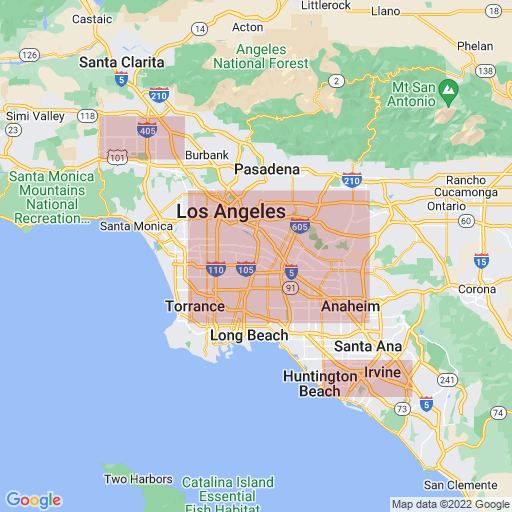

## Chicago

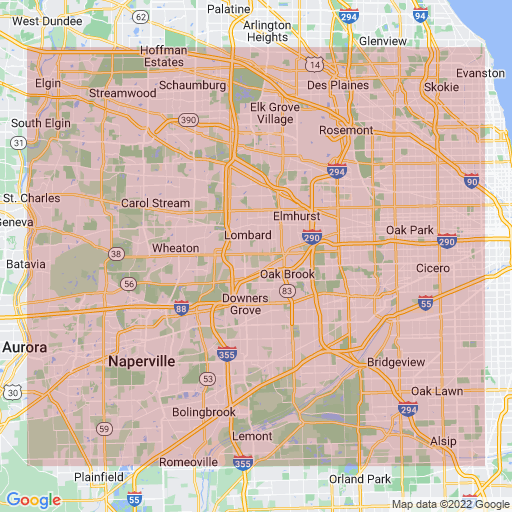

## Houston

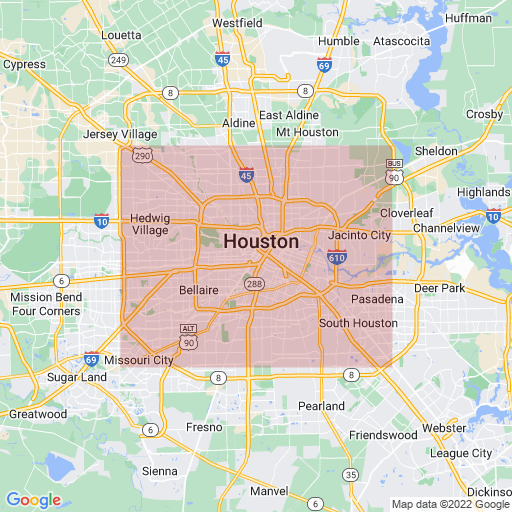

## Phoenix

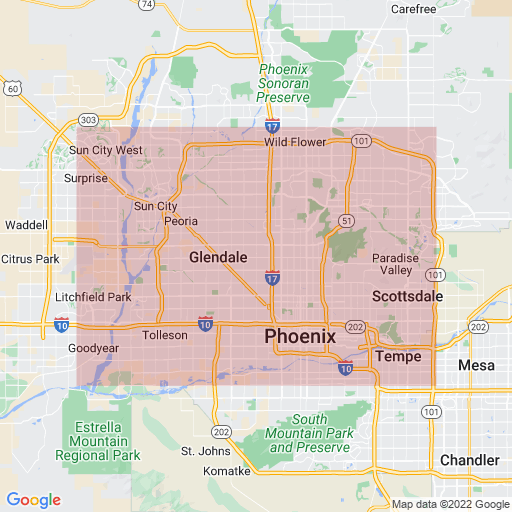

## Philadelphia

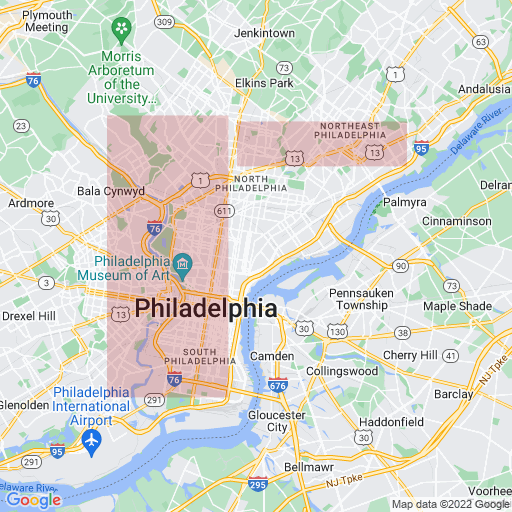

## San Francisco

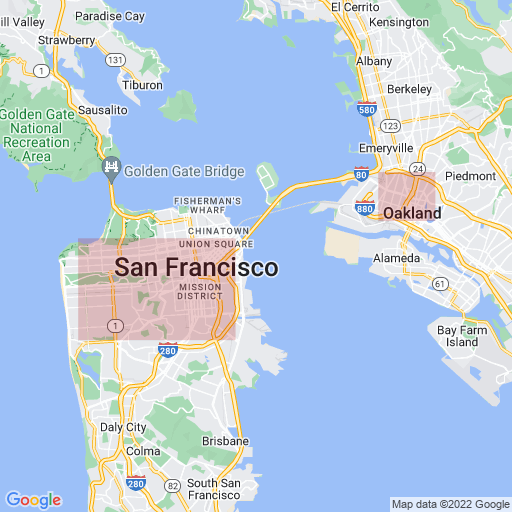

## Boston

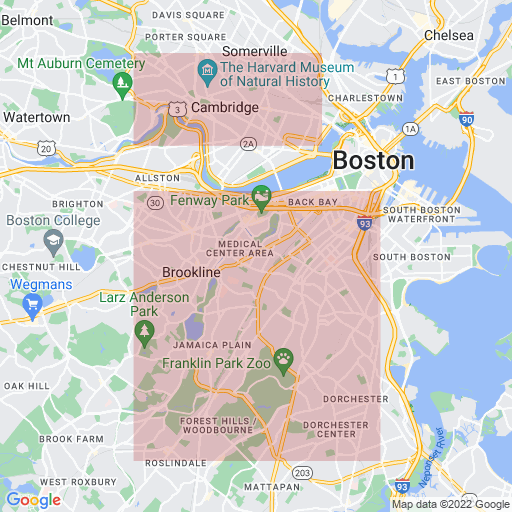

In [8]:
def area_polyline(area):
    path = [
        (area['n'], area['w']),
        (area['n'], area['e']),
        (area['s'], area['e']),
        (area['s'], area['w']),
    ]
    return polyline.encode(path, 5)

def area_path_parameter(area):
    return "fillcolor:0xAA000033|color:0xFFFFFF00|enc:{enc}".format(enc=area_polyline(area))

def city_overview_map(areas):
    querystring = "&".join(map(lambda arg: "path={}".format(arg), map(area_path_parameter, areas)))
    img_overview = maps_static_api(
        querystring=querystring
    )
    return img_overview

for name, city in cities.items():
    display(Markdown('## '+name))
    display(city_overview_map(city))

In [9]:
# def pick_random_center_from_city(city_boxes):
#     index = np.random.randint(len(city_boxes))
#     box = city_boxes[index]

#     rand_x = np.random.uniform(box['w'], box['e'])
#     rand_y = np.random.uniform(box['n'], box['s'])

#     return rand_x, rand_y

# def pick_random_center(cities_boxes):
#     city_nr = np.random.randint(len(cities_boxes)) #pick a city
#     return pick_random_center_from_city(cities_boxes[city_nr])

def pick_random_centers(boxes):
    centers = []
    for box in boxes:
        rand_x = np.random.uniform(box['w'], box['e'])
        rand_y = np.random.uniform(box['n'], box['s'])
        centers.append((rand_x, rand_y))
    return centers

import pyproj
geod = pyproj.Geod('+a=6378137 +f=0.0033528106647475126')
def area_weight(area):
    coordinates = np.array([
        (area['n'], area['w']),
        (area['n'], area['e']),
        (area['s'], area['e']),
        (area['s'], area['w']),
    ])
    lats = coordinates[:,0]
    lons = coordinates[:,1]
    area_m, _ = geod.polygon_area_perimeter(lons, lats)
    return abs(area_m) # Positive is counterclockwise, the data is clockwise.

def pick_random_areas(city, n=1):
    choices = [area for area in city]
    weights = [area_weight(area) for area in city]
    p = np.asarray(weights).astype('float64')
    p = p / np.sum(p)
    
    #samples = random.choices(choices, weights, k=n)
    samples = np.random.choice(len(choices), size=n, replace=True, p=p)
    samples = [choices[x] for x in samples]
    return samples

In [10]:
def download_map_sample(lat, lon, zoom=18, target_width=400, target_height=400):
    bottom_crop = 20
    args = {
        "lat": lat,
        "lon": lon,
        "zoom": zoom,
        "width": target_width+bottom_crop,
        "height": target_height+bottom_crop
    }
    img_sat = maps_static_api(
        maptype="satellite",
        **args
    )
    img_sat = img_sat.crop(box=(0,0,target_width, target_height)) # remove pixels at the bottom
    img_mask = maps_static_api(
        maptype="roadmap",
        map_id="7ed943b30af08eea",
        **args
    )
    img_mask = img_mask.crop(box=(0,0,target_width, target_height)) # remove pixels at the bottom
    return img_sat, img_mask

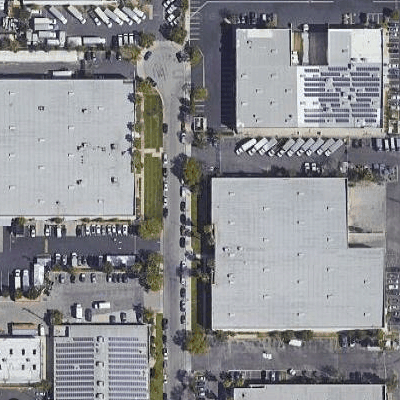

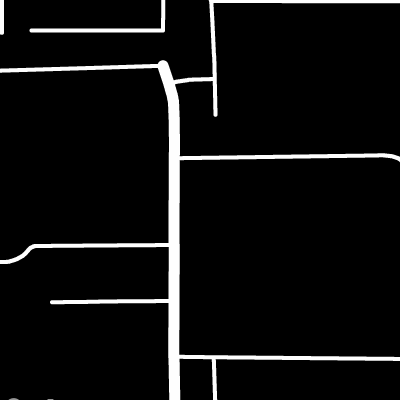

In [11]:
city_nr = np.random.randint(len(cities_boxes)) #pick a city
x, y = pick_random_centers(pick_random_areas(cities_boxes[city_nr], n=1))[0]
sat, mask = download_map_sample(y, x)
display(sat)
display(mask)

In [12]:
from skimage.io import imsave
from pathlib import Path

dataset_directory = os.getenv('DATASET_DIR', "../gmaps_dataset/")

def save_image(name, image, mask, img_path, mask_path):
    imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
    # the following removes anti-aliasing
    mask_arrray = (np.array(mask.convert('RGB')).astype(bool)*255)
    imsave(mask_path, mask_arrray.astype(np.uint8))

def download_dataset(dataset_sources, seed, force_download=False):
    np.random.seed(seed)
    Path(os.path.join(dataset_directory, "images")).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(dataset_directory, "masks")).mkdir(parents=True, exist_ok=True)
    for name, city_boxes, count in dataset_sources:
        samples = pick_random_centers(pick_random_areas(city_boxes, n=count))
        for i in range(count):
            x, y = samples[i]
            print(x, y)
            img_path = os.path.join(dataset_directory, "images", "{}_{}.png".format(name, i+1))
            mask_path = os.path.join(dataset_directory, "masks", "{}_{}.png".format(name, i+1))
            
            if (os.path.isfile(img_path) and os.path.isfile(mask_path)) and (not force_download):
                print("Already exists: {}_{}.png".format(name, i+1))
            else:
                sat, mask = download_map_sample(y, x)
                save_image(name, sat, mask, img_path, mask_path)
                print("Saved {}_{}.png".format(name, i+1))
    print("DONE")

In [13]:
sum_areas = 0
for city, boxes in cities.items():
    area = sum(area_weight(area) for area in boxes) / 1000000
    sum_areas += area
    print("{:17.17s}: {:5.0f} km2".format(city, area))
print("TOTAL ---------- : {:5.0f} km2".format(sum_areas))
total_images = 12000
for city, boxes in cities.items():
    area = sum(area_weight(area) for area in boxes) / 1000000
    print("{:17.17s}: {:5.0f} images".format(city, total_images * area / sum_areas))

Los Angeles      :  1999 km2
Chicago          :  2486 km2
Houston          :  1060 km2
Phoenix          :  1510 km2
Philadelphia     :   144 km2
San Francisco    :    69 km2
Boston           :    67 km2
TOTAL ---------- :  7335 km2
Los Angeles      :  3271 images
Chicago          :  4067 images
Houston          :  1735 images
Phoenix          :  2470 images
Philadelphia     :   235 images
San Francisco    :   112 images
Boston           :   110 images


In [15]:
print("a")

a


In [16]:
dataset_sources = [
    ("los_angeles", los_angeles, 3271),
    ("chicago", chicago, 4067),
    ("houston", houston, 1735),
    ("phoenix", phoenix, 2470),
    ("philadelphia", philadelphia, 235),
    ("san_francisco", san_francisco, 112),
    ("boston", boston, 110),
]
download_dataset(dataset_sources, seed=43)

-118.53984754088327 34.20422367705202
Already exists: los_angeles_1.png
-117.98634938146975 34.005268217467865
Already exists: los_angeles_2.png
-117.94260849835106 34.066470867712276
Already exists: los_angeles_3.png
-118.13606914603031 33.976948133060816
Already exists: los_angeles_4.png
-117.9356592060978 33.81773771868975
Already exists: los_angeles_5.png
-117.998716788815 33.93580725507488
Already exists: los_angeles_6.png
-117.986334762627 33.88918456600819
Already exists: los_angeles_7.png
-117.97674463310885 34.09933836263537
Already exists: los_angeles_8.png
-118.3934288653897 34.240650125509994
Already exists: los_angeles_9.png
-118.23106148334375 34.04475889588963
Already exists: los_angeles_10.png
-118.01605455363837 33.88410671446129
Already exists: los_angeles_11.png
-118.2014503527869 34.078048849415836
Already exists: los_angeles_12.png
-118.03805396791577 34.01212512040897
Already exists: los_angeles_13.png
-118.54845768928776 34.20168369306286
Already exists: los_ange

Already exists: los_angeles_155.png
-117.90691838430456 33.67893641709974
Already exists: los_angeles_156.png
-118.36058376442763 33.890688475600676
Already exists: los_angeles_157.png
-117.95870093232409 33.706727456310674
Already exists: los_angeles_158.png
-118.13534756727199 34.04546618737691
Already exists: los_angeles_159.png
-118.25695665605181 33.96053904810862
Already exists: los_angeles_160.png
-117.94086103371838 33.68266300825133
Already exists: los_angeles_161.png
-117.99144842997498 33.81312840766663
Already exists: los_angeles_162.png
-118.05822967829482 34.084206988374
Already exists: los_angeles_163.png
-117.83915088297304 33.64696422310457
Already exists: los_angeles_164.png
-118.58517606230086 34.22953845286278
Already exists: los_angeles_165.png
-118.06414771045293 34.08734987229668
Already exists: los_angeles_166.png
-118.0865060294187 33.81376946458947
Already exists: los_angeles_167.png
-118.30906463141268 33.81019407914153
Already exists: los_angeles_168.png
-11

Already exists: los_angeles_266.png
-117.90054851089248 33.80035435395354
Already exists: los_angeles_267.png
-117.88209624021873 33.68192871861303
Already exists: los_angeles_268.png
-118.19970810954067 33.87463940575104
Already exists: los_angeles_269.png
-117.95078128021794 33.95158490703564
Already exists: los_angeles_270.png
-118.10873815894935 33.806472684973066
Already exists: los_angeles_271.png
-118.28225811556844 33.978329221452135
Already exists: los_angeles_272.png
-118.57910367411569 34.19494050760887
Already exists: los_angeles_273.png
-117.87734830107325 34.040091550879865
Already exists: los_angeles_274.png
-118.33885857078772 34.06913297248991
Already exists: los_angeles_275.png
-118.41984762273164 34.21742062468341
Already exists: los_angeles_276.png
-118.15524781489216 33.820167492591864
Already exists: los_angeles_277.png
-118.12858000227553 33.96174103836261
Already exists: los_angeles_278.png
-117.88567626298925 33.692249915425016
Already exists: los_angeles_279.p

Already exists: los_angeles_430.png
-117.96832203289334 33.94157581821359
Already exists: los_angeles_431.png
-118.30824283867688 33.895177164746094
Already exists: los_angeles_432.png
-117.94381076370345 33.71363839428405
Already exists: los_angeles_433.png
-118.0926225426967 34.04536966874418
Already exists: los_angeles_434.png
-118.07385254520969 33.98847802209465
Already exists: los_angeles_435.png
-118.09295874802446 33.95373195639672
Already exists: los_angeles_436.png
-118.14288005081035 34.029182859423805
Already exists: los_angeles_437.png
-118.20099463266337 34.002571976677324
Already exists: los_angeles_438.png
-118.31674482113189 33.91061112940444
Already exists: los_angeles_439.png
-118.26648963843988 34.08327301227463
Already exists: los_angeles_440.png
-117.91980060564444 34.06674021296524
Already exists: los_angeles_441.png
-118.03776548363167 34.096967566814186
Already exists: los_angeles_442.png
-118.09013001988396 34.022434014170116
Already exists: los_angeles_443.pn

Already exists: los_angeles_589.png
-118.32264678255699 33.83198308662216
Already exists: los_angeles_590.png
-117.97304215584205 33.817912253605144
Already exists: los_angeles_591.png
-118.26715795017398 34.08258911525331
Already exists: los_angeles_592.png
-117.87407377720184 33.81243344922079
Already exists: los_angeles_593.png
-118.16675325461145 34.08276151930998
Already exists: los_angeles_594.png
-118.26524887791724 33.91588546763248
Already exists: los_angeles_595.png
-118.13595560430383 34.014281457305884
Already exists: los_angeles_596.png
-118.41383315322462 34.18865327620705
Already exists: los_angeles_597.png
-118.52115459188379 34.17204028701146
Already exists: los_angeles_598.png
-118.31640066726854 33.87771524247348
Already exists: los_angeles_599.png
-118.01703060572784 34.061862669689724
Already exists: los_angeles_600.png
-118.05728278077554 33.93462590667849
Already exists: los_angeles_601.png
-118.2655962882065 33.98790688063255
Already exists: los_angeles_602.png


Already exists: los_angeles_743.png
-117.89668775528997 34.0880368867789
Already exists: los_angeles_744.png
-117.93212771180468 34.09281559833527
Already exists: los_angeles_745.png
-117.74894321951993 33.67912651817399
Already exists: los_angeles_746.png
-118.30429653943003 33.82439552840286
Already exists: los_angeles_747.png
-117.86488953648582 33.69555541822841
Already exists: los_angeles_748.png
-118.31822545501315 33.80636442733521
Already exists: los_angeles_749.png
-118.13922891282618 34.01123459221446
Already exists: los_angeles_750.png
-117.97120057480707 34.007107086113145
Already exists: los_angeles_751.png
-118.31188130616259 33.832751556145354
Already exists: los_angeles_752.png
-117.81880259043092 33.663016022532325
Already exists: los_angeles_753.png
-118.04495969995122 33.80472392142654
Already exists: los_angeles_754.png
-118.35304648008228 34.071729953738846
Already exists: los_angeles_755.png
-118.19606114739322 33.89590630676347
Already exists: los_angeles_756.png

Already exists: los_angeles_897.png
-117.81990666165493 33.69843870974283
Already exists: los_angeles_898.png
-118.26756601122915 34.08699629486627
Already exists: los_angeles_899.png
-117.80703320596858 33.67952346810466
Already exists: los_angeles_900.png
-118.17306314967722 34.02494644970107
Already exists: los_angeles_901.png
-117.95441403183607 33.823965333094804
Already exists: los_angeles_902.png
-118.01594981454235 33.92705228656004
Already exists: los_angeles_903.png
-117.88770108152345 34.08713182209189
Already exists: los_angeles_904.png
-118.4823798963079 34.20637412471863
Already exists: los_angeles_905.png
-117.93038778189289 33.82675217409343
Already exists: los_angeles_906.png
-118.33873968485504 34.098752246189164
Already exists: los_angeles_907.png
-117.91738817477938 34.01648793442496
Already exists: los_angeles_908.png
-118.28762584211971 33.89662445179914
Already exists: los_angeles_909.png
-117.84542742229559 33.64784950113768
Already exists: los_angeles_910.png
-

Already exists: los_angeles_1046.png
-118.40831379784477 34.23836375368731
Already exists: los_angeles_1047.png
-117.96246092065549 34.086181385064805
Already exists: los_angeles_1048.png
-118.1605927963956 34.099360991860365
Already exists: los_angeles_1049.png
-118.07994621360054 33.99681687062437
Already exists: los_angeles_1050.png
-118.25902054497348 33.84271670455793
Already exists: los_angeles_1051.png
-118.1766617784112 34.03602416212619
Already exists: los_angeles_1052.png
-118.33588029574958 34.00910408947166
Already exists: los_angeles_1053.png
-118.100450345498 33.899741326542596
Already exists: los_angeles_1054.png
-118.58364659976256 34.213000360301834
Already exists: los_angeles_1055.png
-118.32092487866274 34.09436708707733
Already exists: los_angeles_1056.png
-117.88269579381512 34.09018869288532
Already exists: los_angeles_1057.png
-117.7890125875387 33.65256918163799
Already exists: los_angeles_1058.png
-118.20967561383837 34.07395534253963
Already exists: los_angele

Already exists: los_angeles_1201.png
-117.86538470676864 33.63190897677468
Already exists: los_angeles_1202.png
-117.90611260309834 34.011254655631376
Already exists: los_angeles_1203.png
-118.02809475009214 33.823806306835635
Already exists: los_angeles_1204.png
-117.9856955182027 34.03716028079871
Already exists: los_angeles_1205.png
-117.81272260348017 33.63502017949523
Already exists: los_angeles_1206.png
-117.89055454335885 34.06942290258876
Already exists: los_angeles_1207.png
-117.93399396797592 34.08791926647971
Already exists: los_angeles_1208.png
-118.01589811255 34.0322693375738
Already exists: los_angeles_1209.png
-117.90780237134611 33.68451485918314
Already exists: los_angeles_1210.png
-118.21344902303385 33.80233686091499
Already exists: los_angeles_1211.png
-118.15288987854923 33.81885146419459
Already exists: los_angeles_1212.png
-117.89703967868941 33.71218031863969
Already exists: los_angeles_1213.png
-117.75196583831601 33.663683654501405
Already exists: los_angeles

Already exists: los_angeles_1359.png
-117.97360288936515 34.06196476580571
Already exists: los_angeles_1360.png
-117.99151971358602 33.6683691280711
Already exists: los_angeles_1361.png
-117.90719290712656 34.01238193982024
Already exists: los_angeles_1362.png
-117.87232092161683 33.91093682845784
Already exists: los_angeles_1363.png
-117.87290171171111 33.849421038165296
Already exists: los_angeles_1364.png
-118.59131964036506 34.222742492805956
Already exists: los_angeles_1365.png
-118.19064122314607 34.09760703440696
Already exists: los_angeles_1366.png
-117.83055957037615 33.66718193909167
Already exists: los_angeles_1367.png
-118.09675104303888 34.00375371734887
Already exists: los_angeles_1368.png
-118.47454902984691 34.18300808975441
Already exists: los_angeles_1369.png
-118.14064999635868 34.086792454578216
Already exists: los_angeles_1370.png
-117.95173177787359 33.94439859340706
Already exists: los_angeles_1371.png
-118.07539631319617 33.99250046064346
Already exists: los_ang

Already exists: los_angeles_1512.png
-118.15944058269913 33.854384241316836
Already exists: los_angeles_1513.png
-117.97073030406429 33.929659152805016
Already exists: los_angeles_1514.png
-118.2117563889842 34.00334932562077
Already exists: los_angeles_1515.png
-118.33514007367116 33.81686268848677
Already exists: los_angeles_1516.png
-118.5985611541096 34.18497338779535
Already exists: los_angeles_1517.png
-118.03363773962901 34.09623836842126
Already exists: los_angeles_1518.png
-118.11096643743515 34.04302726950762
Already exists: los_angeles_1519.png
-118.15555620944839 34.044289669964655
Already exists: los_angeles_1520.png
-117.95500461776595 33.855469987465895
Already exists: los_angeles_1521.png
-118.26207784552534 33.83070499841165
Already exists: los_angeles_1522.png
-117.91101260173872 34.070971760828456
Already exists: los_angeles_1523.png
-118.02825453385692 33.983548023337775
Already exists: los_angeles_1524.png
-117.8975723047214 33.99811794698684
Already exists: los_an

Already exists: los_angeles_1670.png
-118.29991272537335 34.095316859570964
Already exists: los_angeles_1671.png
-118.31466917185912 33.873911255452924
Already exists: los_angeles_1672.png
-118.32232298068868 34.095401304246955
Already exists: los_angeles_1673.png
-118.39450258494266 34.21014535154504
Already exists: los_angeles_1674.png
-117.94811785192188 33.69923807755861
Already exists: los_angeles_1675.png
-118.17977445985441 33.91095858155515
Already exists: los_angeles_1676.png
-117.96526357884883 33.94119221061659
Already exists: los_angeles_1677.png
-118.12555875907194 34.08569763630365
Already exists: los_angeles_1678.png
-117.9289040516262 33.83035433677935
Already exists: los_angeles_1679.png
-118.18785823900545 34.004217954210525
Already exists: los_angeles_1680.png
-117.98719392154145 34.039285153232875
Already exists: los_angeles_1681.png
-118.48501772179173 34.2186178904852
Already exists: los_angeles_1682.png
-118.0518653449876 33.982177432583796
Already exists: los_an

Already exists: los_angeles_1828.png
-118.22332817865328 33.88781093485172
Already exists: los_angeles_1829.png
-118.26402991563621 33.958323431116796
Already exists: los_angeles_1830.png
-117.90131604884029 33.833964684480875
Already exists: los_angeles_1831.png
-118.15022022717464 33.84886631252783
Already exists: los_angeles_1832.png
-118.27474469779862 33.99454445055621
Already exists: los_angeles_1833.png
-118.23098576745033 33.802184463526594
Already exists: los_angeles_1834.png
-118.3425797079111 33.81766892508789
Already exists: los_angeles_1835.png
-117.76932896121818 33.68934962933501
Already exists: los_angeles_1836.png
-118.45214576224404 34.18892783567167
Already exists: los_angeles_1837.png
-118.13225487976621 34.01098963715004
Already exists: los_angeles_1838.png
-118.09074128448043 33.90422670572832
Already exists: los_angeles_1839.png
-117.91621209058384 34.06568858392578
Already exists: los_angeles_1840.png
-118.1383716194396 33.92871075258157
Already exists: los_ange

Already exists: los_angeles_1986.png
-118.05279321451609 33.98638897373841
Already exists: los_angeles_1987.png
-117.88604311363589 34.04590292229759
Already exists: los_angeles_1988.png
-118.2741331179124 33.975596292650955
Already exists: los_angeles_1989.png
-118.3142048160788 33.857093944294654
Already exists: los_angeles_1990.png
-117.91367988208488 33.89373777945734
Already exists: los_angeles_1991.png
-118.08427359891947 33.92784503449979
Already exists: los_angeles_1992.png
-117.86603083723348 33.92386923812001
Already exists: los_angeles_1993.png
-117.96657643382147 33.85614673065938
Already exists: los_angeles_1994.png
-118.10635166349711 33.82158598596655
Already exists: los_angeles_1995.png
-118.0291467201262 33.98036821158197
Already exists: los_angeles_1996.png
-118.23247614305483 34.05335809648913
Already exists: los_angeles_1997.png
-118.38806364646777 34.24136305139999
Already exists: los_angeles_1998.png
-117.84736175303891 33.684891397919884
Already exists: los_angel

Already exists: los_angeles_2144.png
-118.07604014427376 33.99556538552799
Already exists: los_angeles_2145.png
-117.96969894616927 33.82929186901206
Already exists: los_angeles_2146.png
-117.79494080274122 33.63184420959315
Already exists: los_angeles_2147.png
-117.75053646427783 33.695829338603595
Already exists: los_angeles_2148.png
-118.17872753119624 33.80751291194303
Already exists: los_angeles_2149.png
-117.93328158467267 34.04218897504138
Already exists: los_angeles_2150.png
-118.07292573701008 34.02748929821977
Already exists: los_angeles_2151.png
-118.08329627539689 34.04207361322511
Already exists: los_angeles_2152.png
-117.89694435630446 34.01765797233609
Already exists: los_angeles_2153.png
-118.26304177703909 33.87779055289217
Already exists: los_angeles_2154.png
-118.33935154105096 34.01698714530159
Already exists: los_angeles_2155.png
-118.19542037595457 34.05912598049768
Already exists: los_angeles_2156.png
-117.93693747062575 33.915284400429336
Already exists: los_ang

Already exists: los_angeles_2285.png
-118.24989502278271 33.92755422372488
Already exists: los_angeles_2286.png
-118.05589626097614 33.8236693010127
Already exists: los_angeles_2287.png
-118.21286471453068 34.08199553681569
Already exists: los_angeles_2288.png
-117.94504677455426 34.04353830745867
Already exists: los_angeles_2289.png
-117.83443245111998 33.669267624168256
Already exists: los_angeles_2290.png
-117.92486908957449 33.96250691358778
Already exists: los_angeles_2291.png
-117.77668249273421 33.67490417537546
Already exists: los_angeles_2292.png
-117.98382834178058 33.68900416360901
Already exists: los_angeles_2293.png
-117.94749689203452 34.01665572361254
Already exists: los_angeles_2294.png
-117.75936354384456 33.67828349291862
Already exists: los_angeles_2295.png
-118.2107494516431 34.08358837758366
Already exists: los_angeles_2296.png
-117.87926163740894 33.80526613663959
Already exists: los_angeles_2297.png
-118.01675731253896 34.059300099034814
Already exists: los_angel

Already exists: los_angeles_2444.png
-117.97378250628114 33.8546991095282
Already exists: los_angeles_2445.png
-118.60150500810968 34.205636701978285
Already exists: los_angeles_2446.png
-117.95982384794432 33.870102287662775
Already exists: los_angeles_2447.png
-118.10971495727327 34.09834781891506
Already exists: los_angeles_2448.png
-117.92756017161265 33.94006349303854
Already exists: los_angeles_2449.png
-118.35456526028337 33.82745219492913
Already exists: los_angeles_2450.png
-118.11363730980824 33.913246420490715
Already exists: los_angeles_2451.png
-118.28620446741378 34.00379513114728
Already exists: los_angeles_2452.png
-118.27340851652023 33.996726606755885
Already exists: los_angeles_2453.png
-117.89254576589293 33.71230818158819
Already exists: los_angeles_2454.png
-118.14691390347335 33.84033268123531
Already exists: los_angeles_2455.png
-118.26365143991116 34.070833665087136
Already exists: los_angeles_2456.png
-118.46303492026264 34.20712490446126
Already exists: los_a

Already exists: los_angeles_2602.png
-118.01771286318728 33.958852804103124
Already exists: los_angeles_2603.png
-117.83922735744014 33.67566666169436
Already exists: los_angeles_2604.png
-118.23552731455554 33.80508867218432
Already exists: los_angeles_2605.png
-117.90836523583101 33.94815258943241
Already exists: los_angeles_2606.png
-118.23461941281035 33.85544598992081
Already exists: los_angeles_2607.png
-117.92952680218588 33.83792916935983
Already exists: los_angeles_2608.png
-118.15171049154195 33.891461776357744
Already exists: los_angeles_2609.png
-117.92384864312703 34.00885769897067
Already exists: los_angeles_2610.png
-118.28600850043766 33.979779647239674
Already exists: los_angeles_2611.png
-118.26662328786723 33.798303952719586
Already exists: los_angeles_2612.png
-118.54689409560719 34.22019004033615
Already exists: los_angeles_2613.png
-118.18661647101959 33.85759294306397
Already exists: los_angeles_2614.png
-118.04919066290621 34.0941478880216
Already exists: los_an

Already exists: los_angeles_2755.png
-118.5794101967994 34.187657363396454
Already exists: los_angeles_2756.png
-118.17744949578754 34.09142193981881
Already exists: los_angeles_2757.png
-118.34030243085142 33.9393392787842
Already exists: los_angeles_2758.png
-118.2900769950524 34.09354938433713
Already exists: los_angeles_2759.png
-118.27361461670185 33.80359815895323
Already exists: los_angeles_2760.png
-118.26278945899128 33.97834990009103
Already exists: los_angeles_2761.png
-117.87191465113159 33.65046810594454
Already exists: los_angeles_2762.png
-118.24769246443658 33.93528268645159
Already exists: los_angeles_2763.png
-118.30702109624171 33.90510925776477
Already exists: los_angeles_2764.png
-118.41334620267035 34.20736747418869
Already exists: los_angeles_2765.png
-118.00723427994986 33.97487064610799
Already exists: los_angeles_2766.png
-117.9877550301709 34.073093562591175
Already exists: los_angeles_2767.png
-118.18218212732268 34.10038411014143
Already exists: los_angeles

Already exists: los_angeles_2914.png
-118.28085874123073 33.864473415082735
Already exists: los_angeles_2915.png
-118.17581596992427 34.04395485987777
Already exists: los_angeles_2916.png
-118.43744401450698 34.21119435458365
Already exists: los_angeles_2917.png
-117.95529821269567 33.66316631938371
Already exists: los_angeles_2918.png
-117.92610585809703 33.95298656836087
Already exists: los_angeles_2919.png
-117.812641953255 33.633837191821165
Already exists: los_angeles_2920.png
-118.28336485326365 34.035219482432105
Already exists: los_angeles_2921.png
-118.31424816127095 34.04357633005214
Already exists: los_angeles_2922.png
-118.21068817734131 33.99490627067435
Already exists: los_angeles_2923.png
-117.79509781953797 33.69382137212247
Already exists: los_angeles_2924.png
-118.01591425738303 33.93977229937581
Already exists: los_angeles_2925.png
-118.2790086447734 33.946583064119146
Already exists: los_angeles_2926.png
-118.06515936123544 33.882733046578416
Already exists: los_ang

Already exists: los_angeles_3074.png
-117.98765614563382 33.827849286253695
Already exists: los_angeles_3075.png
-118.300966249121 34.01474708608644
Already exists: los_angeles_3076.png
-118.26209773365939 34.08540243613828
Already exists: los_angeles_3077.png
-117.8718200330541 34.08819252348545
Already exists: los_angeles_3078.png
-118.13941347792299 34.06896598635506
Already exists: los_angeles_3079.png
-117.79252967556465 33.69402791406481
Already exists: los_angeles_3080.png
-118.0818391693513 34.099646782317656
Already exists: los_angeles_3081.png
-118.35076534931432 33.85093969424837
Already exists: los_angeles_3082.png
-118.14461856863535 33.80081794343787
Already exists: los_angeles_3083.png
-117.98529673722594 33.9450499974742
Already exists: los_angeles_3084.png
-118.00490348605959 34.078571408395334
Already exists: los_angeles_3085.png
-118.15123682740997 33.88416515966819
Already exists: los_angeles_3086.png
-118.01425148889997 33.96330375582756
Already exists: los_angeles

Already exists: los_angeles_3231.png
-117.86483313839645 33.69250490205821
Already exists: los_angeles_3232.png
-117.95958683248843 33.875373837598325
Already exists: los_angeles_3233.png
-118.26461874915505 34.09318973878793
Already exists: los_angeles_3234.png
-118.37848700050172 34.22352155197188
Already exists: los_angeles_3235.png
-117.98385592961031 33.68509583774176
Already exists: los_angeles_3236.png
-118.37467162516788 34.22755659884272
Already exists: los_angeles_3237.png
-118.11266538895751 33.95646156432605
Already exists: los_angeles_3238.png
-118.09805968370418 33.821435561014134
Already exists: los_angeles_3239.png
-118.16004507911254 33.81149306108923
Already exists: los_angeles_3240.png
-118.1434028079667 33.95585595749406
Already exists: los_angeles_3241.png
-118.35962624613546 34.02459728058306
Already exists: los_angeles_3242.png
-117.76879089051602 33.64280025618372
Already exists: los_angeles_3243.png
-117.97553797689463 33.685165338724836
Already exists: los_ang

Already exists: chicago_112.png
-88.0612974099174 41.75493668394231
Already exists: chicago_113.png
-88.03984801699985 41.94193189854089
Already exists: chicago_114.png
-88.01684249688563 41.74342790656043
Already exists: chicago_115.png
-88.06603845043973 41.90071483994517
Already exists: chicago_116.png
-87.6920893034355 41.77201368440469
Already exists: chicago_117.png
-87.88788851672545 41.792696795478605
Already exists: chicago_118.png
-87.73746434090481 42.02015872824828
Already exists: chicago_119.png
-87.90253673914123 41.653594339186725
Already exists: chicago_120.png
-88.02620184175767 41.81644724849915
Already exists: chicago_121.png
-87.75257016322499 41.67615044810254
Already exists: chicago_122.png
-87.90732316758337 41.876890290732106
Already exists: chicago_123.png
-88.15963297705221 41.87749262801396
Already exists: chicago_124.png
-88.02244508097792 42.070987745031154
Already exists: chicago_125.png
-88.26612704025285 41.99657653146924
Already exists: chicago_126.png


Already exists: chicago_278.png
-88.20470766291218 41.69847189193485
Already exists: chicago_279.png
-87.85024667969981 41.99165878822939
Already exists: chicago_280.png
-87.94482210750932 41.72356996923406
Already exists: chicago_281.png
-88.18144730573702 41.83601786369205
Already exists: chicago_282.png
-87.87636921226311 41.796786327915896
Already exists: chicago_283.png
-88.05233244011431 41.64724982203985
Already exists: chicago_284.png
-88.31054579301136 41.77660404025943
Already exists: chicago_285.png
-88.23567358942175 41.65911485504421
Already exists: chicago_286.png
-88.22669655478099 41.839026626698825
Already exists: chicago_287.png
-87.7465921092691 41.911365600962235
Already exists: chicago_288.png
-87.68516760458867 41.86377062511199
Already exists: chicago_289.png
-87.71803814441849 41.81028905719093
Already exists: chicago_290.png
-87.98126565239137 41.92659175686
Already exists: chicago_291.png
-88.28929983612973 41.74016447121342
Already exists: chicago_292.png
-88

Already exists: chicago_441.png
-88.05193035687182 41.684360391541595
Already exists: chicago_442.png
-88.18268774021469 41.72182916613485
Already exists: chicago_443.png
-88.27528228674579 41.71972006731531
Already exists: chicago_444.png
-88.03462335105645 41.71858078269564
Already exists: chicago_445.png
-88.12306321198443 41.823109185272536
Already exists: chicago_446.png
-87.68900251243508 41.98722070808537
Already exists: chicago_447.png
-87.89799615136131 41.919111989766336
Already exists: chicago_448.png
-87.85977023013804 41.69495762162661
Already exists: chicago_449.png
-87.92681700387915 42.004318361994336
Already exists: chicago_450.png
-88.22314456880491 41.78297804636399
Already exists: chicago_451.png
-88.17016316334553 41.879004187815575
Already exists: chicago_452.png
-88.05789140839536 41.77565081272867
Already exists: chicago_453.png
-87.96529186634243 41.87537888129494
Already exists: chicago_454.png
-87.72110362770476 42.05610944812009
Already exists: chicago_455.p

Already exists: chicago_606.png
-87.93690570390167 41.99218071449603
Already exists: chicago_607.png
-87.86370897526935 41.79881569357578
Already exists: chicago_608.png
-88.03596947086191 41.81026243530845
Already exists: chicago_609.png
-88.24416820757953 41.78717010075177
Already exists: chicago_610.png
-87.86015055943955 41.750995729129556
Already exists: chicago_611.png
-88.2961292568122 41.66148245280967
Already exists: chicago_612.png
-88.24624540401345 42.030129086772526
Already exists: chicago_613.png
-88.03111997204573 41.80010681785378
Already exists: chicago_614.png
-88.08659187897811 42.01774167543659
Already exists: chicago_615.png
-87.89423988907835 42.027233521960156
Already exists: chicago_616.png
-87.74459219654747 41.74713418679114
Already exists: chicago_617.png
-87.88673905577257 41.80223556133262
Already exists: chicago_618.png
-87.86007801966814 41.85223053062907
Already exists: chicago_619.png
-87.7332721636929 41.803350715751336
Already exists: chicago_620.png


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_711.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_711.png
-88.09788555396666 41.98844976111221


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_712.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_712.png
-87.90398647138163 41.95488860830354
Saved chicago_713.png
-88.0764735166138 41.81380753798992
Saved chicago_714.png
-87.75636716207354 41.950370953301515
Saved chicago_715.png
-88.16957942239245 41.883594541514135


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_716.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_716.png
-87.84231536698914 41.65520653724586


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_717.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_717.png
-88.19426293276115 41.764505304543796
Saved chicago_718.png
-87.73968327398572 41.91188117833185
Saved chicago_719.png
-88.0959347150207 42.04241782816179
Saved chicago_720.png
-88.07916840995864 41.98079803500822
Saved chicago_721.png
-88.28682269903639 42.0138817844901
Saved chicago_722.png
-87.95199231705067 42.046865415443904
Saved chicago_723.png
-88.14484545124999 42.037437574846436
Saved chicago_724.png
-88.13902319231586 42.00979028870824
Saved chicago_725.png
-87.91363170133096 41.81819772746263
Saved chicago_726.png
-87.72876393487483 41.75123242069486
Saved chicago_727.png
-88.25874378936577 41.97634096215623
Saved chicago_728.png
-88.19620298398056 41.98777426947583
Saved chicago_729.png
-87.8369802183693 41.87213893789348
Saved chicago_730.png
-88.19648689669668 41.703751106980306
Saved chicago_731.png
-87.76339836467493 41.951130425086
Saved chicago_732.png
-88.05201719674551 42.04326818991275
Saved chicago_733.png
-87.97520311768115 41.6579837691290

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_745.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_745.png
-88.1843019351447 41.85811402134799
Saved chicago_746.png
-87.74365524104176 41.857274479447064
Saved chicago_747.png
-87.88923512251922 41.67575389445338


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_748.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_748.png
-87.86596544512572 41.97195302224771
Saved chicago_749.png
-87.78818949646805 41.91601635762297
Saved chicago_750.png
-88.08197190142018 41.81833663114526
Saved chicago_751.png
-88.1203205349144 41.84078925387624


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_752.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_752.png
-88.1010794384405 41.92761887677542
Saved chicago_753.png
-87.75775131951413 42.02977741335378
Saved chicago_754.png
-88.09074835878502 41.996634357272804
Saved chicago_755.png
-88.04512955972551 41.95745268624479


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_756.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_756.png
-87.79099995900933 41.749314740688725
Saved chicago_757.png
-88.02650720734512 41.84276834161945
Saved chicago_758.png
-87.94152213709414 41.87831841956627
Saved chicago_759.png
-87.83640315982859 41.948801114537574
Saved chicago_760.png
-87.81261961545187 41.89821479173264
Saved chicago_761.png
-87.85335851430804 41.97488255509065


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_762.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_762.png
-87.72433102303991 41.795329010390766
Saved chicago_763.png
-87.88126975776323 42.05337139205433


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_764.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_764.png
-87.98552719577577 41.76048436422671
Saved chicago_765.png
-88.05520875177106 41.836277460026196
Saved chicago_766.png
-87.9331872295479 42.03426431850081
Saved chicago_767.png
-88.30185818144341 42.05093170884189


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_768.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_768.png
-87.91455353019096 41.84711812784994
Saved chicago_769.png
-88.04316695105572 41.9656541577822
Saved chicago_770.png
-88.10253063896896 42.030254986505895
Saved chicago_771.png
-88.00598452789141 42.04806939429852


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_772.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_772.png
-88.24909236792398 42.01866573811446
Saved chicago_773.png
-87.95500922607643 41.68688341276424
Saved chicago_774.png
-88.10270618164265 41.91053929406897
Saved chicago_775.png
-88.28431224618717 41.893143910481825
Saved chicago_776.png
-88.1667994218725 42.06578160590744
Saved chicago_777.png
-88.13018747330545 41.65306952343872
Saved chicago_778.png
-87.83442177566498 41.82007085737848
Saved chicago_779.png
-87.96305716189616 41.64401880667084
Saved chicago_780.png
-88.11335060454047 41.88018900716501
Saved chicago_781.png
-88.15928113226842 41.9281334273897
Saved chicago_782.png
-88.25710945325744 41.79529800446654
Saved chicago_783.png
-88.14712823479931 41.76514567903719
Saved chicago_784.png
-88.0575457031634 41.66057189136084


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_785.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_785.png
-87.73727970666994 41.6442277287407
Saved chicago_786.png
-88.01597574319953 42.0699165637701
Saved chicago_787.png
-87.98142495656533 41.8720597451726
Saved chicago_788.png
-88.29159670433107 41.8645147209928
Saved chicago_789.png
-87.94436196222667 41.910113744620006
Saved chicago_790.png
-87.86742137985506 41.931879465422234
Saved chicago_791.png
-88.01971942369454 41.96687083123268
Saved chicago_792.png
-87.79433403488848 41.835112880511275
Saved chicago_793.png
-87.7116012093316 42.02313017753758
Saved chicago_794.png
-88.2817621332129 41.77374631021828
Saved chicago_795.png
-87.75083412411792 41.92756594413301
Saved chicago_796.png
-88.08421490376881 41.712790793974065
Saved chicago_797.png
-88.12496579091518 41.66471774808262
Saved chicago_798.png
-87.89399227495753 41.75119407276701
Saved chicago_799.png
-87.69160436341343 42.063264056046954
Saved chicago_800.png
-87.96126899087614 41.9591682176547
Saved chicago_801.png
-87.70272484208624 41.68186529962982

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_805.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_805.png
-88.2513993695324 41.905139128927786


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_806.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_806.png
-88.25452757200102 41.92605899441013
Saved chicago_807.png
-88.26001006372611 41.97806535849243


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_808.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_808.png
-88.16192261649748 41.84708627408364
Saved chicago_809.png
-87.96316798643906 41.84141908925691
Saved chicago_810.png
-88.05058055762424 41.905160489815074
Saved chicago_811.png
-88.10568496302278 41.780925470155665
Saved chicago_812.png
-88.0067697666601 42.046934624328706


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_813.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_813.png
-88.2943876932937 41.791315825203235
Saved chicago_814.png
-88.08034275341218 41.985689490917956
Saved chicago_815.png
-87.98918222516411 41.80515872123691
Saved chicago_816.png
-88.15280577302411 42.02337184841964
Saved chicago_817.png
-87.75677805778898 42.048936612096476
Saved chicago_818.png
-87.77348926540066 41.747826188851654
Saved chicago_819.png
-87.85625806928543 42.02379012131131
Saved chicago_820.png
-88.23797919166698 41.93508902130592
Saved chicago_821.png
-88.15547556780706 41.665392417231175
Saved chicago_822.png
-87.84360756704707 42.017138309153076
Saved chicago_823.png
-88.15354666944349 41.831741300877205
Saved chicago_824.png
-88.21641653477731 41.88225874631135
Saved chicago_825.png
-87.84146437591764 41.95334193152426
Saved chicago_826.png
-87.92217934523038 41.68270116273122
Saved chicago_827.png
-88.26311009874598 41.69542113343336
Saved chicago_828.png
-87.72582622379834 41.644095158921075
Saved chicago_829.png
-88.19517644970857 42.02643

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_838.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_838.png
-88.05355041018943 42.007673431358384
Saved chicago_839.png
-88.23313897508345 41.923393540546265


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_840.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_840.png
-88.07815390226607 41.959709031095336


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_841.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_841.png
-87.79431967010218 41.77241223447189


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_842.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_842.png
-87.98278064112836 41.8733845710243
Saved chicago_843.png
-88.30595104086866 41.785492037064074
Saved chicago_844.png
-87.89667526632853 41.97215366976749


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_845.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_845.png
-87.88039991594526 41.94769623096082
Saved chicago_846.png
-87.97767948290796 41.65241888765498
Saved chicago_847.png
-87.715312963737 42.06871211798153
Saved chicago_848.png
-88.29999944945268 41.94846397198239
Saved chicago_849.png
-88.13797326895525 41.728137426403016
Saved chicago_850.png
-87.99956434615041 41.9486045770052
Saved chicago_851.png
-87.86991182261448 41.99111910432907
Saved chicago_852.png
-88.21857695280359 41.707212008542804
Saved chicago_853.png
-87.98603191737647 41.97649022693958
Saved chicago_854.png
-87.84554610362574 41.66842177498401


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_855.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_855.png
-87.90870557162934 41.98643186078161


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_856.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_856.png
-88.2970757451829 41.9940912860973
Saved chicago_857.png
-87.69690121445535 41.69597009886035
Saved chicago_858.png
-88.02290783373104 41.95205125470384
Saved chicago_859.png
-87.71962000909797 41.650928242740626
Saved chicago_860.png
-88.29919807807894 42.059282262546795
Saved chicago_861.png
-88.17749403052645 42.050936409129186


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_862.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_862.png
-87.96749889339775 41.79342614075491
Saved chicago_863.png
-88.24228239498422 41.695540894120136
Saved chicago_864.png
-88.24814544428672 41.86754562195141


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_865.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_865.png
-87.74412921007145 41.9127943553483
Saved chicago_866.png
-88.18165087069328 42.061916650007674


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_867.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_867.png
-87.92254302119974 41.992494430345516
Saved chicago_868.png
-87.79943807629174 41.65235669070804


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_869.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_869.png
-88.22498427844995 41.700801123259254
Saved chicago_870.png
-88.2501153178096 41.786964276762774
Saved chicago_871.png
-87.73380238013497 41.894214248642996
Saved chicago_872.png
-87.8836230283387 41.95251317215293
Saved chicago_873.png
-87.77837358293607 41.83228225061681
Saved chicago_874.png
-88.18378513273963 41.85381441423971
Saved chicago_875.png
-88.21103493099011 41.833119063760435
Saved chicago_876.png
-87.82955221698589 41.787190005442625


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_877.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_877.png
-87.83388934205108 41.85591876203418
Saved chicago_878.png
-88.2762590073953 41.86155336362128
Saved chicago_879.png
-88.03207486431236 42.034140115224005
Saved chicago_880.png
-87.82071676828748 41.709832109249
Saved chicago_881.png
-88.112639139135 41.67383360530684


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_882.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_882.png
-88.11580548610279 41.70838054667566
Saved chicago_883.png
-88.2549893295846 41.803329867330106


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_884.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_884.png
-88.13668202054622 42.014564448086226
Saved chicago_885.png
-88.23415789388314 41.6989892849248
Saved chicago_886.png
-88.27581896168935 41.92422843591333
Saved chicago_887.png
-87.94966685586573 41.94519825155069
Saved chicago_888.png
-87.91132765035255 41.70148226803877


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_889.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_889.png
-88.08288301415033 42.0009712004559
Saved chicago_890.png
-87.896780972652 42.07194405363493
Saved chicago_891.png
-88.28370307009588 41.93592507699127
Saved chicago_892.png
-87.93897826832469 41.86781981648104
Saved chicago_893.png
-88.07637262416178 41.816002476748814
Saved chicago_894.png
-88.12668280346672 42.07092030568299
Saved chicago_895.png
-87.7742725262195 41.71271270704542
Saved chicago_896.png
-88.07376305039976 41.95895059912309
Saved chicago_897.png
-88.00524636837629 41.71816478079138
Saved chicago_898.png
-87.72843529634613 41.74411895243126
Saved chicago_899.png
-88.30661335665415 41.73386753765116
Saved chicago_900.png
-87.73972076449385 41.770442288911845
Saved chicago_901.png
-88.23964195003326 41.985727798200735


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_902.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_902.png
-88.12803539347222 41.88366228736438
Saved chicago_903.png
-88.15299928150623 41.754895691949855
Saved chicago_904.png
-88.19377318089572 41.68848994295744
Saved chicago_905.png
-87.83140663349627 41.67707419268851
Saved chicago_906.png
-88.02543507879612 41.726742712839446
Saved chicago_907.png
-88.01884945736458 41.92647543757266
Saved chicago_908.png
-88.27584121479633 41.827557418006705
Saved chicago_909.png
-87.92379083798977 41.81647255677357
Saved chicago_910.png
-88.0742057649922 41.80273370160463
Saved chicago_911.png
-88.04044913867968 41.852078776740825


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_912.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_912.png
-87.85880794241784 41.81568963433248
Saved chicago_913.png
-87.97702250565537 42.01866128660524
Saved chicago_914.png
-88.1431568560043 41.85039898163144
Saved chicago_915.png
-88.12241567714946 41.966244383032965


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_916.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_916.png
-87.783486749362 41.99425403598724
Saved chicago_917.png
-87.9955965361061 41.83911686286173
Saved chicago_918.png
-88.03376274033349 41.966783101215384
Saved chicago_919.png
-87.9180768756538 41.990926252902675
Saved chicago_920.png
-88.10192435593561 42.06608502815985
Saved chicago_921.png
-88.14898479984657 41.88251237855566
Saved chicago_922.png
-88.15102475864161 41.69835143152667
Saved chicago_923.png
-87.84105815517451 41.73938858909203
Saved chicago_924.png
-88.00643398287703 41.76087938616765
Saved chicago_925.png
-88.16798939138931 41.709661297134666
Saved chicago_926.png
-87.75823700916686 41.724199021407216
Saved chicago_927.png
-88.06155981467151 41.82294740439504
Saved chicago_928.png
-88.11397722428752 42.034451387835425
Saved chicago_929.png
-88.23348028134927 42.00615826669739
Saved chicago_930.png
-88.14341555266905 41.79571845846677
Saved chicago_931.png
-88.08137464453716 42.007909464695324
Saved chicago_932.png
-88.14964191726756 41.8571216622

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_960.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_960.png
-88.0898145859139 41.89102338285051
Saved chicago_961.png
-88.12597347529808 41.72437455415754
Saved chicago_962.png
-88.28133130452558 41.915422234753464
Saved chicago_963.png
-87.82093509693243 42.0387940070766
Saved chicago_964.png
-88.1224241087688 41.85391762600814
Saved chicago_965.png
-87.92568709742176 41.865645424435556
Saved chicago_966.png
-87.8212826800945 41.69232077180865
Saved chicago_967.png
-88.0664072189273 41.87789216832002
Saved chicago_968.png
-87.70257905021052 42.03246688809438
Saved chicago_969.png
-88.14051719108342 42.014547555954195
Saved chicago_970.png
-87.77919564180748 41.94166974214418
Saved chicago_971.png
-87.96436186994669 41.83194486217227
Saved chicago_972.png
-87.98823552887791 41.81215466566284
Saved chicago_973.png
-87.89694494105566 42.00995249535325
Saved chicago_974.png
-87.94636939108275 41.88474324104999
Saved chicago_975.png
-87.71335206364074 41.893844001371924
Saved chicago_976.png
-88.2621549569887 41.96020441774272

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_980.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_980.png
-87.98068304271041 42.03260212972323
Saved chicago_981.png
-87.9819801005448 41.85671060151135
Saved chicago_982.png
-87.95148603742993 41.86392185548109
Saved chicago_983.png
-88.26178001162748 41.86927424451052
Saved chicago_984.png
-87.93119143541254 41.80190874429821
Saved chicago_985.png
-87.693304665831 41.74335504276671
Saved chicago_986.png
-87.89748011637214 41.86602084101999
Saved chicago_987.png
-88.26783401947574 41.992546271157075
Saved chicago_988.png
-87.90328638953885 41.935193758261796
Saved chicago_989.png
-88.07686895343588 41.95073826299635
Saved chicago_990.png
-87.79951775746208 41.665946664663444
Saved chicago_991.png
-88.3089834309906 41.66378203819574
Saved chicago_992.png
-88.27983660247618 41.96779305275071
Saved chicago_993.png
-88.0949086683234 41.801128460505645
Saved chicago_994.png
-87.68452474751287 41.779753361298766
Saved chicago_995.png
-87.92998753413359 41.934861566961565
Saved chicago_996.png
-88.18605359098568 41.73467460778

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1002.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1002.png
-88.11703635324187 41.736590521798554
Saved chicago_1003.png
-87.90407124348377 41.756874205979585
Saved chicago_1004.png
-88.11648454731001 41.73113265059956
Saved chicago_1005.png
-87.69250204458544 41.94611811481299
Saved chicago_1006.png
-88.2805504286644 41.94200228200349
Saved chicago_1007.png
-88.11920247111856 42.01244488874049
Saved chicago_1008.png
-88.1695322229029 42.016254089616744
Saved chicago_1009.png
-88.15821930595185 41.799598575230696
Saved chicago_1010.png
-88.01072869618984 41.962612216717076
Saved chicago_1011.png
-87.6932797084939 41.65160495933334


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1012.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1012.png
-88.06976835698732 41.99390233944438
Saved chicago_1013.png
-88.14864510668676 41.673339654296285


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1014.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1014.png
-88.22661669932089 41.72985822949767
Saved chicago_1015.png
-88.14516670831652 41.71991003672084
Saved chicago_1016.png
-87.85653132945782 41.95783229372349


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1017.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1017.png
-87.99195939528494 41.711627083738264
Saved chicago_1018.png
-88.2361423801317 41.964977438561604


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1019.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1019.png
-87.7526913107283 41.72894151906615
Saved chicago_1020.png
-88.0689911085732 41.84558725046079
Saved chicago_1021.png
-87.8785378208541 41.86161421492922
Saved chicago_1022.png
-88.23464853547904 41.75793102736418
Saved chicago_1023.png
-88.22102214937495 41.71552366527364
Saved chicago_1024.png
-87.76076333961191 41.94577006511816
Saved chicago_1025.png
-87.71694543002738 41.74873094680128
Saved chicago_1026.png
-88.27976196769121 41.669205839175774


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1027.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1027.png
-88.2202631927011 41.94048521227101


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1028.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1028.png
-87.74178154087198 41.93385924645753
Saved chicago_1029.png
-88.23016737580222 41.97453531997984
Saved chicago_1030.png
-87.88200493606307 41.76891714693838
Saved chicago_1031.png
-88.26588084169046 41.68473005982031


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1032.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1032.png
-87.9029180373744 41.66506099653659
Saved chicago_1033.png
-88.27976998523677 41.79106557951134
Saved chicago_1034.png
-88.23835414889327 41.793781498300056
Saved chicago_1035.png
-87.75617628349669 41.657461529702616
Saved chicago_1036.png
-88.20626368501415 41.99970323138697


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1037.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1037.png
-87.85794236635861 41.883574247736696
Saved chicago_1038.png
-87.96754543466615 41.742632952018475
Saved chicago_1039.png
-88.13284522358965 41.923055491102424
Saved chicago_1040.png
-87.69600509889779 41.90520824295997
Saved chicago_1041.png
-88.1343846638526 41.98913244760042


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1042.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1042.png
-87.99632563047653 41.905849075557384
Saved chicago_1043.png
-88.00749693750612 41.93934946124226
Saved chicago_1044.png
-87.87489418673685 41.88386531504936
Saved chicago_1045.png
-88.02062527781243 41.658000577792954
Saved chicago_1046.png
-88.24066532137111 41.82115050059449


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1047.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1047.png
-88.26215905795178 42.03329554460226
Saved chicago_1048.png
-87.87801587559863 41.79021846874489
Saved chicago_1049.png
-87.68812639185619 42.04446110801347
Saved chicago_1050.png
-88.3022375388071 41.89742955557469


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1051.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1051.png
-87.89947626623588 41.66861178029599


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1052.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1052.png
-88.29409439281166 42.041569537262305
Saved chicago_1053.png
-87.85840220675607 41.64358576351661


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1054.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1054.png
-87.87591750611215 41.828346815884174
Saved chicago_1055.png
-88.23308726783054 41.78946685788996
Saved chicago_1056.png
-87.83836106483507 41.68671750969855
Saved chicago_1057.png
-87.99409230410983 41.88347627811829
Saved chicago_1058.png
-87.69122593453953 41.880866155237634
Saved chicago_1059.png
-87.72754782647512 41.64750269414748
Saved chicago_1060.png
-87.96783228538092 41.78720123792717
Saved chicago_1061.png
-88.18860824738472 41.87585576517583
Saved chicago_1062.png
-88.1802170333977 41.878252359271514
Saved chicago_1063.png
-87.70925817225265 41.82874755224898
Saved chicago_1064.png
-87.90201620193041 41.86035639104905
Saved chicago_1065.png
-87.91142872928235 41.67773470938571
Saved chicago_1066.png
-87.70077144119517 42.00202865379882
Saved chicago_1067.png
-87.71679533684673 41.98254351048589
Saved chicago_1068.png
-88.01747577588198 41.67829356569698


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1069.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1069.png
-87.96690683654982 41.9660387203356
Saved chicago_1070.png
-88.09146973252557 41.92833818980833
Saved chicago_1071.png
-87.9795476587047 41.694489707583976


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1072.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1072.png
-87.90598913933147 41.930100433394756
Saved chicago_1073.png
-88.11267272431606 41.65545178879455
Saved chicago_1074.png
-88.0715534754442 41.843447945938124
Saved chicago_1075.png
-88.0781830233244 42.029190267095345
Saved chicago_1076.png
-88.1466884894937 41.801817600090175
Saved chicago_1077.png
-88.3110679384749 41.65621026770773


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1078.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1078.png
-87.75103967802535 41.815354401068824
Saved chicago_1079.png
-88.25669845596344 42.03784551035384
Saved chicago_1080.png
-88.23980493362974 42.01997974624059
Saved chicago_1081.png
-88.18162565943439 41.91696632265463


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1082.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1082.png
-88.01319574580171 41.892824297479464
Saved chicago_1083.png
-87.82311392851128 41.75445040630232
Saved chicago_1084.png
-87.84518117955724 41.65718563362126


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1085.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1085.png
-88.01236004609665 41.924858465827754
Saved chicago_1086.png
-88.22427269011821 41.778401664100755
Saved chicago_1087.png
-87.89160043558567 41.67710291194222


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1088.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1088.png
-87.87428560250942 41.83139955689896
Saved chicago_1089.png
-88.11586196026802 41.7772855188064
Saved chicago_1090.png
-87.90685050944623 41.873660527221304
Saved chicago_1091.png
-88.21094523179353 41.80726675229397
Saved chicago_1092.png
-88.17320609303252 41.82241686503623
Saved chicago_1093.png
-87.76681094310766 41.72921951470797
Saved chicago_1094.png
-87.836380096392 41.97041787969159
Saved chicago_1095.png
-87.9349566366266 41.897574205254365
Saved chicago_1096.png
-87.73562782907172 41.99954081820453


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1097.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1097.png
-88.0805629309063 41.671674592074396
Saved chicago_1098.png
-87.82058270100806 41.94433466281277
Saved chicago_1099.png
-87.91051743933599 41.896292347820584
Saved chicago_1100.png
-88.27397308508098 41.859785776287374
Saved chicago_1101.png
-87.71687519191308 42.06626874126521
Saved chicago_1102.png
-87.92607454145033 42.05740035651443
Saved chicago_1103.png
-87.88618397374641 41.69056775698158


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1104.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1104.png
-87.87258395101944 41.858881249648846
Saved chicago_1105.png
-88.30832061395803 41.897771440741394
Saved chicago_1106.png
-88.08537152513381 41.83693892056727
Saved chicago_1107.png
-88.14223032548112 41.78440855053675
Saved chicago_1108.png
-87.86198675302109 41.82420859671929
Saved chicago_1109.png
-87.7304904433362 41.66012264606513
Saved chicago_1110.png
-88.08009471449135 41.77452896564917
Saved chicago_1111.png
-87.6889551760421 41.696206622725114
Saved chicago_1112.png
-87.96220193746367 41.86692635542878
Saved chicago_1113.png
-87.95622970117127 41.971147462745975
Saved chicago_1114.png
-87.94413534042195 41.81851985948868


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1115.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1115.png
-88.2477466144262 41.92567249944649


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1116.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1116.png
-88.03614872315687 41.74883635832561
Saved chicago_1117.png
-88.21018178273866 42.05273732223629
Saved chicago_1118.png
-88.02492410938312 41.91840293944482
Saved chicago_1119.png
-88.0590011506707 41.86678102502159
Saved chicago_1120.png
-87.90173238095127 41.650623667320765
Saved chicago_1121.png
-87.77743561128213 41.68043631630192
Saved chicago_1122.png
-88.06143397337051 41.670751262362124
Saved chicago_1123.png
-88.11475506952047 41.8253355723422


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1124.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1124.png
-88.08302750655173 41.81236860699662
Saved chicago_1125.png
-88.0374053196123 41.76016474665289
Saved chicago_1126.png
-88.02346226892394 41.68040849661295


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1127.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1127.png
-88.10597519953305 41.968796132129306
Saved chicago_1128.png
-87.70879440239922 41.81312768641891
Saved chicago_1129.png
-87.94898600799061 42.06900698871499
Saved chicago_1130.png
-87.71681109937725 41.91974362234788
Saved chicago_1131.png
-88.2671157460066 41.679115583135236
Saved chicago_1132.png
-88.0508253402061 41.98393334238565
Saved chicago_1133.png
-88.19994639538113 41.69864414846272
Saved chicago_1134.png
-87.69398781219225 42.020180958174215
Saved chicago_1135.png
-88.04625346381002 41.967932202575795


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1136.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1136.png
-87.98489718473716 42.01679711674404
Saved chicago_1137.png
-87.96051031201924 41.698903607835625


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1138.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1138.png
-88.16033821679807 41.67846513689193


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1139.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1139.png
-88.11699267598114 41.700768651832355
Saved chicago_1140.png
-87.69559824434248 42.04820715082267
Saved chicago_1141.png
-88.0720534665681 41.918977065117474
Saved chicago_1142.png
-87.94829810603899 42.0615162417897
Saved chicago_1143.png
-87.79864984698888 41.65167876164442


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1144.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1144.png
-88.01884504018778 42.0602536320319
Saved chicago_1145.png
-87.84459445447699 41.81013069927678
Saved chicago_1146.png
-87.82726685899935 41.65110545162488
Saved chicago_1147.png
-87.88744742265112 41.99701435771926
Saved chicago_1148.png
-88.28982580120488 41.701995402873415
Saved chicago_1149.png
-87.69435793648809 41.8103336291675
Saved chicago_1150.png
-87.76307897335356 41.69417739233792
Saved chicago_1151.png
-87.86086129646772 42.05351682465557
Saved chicago_1152.png
-88.0650009298329 41.75827770841668
Saved chicago_1153.png
-87.84632812807143 42.0611115468344
Saved chicago_1154.png
-88.13276419235164 41.86605261600827
Saved chicago_1155.png
-87.75738005415447 41.85452570118899
Saved chicago_1156.png
-88.12456365931244 41.81983060262518


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1157.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1157.png
-88.16642477747797 42.04861115022005


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1158.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1158.png
-87.87169471850001 42.06950057576779
Saved chicago_1159.png
-88.02843725501262 42.053810458740564
Saved chicago_1160.png
-87.85666875418359 41.82129380705545
Saved chicago_1161.png
-88.1442242604899 41.698501822305744
Saved chicago_1162.png
-88.02529484111156 41.750379760098724
Saved chicago_1163.png
-87.7002138616488 41.6938704331963
Saved chicago_1164.png
-87.99392103048756 41.84271447522859
Saved chicago_1165.png
-87.85201338027127 41.799618791471
Saved chicago_1166.png
-88.21632301831151 41.66633220354368
Saved chicago_1167.png
-87.69408879874793 41.74223374607567
Saved chicago_1168.png
-88.20997546536898 41.68193992889904
Saved chicago_1169.png
-87.98051594386645 41.89349614952702
Saved chicago_1170.png
-87.99527196870822 41.659041425950896
Saved chicago_1171.png
-87.93490534641853 42.054576798133354
Saved chicago_1172.png
-87.87725873058018 41.73544663841111
Saved chicago_1173.png
-87.71726115571678 41.87479187256674
Saved chicago_1174.png
-88.1650011527185

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1175.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1175.png
-88.10844871710502 41.8466710206596
Saved chicago_1176.png
-88.262077016227 42.045598917420264
Saved chicago_1177.png
-88.23724628991486 41.78997055506017
Saved chicago_1178.png
-88.20465898102971 42.06844316919525


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1179.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1179.png
-88.29221366803766 41.64512866006032


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1180.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1180.png
-87.7180041645395 41.91239141713016
Saved chicago_1181.png
-87.95183712769837 41.71819428613641
Saved chicago_1182.png
-87.88133909701646 41.940940291845294
Saved chicago_1183.png
-88.01771572242772 41.81186453176497
Saved chicago_1184.png
-88.26136508398457 41.92923502210355
Saved chicago_1185.png
-88.28873583222861 42.01958855258191
Saved chicago_1186.png
-87.9489525584658 41.652474705415706
Saved chicago_1187.png
-88.20726622958342 41.89787841105927
Saved chicago_1188.png
-87.91505071259343 41.76053967753775
Saved chicago_1189.png
-88.18012090574379 41.78624746825115


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1190.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1190.png
-88.1608007733943 41.76666223333817
Saved chicago_1191.png
-88.29508515323009 41.66328597795624


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1192.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1192.png
-88.17346082681483 41.719301095181
Saved chicago_1193.png
-88.16852425253506 41.97292080853577
Saved chicago_1194.png
-88.16063427131118 41.76296422774628


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1195.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1195.png
-87.81900344461442 41.995286158083644
Saved chicago_1196.png
-87.87422784937347 41.880414597552765
Saved chicago_1197.png
-87.90582645214207 41.96748414131374


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1198.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1198.png
-87.79687660895927 41.809675511622395
Saved chicago_1199.png
-87.73889785948212 41.71723597801934
Saved chicago_1200.png
-87.95049169992164 41.845925886958746
Saved chicago_1201.png
-88.23591932969775 41.98694124387153


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1202.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1202.png
-88.22766231273089 41.74844307463484
Saved chicago_1203.png
-87.92813012973217 41.654986109864474


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1204.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1204.png
-88.28954760316952 41.67344885740964


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1205.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1205.png
-88.16454428965487 42.004286877062235
Saved chicago_1206.png
-88.00971428271494 41.785517128347244
Saved chicago_1207.png
-88.1430516839812 41.788115903672114
Saved chicago_1208.png
-87.84217551828661 41.89741930648946
Saved chicago_1209.png
-87.87268433156105 41.955945862076824
Saved chicago_1210.png
-88.28001205386484 41.963479454930976
Saved chicago_1211.png
-87.94874855060608 41.891736851976056
Saved chicago_1212.png
-88.20767384468921 41.78878274152174
Saved chicago_1213.png
-87.84164858061733 42.01276793607265
Saved chicago_1214.png
-88.17457933376518 41.94092358481451
Saved chicago_1215.png
-87.91095339883668 42.03740428067959
Saved chicago_1216.png
-88.08650237268648 41.75410486777482
Saved chicago_1217.png
-88.05630641837435 41.98194937008031
Saved chicago_1218.png
-88.11512462857759 41.72641932362229
Saved chicago_1219.png
-88.09464379308531 41.65392617517419
Saved chicago_1220.png
-88.12972350162957 41.715106686147614
Saved chicago_1221.png
-88.2829702

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1240.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1240.png
-88.00108755743247 41.712983108049386
Saved chicago_1241.png
-88.27394645197485 41.890780263801624
Saved chicago_1242.png
-87.88116284413954 41.647611504246115
Saved chicago_1243.png
-87.87984065795595 41.82746876814076
Saved chicago_1244.png
-87.94306335535909 41.985693746249815
Saved chicago_1245.png
-87.74723035962393 41.96562738753541
Saved chicago_1246.png
-88.0799961788189 41.941785031498135
Saved chicago_1247.png
-88.0104072033462 41.71628591253835
Saved chicago_1248.png
-88.07035094922918 42.033097116215345
Saved chicago_1249.png
-88.0773558542124 41.88146054633166
Saved chicago_1250.png
-87.79026438482971 41.916059748591735
Saved chicago_1251.png
-87.80826940392525 42.010332333351556
Saved chicago_1252.png
-88.11309729470578 41.79744709079292
Saved chicago_1253.png
-87.97805464750502 42.026853627801735
Saved chicago_1254.png
-88.10008741862052 42.064825215283236
Saved chicago_1255.png
-87.85427008726715 41.90450690064996
Saved chicago_1256.png
-87.860966

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1262.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1262.png
-87.89266323069738 41.756125422699455


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1263.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1263.png
-88.13216226558876 41.72726163895884
Saved chicago_1264.png
-88.17862743103004 41.969385768643775


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1265.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1265.png
-88.0516110267831 41.74159207936137
Saved chicago_1266.png
-87.97641255815567 41.66846796902193
Saved chicago_1267.png
-88.001452424102 41.69057283792635
Saved chicago_1268.png
-88.08255441973769 41.85792138519779
Saved chicago_1269.png
-87.73880035980164 42.03131670998524
Saved chicago_1270.png
-87.92104530046024 41.86892801690181
Saved chicago_1271.png
-87.86231832691045 42.057932494199235
Saved chicago_1272.png
-87.97439993851727 41.85723768811189
Saved chicago_1273.png
-87.90487805359278 41.73024380283436


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1274.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1274.png
-87.94493660312945 41.942158236675844


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1275.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1275.png
-87.76173772023924 41.88922524639374
Saved chicago_1276.png
-87.74622968263006 42.039485085957274
Saved chicago_1277.png
-87.76928564096777 41.93987416801913
Saved chicago_1278.png
-87.9338607484982 42.010791760239364
Saved chicago_1279.png
-87.90368745331133 41.69480718462241


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/chicago_1280.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1280.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1280.png
-87.92832970378107 41.75376108880232
Saved chicago_1281.png
-88.14111817579291 41.764200153483245
Saved chicago_1282.png
-88.02310974492455 41.85136104873224


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1283.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1283.png
-87.79914236843588 42.006676776131904
Saved chicago_1284.png
-88.03599405148677 41.754278839673184
Saved chicago_1285.png
-88.02044652547843 41.734166835562036
Saved chicago_1286.png
-87.98753558417555 41.91392480284117
Saved chicago_1287.png
-88.2774501223067 41.91697994046001
Saved chicago_1288.png
-87.70702778873186 41.824686503499635
Saved chicago_1289.png
-87.84023671930214 41.68956474601584
Saved chicago_1290.png
-87.81195444261867 41.86275821299527
Saved chicago_1291.png
-87.69167491349653 41.79859763155983
Saved chicago_1292.png
-88.06313894545859 41.86242036063365
Saved chicago_1293.png
-87.68939625213986 41.833695884512856
Saved chicago_1294.png
-87.9413183725098 41.96322105977321
Saved chicago_1295.png
-88.10824741326333 41.78132394855745
Saved chicago_1296.png
-88.27831249104203 41.97546815157261
Saved chicago_1297.png
-87.9196671693485 41.671499019106896


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1298.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1298.png
-87.82980045966625 41.74592015849416
Saved chicago_1299.png
-88.1580623910181 41.71490773540345
Saved chicago_1300.png
-88.0203772315906 41.994609140510995
Saved chicago_1301.png
-88.03416984095742 41.886007628851786
Saved chicago_1302.png
-87.88454549683486 41.935363712923575
Saved chicago_1303.png
-88.11454892997972 41.65748397793264
Saved chicago_1304.png
-87.70678834359558 41.78027782750234
Saved chicago_1305.png
-88.02951594324908 41.69017351216521
Saved chicago_1306.png
-88.04544661915729 41.84177288529135
Saved chicago_1307.png
-88.01416735475071 41.94705702704883
Saved chicago_1308.png
-87.82136498124163 41.94352269897554
Saved chicago_1309.png
-87.77711252455852 41.77139598826121
Saved chicago_1310.png
-88.13971107745618 41.98646341698908
Saved chicago_1311.png
-88.11584604053583 41.66283601408086
Saved chicago_1312.png
-87.88189700882688 42.01648375523961
Saved chicago_1313.png
-87.86150845310297 41.64866497407786


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1314.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1314.png
-87.80095369571993 41.685198803400844
Saved chicago_1315.png
-87.71488708704616 41.79363868806814
Saved chicago_1316.png
-87.86103103979259 41.933590994119726
Saved chicago_1317.png
-88.21417333049004 42.06463320835396
Saved chicago_1318.png
-88.04518737258869 41.741007756240016
Saved chicago_1319.png
-87.98160262519951 41.675945217942854
Saved chicago_1320.png
-88.04241746369681 41.65272173830308
Saved chicago_1321.png
-88.11649209879701 42.01499284813158
Saved chicago_1322.png
-87.99658651767017 41.993696111735076
Saved chicago_1323.png
-88.28678577451105 42.02828829995428
Saved chicago_1324.png
-88.09964329204492 41.98601314910859
Saved chicago_1325.png
-87.70269114623655 42.022414948079465
Saved chicago_1326.png
-87.71304760169068 41.93286308665647
Saved chicago_1327.png
-87.94636646209042 41.86250955430035
Saved chicago_1328.png
-88.16694319369162 42.02905683120126
Saved chicago_1329.png
-87.85103147800366 42.02465922544042
Saved chicago_1330.png
-87.8228206

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1331.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1331.png
-88.2764043876908 41.90003105656127
Saved chicago_1332.png
-87.99213048184657 41.69847729470407


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1333.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1333.png
-87.71866623455963 41.89790026974812
Saved chicago_1334.png
-88.0767565821159 41.89235856401581
Saved chicago_1335.png
-87.81805551242013 41.859511365885204
Saved chicago_1336.png
-87.72847646926067 41.9677234608002
Saved chicago_1337.png
-88.02431593257796 41.93624585065324
Saved chicago_1338.png
-87.71905292307441 41.75856791142155
Saved chicago_1339.png
-87.85866999785978 41.82731782284388
Saved chicago_1340.png
-87.96321042108792 41.69718757521731


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1341.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1341.png
-88.20336915614719 42.00687684377988
Saved chicago_1342.png
-88.17986744799576 41.688389107713284
Saved chicago_1343.png
-87.77485343917645 41.91065889446235
Saved chicago_1344.png
-87.8366521108869 41.744469162046194
Saved chicago_1345.png
-88.30906575629177 41.7688234616354


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1346.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1346.png
-88.16855076655123 41.97536002610618
Saved chicago_1347.png
-88.1207068303309 41.867706582501796
Saved chicago_1348.png
-88.02420146399663 41.88179958252117
Saved chicago_1349.png
-88.07468927599601 42.035898622750985
Saved chicago_1350.png
-87.73450082399705 41.98464903364856
Saved chicago_1351.png
-87.77025414817145 42.07161947118427
Saved chicago_1352.png
-88.29216994952897 42.04134044778234
Saved chicago_1353.png
-88.24210317414696 41.82991862980868


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1354.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1354.png
-87.75170794697529 41.67352866541945
Saved chicago_1355.png
-88.30776748901211 41.79859994247279


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1356.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1356.png
-88.12318690481402 41.68609675290816
Saved chicago_1357.png
-87.71694907790267 41.90878903203781
Saved chicago_1358.png
-87.93327851128359 41.902783583466864
Saved chicago_1359.png
-88.03132343160075 41.83413290292927
Saved chicago_1360.png
-88.05980805475536 41.784406886375415
Saved chicago_1361.png
-88.05292286856427 41.747088602936785
Saved chicago_1362.png
-87.82055515648882 42.04773435336723
Saved chicago_1363.png
-87.7730303725563 42.03548059143263
Saved chicago_1364.png
-87.95736819474769 41.77905996925542
Saved chicago_1365.png
-87.94114508092773 42.05027747533668
Saved chicago_1366.png
-88.09629908366563 41.93741250394353
Saved chicago_1367.png
-87.77656473255209 41.7840365069923
Saved chicago_1368.png
-87.72557112265189 42.047484655423915
Saved chicago_1369.png
-88.07494653741452 41.86058232188587
Saved chicago_1370.png
-88.23518521526168 41.83407090526798


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1371.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1371.png
-88.19021246062955 41.669486416702526


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1372.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1372.png
-88.10810317106468 41.85811693845183
Saved chicago_1373.png
-87.96095614530165 41.72090398365904
Saved chicago_1374.png
-88.1897189032746 41.72416897331966
Saved chicago_1375.png
-88.09288360335216 41.81072288927558
Saved chicago_1376.png
-87.71188174260321 41.91552449185551
Saved chicago_1377.png
-87.98222839786584 41.77836717647852
Saved chicago_1378.png
-88.22809845899054 41.776985663335545
Saved chicago_1379.png
-87.86759900028756 42.05206995593133
Saved chicago_1380.png
-87.82650203229346 41.750683093118745
Saved chicago_1381.png
-87.77924474255919 41.93801380726325
Saved chicago_1382.png
-88.01492075478774 41.74392327802301
Saved chicago_1383.png
-87.84047491322414 42.06645031664721
Saved chicago_1384.png
-88.30972571740686 41.76069538909887
Saved chicago_1385.png
-88.20972211897828 41.81283638912517
Saved chicago_1386.png
-88.06399044595234 41.9765059918956
Saved chicago_1387.png
-88.21614829267216 41.77546590463861
Saved chicago_1388.png
-87.9660924287058

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1396.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1396.png
-88.18708056509422 41.65355798079679
Saved chicago_1397.png
-87.91814779079405 41.919910865474975
Saved chicago_1398.png
-88.30115694922202 41.92385556302363
Saved chicago_1399.png
-88.14034213146863 41.8035878559256
Saved chicago_1400.png
-87.91907570524398 41.64946037577773


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1401.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1401.png
-87.99267164080015 41.694924640427494


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1402.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1402.png
-87.99498505004172 41.7466833808241
Saved chicago_1403.png
-88.02982621174937 41.79637496301154
Saved chicago_1404.png
-88.1102322471843 41.95706660905459
Saved chicago_1405.png
-87.74200823100651 41.72740711622572
Saved chicago_1406.png
-88.27207824156363 41.7642264088117
Saved chicago_1407.png
-88.24735814349458 41.899924755054485


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1408.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1408.png
-88.23138514741298 41.83953683212185


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1409.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1409.png
-88.27399920982343 42.00836761253478


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1410.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1410.png
-88.1864057854009 41.72041450898992
Saved chicago_1411.png
-88.08670409024437 42.01078262638712
Saved chicago_1412.png
-88.20561789726179 41.90627617662443
Saved chicago_1413.png
-87.97529395222058 42.026652497883454
Saved chicago_1414.png
-88.127183672072 41.89420836177626
Saved chicago_1415.png
-88.00168966744188 41.85548700056314
Saved chicago_1416.png
-88.30163401132097 41.9156256167846
Saved chicago_1417.png
-87.76656656340354 41.804754796863286
Saved chicago_1418.png
-87.8140638079272 41.8561444143512
Saved chicago_1419.png
-87.69961292947872 42.06555268031203
Saved chicago_1420.png
-87.98870848785322 41.64405879484191


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1421.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1421.png
-88.28897431842368 41.99251721416448
Saved chicago_1422.png
-88.2928603665087 42.002516500798286


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1423.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1423.png
-87.86419035731195 41.888688278484416
Saved chicago_1424.png
-87.92238040662883 41.872129558776116
Saved chicago_1425.png
-88.17603386764344 41.995586739770246
Saved chicago_1426.png
-88.2816721270363 41.7802515494186
Saved chicago_1427.png
-88.26285539140457 41.71796159928382
Saved chicago_1428.png
-87.80367141368116 41.81826019706952
Saved chicago_1429.png
-87.89499319117121 41.99154951725864


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1430.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1430.png
-88.11235792885111 41.8734892035814
Saved chicago_1431.png
-87.9989948912445 41.77216339128346
Saved chicago_1432.png
-87.77247021895674 41.74079903175646
Saved chicago_1433.png
-87.70099337114965 41.89267513659249
Saved chicago_1434.png
-88.07373138964776 41.86772798813864


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1435.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1435.png
-87.84690513589153 42.038427490988376
Saved chicago_1436.png
-87.83417016182112 42.03398815106902


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1437.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1437.png
-87.81682610744095 41.98187010621444
Saved chicago_1438.png
-87.81260726954926 41.7121599914236
Saved chicago_1439.png
-88.24114368288927 41.70303793679336
Saved chicago_1440.png
-87.96667317216031 41.7608515046967
Saved chicago_1441.png
-87.88710455847122 41.80564495283418
Saved chicago_1442.png
-88.20278484072544 41.82045817589759
Saved chicago_1443.png
-87.75016607767522 41.66786457469181
Saved chicago_1444.png
-87.75054913464272 41.89817286688951
Saved chicago_1445.png
-87.70831584633035 41.81459891652711
Saved chicago_1446.png
-87.98096571580373 42.07155553590563
Saved chicago_1447.png
-88.28713761941779 42.06170576279405
Saved chicago_1448.png
-87.98250071052394 41.83888578718912
Saved chicago_1449.png
-87.69291247057866 41.93731193731999
Saved chicago_1450.png
-88.05797608482733 41.982719640953434
Saved chicago_1451.png
-87.77941137027433 41.674490098104926


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1452.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1452.png
-88.18716047779213 41.81437315833356
Saved chicago_1453.png
-87.78980935065455 41.88263104785342
Saved chicago_1454.png
-88.04188875636245 41.8215349410686


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1455.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1455.png
-88.04559681983739 41.67838699153986
Saved chicago_1456.png
-88.11316508026758 41.98462120842057
Saved chicago_1457.png
-87.78942377245599 41.992670794885676
Saved chicago_1458.png
-88.08183533070152 41.70781921599566
Saved chicago_1459.png
-87.83284994386779 41.71416598428268
Saved chicago_1460.png
-88.00833132674659 41.848798796856116
Saved chicago_1461.png
-88.23660344673938 41.88556038172446
Saved chicago_1462.png
-88.23597792354698 41.999875049446864
Saved chicago_1463.png
-88.20138689093001 41.79825825115139
Saved chicago_1464.png
-87.77680075039315 42.06350647047843


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1465.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1465.png
-87.76042995849129 42.063431493324806
Saved chicago_1466.png
-88.29500012880045 41.86343176323746
Saved chicago_1467.png
-87.71222034926829 41.683656693009176
Saved chicago_1468.png
-88.20069879156463 41.84802108520394


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1469.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1469.png
-88.05023520456152 41.73766505490558
Saved chicago_1470.png
-87.97541106755905 41.96793891771398
Saved chicago_1471.png
-88.10032652146286 42.03342396670854
Saved chicago_1472.png
-87.80638221724391 41.72901820688577
Saved chicago_1473.png
-87.7254083903274 42.06333187582602
Saved chicago_1474.png
-87.99415227296944 41.72446150946782
Saved chicago_1475.png
-88.24232500187111 42.06340480547147


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1476.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1476.png
-87.83659191899933 41.96012292382132
Saved chicago_1477.png
-87.95468606933673 41.94173843542311
Saved chicago_1478.png
-88.12490505332353 41.97524416865546
Saved chicago_1479.png
-88.1151562614638 42.02508500344466
Saved chicago_1480.png
-88.0784897960281 41.65942876695934
Saved chicago_1481.png
-88.30849654596072 41.85356695883682
Saved chicago_1482.png
-88.2806453978326 42.02178016699183
Saved chicago_1483.png
-88.13663591449156 41.924414692238706
Saved chicago_1484.png
-87.95270031022463 41.93233286276053
Saved chicago_1485.png
-88.13554892850709 41.872977370981296
Saved chicago_1486.png
-87.81083365509005 41.791972979793
Saved chicago_1487.png
-88.23284964674902 41.81006574751322
Saved chicago_1488.png
-87.78810397757255 41.782148982495876
Saved chicago_1489.png
-87.82366990426037 41.69280249442562
Saved chicago_1490.png
-88.1109596049024 41.88491791264993
Saved chicago_1491.png
-87.68768258751474 41.79610804534008
Saved chicago_1492.png
-87.83267243017768 4

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1496.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1496.png
-87.8032845138563 42.02901574414907
Saved chicago_1497.png
-87.92642722859354 41.96356161468616
Saved chicago_1498.png
-87.9145954780153 41.910288592670035
Saved chicago_1499.png
-87.9230546486201 41.650258469323155
Saved chicago_1500.png
-87.68435899638487 41.99165975452626
Saved chicago_1501.png
-88.15354322139453 41.927375558140064
Saved chicago_1502.png
-88.1712983885407 41.90674160607844


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1503.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1503.png
-87.9488916398821 41.850085875666366
Saved chicago_1504.png
-87.73229378349734 41.92883911344085
Saved chicago_1505.png
-88.10824715712074 41.69152655612091


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1506.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1506.png
-88.293091344915 41.69664184424914
Saved chicago_1507.png
-87.93014217145323 41.77416708448729
Saved chicago_1508.png
-87.8718729612871 41.65055907516778


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1509.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1509.png
-87.84206973732886 41.91588814096706
Saved chicago_1510.png
-88.18224228541898 41.78341536145266
Saved chicago_1511.png
-88.00831052394804 41.88831182507699
Saved chicago_1512.png
-88.08711534533693 42.00575503727379
Saved chicago_1513.png
-88.23260622088361 41.94693693417741


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1514.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1514.png
-87.87525191544776 41.96264103043373
Saved chicago_1515.png
-87.91673895146927 41.983683013278785


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1516.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1516.png
-88.1247211918328 41.77892082506506
Saved chicago_1517.png
-88.20188381225034 41.79079561162409
Saved chicago_1518.png
-87.96941312842978 41.91758347445472
Saved chicago_1519.png
-88.04188550437343 41.67512580293676
Saved chicago_1520.png
-87.96260010171677 41.851398926213264
Saved chicago_1521.png
-88.12466864586489 41.9437973656455
Saved chicago_1522.png
-87.76057698137731 41.98014010521382
Saved chicago_1523.png
-88.24240277610615 41.68834243692642


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1524.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1524.png
-87.77472567677866 41.739850927528266
Saved chicago_1525.png
-87.7133677765384 41.881102391466705
Saved chicago_1526.png
-88.25719860384451 41.790962603861495
Saved chicago_1527.png
-87.8144723246932 41.77949847869079
Saved chicago_1528.png
-87.77082620786628 41.97367997470807
Saved chicago_1529.png
-88.16733553710488 41.651768250741185
Saved chicago_1530.png
-88.00170553386116 41.77413978419041
Saved chicago_1531.png
-88.2249904309194 41.7949874547312
Saved chicago_1532.png
-88.12142685632396 41.831998440227345
Saved chicago_1533.png
-88.28995079976679 41.69851893982498
Saved chicago_1534.png
-87.928071289716 41.8739660133953
Saved chicago_1535.png
-88.23653520091052 41.68673703241092
Saved chicago_1536.png
-88.0813074826003 41.869687090595974
Saved chicago_1537.png
-87.71022625044318 41.731817806114
Saved chicago_1538.png
-87.79471736419391 41.66307759872905
Saved chicago_1539.png
-87.82852448742774 41.65169937313449
Saved chicago_1540.png
-87.72681744480992 41

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1549.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1549.png
-87.83321315460742 41.767365993746054


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1550.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1550.png
-87.74503848182167 41.754911678491666
Saved chicago_1551.png
-88.04687249514235 42.06792559405615
Saved chicago_1552.png
-87.72653797941072 41.97410963058095
Saved chicago_1553.png
-88.27737750715522 41.6539259505468


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1554.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1554.png
-87.71901569585006 42.021865879071775
Saved chicago_1555.png
-88.0649400370859 41.8424180014964
Saved chicago_1556.png
-88.02153106679434 41.83944107108276
Saved chicago_1557.png
-87.80395219708879 41.88999730541769
Saved chicago_1558.png
-88.09406922243475 42.05096812179536
Saved chicago_1559.png
-88.28643407232815 41.91197791920267
Saved chicago_1560.png
-88.07051875177238 41.818102432998835
Saved chicago_1561.png
-88.03736801059652 42.033141132738336
Saved chicago_1562.png
-88.30245539227722 42.05641747478735


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1563.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1563.png
-87.82414638184669 41.67345748864529
Saved chicago_1564.png
-88.20181668631263 41.79503371694252
Saved chicago_1565.png
-88.11576763372328 41.931302211954076
Saved chicago_1566.png
-88.23302947716782 41.82116831458722


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1567.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1567.png
-87.69609713779154 41.966194243293764
Saved chicago_1568.png
-87.8514212124175 42.029616564315276
Saved chicago_1569.png
-88.19666549788893 41.67191193550683
Saved chicago_1570.png
-87.82984957503596 41.732753935496426
Saved chicago_1571.png
-87.77521154999349 41.95001223143985
Saved chicago_1572.png
-87.8643412616564 41.80274758071296
Saved chicago_1573.png
-88.19596280091415 41.697043819337736
Saved chicago_1574.png
-87.8851619398237 41.695369751854535


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/chicago_1575.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1575.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1575.png
-88.12877919390873 41.90854556707977
Saved chicago_1576.png
-88.06727623799577 41.96210804523406
Saved chicago_1577.png
-88.1006540031293 41.98218590953821
Saved chicago_1578.png
-87.86989028908495 41.97601949059395
Saved chicago_1579.png
-88.1576718464549 41.96827145338034
Saved chicago_1580.png
-88.08274362928971 41.97349471579943
Saved chicago_1581.png
-87.71020516352236 41.698646144365824
Saved chicago_1582.png
-88.12360561791986 41.66390241652119
Saved chicago_1583.png
-87.97129490212802 41.91868659730092


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1584.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1584.png
-87.80980604855725 41.67453497730904
Saved chicago_1585.png
-88.21823829924476 41.70137699176265
Saved chicago_1586.png
-87.83172865527627 41.75189715116073


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1587.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1587.png
-88.16270487773177 41.9532718409464
Saved chicago_1588.png
-88.05533336978338 42.040190278386895
Saved chicago_1589.png
-88.02284773529927 41.96344283854975
Saved chicago_1590.png
-87.97230550321675 41.721808082853585


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1591.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1591.png
-87.94164467841507 41.831289538301306
Saved chicago_1592.png
-88.07583031746637 41.89626502082886
Saved chicago_1593.png
-87.8185407017111 41.987223761900225
Saved chicago_1594.png
-87.72431287455882 41.863490363043645
Saved chicago_1595.png
-88.07139316267437 41.865867237421355
Saved chicago_1596.png
-87.71147624523876 42.013198573512376
Saved chicago_1597.png
-88.0817962163668 41.97363899957771
Saved chicago_1598.png
-87.71810695061772 41.95832590672649
Saved chicago_1599.png
-88.09716434187972 41.93817845492036
Saved chicago_1600.png
-88.06497717004488 41.95537373737205
Saved chicago_1601.png
-88.03673086726683 41.85761091022138
Saved chicago_1602.png
-87.90406834355953 41.71937358155284
Saved chicago_1603.png
-88.08096189490246 41.918947203559554
Saved chicago_1604.png
-88.03462526399156 41.795887365237384
Saved chicago_1605.png
-87.93445675712634 42.01831505637575
Saved chicago_1606.png
-87.92738178561524 41.81203633027869
Saved chicago_1607.png
-87.93623259

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1628.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1628.png
-87.70264956465432 42.05696785654337
Saved chicago_1629.png
-88.14271967694133 41.965862844292346
Saved chicago_1630.png
-87.86631605548155 41.76392415583038
Saved chicago_1631.png
-88.00388712627993 41.80635133292771
Saved chicago_1632.png
-88.13015425147591 41.839279502891245
Saved chicago_1633.png
-87.8375658908401 42.049873998564415
Saved chicago_1634.png
-87.6863100067442 41.82314454569068
Saved chicago_1635.png
-88.23305987274618 42.06507023269218
Saved chicago_1636.png
-88.0123733792626 41.76523064976147
Saved chicago_1637.png
-88.19755799725004 42.0195755057015
Saved chicago_1638.png
-88.03519113296818 42.02601314151691
Saved chicago_1639.png
-88.27967477758446 41.80599776286501
Saved chicago_1640.png
-88.04304384535956 41.96546229158102
Saved chicago_1641.png
-88.1470097620034 41.77201703725264
Saved chicago_1642.png
-87.88510599653036 41.74175071810652
Saved chicago_1643.png
-87.74917837000937 42.0068332602584
Saved chicago_1644.png
-88.12311805509218 4

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1646.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1646.png
-88.00535807312504 41.79113601911366
Saved chicago_1647.png
-87.92310096150524 41.91753042214302
Saved chicago_1648.png
-87.99547754295386 41.987299180683394


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1649.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1649.png
-87.7452477310768 42.04393538561271
Saved chicago_1650.png
-88.12457940496213 41.810771848853115


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1651.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1651.png
-88.14505019552676 41.656441367849894
Saved chicago_1652.png
-87.94214601776464 41.671432967271215
Saved chicago_1653.png
-88.0929227946762 41.70918517413657
Saved chicago_1654.png
-87.71643089273387 41.973515542766165
Saved chicago_1655.png
-87.84138002341354 41.724549915961184
Saved chicago_1656.png
-87.74394496522417 41.704741696776246
Saved chicago_1657.png
-88.00601314208325 42.05226052722285
Saved chicago_1658.png
-87.76769700868493 41.87503430831655
Saved chicago_1659.png
-87.9302269860919 42.010859233828
Saved chicago_1660.png
-88.04601208560021 41.93370225066002
Saved chicago_1661.png
-87.80620229445921 41.65440586203188
Saved chicago_1662.png
-88.2236414807252 41.780448129370455
Saved chicago_1663.png
-87.7828829357693 42.018810695201005
Saved chicago_1664.png
-87.72714071093829 41.91117052786529
Saved chicago_1665.png
-87.75066550463853 41.9697595040182
Saved chicago_1666.png
-88.22203320488275 41.793008997856425


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1667.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1667.png
-87.69667581389115 42.06745144301506
Saved chicago_1668.png
-87.78928155311296 41.96385677870684
Saved chicago_1669.png
-87.76913859832852 41.92441929905147
Saved chicago_1670.png
-87.86900506375359 41.9216595036215
Saved chicago_1671.png
-88.12626849417344 41.656948248212224
Saved chicago_1672.png
-87.89242461537819 41.96745171301474


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1673.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1673.png
-88.02542289298263 41.96864883887252
Saved chicago_1674.png
-88.30788300891346 41.732922736053986
Saved chicago_1675.png
-87.71600170122143 41.952146586731054
Saved chicago_1676.png
-87.98673716198564 41.83313713771613
Saved chicago_1677.png
-87.94063379266436 41.675912739165724


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1678.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1678.png
-88.12026047235595 41.802882756198706
Saved chicago_1679.png
-88.07816861581189 41.93700029290835
Saved chicago_1680.png
-87.79142258755697 42.03639129078743
Saved chicago_1681.png
-88.28062164907587 41.67066756471055


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1682.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1682.png
-87.75286462599729 41.915176707053384
Saved chicago_1683.png
-88.0478843153764 41.79774213117365
Saved chicago_1684.png
-88.28126055798785 41.672788815924925
Saved chicago_1685.png
-87.72147514597229 41.935070244835565
Saved chicago_1686.png
-87.89481656318067 41.712087350764264
Saved chicago_1687.png
-88.15205844324383 41.873725137984586
Saved chicago_1688.png
-88.15046711724989 41.91688847315181
Saved chicago_1689.png
-87.90518779517966 41.89127014477014
Saved chicago_1690.png
-87.85589536915771 41.905263019023685
Saved chicago_1691.png
-88.05663250714375 41.8898153988648
Saved chicago_1692.png
-88.19963699296721 41.848396924276805


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1693.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1693.png
-88.25260228187085 41.8356194693308


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1694.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1694.png
-87.82425413473962 41.98506894334765
Saved chicago_1695.png
-88.2932946983187 42.047896290163486
Saved chicago_1696.png
-88.30288748404288 41.80113503474854
Saved chicago_1697.png
-88.26577905435143 41.99586435703024
Saved chicago_1698.png
-88.30695331374753 41.97276856917728
Saved chicago_1699.png
-87.86142008610746 41.80872680262566
Saved chicago_1700.png
-87.72723412410284 41.919389173274325
Saved chicago_1701.png
-88.2775983834179 41.68712935239597


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1702.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1702.png
-87.86051643710243 41.7465648594668
Saved chicago_1703.png
-88.00559961103261 41.65283558724003
Saved chicago_1704.png
-88.28201451441046 41.92667858860694
Saved chicago_1705.png
-87.87714625414337 41.688234741627525


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1706.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1706.png
-87.92136831552851 41.692734107355925


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1707.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1707.png
-87.72917144596744 41.77950824751717
Saved chicago_1708.png
-87.77877365494871 42.03946439814317
Saved chicago_1709.png
-88.27350822872536 42.007771512689466
Saved chicago_1710.png
-88.18745232751101 41.85427965383316


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1711.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1711.png
-87.76509607822767 41.7132117757625
Saved chicago_1712.png
-87.7024696218583 41.6661714049605


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1713.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1713.png
-88.29088487503978 41.97544380413964
Saved chicago_1714.png
-87.72244655725454 41.79132935649067
Saved chicago_1715.png
-87.97702810080901 41.79022366331332
Saved chicago_1716.png
-88.08719341529682 42.053447127488944
Saved chicago_1717.png
-88.08837640003274 41.968090499990275
Saved chicago_1718.png
-87.8663339273685 41.74265819050523
Saved chicago_1719.png
-88.24605586096051 41.66730395455635


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1720.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1720.png
-87.86794201481815 41.912535282736535
Saved chicago_1721.png
-88.20766666598126 41.71443433399861
Saved chicago_1722.png
-88.12752240179131 41.712051589700245
Saved chicago_1723.png
-88.21520316808798 41.784782258435584
Saved chicago_1724.png
-87.85303363068506 41.830027639347854
Saved chicago_1725.png
-88.10793783032128 41.98829121228828


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1726.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1726.png
-87.8301221346973 41.870260237102826
Saved chicago_1727.png
-88.18392404699432 42.049897420934656


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1728.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1728.png
-88.00358144775151 41.82371539017922
Saved chicago_1729.png
-88.11377788361833 41.749264923675725
Saved chicago_1730.png
-88.07635980362996 41.69286431580839
Saved chicago_1731.png
-87.79986146647592 41.70500819112155
Saved chicago_1732.png
-87.69973088837504 42.01171994544184
Saved chicago_1733.png
-87.83357673201496 41.75307574434046
Saved chicago_1734.png
-88.12197134775704 41.80799976558591
Saved chicago_1735.png
-87.94063431051741 41.67723430103534


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1736.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1736.png
-88.11643512961865 41.791036578579174
Saved chicago_1737.png
-87.82574791315206 41.87466076566365
Saved chicago_1738.png
-87.98842756126659 41.720883530664395


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1739.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1739.png
-87.91975898941568 41.920958759129505
Saved chicago_1740.png
-88.22302775834909 41.73142776868029
Saved chicago_1741.png
-87.79398991025303 42.00802161644969
Saved chicago_1742.png
-88.14280212095231 41.74098800012919
Saved chicago_1743.png
-88.06744248160538 41.85730236625608
Saved chicago_1744.png
-87.79266373030222 41.807751737545445
Saved chicago_1745.png
-88.11692933865643 41.675390293172555
Saved chicago_1746.png
-88.29434648911297 41.980756539323636


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1747.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1747.png
-87.99938333690876 41.64738935518211
Saved chicago_1748.png
-88.1649468331068 41.767072525710674
Saved chicago_1749.png
-88.05895617423795 42.00844266300921
Saved chicago_1750.png
-87.94340488266968 41.66243493596726


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1751.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1751.png
-87.71244176255941 41.94458706308247
Saved chicago_1752.png
-87.92587721424643 42.02686113031702
Saved chicago_1753.png
-87.71349793971567 41.69886331991593
Saved chicago_1754.png
-87.93254205933377 41.67525083395879
Saved chicago_1755.png
-87.91858754727511 41.81188743335563
Saved chicago_1756.png
-87.75560168391374 41.74063584129654
Saved chicago_1757.png
-87.88593386753965 41.947721553058635
Saved chicago_1758.png
-88.27295420561916 42.016929615207665
Saved chicago_1759.png
-87.7555623838749 41.81161063379046
Saved chicago_1760.png
-87.69572240057829 41.92490788767866
Saved chicago_1761.png
-88.26172854510126 41.826037633000716
Saved chicago_1762.png
-87.8773843781879 41.86173683816462
Saved chicago_1763.png
-88.2936048424549 41.99758349612521
Saved chicago_1764.png
-88.06814380955107 41.92882228201619
Saved chicago_1765.png
-87.86555344725832 42.01392592502812


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1766.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1766.png
-88.24740036823218 41.989310618329384
Saved chicago_1767.png
-87.99989683617154 41.7701939297546
Saved chicago_1768.png
-87.9378665010754 41.90525855200848
Saved chicago_1769.png
-88.24567411559593 41.75890362461881
Saved chicago_1770.png
-87.95523261465465 41.72458160576195
Saved chicago_1771.png
-87.7165299763528 41.77083545094564
Saved chicago_1772.png
-88.24075245680987 41.82864783240745
Saved chicago_1773.png
-88.28052364217855 41.990527232027596
Saved chicago_1774.png
-88.12967930587604 41.7095197914036


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1775.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1775.png
-88.17780749578353 41.8191285063004
Saved chicago_1776.png
-88.2261130872324 41.65995440987637
Saved chicago_1777.png
-87.86553417017016 42.03358237942173
Saved chicago_1778.png
-88.01829049832523 41.64367796081519
Saved chicago_1779.png
-87.98073702561575 41.806892699082994
Saved chicago_1780.png
-87.82848074833527 41.85304200998801


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1781.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1781.png
-88.17543083268322 42.007623011779586
Saved chicago_1782.png
-87.91053722773295 41.67863617487558


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1783.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1783.png
-87.844406148112 41.814913469531156
Saved chicago_1784.png
-87.79318752687901 41.916709359268786
Saved chicago_1785.png
-88.12864995580529 41.88575002560777
Saved chicago_1786.png
-87.74654431009671 41.788344681815474


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1787.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1787.png
-88.04885625483927 42.0507761540165
Saved chicago_1788.png
-87.98063844213242 41.91517923902081


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1789.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1789.png
-87.91470620903586 41.9529874297388
Saved chicago_1790.png
-88.11126220983728 41.811937345368506
Saved chicago_1791.png
-87.97385755634612 42.070421924950146
Saved chicago_1792.png
-87.86152134996598 41.8260034537394
Saved chicago_1793.png
-88.00489923325263 41.84055552888443
Saved chicago_1794.png
-87.6882275482184 42.01239371537417
Saved chicago_1795.png
-88.14700608068232 41.80731833079721
Saved chicago_1796.png
-88.0349312897752 41.69749114220237
Saved chicago_1797.png
-88.10032159945142 41.84104358212666
Saved chicago_1798.png
-88.13408696999258 42.026684174276056
Saved chicago_1799.png
-88.05630904259013 41.6831631978699
Saved chicago_1800.png
-87.8158306961922 41.97692946728621
Saved chicago_1801.png
-87.9055234824344 41.79540478214365
Saved chicago_1802.png
-87.87880479052545 42.028313524819914
Saved chicago_1803.png
-88.14680625894165 42.004174980026505
Saved chicago_1804.png
-88.20705782258742 41.64479973996217
Saved chicago_1805.png
-88.08096310641085 

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1814.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1814.png
-87.96038767676622 41.68693607066773


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1815.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1815.png
-87.7350095668949 41.69091759420537
Saved chicago_1816.png
-88.08567432778362 41.74784906362187


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1817.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1817.png
-87.89281315921386 42.00217866627264


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1818.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1818.png
-88.30824209048971 41.7565871241386
Saved chicago_1819.png
-87.8064436819589 41.69669443090841


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1820.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1820.png
-88.2896691308726 41.99266516074262
Saved chicago_1821.png
-87.72002489917196 41.67552087601673
Saved chicago_1822.png
-88.09934599775981 41.671945464646676
Saved chicago_1823.png
-88.27989275941442 41.717929715513456
Saved chicago_1824.png
-88.12710480154213 41.658105810332295
Saved chicago_1825.png
-88.09325191923332 42.05801249059721
Saved chicago_1826.png
-88.01141776269496 41.91944613823186
Saved chicago_1827.png
-87.90178927063289 41.878787373899705
Saved chicago_1828.png
-87.98071853701883 41.670563279796674
Saved chicago_1829.png
-87.7060744757717 41.84487531988664
Saved chicago_1830.png
-88.19496876601569 41.80220811544165
Saved chicago_1831.png
-88.00142446119241 41.91080621675459
Saved chicago_1832.png
-88.30407568951036 41.66934279080718


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1833.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1833.png
-88.024723230107 42.00506863674269


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1834.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1834.png
-88.19775404205716 41.6767784890974
Saved chicago_1835.png
-87.8232639332407 41.93527468170837
Saved chicago_1836.png
-88.1378133852583 42.00436477799364
Saved chicago_1837.png
-88.03444675295465 41.95144822671285
Saved chicago_1838.png
-88.25364897568643 42.005094895813116
Saved chicago_1839.png
-88.21989196731023 41.687458316700535
Saved chicago_1840.png
-87.85359049474302 41.845978294209424


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1841.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1841.png
-88.08649962617277 41.6755276407712
Saved chicago_1842.png
-88.03273083987364 41.87643461203177
Saved chicago_1843.png
-88.10999379283562 41.67606995018871
Saved chicago_1844.png
-88.17246019232627 42.05346138649829


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1845.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1845.png
-88.03423023622088 41.88561521294679
Saved chicago_1846.png
-88.28952717563591 41.787843477476095
Saved chicago_1847.png
-88.2499643157998 41.99696327566125
Saved chicago_1848.png
-87.75988976388552 41.74895457586482
Saved chicago_1849.png
-87.7304363631326 41.7116098298472
Saved chicago_1850.png
-88.01979209376925 41.78394020842632
Saved chicago_1851.png
-88.02831860302129 41.97652979272433
Saved chicago_1852.png
-87.87193888908409 42.05679096915929
Saved chicago_1853.png
-88.17295356813952 42.06163025191832
Saved chicago_1854.png
-88.12485752643352 41.737840162717944
Saved chicago_1855.png
-88.15558127880315 41.72894285686362


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1856.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1856.png
-88.21305927802989 41.98949076924404
Saved chicago_1857.png
-87.92380061960672 41.9226755295246


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1858.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1858.png
-87.84412841178748 41.861515318366
Saved chicago_1859.png
-88.13040790339517 42.07188859485514
Saved chicago_1860.png
-87.80769547896843 41.95787500556755
Saved chicago_1861.png
-87.84123021385876 41.76761011091756


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1862.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1862.png
-87.89928634876549 41.87754656585534
Saved chicago_1863.png
-88.1925475986016 42.032767684273885
Saved chicago_1864.png
-88.1951232479079 41.96460417007701
Saved chicago_1865.png
-88.01237303055038 42.07110127993059
Saved chicago_1866.png
-87.83806373534249 41.81611620903798
Saved chicago_1867.png
-88.07978212797246 41.65653103668551
Saved chicago_1868.png
-87.82927430949123 41.99586755173446
Saved chicago_1869.png
-87.74045135608033 41.683535303028265
Saved chicago_1870.png
-87.97687045821873 41.99894289571844
Saved chicago_1871.png
-88.00489587467956 41.964245684460685
Saved chicago_1872.png
-87.87582047349305 41.78872718703634
Saved chicago_1873.png
-88.30627907231684 41.98116782614049
Saved chicago_1874.png
-87.88143019231029 41.91899684488689
Saved chicago_1875.png
-87.82244954701896 41.81435338141941
Saved chicago_1876.png
-87.75007382682942 41.681507037439474
Saved chicago_1877.png
-88.30237627984688 41.768655218719736
Saved chicago_1878.png
-87.9659492308

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1882.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1882.png
-87.92556476287625 41.68176930995914
Saved chicago_1883.png
-87.95204050540843 41.66536502103249
Saved chicago_1884.png
-88.15726597689515 41.89912772446403


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1885.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1885.png
-87.9599672010027 41.95735498867216
Saved chicago_1886.png
-87.80846614567886 41.81559312826053
Saved chicago_1887.png
-87.88127097191767 42.030787232201725
Saved chicago_1888.png
-88.02648802428781 41.77259348909939
Saved chicago_1889.png
-88.15065549015789 41.7091644648344
Saved chicago_1890.png
-87.7335816140612 42.06903592196587
Saved chicago_1891.png
-88.06833509876756 42.00467543151107
Saved chicago_1892.png
-88.27509525158939 41.9583556790592
Saved chicago_1893.png
-87.84484928499457 41.961248092675554
Saved chicago_1894.png
-88.00476838090844 41.72795828900462
Saved chicago_1895.png
-88.1690733330643 41.989973486111616
Saved chicago_1896.png
-88.13285696008926 42.04263221750555
Saved chicago_1897.png
-88.05068673025607 42.02712722894794
Saved chicago_1898.png
-88.23234823399646 41.84477078354351


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1899.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1899.png
-88.17722204904202 42.064774237212255


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1900.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1900.png
-87.68545628903776 42.01853380371381
Saved chicago_1901.png
-87.69572732784638 41.89555206178352
Saved chicago_1902.png
-88.29070433257338 41.80762033539387
Saved chicago_1903.png
-87.74999109382159 42.03940225212966
Saved chicago_1904.png
-87.71047091436043 41.899348165308574
Saved chicago_1905.png
-88.00370371509585 41.768788968761484
Saved chicago_1906.png
-87.98483329131723 41.98457659002006
Saved chicago_1907.png
-87.87392104076926 41.98527838016148


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1908.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1908.png
-88.11609385340306 41.917863750509035
Saved chicago_1909.png
-87.72467861701467 41.82658961617146
Saved chicago_1910.png
-88.19724185194754 41.91888435185716
Saved chicago_1911.png
-87.87449001657679 41.6620756956602
Saved chicago_1912.png
-88.17852531430403 41.64776458777662
Saved chicago_1913.png
-87.85862822930534 41.8725584814207
Saved chicago_1914.png
-87.76153717439031 41.84124890141547


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1915.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1915.png
-88.15987528879258 41.70957493334367
Saved chicago_1916.png
-88.22518766252247 41.855056647675525


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1917.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1917.png
-88.22986712713525 42.003878446752395
Saved chicago_1918.png
-87.70034228572136 41.70719233165225
Saved chicago_1919.png
-88.02571086629253 42.037604525298896


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1920.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1920.png
-88.10351629256913 41.9143356244416
Saved chicago_1921.png
-87.82430809942127 41.843669784509274
Saved chicago_1922.png
-87.97008475541016 41.80199481354066
Saved chicago_1923.png
-87.85193342893352 41.68551072235339


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1924.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1924.png
-87.81819814315658 41.66131175795566
Saved chicago_1925.png
-88.16526360516735 41.87380514379328
Saved chicago_1926.png
-87.69955664049706 41.675587323457826
Saved chicago_1927.png
-87.98248710134442 41.66073354836766
Saved chicago_1928.png
-87.79166067124645 41.834644325893784
Saved chicago_1929.png
-87.79212398443666 41.94897939862759
Saved chicago_1930.png
-88.12737543500691 41.7245662332363
Saved chicago_1931.png
-88.12138164717919 41.76015561325316
Saved chicago_1932.png
-88.0308833915186 41.85339300858173
Saved chicago_1933.png
-87.88528802853456 41.86139787986647
Saved chicago_1934.png
-87.76396194285796 41.85663574623859
Saved chicago_1935.png
-87.76253611841683 42.05471069290838
Saved chicago_1936.png
-87.99990832805196 41.98390640812758
Saved chicago_1937.png
-87.75924041904172 41.81173508826055
Saved chicago_1938.png
-87.87776633574879 41.945708923585755
Saved chicago_1939.png
-88.2048873858667 41.74983624902613
Saved chicago_1940.png
-87.8923541116899

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1942.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1942.png
-87.74185533079977 41.89653344471591
Saved chicago_1943.png
-87.68987587704082 42.01210893364141
Saved chicago_1944.png
-87.99820276055841 41.878948138841814
Saved chicago_1945.png
-88.2051428989197 41.85883285056463
Saved chicago_1946.png
-87.72125203119946 41.942970483111814
Saved chicago_1947.png
-87.75516373006852 42.02547580030975
Saved chicago_1948.png
-87.8466613277473 41.869453221190184
Saved chicago_1949.png
-87.74765557509625 41.781046828888506


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1950.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1950.png
-88.16626718299294 42.05205090506511


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1951.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1951.png
-88.13577362075061 41.86326440497088
Saved chicago_1952.png
-88.22879809031784 42.016850318779156
Saved chicago_1953.png
-88.28135901683476 41.6958384376867
Saved chicago_1954.png
-87.92634872946813 41.8636735676355
Saved chicago_1955.png
-88.25467905261843 42.00171295540615


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1956.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1956.png
-87.98310059638546 41.65985437194742
Saved chicago_1957.png
-88.04194244147853 41.79366716172801
Saved chicago_1958.png
-87.81520851198117 41.946747277870834
Saved chicago_1959.png
-87.6834123057485 41.90965750254023
Saved chicago_1960.png
-87.77516015267102 42.065373304125906


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1961.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1961.png
-87.72075130741209 41.98465038938588
Saved chicago_1962.png
-87.84143305822666 41.79932329774561
Saved chicago_1963.png
-88.20563578246798 42.04742403698805


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1964.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1964.png
-88.2069166135672 41.73510605577026
Saved chicago_1965.png
-88.26469476680413 41.97809905543236
Saved chicago_1966.png
-88.09681663814007 42.01747265306006
Saved chicago_1967.png
-88.29550244349645 41.65208421909803


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/chicago_1968.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1968.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1968.png
-87.85329092803839 41.86571415209523
Saved chicago_1969.png
-87.75468546104202 41.84320263071247
Saved chicago_1970.png
-87.93922945306747 41.77609566592144
Saved chicago_1971.png
-87.81341637614813 41.9913605027459


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1972.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1972.png
-88.08050956856351 41.67433859881811
Saved chicago_1973.png
-88.03181581186828 42.02634048877816
Saved chicago_1974.png
-87.9974438348297 41.76400411862783
Saved chicago_1975.png
-87.97187363359555 41.656454368780814
Saved chicago_1976.png
-87.76732125077282 41.85584069937201
Saved chicago_1977.png
-87.70931398680877 41.870316394742844
Saved chicago_1978.png
-87.7283920817783 41.73137472262337
Saved chicago_1979.png
-87.70741149070474 41.98988940404209
Saved chicago_1980.png
-88.08874057031504 42.037551575536526
Saved chicago_1981.png
-88.00681658478966 41.814494477099515
Saved chicago_1982.png
-87.735557138731 42.04304111863127
Saved chicago_1983.png
-87.90930152792004 41.74259379534458
Saved chicago_1984.png
-87.96748023130598 42.02425305961096
Saved chicago_1985.png
-87.77132426670128 41.962061501291586
Saved chicago_1986.png
-88.13928822087288 41.96743310629214
Saved chicago_1987.png
-88.13860511973253 41.64432566660588
Saved chicago_1988.png
-87.913719564379

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1997.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1997.png
-88.28710102547096 41.81351477254409


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_1998.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_1998.png
-87.77607844379281 41.68385615635296
Saved chicago_1999.png
-88.20062239841758 41.907151506471976
Saved chicago_2000.png
-87.98870009636894 42.008508375867535
Saved chicago_2001.png
-87.93312348224562 41.88179043024121
Saved chicago_2002.png
-88.30845322830768 41.710923004010816
Saved chicago_2003.png
-88.21996982963931 41.96954730667506


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2004.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2004.png
-87.94118346563961 41.80967723091472
Saved chicago_2005.png
-88.06584078301046 42.07121670148905


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2006.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2006.png
-87.98458706965968 41.73474468634855
Saved chicago_2007.png
-87.91350755502151 42.056246699626826
Saved chicago_2008.png
-87.94710722092411 41.95931828313415
Saved chicago_2009.png
-88.11427886654909 41.760412912206945
Saved chicago_2010.png
-88.30280697567727 41.80730044747752


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2011.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2011.png
-87.76417389428924 41.81565569836728
Saved chicago_2012.png
-87.74356351413734 42.066051456088175
Saved chicago_2013.png
-87.97485295547841 41.84644654011131
Saved chicago_2014.png
-87.87371292234695 41.82100819217833
Saved chicago_2015.png
-88.28808381689771 42.01884234199206
Saved chicago_2016.png
-87.93021239639432 41.71722306657409
Saved chicago_2017.png
-88.2392339847973 41.8213344257103


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2018.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2018.png
-88.201618549341 41.79542053665071
Saved chicago_2019.png
-87.77283547694938 41.72224719809657
Saved chicago_2020.png
-88.13439335756773 41.804457629137445
Saved chicago_2021.png
-88.17888086292814 41.82578353822004
Saved chicago_2022.png
-87.75258232171993 42.055428558611816
Saved chicago_2023.png
-88.08680415747962 42.04302297202006
Saved chicago_2024.png
-88.05623185095726 41.942779674449646
Saved chicago_2025.png
-87.86096283701318 41.98184177189598
Saved chicago_2026.png
-87.73376065519058 41.87998038833399
Saved chicago_2027.png
-87.83164270335116 41.894075789224566
Saved chicago_2028.png
-88.10302764804075 41.7076219768373
Saved chicago_2029.png
-88.26894693753873 41.777679882149585
Saved chicago_2030.png
-88.21923458109057 41.90977943069524
Saved chicago_2031.png
-87.82244675343861 41.764481680043545
Saved chicago_2032.png
-87.95215665326695 41.887576683440784
Saved chicago_2033.png
-87.82733344673842 41.711919298254664
Saved chicago_2034.png
-87.81353511

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2046.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2046.png
-88.10292247904775 42.00504287204302
Saved chicago_2047.png
-87.98673176897572 41.9255581252393
Saved chicago_2048.png
-87.87654636441745 42.033302508445395
Saved chicago_2049.png
-87.70953092215505 41.94916771982154
Saved chicago_2050.png
-87.69442284992901 41.67358482044308
Saved chicago_2051.png
-87.96498491435128 42.0009700228031
Saved chicago_2052.png
-88.0246617642626 41.71920147953789
Saved chicago_2053.png
-87.99673648279816 42.07205272735108
Saved chicago_2054.png
-88.16509445413746 42.07008700783182
Saved chicago_2055.png
-87.80748711564992 41.91454721642937
Saved chicago_2056.png
-88.04213759087085 41.71788890454425
Saved chicago_2057.png
-88.06875548442048 42.04223385889272
Saved chicago_2058.png
-87.82636417115961 41.73236172970325
Saved chicago_2059.png
-87.77292981126787 42.00097743373925
Saved chicago_2060.png
-87.90691120482794 41.645311693555854


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2061.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2061.png
-87.76626051141925 41.99666333272936
Saved chicago_2062.png
-87.77059924970577 42.01245480257285
Saved chicago_2063.png
-88.12979634921867 41.687440756254475
Saved chicago_2064.png
-87.91096930581449 42.01910357425849
Saved chicago_2065.png
-87.97478560460854 41.65471827060433
Saved chicago_2066.png
-88.31088784966872 41.971422569478314
Saved chicago_2067.png
-88.25010545549219 41.820127557951075


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2068.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2068.png
-88.15093135692103 41.80630514477494
Saved chicago_2069.png
-87.92228062522103 41.651529146452546
Saved chicago_2070.png
-88.17638400651067 41.738212241082245


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2071.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2071.png
-87.89584978768437 41.67075181076042
Saved chicago_2072.png
-88.09902203508355 41.65519390109952
Saved chicago_2073.png
-88.08122810544485 41.91292938519151
Saved chicago_2074.png
-87.74014472984899 41.985781551469856
Saved chicago_2075.png
-88.23564181355458 41.97792110753798
Saved chicago_2076.png
-88.22037608057224 41.80161844971442
Saved chicago_2077.png
-87.98008135946849 41.73208054569055
Saved chicago_2078.png
-88.0295903320206 42.040973524912786
Saved chicago_2079.png
-87.76672233191903 42.04149885339711
Saved chicago_2080.png
-87.88821105069913 41.78063477029617
Saved chicago_2081.png
-88.29785467611592 42.06144097425051
Saved chicago_2082.png
-88.22000186859349 41.902711705057655
Saved chicago_2083.png
-87.95954063636951 41.697378508926725


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2084.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2084.png
-88.07894302835027 41.97217889781985
Saved chicago_2085.png
-87.86585568290205 41.70190168294126


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2086.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2086.png
-88.28585548570113 42.070826268152516
Saved chicago_2087.png
-87.93820832439374 41.95515187073307
Saved chicago_2088.png
-88.02545428340298 41.7581920207182
Saved chicago_2089.png
-88.09036990276196 41.69655180566107
Saved chicago_2090.png
-88.03530823523597 41.89717806294069
Saved chicago_2091.png
-87.86128817665423 41.68768415966953


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2092.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2092.png
-87.83917536937842 41.6555254316351
Saved chicago_2093.png
-88.11955795135485 42.057926595329334
Saved chicago_2094.png
-87.82845455765946 41.82258217172199
Saved chicago_2095.png
-88.01599327905647 41.69196202034681
Saved chicago_2096.png
-88.29524076430735 41.70921315337959
Saved chicago_2097.png
-87.7164868251265 41.68495079141007


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2098.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2098.png
-87.82320097608562 41.756073149239874
Saved chicago_2099.png
-87.9670897942256 41.997566101189655
Saved chicago_2100.png
-88.10759386065966 41.90198471700614
Saved chicago_2101.png
-88.06496495638129 41.81926177501695
Saved chicago_2102.png
-88.05421413165146 42.01508239591347
Saved chicago_2103.png
-88.21208000388157 41.79372377841207
Saved chicago_2104.png
-88.16959124107022 41.80264079824707
Saved chicago_2105.png
-88.14887218187377 41.83016894963967


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2106.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2106.png
-87.991476708622 41.72282178013268
Saved chicago_2107.png
-88.11150233554805 41.81865538923713
Saved chicago_2108.png
-88.24816908403342 41.69534613861277
Saved chicago_2109.png
-88.01341227694674 41.93039664231729
Saved chicago_2110.png
-88.14457460109328 41.717575362384416


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2111.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2111.png
-88.23929116859537 42.01437595781492
Saved chicago_2112.png
-87.90251319292817 41.73527171816475
Saved chicago_2113.png
-87.92692399667514 41.671734052818216


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2114.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2114.png
-87.708425615112 41.770650122355995
Saved chicago_2115.png
-88.17361898785417 42.063879302964715


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2116.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2116.png
-87.73745034330376 41.719679175617564
Saved chicago_2117.png
-87.74383642501572 41.890381062179316
Saved chicago_2118.png
-88.29706896265678 41.85513632163503
Saved chicago_2119.png
-87.73076731990339 41.906522812056714
Saved chicago_2120.png
-87.73982219529927 41.804032225201574
Saved chicago_2121.png
-88.22308090441707 41.644525450878845


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2122.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2122.png
-88.20102437583856 42.05719272533286


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2123.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2123.png
-87.9536020158251 42.04757253451304
Saved chicago_2124.png
-87.70852474141117 41.86347309201046
Saved chicago_2125.png
-87.92211920377423 42.03228141225949
Saved chicago_2126.png
-88.2158349327993 42.03466183733523


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2127.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2127.png
-87.85542946863309 41.90819496953686
Saved chicago_2128.png
-88.07064777056621 41.884189764282674
Saved chicago_2129.png
-88.05133679114603 42.041479001014174
Saved chicago_2130.png
-88.22908767215068 41.68488413559814
Saved chicago_2131.png
-88.19749327833429 41.69720316171661
Saved chicago_2132.png
-87.74084822525869 42.05758654216
Saved chicago_2133.png
-88.17727603481825 41.79670891967993


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2134.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2134.png
-88.27260991120532 42.00729729514451


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2135.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2135.png
-88.07162937010327 41.863023601190655
Saved chicago_2136.png
-87.95535115553331 41.982735148262655
Saved chicago_2137.png
-88.13486754303497 41.91178089513697
Saved chicago_2138.png
-88.21316239853502 41.821521400524844
Saved chicago_2139.png
-88.03242704486286 42.01291139236699


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2140.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2140.png
-88.01140581828459 41.94760445202662
Saved chicago_2141.png
-87.93656314477569 41.94183768741366
Saved chicago_2142.png
-88.17925768364972 41.65776536012598
Saved chicago_2143.png
-87.71472264086974 41.64805377649323
Saved chicago_2144.png
-88.07097908327395 41.76789540457349
Saved chicago_2145.png
-87.78607119607723 41.726346739347875
Saved chicago_2146.png
-87.69898884668409 41.82194669633273
Saved chicago_2147.png
-88.30801323527119 41.92226036085609
Saved chicago_2148.png
-88.30868962695719 41.920848382047765
Saved chicago_2149.png
-87.73307087784178 41.77565685146994
Saved chicago_2150.png
-88.29631381078063 41.71329859903018
Saved chicago_2151.png
-87.97184009003861 41.92868615602006
Saved chicago_2152.png
-88.26099958473816 41.64730161055234
Saved chicago_2153.png
-88.26659275088504 41.9728315128816
Saved chicago_2154.png
-87.68491184939496 41.99439624740198
Saved chicago_2155.png
-87.83263425935735 41.95947253066326
Saved chicago_2156.png
-87.777267056014

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2162.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2162.png
-88.21873669314046 41.813652594686616


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2163.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2163.png
-87.80475087104878 41.97962020058456
Saved chicago_2164.png
-88.09359179681199 41.69391409301984
Saved chicago_2165.png
-88.26340355788146 41.979676859726105


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2166.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2166.png
-88.25838744880272 41.93204806996854
Saved chicago_2167.png
-87.93952361758531 42.04845282952284
Saved chicago_2168.png
-87.84817790337628 41.8811048997783
Saved chicago_2169.png
-87.98148803269059 41.684916641076626


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2170.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2170.png
-87.70541688580218 41.87532132886587
Saved chicago_2171.png
-88.0609012341946 41.87114522553902
Saved chicago_2172.png
-88.0072863811846 41.93033679942866
Saved chicago_2173.png
-87.84672891467508 41.69404400175738
Saved chicago_2174.png
-88.24909512175725 41.92376274938243


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2175.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2175.png
-87.84102307787724 41.93106969308528
Saved chicago_2176.png
-88.29036761950344 41.935486184481476
Saved chicago_2177.png
-87.72658021413109 41.980668713005535
Saved chicago_2178.png
-87.74951355138175 41.85941199357953
Saved chicago_2179.png
-88.07045206493663 41.80949434859637
Saved chicago_2180.png
-88.2102574503865 41.72654418591485
Saved chicago_2181.png
-87.81885731716133 41.925275754004744
Saved chicago_2182.png
-87.9004579044901 41.95341675660853


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2183.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2183.png
-88.30380531867493 41.71298169506479


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2184.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2184.png
-87.87257761226522 41.94945873494023
Saved chicago_2185.png
-88.02581076981392 41.75349176688871
Saved chicago_2186.png
-87.69477050988522 41.976970261856195
Saved chicago_2187.png
-87.99669259783293 41.676046056480196
Saved chicago_2188.png
-88.08314705438092 42.01269799579193
Saved chicago_2189.png
-88.27111914706876 41.90144092955997
Saved chicago_2190.png
-88.29686311867768 41.861514495762144
Saved chicago_2191.png
-87.79571039662177 41.76241597454995
Saved chicago_2192.png
-88.11685730582946 41.96476163757437
Saved chicago_2193.png
-87.7504574239116 41.657871807152496
Saved chicago_2194.png
-88.30417304076082 41.90545821747965
Saved chicago_2195.png
-87.90519735867838 41.83315700740096
Saved chicago_2196.png
-88.07122347743663 41.834360571152665
Saved chicago_2197.png
-87.84286033156329 41.65608706629337


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2198.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2198.png
-87.93378638920001 41.848850466620505
Saved chicago_2199.png
-87.89400426021064 41.70854640742525
Saved chicago_2200.png
-87.99561668800796 41.86706980843556
Saved chicago_2201.png
-88.00980613675857 41.75250090790254
Saved chicago_2202.png
-88.25160099535752 41.99458232509393
Saved chicago_2203.png
-88.10221891392602 42.001476910053185
Saved chicago_2204.png
-87.87889773475122 41.67525628994799


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2205.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2205.png
-88.19221168297027 41.723263697928815
Saved chicago_2206.png
-88.2043690650394 41.915713758631036
Saved chicago_2207.png
-88.20731799643207 42.01814740171502
Saved chicago_2208.png
-87.73577921014457 41.7692711888702
Saved chicago_2209.png
-87.88543910790088 41.825742002811545


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2210.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2210.png
-88.22402380818181 41.96928951686216


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2211.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2211.png
-87.81474155924212 41.757449802099444
Saved chicago_2212.png
-87.88505685079362 42.05667294864951
Saved chicago_2213.png
-87.74727656717208 41.721894094591015
Saved chicago_2214.png
-87.780338330525 41.85874649304937
Saved chicago_2215.png
-87.71627774330943 41.879694958373776
Saved chicago_2216.png
-87.90700261736443 41.902248214079854
Saved chicago_2217.png
-88.27045582874696 41.86592606341338
Saved chicago_2218.png
-87.83691750956352 41.808911400008384
Saved chicago_2219.png
-87.8302916298394 41.91943190692777


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2220.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2220.png
-88.23364370051017 42.01006519316591
Saved chicago_2221.png
-88.04619893580613 41.93461080836866
Saved chicago_2222.png
-87.8010641414448 42.03342593536731
Saved chicago_2223.png
-87.90491581181949 41.64782349296435


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2224.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2224.png
-88.21098899347638 41.95234947912533
Saved chicago_2225.png
-88.27385122216413 41.84517527673048


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2226.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2226.png
-87.93076327599324 41.741667746835326
Saved chicago_2227.png
-87.97019059909329 41.666287654991
Saved chicago_2228.png
-88.25943954520027 41.64581556902411
Saved chicago_2229.png
-87.81140341680624 42.0554025422058
Saved chicago_2230.png
-88.07499060734844 41.90979976220984
Saved chicago_2231.png
-88.00452936265769 41.968744869547905
Saved chicago_2232.png
-88.29146759099147 41.73503847895384
Saved chicago_2233.png
-87.91219545137426 42.064185530664886
Saved chicago_2234.png
-87.74348210007214 42.01368521660532
Saved chicago_2235.png
-88.01932331370179 41.82576216811093
Saved chicago_2236.png
-88.06945980776436 41.89339035749688
Saved chicago_2237.png
-87.78202288889364 41.666877293195725
Saved chicago_2238.png
-88.14093531345057 41.8253361948259


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2239.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2239.png
-88.10428210234386 42.03124201417925
Saved chicago_2240.png
-87.76682442749801 41.859833009595455
Saved chicago_2241.png
-87.97678515357043 42.04197831410261
Saved chicago_2242.png
-87.94527190679307 41.961853315452764
Saved chicago_2243.png
-88.0537511682891 41.923947936058035


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2244.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2244.png
-88.0828952766428 41.738250055900174


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2245.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2245.png
-88.02111173309183 42.02251293028387


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/chicago_2246.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2246.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2246.png
-87.93066504843942 41.840556433782744
Saved chicago_2247.png
-87.96509399414113 41.91719659857834
Saved chicago_2248.png
-88.26559040693299 41.726592677010984
Saved chicago_2249.png
-87.9707984471226 41.94136619654811
Saved chicago_2250.png
-87.79540623389305 42.059394466552
Saved chicago_2251.png
-87.8890790637082 41.70811284562811


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2252.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2252.png
-87.8925631608338 41.690382827907264


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2253.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2253.png
-88.03279291995051 41.770572482901976
Saved chicago_2254.png
-88.14095348478492 41.94698536107496
Saved chicago_2255.png
-87.989057229299 41.82262154079455
Saved chicago_2256.png
-88.18560046975394 41.78600710198942
Saved chicago_2257.png
-87.98270261955953 41.97538090224492
Saved chicago_2258.png
-88.10513092836973 41.880177693324555
Saved chicago_2259.png
-88.0630814602478 41.889523269264814
Saved chicago_2260.png
-88.07789433486778 41.966179418301095


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2261.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2261.png
-88.23037744852176 41.95562404224842


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2262.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2262.png
-87.71869971852365 41.74069406829064
Saved chicago_2263.png
-87.72746494243364 41.709054085415474
Saved chicago_2264.png
-87.71721264193584 41.679180232160185
Saved chicago_2265.png
-87.93250887864743 41.66942975573577
Saved chicago_2266.png
-88.18086368046684 41.6846957870767
Saved chicago_2267.png
-87.9468536763814 41.712003304434745
Saved chicago_2268.png
-88.22758445594586 41.675912037907516
Saved chicago_2269.png
-87.79994384196907 41.828042376706144
Saved chicago_2270.png
-87.90511597267444 41.716248827668586


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2271.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2271.png
-87.7234102861834 41.90193345594065
Saved chicago_2272.png
-88.29532211122871 41.65210940835012


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/chicago_2273.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2273.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2273.png
-87.87034888700836 41.96598309133619
Saved chicago_2274.png
-88.30369525688612 41.82878631758632
Saved chicago_2275.png
-88.05630026649239 41.67721143529725
Saved chicago_2276.png
-87.69539569202976 41.88494825612551
Saved chicago_2277.png
-88.16332337353722 41.940761727943205
Saved chicago_2278.png
-87.7663191010381 42.00668449633449
Saved chicago_2279.png
-88.20250304796265 41.70724048651175
Saved chicago_2280.png
-87.82756573875508 41.894814432148614
Saved chicago_2281.png
-87.69193616878849 41.722856668481555
Saved chicago_2282.png
-87.87106670310844 41.96760347864859
Saved chicago_2283.png
-88.14118151228915 41.941411496584145
Saved chicago_2284.png
-87.868146688695 41.70615002956418


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2285.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2285.png
-87.7654326156452 41.698760814043574
Saved chicago_2286.png
-87.75465031743072 41.71598146671065
Saved chicago_2287.png
-87.80538561784765 41.72741549620537
Saved chicago_2288.png
-88.14625345815612 41.81919147642838


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2289.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2289.png
-87.75418077289085 41.85451284174273
Saved chicago_2290.png
-87.83190096272077 41.789549221983705


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2291.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2291.png
-88.18049603002775 41.87467609803826
Saved chicago_2292.png
-87.7705295854162 41.65180720378714


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2293.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2293.png
-88.27976956903717 41.938559040287934
Saved chicago_2294.png
-88.23238899060487 41.841333098462584


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2295.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2295.png
-87.83615287525474 41.685536133627274


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2296.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2296.png
-87.99897138057045 41.761840708927835
Saved chicago_2297.png
-87.99899094742266 41.669230637039774
Saved chicago_2298.png
-87.98959611074268 42.019036164604394
Saved chicago_2299.png
-87.84407183655902 41.83950689523087


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2300.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2300.png
-88.11527408539119 41.93480901605655


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2301.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2301.png
-87.7318027910836 42.03904795010213
Saved chicago_2302.png
-87.97481578796301 41.7936613951625
Saved chicago_2303.png
-87.95721461947429 41.90720221554109
Saved chicago_2304.png
-87.87883261401815 41.912833363446744


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2305.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2305.png
-88.11730823519709 41.75396003081675
Saved chicago_2306.png
-88.14117365214543 41.98470146878576
Saved chicago_2307.png
-88.0968342923217 42.070986419798935


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2308.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2308.png
-87.70328072383444 41.81757873719956
Saved chicago_2309.png
-87.77510834504461 41.86710096180341
Saved chicago_2310.png
-88.07247870290013 41.86907814745339
Saved chicago_2311.png
-88.03045199104969 41.84905212773595
Saved chicago_2312.png
-87.95155912808788 41.8541597505168
Saved chicago_2313.png
-87.96981205717503 41.70542881043597


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2314.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2314.png
-88.1622975451385 41.677311078703035


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2315.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2315.png
-88.18241772907939 41.98178840457948
Saved chicago_2316.png
-88.06049776923659 41.75564932199857
Saved chicago_2317.png
-87.68562180449081 41.69533843975327
Saved chicago_2318.png
-87.71381336774927 42.03928918554149
Saved chicago_2319.png
-87.91251685682968 41.70446750940274


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2320.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2320.png
-88.0088411653663 42.06945969694283
Saved chicago_2321.png
-87.80368769663802 41.91773916514235
Saved chicago_2322.png
-88.03075190855817 41.66563222912461
Saved chicago_2323.png
-87.76986703452305 41.995977669478194
Saved chicago_2324.png
-87.7498173056386 41.78989982630742


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2325.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2325.png
-87.92126020407677 41.67571307615574
Saved chicago_2326.png
-88.23947971587208 41.777193166589605
Saved chicago_2327.png
-87.85437977592156 41.73091278316277


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2328.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2328.png
-87.88501689703574 41.72393804032403
Saved chicago_2329.png
-88.21613490667929 41.71248166018424
Saved chicago_2330.png
-88.08917870606592 41.76030397410382
Saved chicago_2331.png
-88.20426624312329 41.90823247058143
Saved chicago_2332.png
-88.27814751274936 41.91584881071291
Saved chicago_2333.png
-87.81781410006147 41.988220061668024
Saved chicago_2334.png
-87.8214210097761 41.878247241129685
Saved chicago_2335.png
-88.12852594706254 41.8149753630671


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2336.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2336.png
-87.91916443854775 41.73442540948912


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2337.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2337.png
-87.88761607369788 41.726531044891004


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2338.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2338.png
-88.11226872032914 41.7526357676598
Saved chicago_2339.png
-88.08857648966875 41.716127728032184
Saved chicago_2340.png
-88.139490529547 41.75249863448647
Saved chicago_2341.png
-87.84368618890981 42.06478774522949
Saved chicago_2342.png
-88.27811824070287 41.69195910388418


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2343.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2343.png
-87.70287472532964 42.05995501467816
Saved chicago_2344.png
-88.22603233781125 41.688097579893686
Saved chicago_2345.png
-88.0107836700612 41.96209894520109
Saved chicago_2346.png
-88.00237603192716 41.94976609392494
Saved chicago_2347.png
-88.12491810646137 42.05756410677306
Saved chicago_2348.png
-88.02061303103126 41.74291559748818
Saved chicago_2349.png
-88.05860126673292 41.90113741847845
Saved chicago_2350.png
-88.0151685371218 41.98564653716303
Saved chicago_2351.png
-87.8844955704023 41.84748018169715
Saved chicago_2352.png
-88.02559076526039 41.95220992016909
Saved chicago_2353.png
-87.87118673248922 41.80708297182261
Saved chicago_2354.png
-88.28695057427504 41.76838414315559
Saved chicago_2355.png
-88.04530383843581 41.7559264195145
Saved chicago_2356.png
-88.15722109904966 41.72749540555784


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2357.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2357.png
-87.76673928465834 41.80487623402662
Saved chicago_2358.png
-87.93935875952094 41.92692310170895
Saved chicago_2359.png
-88.2858807553054 41.66443888794328


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2360.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2360.png
-87.75645482180158 41.82111212187795
Saved chicago_2361.png
-88.1798936756434 41.81090677726935
Saved chicago_2362.png
-88.15457773530132 41.94461045351775
Saved chicago_2363.png
-87.7480584049669 41.95857360178778
Saved chicago_2364.png
-87.74745389220294 41.855567626610046
Saved chicago_2365.png
-88.0148480239657 42.06094416542355
Saved chicago_2366.png
-88.22696859692482 42.06615701785803
Saved chicago_2367.png
-88.30251409790266 41.928600068831265
Saved chicago_2368.png
-87.7609326932544 41.81840156700501
Saved chicago_2369.png
-87.6937362715814 41.94466581267516
Saved chicago_2370.png
-88.21508546455748 41.84990375300524


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2371.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2371.png
-88.12144866048497 42.00308860335735
Saved chicago_2372.png
-88.00951716327543 41.944013823754325


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2373.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2373.png
-87.84461107940905 42.001399316005006
Saved chicago_2374.png
-88.08585520504752 41.68867953026179
Saved chicago_2375.png
-88.27021844323785 41.78478739132674
Saved chicago_2376.png
-88.01573963951996 42.0603933094115
Saved chicago_2377.png
-87.83178366885375 41.72734770367919
Saved chicago_2378.png
-88.21395066561853 41.72106336486397
Saved chicago_2379.png
-88.17930723211757 41.74267374873471


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2380.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2380.png
-87.6922030686788 41.774273234354084
Saved chicago_2381.png
-88.12790378735366 41.87252095369252
Saved chicago_2382.png
-87.80352006952523 42.06491731364295
Saved chicago_2383.png
-87.84587877826449 42.02764030703187
Saved chicago_2384.png
-88.02833059105544 41.984812982910455
Saved chicago_2385.png
-87.94835985621586 41.68539561504617


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2386.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2386.png
-87.91067907938735 41.65367747212805


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2387.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2387.png
-87.71071688127088 41.76557047213009
Saved chicago_2388.png
-87.7448734983372 41.86528290045894
Saved chicago_2389.png
-88.18418681827728 41.794396931731285
Saved chicago_2390.png
-87.77299030952385 42.001946652675706
Saved chicago_2391.png
-87.9707574240889 41.85658387338267
Saved chicago_2392.png
-87.6854015684649 41.98356983123657
Saved chicago_2393.png
-88.195865605994 41.99785922014989


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2394.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2394.png
-88.19647889721604 42.06821615964314
Saved chicago_2395.png
-87.84020492052156 42.04156403424058
Saved chicago_2396.png
-88.12945778686162 41.816862729603095
Saved chicago_2397.png
-87.98463155014377 41.91343631141669
Saved chicago_2398.png
-88.2285367643055 41.928367551697875


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2399.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2399.png
-87.76878741894208 41.77166346277433
Saved chicago_2400.png
-87.71033288856448 41.74734853596812
Saved chicago_2401.png
-87.84663191730274 41.95032932942081


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2402.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2402.png
-87.81065247628652 41.96288197243831
Saved chicago_2403.png
-88.30923805859864 41.85309888926671
Saved chicago_2404.png
-87.87904229189839 41.91106813466196


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2405.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2405.png
-87.74488730228902 41.846821181521356
Saved chicago_2406.png
-87.76547053599542 41.74938130101438
Saved chicago_2407.png
-87.79884733951593 41.899528644169926
Saved chicago_2408.png
-88.13884276134804 41.7005363469685
Saved chicago_2409.png
-88.22677237525913 41.69306047838501
Saved chicago_2410.png
-88.03513952304013 41.89597841033982
Saved chicago_2411.png
-88.06496287098315 42.05207160548179
Saved chicago_2412.png
-88.30088647292546 41.88160301093409
Saved chicago_2413.png
-87.75101680933082 42.06567486609223
Saved chicago_2414.png
-88.12900389205045 41.867368261758976
Saved chicago_2415.png
-88.26186475580695 42.05082149704243
Saved chicago_2416.png
-88.16820615122994 42.018927442281985
Saved chicago_2417.png
-87.91091097746067 41.95438070278642
Saved chicago_2418.png
-87.81571862374867 41.78501502686799
Saved chicago_2419.png
-88.18282633704649 41.73030025103965


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2420.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2420.png
-87.94803643515031 41.65383822941845
Saved chicago_2421.png
-88.1360348125085 41.81987961920916


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2422.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2422.png
-88.19834234805806 41.96625208346281
Saved chicago_2423.png
-87.80597024879903 41.91196907427711
Saved chicago_2424.png
-88.10027944687776 41.90003367028355
Saved chicago_2425.png
-88.13809647873781 42.06962500276558
Saved chicago_2426.png
-88.22201647405105 42.00133846907895
Saved chicago_2427.png
-88.27730545097015 42.02016222995683
Saved chicago_2428.png
-88.10936458529325 42.03532022592776
Saved chicago_2429.png
-87.81555504495867 42.03774475013839
Saved chicago_2430.png
-88.19086970875172 42.021190854752675
Saved chicago_2431.png
-87.95240277399222 41.653146022340515
Saved chicago_2432.png
-88.19799831331514 41.878028957283796
Saved chicago_2433.png
-88.0906435198321 41.93501959602945
Saved chicago_2434.png
-87.8637635958311 41.675999456585934


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2435.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2435.png
-87.79734494306192 41.927385853710916
Saved chicago_2436.png
-88.11338213060375 41.651528664272924
Saved chicago_2437.png
-87.88156658147426 41.645734456972065
Saved chicago_2438.png
-88.15622413128989 41.9265730323778
Saved chicago_2439.png
-87.7417378955894 41.64724615856402
Saved chicago_2440.png
-88.18069394396842 41.87415817305705
Saved chicago_2441.png
-87.98464964107977 41.962987503712846
Saved chicago_2442.png
-87.9274640093645 41.85300129311728
Saved chicago_2443.png
-88.0719896895006 41.86953603491137
Saved chicago_2444.png
-87.69252751671738 41.72694718621086
Saved chicago_2445.png
-87.81944732205231 41.75895899796171
Saved chicago_2446.png
-88.12750339635514 41.898707839528164
Saved chicago_2447.png
-87.69432161238532 41.991410897708555
Saved chicago_2448.png
-87.81366351427609 41.895098403736014
Saved chicago_2449.png
-88.01176032780367 42.017633079239985
Saved chicago_2450.png
-88.08525504420714 41.75890277213992
Saved chicago_2451.png
-88.294121546

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2452.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2452.png
-87.68872273276224 42.04215430920448
Saved chicago_2453.png
-87.96338382521209 41.97458002821448
Saved chicago_2454.png
-88.23452490318827 42.049208047153655
Saved chicago_2455.png
-87.99722325897713 41.95691227723067
Saved chicago_2456.png
-88.09437390313755 41.69029818403485
Saved chicago_2457.png
-88.10693106410207 41.6662311246056
Saved chicago_2458.png
-88.22396244272636 41.75528511370835
Saved chicago_2459.png
-88.06104856251436 42.03132795544873
Saved chicago_2460.png
-87.76763840745522 41.656036936975546
Saved chicago_2461.png
-87.88783964321009 41.87701219996328
Saved chicago_2462.png
-88.29697515351187 41.94204604924426
Saved chicago_2463.png
-87.84572228499505 41.83279174006666
Saved chicago_2464.png
-87.98074714305591 41.951844981610016
Saved chicago_2465.png
-87.82125112847477 42.03983004994693
Saved chicago_2466.png
-88.29321354161408 42.04368852330424
Saved chicago_2467.png
-88.06477297142757 42.06327122237407


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2468.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2468.png
-88.04325266460076 41.91982574133247
Saved chicago_2469.png
-88.28759723897083 41.88378307580676
Saved chicago_2470.png
-88.05741450291558 42.013737878364815
Saved chicago_2471.png
-87.87422417466874 41.6797259356155
Saved chicago_2472.png
-87.90215071323652 41.937040198527235
Saved chicago_2473.png
-87.81452572095145 41.64603673740272
Saved chicago_2474.png
-88.25843915253292 41.666834711932424


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2475.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2475.png
-87.7648716963735 41.98144652752834
Saved chicago_2476.png
-87.84385802641212 42.0233454084213
Saved chicago_2477.png
-88.1004503588377 41.931946261180556
Saved chicago_2478.png
-87.8848640728179 41.858533377880256
Saved chicago_2479.png
-87.83664651556175 41.74109720816465
Saved chicago_2480.png
-88.17056828904403 41.9776164177547
Saved chicago_2481.png
-87.7064365943311 41.98061441519338
Saved chicago_2482.png
-87.79349673463048 41.87311986028863
Saved chicago_2483.png
-88.04721430475966 41.84345320921124
Saved chicago_2484.png
-88.01513317198365 41.99417622286571
Saved chicago_2485.png
-88.29989849628137 41.74631635545792
Saved chicago_2486.png
-88.23409961971964 41.75114077443561


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2487.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2487.png
-87.83138175642785 41.843421958146926


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2488.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2488.png
-87.73917634289955 41.78143819313859
Saved chicago_2489.png
-88.1629223289468 41.768396932045974
Saved chicago_2490.png
-88.0810165458569 41.654827578549636
Saved chicago_2491.png
-88.03140611830587 41.67210109667151


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2492.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2492.png
-88.04767595077693 41.96962227611684


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2493.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2493.png
-88.26007750996384 41.70396641184816
Saved chicago_2494.png
-87.98675753145318 41.71821921073816
Saved chicago_2495.png
-87.93390917071953 42.05105529555478
Saved chicago_2496.png
-87.72022881136918 41.975750611379034
Saved chicago_2497.png
-88.08353599097039 41.83939474105393
Saved chicago_2498.png
-87.97076209984179 41.73676311706972
Saved chicago_2499.png
-88.12469193939191 41.886513274126024
Saved chicago_2500.png
-88.09026728958422 41.73872099927356
Saved chicago_2501.png
-88.30656491314053 41.928965811202836
Saved chicago_2502.png
-87.76763042294695 41.968474687440036
Saved chicago_2503.png
-88.20203245501446 41.790586060043964
Saved chicago_2504.png
-88.03032352343264 42.0458959762827
Saved chicago_2505.png
-87.97800128391656 41.66607360056412
Saved chicago_2506.png
-87.9201914398036 41.76683212468372
Saved chicago_2507.png
-87.755851942448 42.02914489837686
Saved chicago_2508.png
-88.25358844888656 41.95544645997498
Saved chicago_2509.png
-87.872079992166

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2511.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2511.png
-87.81422455594549 41.90530761347891
Saved chicago_2512.png
-88.23301845029789 41.727295206967725
Saved chicago_2513.png
-88.25644351834822 41.796734226943954
Saved chicago_2514.png
-88.17575920702973 41.88974907261821
Saved chicago_2515.png
-87.83108212198516 41.66269555590143
Saved chicago_2516.png
-88.00213409405679 41.8755122144045
Saved chicago_2517.png
-87.75172852964663 41.66808486801116
Saved chicago_2518.png
-87.86232189277773 41.72417918426432


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2519.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2519.png
-88.31014637989546 41.83729297681596


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2520.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2520.png
-88.08483223547815 41.96336032859434


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2521.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2521.png
-87.8077927632735 41.808634095002944


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2522.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2522.png
-87.92442665779724 41.682004555278375
Saved chicago_2523.png
-87.8324268252381 41.9011229551398


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2524.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2524.png
-87.95989184546823 42.0069493540819
Saved chicago_2525.png
-87.68449420225733 41.866550312111954
Saved chicago_2526.png
-88.04646159059101 42.03865276188513
Saved chicago_2527.png
-87.76733292918131 41.97939339594554
Saved chicago_2528.png
-87.86280025536863 41.86068400396144
Saved chicago_2529.png
-88.08505902330111 41.98904589432312
Saved chicago_2530.png
-87.72396922265806 41.894347019605235
Saved chicago_2531.png
-87.98178245672433 41.66579185100114
Saved chicago_2532.png
-88.05236488131509 41.66649991221326


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2533.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2533.png
-87.9210460155375 41.904224395316405
Saved chicago_2534.png
-88.25194296244022 41.983856010881034


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2535.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2535.png
-87.97333685835353 41.738974776662246
Saved chicago_2536.png
-88.06426530424639 41.6732326291631
Saved chicago_2537.png
-87.7642027404442 41.92615687862901
Saved chicago_2538.png
-88.03593254174675 41.686120286370446
Saved chicago_2539.png
-88.11174405541924 41.948282203331054
Saved chicago_2540.png
-87.99868999743948 42.00466268387702
Saved chicago_2541.png
-88.26214488595367 41.88364871454479
Saved chicago_2542.png
-88.14830342276935 41.79615220789624
Saved chicago_2543.png
-87.76991891575692 42.05922078199584
Saved chicago_2544.png
-87.77614761686598 41.9380054834197
Saved chicago_2545.png
-88.07446421561352 41.732057705113796


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2546.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2546.png
-88.21987433571768 42.01986513916644
Saved chicago_2547.png
-87.98096848501893 41.923415551736156
Saved chicago_2548.png
-88.14608358301366 41.673714973708236
Saved chicago_2549.png
-88.21527801050884 41.7207236993222
Saved chicago_2550.png
-87.78031898723859 41.68519457593222
Saved chicago_2551.png
-88.28976414240495 41.78147943295566
Saved chicago_2552.png
-88.08067816407983 41.90131583512541
Saved chicago_2553.png
-87.82505101070532 42.02871485639164
Saved chicago_2554.png
-87.76765665924285 41.82229809914656
Saved chicago_2555.png
-88.09242723469347 41.71746212619321


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2556.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2556.png
-87.68482563559924 42.01266095256658
Saved chicago_2557.png
-88.06042434048791 41.84396877232515


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2558.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2558.png
-88.30403367115736 41.94885170759482
Saved chicago_2559.png
-88.10251759722604 42.00543647961607
Saved chicago_2560.png
-88.29870914459056 41.968380193887505
Saved chicago_2561.png
-88.23272098581528 41.7087821754769
Saved chicago_2562.png
-87.85124843165032 41.733923289559264
Saved chicago_2563.png
-87.69297690161524 42.063963051052326
Saved chicago_2564.png
-87.9254474754032 41.93843707286324
Saved chicago_2565.png
-88.08136178196523 41.88036960506615
Saved chicago_2566.png
-88.17304726682356 41.74587202739545


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2567.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2567.png
-88.04761486617811 41.72888625616701
Saved chicago_2568.png
-88.20611510481227 41.89006460527617
Saved chicago_2569.png
-88.22847064322826 41.88907403024696


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2570.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2570.png
-87.97136576539023 41.8580216199901
Saved chicago_2571.png
-87.71493771999465 41.80187282330305
Saved chicago_2572.png
-88.28453045359882 41.74916621422994
Saved chicago_2573.png
-87.69392636616261 41.91473048373885
Saved chicago_2574.png
-87.85075614500862 41.74519737526869
Saved chicago_2575.png
-88.23421632836059 41.669319530362095
Saved chicago_2576.png
-88.12100186490558 41.64422500465151
Saved chicago_2577.png
-88.0077437165114 41.87888985986
Saved chicago_2578.png
-87.84042768737915 41.6682304311618
Saved chicago_2579.png
-87.89421359140157 41.67689666179334


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2580.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2580.png
-87.8917901363149 42.04933912693049
Saved chicago_2581.png
-88.10565873937352 42.0037458564577
Saved chicago_2582.png
-87.8859001221719 41.858787884653495
Saved chicago_2583.png
-87.7018630056934 41.779659478178935
Saved chicago_2584.png
-88.04303459542467 41.6876886342128
Saved chicago_2585.png
-87.9533155120146 41.71374377787313


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2586.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2586.png
-88.25695599314828 41.844065777361
Saved chicago_2587.png
-87.84729814422086 41.83152327595859
Saved chicago_2588.png
-88.09763718332341 42.05846767629992
Saved chicago_2589.png
-87.80911158380285 41.75930165068446
Saved chicago_2590.png
-87.74092177530764 41.8959071903645
Saved chicago_2591.png
-87.90797707658149 41.788485407327705
Saved chicago_2592.png
-88.17293160418645 41.821508987694926
Saved chicago_2593.png
-88.07867234556706 41.84352195546013
Saved chicago_2594.png
-88.27793973494131 42.060748658612916
Saved chicago_2595.png
-87.72772191609612 41.67164342771681


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2596.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2596.png
-87.72076421172898 41.86898364886529
Saved chicago_2597.png
-88.02919340178983 41.86692655900035
Saved chicago_2598.png
-87.73282975829395 41.8364916067791
Saved chicago_2599.png
-88.17951944827979 42.02815902926081
Saved chicago_2600.png
-87.75518045492852 41.737091499700774
Saved chicago_2601.png
-87.8313742947792 41.88271540952212
Saved chicago_2602.png
-87.8673903778171 41.72120865935106


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2603.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2603.png
-87.95323605739449 41.6837903848003


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2604.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2604.png
-87.77320535875617 41.924426541760745
Saved chicago_2605.png
-88.17065221745949 41.887418590787476


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2606.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2606.png
-88.06414373813065 41.97335431869731
Saved chicago_2607.png
-87.91547990422691 42.019168840007545
Saved chicago_2608.png
-88.17231183756785 41.946030204549295
Saved chicago_2609.png
-88.21359280265932 41.738889770553406
Saved chicago_2610.png
-87.77067483404377 41.99559934326993
Saved chicago_2611.png
-87.73122925028456 41.832690100294826
Saved chicago_2612.png
-88.04503990456243 41.916248605540574


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2613.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2613.png
-87.92859490421648 41.93278421670402
Saved chicago_2614.png
-88.0098411393782 41.72943821071831
Saved chicago_2615.png
-87.90830015354835 41.76899039089305
Saved chicago_2616.png
-88.17053075503252 41.97397434186128
Saved chicago_2617.png
-87.92455926021307 42.004860800104375
Saved chicago_2618.png
-88.16169647512137 41.90724002294688
Saved chicago_2619.png
-87.7813293588714 41.84986586643864
Saved chicago_2620.png
-87.8187686362974 41.89988622764831
Saved chicago_2621.png
-87.82681318166142 41.90238841153848
Saved chicago_2622.png
-87.68905046947103 42.00043291530904
Saved chicago_2623.png
-88.12028098852046 41.992900146527475
Saved chicago_2624.png
-87.73218518630858 41.733742764640915
Saved chicago_2625.png
-88.24960096287931 41.71729787452581
Saved chicago_2626.png
-88.12965485999428 41.916429249041435
Saved chicago_2627.png
-87.69080651355284 41.72027457978369
Saved chicago_2628.png
-87.74251999868696 41.749328615461316
Saved chicago_2629.png
-87.71477486230

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2652.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2652.png
-87.89929138816103 42.053815243046685
Saved chicago_2653.png
-88.01392364342213 41.74286430310704
Saved chicago_2654.png
-88.24008833426666 41.714209432255956
Saved chicago_2655.png
-87.88607902150194 41.852060832434205
Saved chicago_2656.png
-87.68478765202954 41.96120315683638
Saved chicago_2657.png
-88.12845693492974 41.97010110122859


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2658.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2658.png
-87.72386762082456 41.77130852888582
Saved chicago_2659.png
-88.05859231104365 41.80323879824709
Saved chicago_2660.png
-87.92917266929344 41.83203949646436
Saved chicago_2661.png
-87.9793380430481 41.91901748048407
Saved chicago_2662.png
-88.28252799729297 42.05721254982469
Saved chicago_2663.png
-88.2403879543316 41.98134192196756
Saved chicago_2664.png
-88.1535988603423 41.795164778118405
Saved chicago_2665.png
-88.17997593016693 42.03379718680194
Saved chicago_2666.png
-87.86165249145411 41.859952124896665
Saved chicago_2667.png
-87.79234525482836 41.683096972095186
Saved chicago_2668.png
-88.22254783455173 42.01312501252234
Saved chicago_2669.png
-88.05405222249449 42.05733097774458


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2670.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2670.png
-88.19675102050498 41.69775372114734
Saved chicago_2671.png
-87.99135334453008 41.901454808178315
Saved chicago_2672.png
-87.70204509380397 41.67552584072218
Saved chicago_2673.png
-87.96192815197243 42.02612261866864
Saved chicago_2674.png
-87.79615906638402 42.05862100423783
Saved chicago_2675.png
-87.89213840840493 41.72554974535891


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2676.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2676.png
-88.13905163470791 41.93678498673731
Saved chicago_2677.png
-87.74642495955695 41.85277373656976
Saved chicago_2678.png
-88.02697725886597 41.80698177982261
Saved chicago_2679.png
-87.77170169048031 41.718362756311414
Saved chicago_2680.png
-88.16470969576268 41.91354478240176


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2681.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2681.png
-87.98790083432888 42.04538654883619
Saved chicago_2682.png
-88.30631322792169 41.680878846512734


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2683.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2683.png
-87.74860432089513 41.89249144885096
Saved chicago_2684.png
-87.72668897970735 41.66186358749339
Saved chicago_2685.png
-88.28224582215357 41.66971544764377


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2686.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2686.png
-87.73034678489581 41.73043839947692
Saved chicago_2687.png
-88.02425556188598 41.958281678585685
Saved chicago_2688.png
-88.22208475768048 41.902356921743504
Saved chicago_2689.png
-87.73216959739054 42.029507352079364
Saved chicago_2690.png
-88.27215298462681 41.82639893390487


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2691.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2691.png
-87.94870727057548 41.95707392416544
Saved chicago_2692.png
-88.14635555608945 41.65327279619332
Saved chicago_2693.png
-88.21784472039697 41.953188574937585
Saved chicago_2694.png
-88.20689161114626 41.98301295816387
Saved chicago_2695.png
-87.90178561438219 41.96420565466986


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2696.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2696.png
-88.05900333993868 41.69093917447815
Saved chicago_2697.png
-87.80895954483228 41.97257969705202
Saved chicago_2698.png
-88.14230209402425 41.881929891968504
Saved chicago_2699.png
-87.9100305833845 41.87372305676337
Saved chicago_2700.png
-87.68953417330779 41.655032192485
Saved chicago_2701.png
-87.88214758190479 41.90462928351577
Saved chicago_2702.png
-88.21954292911853 41.797361605149604
Saved chicago_2703.png
-88.27843832345359 42.06362049065354
Saved chicago_2704.png
-87.73632639716668 41.72440681901229
Saved chicago_2705.png
-87.79208234266305 41.79728906010345
Saved chicago_2706.png
-88.0591031072365 42.00455346240409
Saved chicago_2707.png
-88.09574664521784 42.03786662167118
Saved chicago_2708.png
-88.05621266483746 41.82932641728749
Saved chicago_2709.png
-88.30491212582439 41.78050839436333
Saved chicago_2710.png
-88.29757776494344 41.823217106214145
Saved chicago_2711.png
-88.27981352963548 41.88902641717958
Saved chicago_2712.png
-88.0256183790843 

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2714.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2714.png
-88.22467903898487 41.72434791000027
Saved chicago_2715.png
-87.91616488104822 41.9201725359947
Saved chicago_2716.png
-87.79521925277655 41.64696403385194
Saved chicago_2717.png
-88.05604013487925 41.881682640380276
Saved chicago_2718.png
-87.95763431197872 41.84279510258818
Saved chicago_2719.png
-88.18625526302147 41.762082268850016
Saved chicago_2720.png
-87.93447512935701 41.67634260362922


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2721.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2721.png
-88.17898391174694 42.0706025580186
Saved chicago_2722.png
-87.92654623858728 41.69844573164019


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2723.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2723.png
-88.1876475035738 41.99952197456439
Saved chicago_2724.png
-87.86726025796753 41.88440962431577


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2725.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2725.png
-87.80900876311813 42.06623324119976
Saved chicago_2726.png
-87.9117601730165 41.99329716667216
Saved chicago_2727.png
-88.2209610577045 41.982285983239755
Saved chicago_2728.png
-87.72955412463911 41.81480561478192
Saved chicago_2729.png
-87.76850578880747 41.67945076863031
Saved chicago_2730.png
-87.69832781735458 41.74820727877454
Saved chicago_2731.png
-88.12073404060251 41.78861100320713
Saved chicago_2732.png
-88.24709447210496 41.75748563594909
Saved chicago_2733.png
-88.07570513852362 41.76867917294963
Saved chicago_2734.png
-88.10945042093616 41.827078586002685


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2735.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2735.png
-87.75490795381904 41.78884977876764


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2736.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2736.png
-87.79097416718108 41.87850121218803
Saved chicago_2737.png
-87.83147477225322 41.77093344419467


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2738.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2738.png
-88.18950000596043 41.75995519696437
Saved chicago_2739.png
-87.85079985582425 41.99060105849787
Saved chicago_2740.png
-88.0473540791947 41.74590009328218
Saved chicago_2741.png
-87.79546626067646 41.6966800630832
Saved chicago_2742.png
-87.68269949549155 41.73994571115323
Saved chicago_2743.png
-88.00921776428845 41.89959639272002
Saved chicago_2744.png
-87.84366146154868 41.81755980273263
Saved chicago_2745.png
-87.96825433967653 42.06089594689339
Saved chicago_2746.png
-88.02566830128914 41.89457980661715
Saved chicago_2747.png
-87.76467185986584 41.681728316408616
Saved chicago_2748.png
-87.83600426935953 41.652290997548185
Saved chicago_2749.png
-88.17397890529297 41.939862318533486
Saved chicago_2750.png
-88.2373540852514 41.85586771925437
Saved chicago_2751.png
-87.68582696842881 41.83929845168553
Saved chicago_2752.png
-87.77260790822963 41.96844381223012
Saved chicago_2753.png
-87.95359140900224 41.93236285388012
Saved chicago_2754.png
-87.7690542417666

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2765.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2765.png
-88.17896864307107 41.69926379623315
Saved chicago_2766.png
-88.1771126015747 41.76624045677106
Saved chicago_2767.png
-88.23447598153857 41.763733903526216
Saved chicago_2768.png
-87.7275971548058 41.994599608192566
Saved chicago_2769.png
-87.77419718551594 41.90121869194767
Saved chicago_2770.png
-87.96192009866029 41.81289778548454
Saved chicago_2771.png
-88.28426977927607 41.97376996252344
Saved chicago_2772.png
-88.31148547555621 41.64651525085152
Saved chicago_2773.png
-88.26959993686687 41.73003803953402
Saved chicago_2774.png
-88.2045723449336 41.80786929710445
Saved chicago_2775.png
-88.11233976333769 41.67095538909595


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2776.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2776.png
-87.9888725670233 41.72096605369527


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2777.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2777.png
-88.18294893722003 41.70971925525423
Saved chicago_2778.png
-87.99066280713278 42.0019248179087
Saved chicago_2779.png
-88.21410794629833 41.83240691980803


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2780.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2780.png
-88.19573624894996 41.94493639284316
Saved chicago_2781.png
-87.96079755873505 41.674364959027564
Saved chicago_2782.png
-88.06049351058432 41.72756322883931
Saved chicago_2783.png
-88.09939012854704 41.86764552350478
Saved chicago_2784.png
-87.87388022789327 41.962198149138175
Saved chicago_2785.png
-87.9715566331857 41.83793667134911
Saved chicago_2786.png
-88.01523415929242 41.83022616263561
Saved chicago_2787.png
-87.8233075267388 41.67883695352152
Saved chicago_2788.png
-87.84635519364507 41.799321733828386


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2789.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2789.png
-87.73831027218517 42.002723194177456
Saved chicago_2790.png
-87.9635553601596 42.037226547339486
Saved chicago_2791.png
-88.17127338248255 41.661377338587876


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2792.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2792.png
-88.22518335210485 41.901459929617296
Saved chicago_2793.png
-88.05739175463464 41.74376811515026
Saved chicago_2794.png
-88.30266937278276 41.95926129007539
Saved chicago_2795.png
-87.95305752934003 41.73297103099297
Saved chicago_2796.png
-87.7683918025887 41.74700716734865
Saved chicago_2797.png
-88.05491493380734 42.003006628415015
Saved chicago_2798.png
-87.90762391758238 41.95580614196441
Saved chicago_2799.png
-87.7129269707775 41.80068543625103
Saved chicago_2800.png
-87.84149355736407 41.83724473365287


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2801.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2801.png
-87.80781394936714 41.717401967423825
Saved chicago_2802.png
-88.28035502063054 41.820705141888
Saved chicago_2803.png
-88.30023040145653 41.66114770089467


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2804.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2804.png
-88.27071471584863 41.96446159989479
Saved chicago_2805.png
-87.97241106631834 42.03516438774615
Saved chicago_2806.png
-87.7555206535024 41.827382356500436
Saved chicago_2807.png
-87.89639676445623 41.828554338135945


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2808.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2808.png
-88.10753007768466 41.819305822340596
Saved chicago_2809.png
-88.08634898157797 41.78232612077297
Saved chicago_2810.png
-88.20142256974988 41.65000006844674


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2811.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2811.png
-88.23045310343024 41.752295986791395
Saved chicago_2812.png
-88.15344226939294 41.93625749037577
Saved chicago_2813.png
-87.82409085622643 41.65464573440711
Saved chicago_2814.png
-88.0001821617426 41.937941938741986
Saved chicago_2815.png
-88.23797256990649 41.92057970595262
Saved chicago_2816.png
-87.9462382989138 41.67169072345595
Saved chicago_2817.png
-87.93256523589343 41.926026475357055
Saved chicago_2818.png
-87.84314904408637 41.86181539532053
Saved chicago_2819.png
-88.04616666573752 42.06319969297406
Saved chicago_2820.png
-87.73263444835092 41.8156275303455
Saved chicago_2821.png
-88.00111028692437 41.87256230687984
Saved chicago_2822.png
-88.233883784264 41.772627491784185


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2823.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2823.png
-87.83711799623671 42.00825562063446
Saved chicago_2824.png
-87.93625655177937 42.0503141234173
Saved chicago_2825.png
-87.79348745786798 41.64885832572501


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2826.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2826.png
-87.83804420213556 41.99544813696079
Saved chicago_2827.png
-87.85470082668911 41.797909173916935


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2828.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2828.png
-87.76478629005346 41.65520042346531
Saved chicago_2829.png
-88.24038845020792 41.93876584138923
Saved chicago_2830.png
-88.15678823337468 42.00709980824073
Saved chicago_2831.png
-88.1863676347474 41.79694120460361


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2832.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2832.png
-88.06947319199361 41.77729360818915
Saved chicago_2833.png
-88.01970709894562 42.01178854839592
Saved chicago_2834.png
-87.79916825157667 41.9449196724127
Saved chicago_2835.png
-87.88550892841127 41.861347267036024
Saved chicago_2836.png
-87.81889096651601 41.77893081869378


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2837.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2837.png
-87.70220957497804 42.04827353659541
Saved chicago_2838.png
-87.92959511376614 41.75986940961755
Saved chicago_2839.png
-87.82905147434576 41.935886176727045
Saved chicago_2840.png
-87.89747029031629 41.85984953816152
Saved chicago_2841.png
-88.03147181561542 41.91871735347284
Saved chicago_2842.png
-87.9891601767348 42.00487227573925
Saved chicago_2843.png
-88.28049278950863 41.912425620613384
Saved chicago_2844.png
-87.73819457629786 41.842956927333915
Saved chicago_2845.png
-87.83824804473436 41.7406059442655
Saved chicago_2846.png
-88.11291957875805 41.794385687589255
Saved chicago_2847.png
-87.98313266539463 41.79127646908477
Saved chicago_2848.png
-87.99847599682951 41.76000766308993
Saved chicago_2849.png
-87.8999026976352 41.90842223639978
Saved chicago_2850.png
-88.22715216757148 41.888073874223785


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2851.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2851.png
-87.77964336971708 41.665007111701065
Saved chicago_2852.png
-88.07708502895967 41.929425626723756
Saved chicago_2853.png
-87.75990781844737 41.77995761859198


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2854.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2854.png
-87.8675816173699 41.694983977401094
Saved chicago_2855.png
-88.00316952149038 41.92900785777922
Saved chicago_2856.png
-88.03043218864013 41.774547995203584
Saved chicago_2857.png
-88.3079893087921 41.81782179003215
Saved chicago_2858.png
-87.8439962449406 41.880622371041056
Saved chicago_2859.png
-88.17292783704971 41.64413731650416
Saved chicago_2860.png
-88.01183410655122 41.92450841523724
Saved chicago_2861.png
-87.90293601536503 42.026113143697856
Saved chicago_2862.png
-87.93474201342612 42.00133841768607


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2863.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2863.png
-88.01331538073246 41.668463120319984
Saved chicago_2864.png
-87.80679737144425 42.040613248984144
Saved chicago_2865.png
-87.97497205216473 41.79708726279264
Saved chicago_2866.png
-88.00795906763648 42.011002687404364
Saved chicago_2867.png
-87.7413981068065 41.794557800961925
Saved chicago_2868.png
-88.24547799667536 41.94762122010643
Saved chicago_2869.png
-88.054406661783 41.90887091395298
Saved chicago_2870.png
-87.97925242955966 41.73188013369362
Saved chicago_2871.png
-87.73524308566223 41.932720132257316
Saved chicago_2872.png
-87.87372142424225 41.663856487605415
Saved chicago_2873.png
-87.94208840211873 42.06794538014149
Saved chicago_2874.png
-88.28463491836469 41.79941788795875
Saved chicago_2875.png
-87.79135398657846 41.964660645707276
Saved chicago_2876.png
-88.03787112157494 41.889978588714946
Saved chicago_2877.png
-87.96171268436198 41.9235574821556
Saved chicago_2878.png
-88.18804600371888 41.819541556833514
Saved chicago_2879.png
-88.14646724

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2893.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2893.png
-88.29260367220647 41.78833875384709
Saved chicago_2894.png
-88.20549012450127 42.022845786794264
Saved chicago_2895.png
-88.10976966578565 41.90035444411237
Saved chicago_2896.png
-87.84557841883827 41.64586008291124
Saved chicago_2897.png
-88.01083116297224 42.056839276956104
Saved chicago_2898.png
-88.24037523223151 42.03767445097814
Saved chicago_2899.png
-87.74184247612376 41.67060485288674
Saved chicago_2900.png
-87.91047649006494 41.87238192008835
Saved chicago_2901.png
-88.11994189025322 41.64640091180514
Saved chicago_2902.png
-88.18094083054336 41.79936585834828


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2903.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2903.png
-87.72669037307223 41.646273245643194
Saved chicago_2904.png
-87.95470362574682 41.77071981020312
Saved chicago_2905.png
-88.1296749901502 41.87454441309126
Saved chicago_2906.png
-88.00801917501903 41.707316885004076
Saved chicago_2907.png
-87.96137084670015 41.80657619469543
Saved chicago_2908.png
-87.73279410104112 41.685299700845
Saved chicago_2909.png
-87.9126491437496 41.81328833940524
Saved chicago_2910.png
-87.81938616474599 41.99958880837186
Saved chicago_2911.png
-87.92839609555297 42.00876080807135
Saved chicago_2912.png
-88.19479135446952 41.69125443535328
Saved chicago_2913.png
-87.77885564934707 41.73648886371038
Saved chicago_2914.png
-87.89473519517668 41.711443087497415
Saved chicago_2915.png
-88.20612941976898 41.78346189810172
Saved chicago_2916.png
-88.24741315769181 41.668198465305984


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2917.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2917.png
-88.22260542016835 41.738252845355625
Saved chicago_2918.png
-88.19387423514267 41.96605069097162
Saved chicago_2919.png
-87.99878173037827 41.79989292848291
Saved chicago_2920.png
-88.10001092095465 41.888128972976574
Saved chicago_2921.png
-87.99552209268963 41.674370739949744
Saved chicago_2922.png
-88.21980511106742 42.031829745231406


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2923.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2923.png
-88.05832308905386 41.770488542666605
Saved chicago_2924.png
-87.90368892572184 42.04348989617643
Saved chicago_2925.png
-88.2565603892399 42.01906505470638
Saved chicago_2926.png
-88.08428484360313 41.97271411417348
Saved chicago_2927.png
-88.23904231587848 41.878018506883514
Saved chicago_2928.png
-88.07049205450836 41.94362509449096
Saved chicago_2929.png
-87.92184367736658 41.80696764323372
Saved chicago_2930.png
-87.82544818175258 41.78948904027814
Saved chicago_2931.png
-88.17158634171462 41.77483695560881
Saved chicago_2932.png
-87.88527070982053 41.94373342624088
Saved chicago_2933.png
-87.76492703861041 41.959599368205254
Saved chicago_2934.png
-88.2344144310363 42.00740019717144
Saved chicago_2935.png
-88.1967364000817 41.72889995130659
Saved chicago_2936.png
-87.85342738700054 41.93409451761663
Saved chicago_2937.png
-87.7537201730323 41.984019450400965
Saved chicago_2938.png
-87.99181001166086 41.67209548628463
Saved chicago_2939.png
-87.9632787491613

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2965.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2965.png
-88.17100916391819 41.71605553786735
Saved chicago_2966.png
-87.88152194369016 41.98387683604808
Saved chicago_2967.png
-87.70291608725393 41.844714465754954
Saved chicago_2968.png
-88.3083780109511 41.653661615671815
Saved chicago_2969.png
-87.68505928437361 41.66177726965048
Saved chicago_2970.png
-88.3081585009429 41.6882217208581
Saved chicago_2971.png
-87.70479655952303 41.73451634030822
Saved chicago_2972.png
-88.09468623877032 41.70633348751093
Saved chicago_2973.png
-88.04426310849108 41.905249013856086


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2974.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2974.png
-87.75484685929402 41.89216755552798
Saved chicago_2975.png
-88.04796813401619 41.97134964637381


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2976.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2976.png
-87.71801206885858 41.81894414888833
Saved chicago_2977.png
-88.29560228543285 41.77821038801201
Saved chicago_2978.png
-88.09263073522551 41.98517787611314
Saved chicago_2979.png
-87.99028725488466 41.876391903735815
Saved chicago_2980.png
-88.02989517385463 42.06309136642658
Saved chicago_2981.png
-88.17096083674784 42.047173388130204


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2982.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2982.png
-87.8119158387787 41.96059661013245
Saved chicago_2983.png
-88.12410214197186 41.92090735956948
Saved chicago_2984.png
-87.72419517239165 41.94129587312688
Saved chicago_2985.png
-88.00115972019526 41.819093924016194
Saved chicago_2986.png
-87.95428376001911 41.983769652177855


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2987.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2987.png
-87.97021263011139 41.7322053057045
Saved chicago_2988.png
-88.1319195190344 41.9027892290934
Saved chicago_2989.png
-88.18164608778075 41.754585984959874
Saved chicago_2990.png
-87.83996758059028 41.750946222257355
Saved chicago_2991.png
-87.76070716343848 41.9586290707303
Saved chicago_2992.png
-88.17279997608122 41.93400098010306
Saved chicago_2993.png
-87.70548178905042 41.72341954799251
Saved chicago_2994.png
-88.14899832589616 41.98501650889577
Saved chicago_2995.png
-88.17684884304569 41.942172103570584
Saved chicago_2996.png
-87.97562196900608 41.692515249385934


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_2997.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_2997.png
-87.85090122676529 41.752977270662754
Saved chicago_2998.png
-88.1141235357047 41.73301641369442
Saved chicago_2999.png
-88.0396453159907 41.85329788008463
Saved chicago_3000.png
-88.19777368879525 41.97273157334452
Saved chicago_3001.png
-88.06648994931723 41.815359403470836
Saved chicago_3002.png
-87.91205003402445 41.97295428619883


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3003.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3003.png
-87.68413626069552 41.84372974702283
Saved chicago_3004.png
-88.23018780877288 41.97655092372459
Saved chicago_3005.png
-88.01874799022629 41.7939705790642
Saved chicago_3006.png
-88.2164193781027 41.76656463394519
Saved chicago_3007.png
-87.74948537290568 41.68207839880338
Saved chicago_3008.png
-87.6906239018312 41.94399105883051
Saved chicago_3009.png
-88.272947170738 41.75298042518994


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3010.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3010.png
-87.83840448300036 41.76985873612474


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3011.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3011.png
-88.12418593679563 41.836694172772965
Saved chicago_3012.png
-87.8001191953392 42.002124526763865
Saved chicago_3013.png
-87.98812416366931 41.68868148100188


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3014.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3014.png
-88.03702295833571 41.83100496633135
Saved chicago_3015.png
-88.22128970110445 41.94823189042157
Saved chicago_3016.png
-88.27344283918293 41.677375422994004
Saved chicago_3017.png
-88.22607295356252 41.7943915440294
Saved chicago_3018.png
-88.08471236006503 41.719587859779175
Saved chicago_3019.png
-88.16317462405821 41.97877658823157
Saved chicago_3020.png
-87.7703032347609 41.93528248196902
Saved chicago_3021.png
-87.83523571550253 41.93638765161217
Saved chicago_3022.png
-88.25413918584495 41.9083330506402


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3023.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3023.png
-87.79681180838291 41.66773526908355
Saved chicago_3024.png
-88.25831600599938 41.91431761261626


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3025.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3025.png
-87.76351157367793 41.883269611001914
Saved chicago_3026.png
-88.14709155127092 41.86182106429678


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3027.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3027.png
-88.15386371551348 42.032834361855585
Saved chicago_3028.png
-87.83475456641315 41.95637454427759
Saved chicago_3029.png
-87.79263321586366 41.77389644011138
Saved chicago_3030.png
-88.30491374963594 41.768541825194525
Saved chicago_3031.png
-87.95254347780924 42.05033660338495
Saved chicago_3032.png
-88.18318046620156 42.0683503438945


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3033.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3033.png
-88.25503926943895 41.71374109830149
Saved chicago_3034.png
-88.21326994005426 41.79007231361265
Saved chicago_3035.png
-87.83493604521517 41.72584866715297
Saved chicago_3036.png
-88.21696162290993 41.99767355977879
Saved chicago_3037.png
-87.98684461765811 42.022996105596306
Saved chicago_3038.png
-87.97524388852378 41.65076761912396
Saved chicago_3039.png
-87.97896449918309 41.78269113256237
Saved chicago_3040.png
-88.20951781446527 41.954920900574145
Saved chicago_3041.png
-87.82650667189945 41.73626797132902
Saved chicago_3042.png
-88.29530331160056 41.68393319414512
Saved chicago_3043.png
-87.968534608887 41.92372357538687
Saved chicago_3044.png
-87.86927331426467 41.86859377347002
Saved chicago_3045.png
-87.8179778028415 41.67959403729367
Saved chicago_3046.png
-87.81684218142429 42.036195101530986
Saved chicago_3047.png
-88.24150905262255 42.06167504032921
Saved chicago_3048.png
-88.27076029064877 41.9853965888276


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3049.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3049.png
-87.94527515033208 42.00665022535842
Saved chicago_3050.png
-87.85770955898019 41.70985194561392


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3051.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3051.png
-88.25000775033836 41.68186528195826


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3052.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3052.png
-88.04218425887578 41.75369249811397
Saved chicago_3053.png
-87.69541191054843 41.681030080062996
Saved chicago_3054.png
-87.71106740679885 41.763108138604395
Saved chicago_3055.png
-88.12909841715353 41.81429207204075


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3056.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3056.png
-87.76787931091276 41.89949731009475
Saved chicago_3057.png
-87.93293677321887 42.054304934790835
Saved chicago_3058.png
-88.06905923030372 42.053397554027924
Saved chicago_3059.png
-87.95647855981365 41.96935083518477
Saved chicago_3060.png
-88.27385518226174 42.03135964248213
Saved chicago_3061.png
-87.83761367654803 41.680583842228934


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3062.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3062.png
-88.08815160491626 41.920012570992355
Saved chicago_3063.png
-87.97926483341647 41.97230830067987
Saved chicago_3064.png
-88.26780591941667 41.95650884717421
Saved chicago_3065.png
-88.11810636379359 41.879909982696056
Saved chicago_3066.png
-87.69471257721722 41.77620501984902
Saved chicago_3067.png
-88.17112651118053 41.95205945616417
Saved chicago_3068.png
-88.28481928688906 41.88624519619423
Saved chicago_3069.png
-87.73082750153202 41.78927978761789
Saved chicago_3070.png
-87.99881957988723 41.87351325581568
Saved chicago_3071.png
-87.75317655784266 41.76889870367472
Saved chicago_3072.png
-87.68965995480923 41.94528189920417
Saved chicago_3073.png
-88.19435655916293 41.6985629713056
Saved chicago_3074.png
-88.04624046874788 42.065849750773246
Saved chicago_3075.png
-87.70677986741066 42.02844077085088
Saved chicago_3076.png
-87.95167536185686 41.95302475294365
Saved chicago_3077.png
-87.95937253560531 42.030034076164924
Saved chicago_3078.png
-87.7530747583

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3090.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3090.png
-88.13517241189393 41.86171024799153
Saved chicago_3091.png
-87.90669969113934 41.83984027772098
Saved chicago_3092.png
-87.98224809288276 41.9678470911546
Saved chicago_3093.png
-88.03236139824494 42.04189639496006
Saved chicago_3094.png
-87.94662994990908 41.78504524648246
Saved chicago_3095.png
-88.12830317697039 41.65911352215739
Saved chicago_3096.png
-87.84066603075723 41.730958819646965
Saved chicago_3097.png
-88.13704999130277 41.87741428914799
Saved chicago_3098.png
-87.88952365144706 42.06074484523475
Saved chicago_3099.png
-88.24570037829402 41.658270868801594
Saved chicago_3100.png
-87.8092861540292 41.976303330970566
Saved chicago_3101.png
-87.77439853687358 42.01205680358602
Saved chicago_3102.png
-88.14491986474421 41.82530696291269


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3103.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3103.png
-88.22519755476658 42.05750481484568
Saved chicago_3104.png
-87.78585149281722 41.78056679867425
Saved chicago_3105.png
-87.82337908903166 41.98942408404765
Saved chicago_3106.png
-87.70792839052564 41.93254271971236
Saved chicago_3107.png
-88.1369775426308 42.02651581494469
Saved chicago_3108.png
-88.02679109057165 41.83370109845464
Saved chicago_3109.png
-88.13885343789205 41.73102333598828
Saved chicago_3110.png
-88.15238646081687 42.04408637328717


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3111.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3111.png
-88.10224933078412 41.72936804684531
Saved chicago_3112.png
-87.91528697449448 41.870960761235985
Saved chicago_3113.png
-88.01040372898338 42.04241826653646


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3114.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3114.png
-87.80150853474504 41.96291464791247
Saved chicago_3115.png
-87.97820191024944 41.72291471974506
Saved chicago_3116.png
-88.04186440838484 41.74525292356094
Saved chicago_3117.png
-87.96709647471053 41.91376446995577
Saved chicago_3118.png
-88.12603299140589 42.01836846579683
Saved chicago_3119.png
-87.85527691891143 41.88625122179921
Saved chicago_3120.png
-88.05645953450119 41.9400355954296
Saved chicago_3121.png
-88.01099464471976 41.87949566791044
Saved chicago_3122.png
-88.25861765790945 41.883658210510184
Saved chicago_3123.png
-87.80856542915545 41.809932252005254


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3124.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3124.png
-87.70402224270117 41.76843701710801


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3125.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3125.png
-88.20447112843239 41.868423750621886
Saved chicago_3126.png
-88.18857513186423 42.045676374668204
Saved chicago_3127.png
-88.14003358592181 41.77684162434339
Saved chicago_3128.png
-88.01171081629285 41.872340139012934
Saved chicago_3129.png
-87.74744595034747 42.04136599904878
Saved chicago_3130.png
-87.71624160997443 42.027674025299305
Saved chicago_3131.png
-88.18113766289956 41.68065147531614
Saved chicago_3132.png
-87.72105619495079 41.86995039655094
Saved chicago_3133.png
-87.92410041500698 41.86344658709171
Saved chicago_3134.png
-88.12490513175527 41.87420343751144
Saved chicago_3135.png
-87.75977454295506 41.70842838311452
Saved chicago_3136.png
-88.21416665886946 41.714999173217734
Saved chicago_3137.png
-87.69481063526906 41.87763458587248
Saved chicago_3138.png
-87.81718474921539 41.84861468184405
Saved chicago_3139.png
-87.93937035843021 41.8310801212036


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3140.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3140.png
-87.91199491783856 41.8531437808349
Saved chicago_3141.png
-88.25937758463145 41.7470299101294
Saved chicago_3142.png
-87.9723695010874 41.68283926872562
Saved chicago_3143.png
-87.99280997369053 41.71827449157966
Saved chicago_3144.png
-88.18341069192729 41.70308208149645


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3145.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3145.png
-87.98595240662411 41.77525079017887
Saved chicago_3146.png
-87.94385389628656 41.94624262730767
Saved chicago_3147.png
-88.01724440374862 42.055523916762176
Saved chicago_3148.png
-87.98658605872677 41.91164931129784
Saved chicago_3149.png
-88.00596631781987 42.05405218207552
Saved chicago_3150.png
-87.90222102162225 42.02575385415481
Saved chicago_3151.png
-88.22734458495472 41.782418421363886
Saved chicago_3152.png
-87.73248562636884 41.69602772078738
Saved chicago_3153.png
-87.96958319544207 42.05556794989872
Saved chicago_3154.png
-88.07896474293949 41.85062914187462
Saved chicago_3155.png
-87.99443096359158 41.83657838725788
Saved chicago_3156.png
-87.70642464605169 41.67480290743076
Saved chicago_3157.png
-88.19717927577241 42.071540404794106
Saved chicago_3158.png
-87.8464780428899 41.65795107099456


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3159.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3159.png
-87.7733426274175 41.99567763022567


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3160.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3160.png
-88.07127940448405 41.9454489099473
Saved chicago_3161.png
-88.20282372667505 41.741265641654564
Saved chicago_3162.png
-88.24515485093643 42.00882422204837
Saved chicago_3163.png
-88.21590668193673 41.707690883179225
Saved chicago_3164.png
-88.02659437592456 41.682532758852176


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3165.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3165.png
-87.80751120963076 41.85365852295814
Saved chicago_3166.png
-87.71947272699269 41.83042605693892
Saved chicago_3167.png
-87.87287036777629 41.70018030910191


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3168.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3168.png
-87.69818496583075 41.99333623820985
Saved chicago_3169.png
-88.18377449162149 41.751562404095736
Saved chicago_3170.png
-87.95420826423779 41.88280231373614
Saved chicago_3171.png
-87.69083240825205 41.74172475052641
Saved chicago_3172.png
-88.00806332667209 41.720947517558905
Saved chicago_3173.png
-87.89346033996902 41.90799871025758
Saved chicago_3174.png
-88.08262877578106 41.793402474636075
Saved chicago_3175.png
-88.24220368172976 41.67403620271976


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3176.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3176.png
-88.13936595706399 41.69450751662779
Saved chicago_3177.png
-88.04703969532446 41.78286932987649
Saved chicago_3178.png
-87.84401872014054 41.92240365864128
Saved chicago_3179.png
-87.69207336689284 41.73797546325221
Saved chicago_3180.png
-88.0935639369479 41.758289426428824
Saved chicago_3181.png
-87.89507708210635 41.655560287630145
Saved chicago_3182.png
-88.29144839036216 41.76432526924453
Saved chicago_3183.png
-88.22936123224915 41.72460914170537
Saved chicago_3184.png
-87.72006485909746 41.78605129728964
Saved chicago_3185.png
-88.221814981408 42.06390723665515
Saved chicago_3186.png
-88.3006458620933 42.06589981975169
Saved chicago_3187.png
-87.96595369135409 41.68143449775189
Saved chicago_3188.png
-87.77963257783964 41.826200925665326
Saved chicago_3189.png
-87.91094150393779 42.0583660629472
Saved chicago_3190.png
-88.01459037119027 42.042125980141634


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3191.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3191.png
-88.20966880566034 41.99845409497577


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3192.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3192.png
-87.70554657519648 41.66164966349852
Saved chicago_3193.png
-88.07141048312708 41.81831752898881
Saved chicago_3194.png
-88.0634127660426 41.787143313227205
Saved chicago_3195.png
-87.97690577894576 42.05744092467569
Saved chicago_3196.png
-87.84426907465077 41.78268344931163


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3197.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3197.png
-87.90806994482426 42.053628025813566
Saved chicago_3198.png
-88.14031275357283 41.75247350310087
Saved chicago_3199.png
-87.79442463737229 42.03620016995224


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3200.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3200.png
-88.19735364723992 41.82615921776373
Saved chicago_3201.png
-87.78117173340266 41.794268514474574
Saved chicago_3202.png
-88.12482355646075 41.97599780133757
Saved chicago_3203.png
-87.71899905562452 41.85717962753101
Saved chicago_3204.png
-87.83500952023014 41.813569259409526
Saved chicago_3205.png
-88.11815190840362 41.69094630601946
Saved chicago_3206.png
-88.12289111444677 42.04515029734622
Saved chicago_3207.png
-88.2794638973726 41.974159974843616
Saved chicago_3208.png
-87.94244582456196 42.06294934533587
Saved chicago_3209.png
-87.7643823536414 41.848644508837516
Saved chicago_3210.png
-88.21447821154285 41.888168935647016


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3211.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3211.png
-87.93096348578202 41.811479267187956
Saved chicago_3212.png
-88.01543456651979 41.97139888315482
Saved chicago_3213.png
-88.17210842170685 41.79252373077413
Saved chicago_3214.png
-88.11634477716403 41.8240428458033


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3215.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3215.png
-88.23197528089649 41.79628141242314
Saved chicago_3216.png
-87.89877556103046 42.07126576094258
Saved chicago_3217.png
-88.28374253072278 41.901531770130426
Saved chicago_3218.png
-87.7276303023389 41.98584383628741
Saved chicago_3219.png
-87.94014259699556 42.06255595704039
Saved chicago_3220.png
-88.24818620105874 41.93615319533
Saved chicago_3221.png
-87.69514674426175 41.94745515878452
Saved chicago_3222.png
-87.78539916674195 41.86647094479977
Saved chicago_3223.png
-87.9762787689814 41.71373815274438
Saved chicago_3224.png
-87.70676346207217 41.69251571012816
Saved chicago_3225.png
-87.91527046137517 41.789331061601004
Saved chicago_3226.png
-88.08421270134875 41.80476481496106
Saved chicago_3227.png
-87.86327040928614 41.92974391263364
Saved chicago_3228.png
-88.0654276108995 41.8403959332749


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3229.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3229.png
-88.14668388901715 41.78267403114019
Saved chicago_3230.png
-88.14172946963693 41.94176008543462
Saved chicago_3231.png
-87.92195014744928 41.90675699688002
Saved chicago_3232.png
-88.03704106825626 41.785257966610935
Saved chicago_3233.png
-87.83077094291869 41.994663753195695
Saved chicago_3234.png
-87.819768273877 41.87704555289733
Saved chicago_3235.png
-88.15741766875746 42.01317312168632
Saved chicago_3236.png
-87.82658958908273 41.647177375381915
Saved chicago_3237.png
-88.17241889418698 41.68844664033622


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3238.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3238.png
-87.95530058276411 41.880173539552416
Saved chicago_3239.png
-87.98888951784417 41.76279481226255
Saved chicago_3240.png
-88.2481203037926 41.8027982848092
Saved chicago_3241.png
-88.18979942227887 41.99117333751727
Saved chicago_3242.png
-88.05299309682425 41.71507439900086
Saved chicago_3243.png
-88.09075760430363 41.99612998011275
Saved chicago_3244.png
-87.74434318192098 41.991292425887295
Saved chicago_3245.png
-88.06304337500924 41.792553593860454
Saved chicago_3246.png
-87.94503151639067 42.04937433016615
Saved chicago_3247.png
-88.00182391877351 42.06426515726159


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3248.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3248.png
-88.26483252993609 41.9911920527946
Saved chicago_3249.png
-88.2823778905613 41.86824951970524
Saved chicago_3250.png
-88.11711702766273 41.666193403270995
Saved chicago_3251.png
-88.25827097014326 41.78355283651554
Saved chicago_3252.png
-87.84090688553495 41.837561373790216


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3253.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3253.png
-87.9467455466298 41.687507041794
Saved chicago_3254.png
-87.85156957284639 41.73390090035805
Saved chicago_3255.png
-87.68624415322317 41.668420227208784
Saved chicago_3256.png
-87.87518651406862 42.02400920343538
Saved chicago_3257.png
-88.23887299025886 41.9838111944364


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3258.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3258.png
-88.30932403637792 41.68358835633926
Saved chicago_3259.png
-88.10936352727451 41.91020505815339
Saved chicago_3260.png
-87.87570106958962 41.924369292809715
Saved chicago_3261.png
-88.1715108781547 41.801506709519366
Saved chicago_3262.png
-87.81833396655425 41.824483845778175
Saved chicago_3263.png
-87.84917343359739 41.91642609335276
Saved chicago_3264.png
-87.83423155303383 41.865431073764434
Saved chicago_3265.png
-87.98765629947118 41.647776616600545
Saved chicago_3266.png
-88.14983651436233 41.94431795965674
Saved chicago_3267.png
-87.87009129099278 41.91772511891756
Saved chicago_3268.png
-88.13295327162716 41.90227270019195
Saved chicago_3269.png
-88.27101449569345 42.049264542850885
Saved chicago_3270.png
-88.2957997412026 41.98617236760989
Saved chicago_3271.png
-87.82308931522535 41.79479485166597
Saved chicago_3272.png
-87.74384550254716 41.94343719904993
Saved chicago_3273.png
-88.16494325399947 41.92824644594775
Saved chicago_3274.png
-87.725330346

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3288.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3288.png
-87.77742337674552 41.8749946168147
Saved chicago_3289.png
-87.84624355317662 41.81924964357458
Saved chicago_3290.png
-88.12640189476626 41.6489521470646


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3291.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3291.png
-88.30309205001308 42.00311228215297
Saved chicago_3292.png
-87.95161219713346 41.79404516441734
Saved chicago_3293.png
-88.22745678329355 41.88455078591314
Saved chicago_3294.png
-88.05025202501015 41.743135534269236
Saved chicago_3295.png
-87.85797774027333 41.88356658473231
Saved chicago_3296.png
-88.11321631170594 41.83453184268262
Saved chicago_3297.png
-87.6826026874852 41.91870941188892
Saved chicago_3298.png
-88.03855781780614 41.98609775467084
Saved chicago_3299.png
-88.2997317819374 41.76225384465993
Saved chicago_3300.png
-88.00319477603503 41.70639523100566


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3301.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3301.png
-88.1784905687362 41.713546336112984
Saved chicago_3302.png
-87.85100499609477 41.97429788501448


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3303.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3303.png
-88.24400953841423 42.065720110576
Saved chicago_3304.png
-88.16816977321508 41.71044436750274
Saved chicago_3305.png
-87.98855075515219 41.72368168532988
Saved chicago_3306.png
-87.82678854917366 41.98059370336003
Saved chicago_3307.png
-88.21014266761749 41.97413384936016
Saved chicago_3308.png
-88.08408388415715 42.01326983197465
Saved chicago_3309.png
-88.068115262872 41.974340443649794
Saved chicago_3310.png
-88.19569915721654 41.83057481494614
Saved chicago_3311.png
-87.69138301167342 41.87101990326683
Saved chicago_3312.png
-88.28371309648344 41.68683891517135
Saved chicago_3313.png
-87.92020275694298 41.91465555018124
Saved chicago_3314.png
-88.07321152453676 41.893466920974724
Saved chicago_3315.png
-87.876408862312 41.999463424954776
Saved chicago_3316.png
-88.00942625296688 42.036371084429014


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3317.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3317.png
-87.96721083832148 41.85952416645392
Saved chicago_3318.png
-87.8980336717402 41.733700185777266
Saved chicago_3319.png
-88.15319690116716 41.915251296844154
Saved chicago_3320.png
-87.90681998589476 41.8012280295509
Saved chicago_3321.png
-87.9276482634431 41.782681482282214
Saved chicago_3322.png
-87.85274147040087 41.99761713985804
Saved chicago_3323.png
-88.05967595328686 42.03744263790955
Saved chicago_3324.png
-87.78624184531857 41.85557584068013
Saved chicago_3325.png
-88.20419031250852 41.772215685148446
Saved chicago_3326.png
-88.0207535988646 41.80591617486751
Saved chicago_3327.png
-88.00502817956912 41.86426164690491
Saved chicago_3328.png
-87.77130803851335 41.92441493037001
Saved chicago_3329.png
-87.8970641101212 41.74762484865602
Saved chicago_3330.png
-88.26960272592366 41.99623669468493
Saved chicago_3331.png
-87.86744831969355 41.982404151641944
Saved chicago_3332.png
-88.04496796994998 41.83377879158155
Saved chicago_3333.png
-88.0063972109438

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3339.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3339.png
-87.9071052108989 42.019362843781934
Saved chicago_3340.png
-87.79945614068676 41.6781637694671
Saved chicago_3341.png
-87.93207315567471 41.758676563127885
Saved chicago_3342.png
-88.16532631261849 41.94921654917458
Saved chicago_3343.png
-88.3104104085722 41.67249720666462
Saved chicago_3344.png
-87.69857808117936 41.89040213952037
Saved chicago_3345.png
-87.84163907148145 41.871309339463956
Saved chicago_3346.png
-87.85438323295648 41.654747364802375
Saved chicago_3347.png
-87.83397411879615 41.6964443547566
Saved chicago_3348.png
-87.77240803217806 41.90882698754118
Saved chicago_3349.png
-88.272009505902 41.87212821124904


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3350.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3350.png
-87.83530841900847 41.86227196781112
Saved chicago_3351.png
-88.27951035668562 41.873855706928786
Saved chicago_3352.png
-88.0440262502507 42.05956365987926
Saved chicago_3353.png
-88.04890579961408 41.798073255431966
Saved chicago_3354.png
-88.24790108585971 42.00057668382728
Saved chicago_3355.png
-87.78428864161438 41.87841880129209
Saved chicago_3356.png
-88.05317315811176 41.9531620307999
Saved chicago_3357.png
-87.77598206946915 41.86219827964868
Saved chicago_3358.png
-87.76109378137146 41.90462753487422
Saved chicago_3359.png
-87.99345888333727 41.652177442433285
Saved chicago_3360.png
-88.07922057984705 41.88173327172483
Saved chicago_3361.png
-87.94230297120087 41.779813839491176


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3362.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3362.png
-87.97306039056451 42.05934443048043
Saved chicago_3363.png
-87.98924475314169 41.69022901426135


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3364.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3364.png
-88.20924258110244 41.725923258640876
Saved chicago_3365.png
-87.90663006074966 41.82446698217011


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3366.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3366.png
-87.98486814900821 41.95348866317817
Saved chicago_3367.png
-87.91327119260932 41.896388451577955
Saved chicago_3368.png
-88.11216951591612 41.83104049179345
Saved chicago_3369.png
-87.96673295120168 41.69823520059567


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3370.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3370.png
-87.82472300341468 41.90581748167794
Saved chicago_3371.png
-88.18630137498194 41.89943516755645
Saved chicago_3372.png
-88.0988994302806 42.0661827925759
Saved chicago_3373.png
-88.18549007420106 41.99309452982748
Saved chicago_3374.png
-88.21416821773514 42.020477798346164
Saved chicago_3375.png
-88.13429262230912 41.77454894985595
Saved chicago_3376.png
-87.71342042723565 41.738875471238856
Saved chicago_3377.png
-87.8113062897833 41.85184201791672
Saved chicago_3378.png
-88.28716599707779 41.689224126232894


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3379.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3379.png
-87.75373159529688 42.01905703100986
Saved chicago_3380.png
-88.0761262434724 41.66709449544736
Saved chicago_3381.png
-87.69505856798072 41.920640864811126
Saved chicago_3382.png
-88.11751041441586 41.75870566151135
Saved chicago_3383.png
-87.78501138692177 41.93113724788556
Saved chicago_3384.png
-88.01202284861238 41.927382529270886
Saved chicago_3385.png
-87.73486968286689 41.6587150425321
Saved chicago_3386.png
-88.14433386811119 41.94058514246721
Saved chicago_3387.png
-88.08760758673317 41.839505547622835
Saved chicago_3388.png
-87.99955615896307 41.94127722012501
Saved chicago_3389.png
-88.09781163660018 41.826973861427106


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3390.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3390.png
-87.8584957478901 41.78713017478957
Saved chicago_3391.png
-88.1065388544521 41.78810873783061
Saved chicago_3392.png
-88.24820467851202 42.03416521524028
Saved chicago_3393.png
-88.30124453348361 41.77541703226713
Saved chicago_3394.png
-87.6894018483483 41.811583460358975
Saved chicago_3395.png
-87.76685341969208 41.975173007960635
Saved chicago_3396.png
-87.93134574056181 41.941807033091685
Saved chicago_3397.png
-88.00861431506837 41.75324957340151
Saved chicago_3398.png
-87.89218502395572 41.90673080867827
Saved chicago_3399.png
-88.0101127080056 42.05138448716426
Saved chicago_3400.png
-88.22294276368567 41.75395529995731
Saved chicago_3401.png
-88.25512956820255 41.997803121603006


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3402.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3402.png
-88.05035255961192 41.721486231147345
Saved chicago_3403.png
-87.97912484359479 41.93816649076363
Saved chicago_3404.png
-88.13317923160837 42.063581723341244
Saved chicago_3405.png
-87.89047746689567 41.72888968040642


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3406.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3406.png
-87.92275295563095 41.710497550526426
Saved chicago_3407.png
-87.694473648835 41.682456763052215
Saved chicago_3408.png
-88.22324717043608 42.045838209601776
Saved chicago_3409.png
-87.90460149537286 42.03007878119715
Saved chicago_3410.png
-87.91504980452932 42.02633866002166
Saved chicago_3411.png
-88.20464687188687 41.90884262178463
Saved chicago_3412.png
-88.00591169227233 41.828073664639604
Saved chicago_3413.png
-87.89948634713137 41.85780750444209
Saved chicago_3414.png
-87.81165534599805 41.846608440442694
Saved chicago_3415.png
-88.27703834677577 41.662433573344394


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3416.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3416.png
-87.9054953958414 41.70433899018007


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3417.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3417.png
-87.94415013496258 41.834991289423755
Saved chicago_3418.png
-88.23440788850664 41.82003716355309
Saved chicago_3419.png
-88.24807511271322 41.7089546825787
Saved chicago_3420.png
-87.90298334850677 42.071914362941314
Saved chicago_3421.png
-88.24721007430195 41.72556980240034
Saved chicago_3422.png
-87.74425646267291 41.8473006780407
Saved chicago_3423.png
-88.12687626312048 41.93352500251085
Saved chicago_3424.png
-88.30734871570954 41.76249079955624
Saved chicago_3425.png
-87.7483159632981 41.79803863480449
Saved chicago_3426.png
-87.97710191545055 42.030417498689765
Saved chicago_3427.png
-87.7114710588566 41.78149627479021
Saved chicago_3428.png
-88.0337539975684 41.94821094200983
Saved chicago_3429.png
-87.88952464885303 42.03603528565786
Saved chicago_3430.png
-87.80178835467902 41.84159080341751
Saved chicago_3431.png
-87.69069100276047 41.725196171515336


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3432.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3432.png
-87.9564970302665 42.00381047629696
Saved chicago_3433.png
-88.02533658406675 41.77381449342652
Saved chicago_3434.png
-88.0998423820444 41.868346035080904
Saved chicago_3435.png
-87.88825815477566 41.86575455301314
Saved chicago_3436.png
-87.86823903924886 41.89142166687196


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3437.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3437.png
-87.81096544271385 42.06006068006783
Saved chicago_3438.png
-87.68897124676229 42.02913279030876
Saved chicago_3439.png
-87.78550366124534 41.985049301487585
Saved chicago_3440.png
-87.7168496274092 41.71997748763116
Saved chicago_3441.png
-87.79252645041149 42.00052441802654
Saved chicago_3442.png
-88.01815712390308 42.02115515525973


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3443.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3443.png
-87.77559171356923 41.83292445227273
Saved chicago_3444.png
-87.73982266163084 41.93322159000649
Saved chicago_3445.png
-88.21954048643211 41.84096195934476
Saved chicago_3446.png
-88.21190620976061 41.738145012988745


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3447.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3447.png
-87.93207256221358 41.7833323899127
Saved chicago_3448.png
-87.85615429418851 41.64963359396395
Saved chicago_3449.png
-88.22435061233506 42.03650522603154
Saved chicago_3450.png
-87.96706670301526 41.70721396520987
Saved chicago_3451.png
-88.13696686396963 41.923603142950306
Saved chicago_3452.png
-88.15919366542576 42.038915463021226
Saved chicago_3453.png
-87.87274265733957 41.96587542549117
Saved chicago_3454.png
-87.73961565777181 42.06189339091382
Saved chicago_3455.png
-88.08240847022961 41.98034344837219
Saved chicago_3456.png
-87.92382145507091 41.86699097861434
Saved chicago_3457.png
-88.27696287271058 42.03205416121452


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3458.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3458.png
-88.03272004229332 41.85351868016533
Saved chicago_3459.png
-88.20141049809268 41.98949732441083
Saved chicago_3460.png
-88.11245199282332 41.98523831100223
Saved chicago_3461.png
-87.90880850044861 41.76798583927593
Saved chicago_3462.png
-87.7698485651282 41.96758042238068
Saved chicago_3463.png
-87.7299136284759 41.69720951074687
Saved chicago_3464.png
-87.74702726055547 41.72245742186694
Saved chicago_3465.png
-87.72280724347631 41.66362312138672
Saved chicago_3466.png
-88.16102031975852 41.8302632928377
Saved chicago_3467.png
-88.12596089787925 41.86207456356883
Saved chicago_3468.png
-87.83286010098597 41.865200437633206
Saved chicago_3469.png
-87.8160947138354 41.659375656420124
Saved chicago_3470.png
-87.70838614559226 41.73489016232633
Saved chicago_3471.png
-87.77044992194095 41.706330939995986


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3472.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3472.png
-88.25706827219722 41.758675275800016
Saved chicago_3473.png
-87.99197799978452 41.67992972673432


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3474.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3474.png
-87.93573692567716 41.73039043527264


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3475.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3475.png
-88.14277936047773 41.88058197975121
Saved chicago_3476.png
-87.87393947249593 41.81498119672689
Saved chicago_3477.png
-88.26115327638665 41.726977600678644
Saved chicago_3478.png
-88.1893216899354 41.76383587633342
Saved chicago_3479.png
-88.09588406487555 41.88312952874272
Saved chicago_3480.png
-87.77994612662346 41.8238771782939
Saved chicago_3481.png
-87.88976144677568 41.700316412292445


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3482.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3482.png
-87.69836828844304 41.72738665580618
Saved chicago_3483.png
-88.05210242620144 41.742790639749366
Saved chicago_3484.png
-88.17286554529602 41.96054856740682


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3485.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3485.png
-87.70372629925208 41.66400453569559
Saved chicago_3486.png
-88.00117127850808 41.99618514218416
Saved chicago_3487.png
-87.95411439243799 42.00726064171778
Saved chicago_3488.png
-87.9272911216015 42.04953038746596
Saved chicago_3489.png
-87.70689262278862 41.91618434053768
Saved chicago_3490.png
-87.9055008441608 41.78917236415294
Saved chicago_3491.png
-88.07955477383128 41.72044999919553
Saved chicago_3492.png
-88.19923557306834 41.740548097819186


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3493.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3493.png
-87.83614202399424 41.88853771953082
Saved chicago_3494.png
-88.16145167875118 41.992845456165234
Saved chicago_3495.png
-87.9635667600557 41.863229271855275
Saved chicago_3496.png
-87.96289655100007 41.94584728567384
Saved chicago_3497.png
-88.02930353230273 41.74303167624417
Saved chicago_3498.png
-88.18868982331657 41.726651531193056


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3499.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3499.png
-88.16844519593924 41.90986322259167
Saved chicago_3500.png
-87.7847405301455 41.97653155264346
Saved chicago_3501.png
-87.72645634711319 41.982146107503205
Saved chicago_3502.png
-88.10425347876905 41.64426088540571
Saved chicago_3503.png
-88.01428046783067 41.917549498113665
Saved chicago_3504.png
-88.09058639542052 42.02835762116955
Saved chicago_3505.png
-87.88264490935298 41.694576915838766


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/chicago_3506.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3506.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3506.png
-87.69344532405044 41.76041860245515
Saved chicago_3507.png
-88.11470032823797 41.97287184115202
Saved chicago_3508.png
-88.14411481731096 41.97803559226303
Saved chicago_3509.png
-87.94451204325402 41.92405725864616
Saved chicago_3510.png
-87.91052668967042 41.835649198135386


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3511.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3511.png
-87.89489992655257 41.770476299005395
Saved chicago_3512.png
-88.1419556724665 41.7382442060415
Saved chicago_3513.png
-88.234205372507 41.949291364719166
Saved chicago_3514.png
-87.76301484233848 41.75886467909687
Saved chicago_3515.png
-88.09635819449156 41.747401794525146
Saved chicago_3516.png
-87.87707739752521 41.86149897065178
Saved chicago_3517.png
-87.91985745614329 41.70260544164315


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3518.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3518.png
-87.99843200284784 41.81122687363964
Saved chicago_3519.png
-87.78631623623878 41.866912267666834
Saved chicago_3520.png
-87.8272254888406 42.043061932799255
Saved chicago_3521.png
-87.94792295092043 41.89466154605936
Saved chicago_3522.png
-87.89713949497117 42.01356557345648


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/chicago_3523.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3523.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3523.png
-87.8128765388096 42.0172954888927
Saved chicago_3524.png
-87.88293818492322 41.9751619739928
Saved chicago_3525.png
-87.9467700254352 42.021418001337985
Saved chicago_3526.png
-87.71563691047986 41.666736308927874
Saved chicago_3527.png
-87.79773618421953 41.87752577884863
Saved chicago_3528.png
-87.91636366263243 41.801357956302425
Saved chicago_3529.png
-87.96762879805502 41.90556835177361
Saved chicago_3530.png
-88.13213753006725 41.70014135409178
Saved chicago_3531.png
-88.20048661308357 42.03747187718194


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3532.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3532.png
-87.90186545924311 41.933244988881704
Saved chicago_3533.png
-88.19111517242533 41.97126075838828
Saved chicago_3534.png
-88.11296739873627 41.90242087491751
Saved chicago_3535.png
-88.11008582272035 41.687174343660935
Saved chicago_3536.png
-87.70810190862903 41.831295674614445
Saved chicago_3537.png
-88.18687043659037 41.668552114049064


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3538.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3538.png
-88.19219441605348 42.01677567220114
Saved chicago_3539.png
-87.69316973515261 41.729944851138434
Saved chicago_3540.png
-88.10211958957854 42.050968397624395
Saved chicago_3541.png
-88.05438590935671 41.8892691468583
Saved chicago_3542.png
-87.7809169546414 41.782879779328454
Saved chicago_3543.png
-87.8201980025484 41.874608361791495
Saved chicago_3544.png
-87.83307492836613 41.68199548984532
Saved chicago_3545.png
-88.2717288921107 42.00609942849091
Saved chicago_3546.png
-88.15710127637153 42.036715293877066
Saved chicago_3547.png
-87.73668758045747 41.89578562407076
Saved chicago_3548.png
-88.24843464432182 41.679360815613634
Saved chicago_3549.png
-87.79300816683838 41.97608835523409
Saved chicago_3550.png
-87.8374216742907 41.7513519123035
Saved chicago_3551.png
-88.24438779795165 41.68364043603379
Saved chicago_3552.png
-87.817788763813 41.707199985858296
Saved chicago_3553.png
-88.23671977699894 41.927134106392955


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3554.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3554.png
-88.10217538192234 41.79152177036819
Saved chicago_3555.png
-88.08764379417558 41.819411010009254
Saved chicago_3556.png
-88.28003391889241 41.89170968776938
Saved chicago_3557.png
-88.22027380932587 41.92307515979775


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3558.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3558.png
-87.68362121923505 41.72809544444075
Saved chicago_3559.png
-88.14071553904198 42.033033888411474
Saved chicago_3560.png
-88.14485996760253 41.91633489459217
Saved chicago_3561.png
-87.92365139187179 41.999974463181005
Saved chicago_3562.png
-87.86314420912619 41.79324196320924
Saved chicago_3563.png
-87.97693222249967 41.94376522684106
Saved chicago_3564.png
-88.27998198213551 42.05443183561663
Saved chicago_3565.png
-88.1345096248697 41.880085935803585
Saved chicago_3566.png
-88.20673376894351 41.86433491789589
Saved chicago_3567.png
-88.07379849014212 41.712545465627336
Saved chicago_3568.png
-87.7944228752536 41.83612408855656
Saved chicago_3569.png
-88.14157536397711 41.68583819373932
Saved chicago_3570.png
-88.2065453714354 41.86948765227785
Saved chicago_3571.png
-88.11578160194728 41.66462353958556


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3572.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3572.png
-88.02720432659237 41.76388830082704
Saved chicago_3573.png
-88.09293617653869 41.84009491874003
Saved chicago_3574.png
-88.21714141911036 41.674261663427394
Saved chicago_3575.png
-88.14748374583631 41.88333805522705
Saved chicago_3576.png
-87.74307973287736 41.926247188419815
Saved chicago_3577.png
-88.14878996438051 41.86932309263359
Saved chicago_3578.png
-87.88270543378003 41.72311091255378
Saved chicago_3579.png
-88.08066565346552 41.688506646583825
Saved chicago_3580.png
-87.94477496294292 41.960001615201676
Saved chicago_3581.png
-87.884067120864 42.039902235152816
Saved chicago_3582.png
-88.06765523106066 42.012583002919165


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3583.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3583.png
-87.80493027500683 42.03626364860644
Saved chicago_3584.png
-87.78966081044561 41.90334924498734
Saved chicago_3585.png
-87.76851758727798 41.70796976245942


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3586.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3586.png
-87.75378153961516 41.67746573773106
Saved chicago_3587.png
-87.99725801782672 41.808281020335755
Saved chicago_3588.png
-88.20688915135639 41.89265431615559
Saved chicago_3589.png
-87.72349713937038 41.7511948886226
Saved chicago_3590.png
-87.6851869345124 41.98176146734587
Saved chicago_3591.png
-87.95650562938451 41.67365849796576


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3592.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3592.png
-87.93848406239206 41.895045630774
Saved chicago_3593.png
-88.09605900837407 41.969087584965344
Saved chicago_3594.png
-87.91672074355361 41.99181330629125
Saved chicago_3595.png
-88.25700737316042 41.99586695842079


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3596.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3596.png
-87.85995051230674 41.7059256441821


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3597.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3597.png
-88.01842608609869 41.68454902308904
Saved chicago_3598.png
-88.07028582072788 41.96767050213569
Saved chicago_3599.png
-87.79305264581727 41.8497606269751
Saved chicago_3600.png
-88.15884877641402 41.675805420399016


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/chicago_3601.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3601.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3601.png
-87.89408459032084 41.7426189996663
Saved chicago_3602.png
-88.22028990812437 41.78747586495174
Saved chicago_3603.png
-87.88967806306145 41.77998667344552
Saved chicago_3604.png
-88.26252367430268 41.8126610977755
Saved chicago_3605.png
-88.27352235723157 41.73286526885777
Saved chicago_3606.png
-87.93773332666403 42.043562507010186
Saved chicago_3607.png
-87.84201785576403 41.98694569304067
Saved chicago_3608.png
-88.08949531120136 41.947141916080916
Saved chicago_3609.png
-87.83582337325161 41.90005219998623
Saved chicago_3610.png
-88.26814071724952 41.901795625447214


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3611.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3611.png
-87.87973039652695 41.915047842393165
Saved chicago_3612.png
-87.9592847114652 41.72632230734475
Saved chicago_3613.png
-87.77559549979733 41.851019158058584
Saved chicago_3614.png
-88.08420658041256 41.844814600066364
Saved chicago_3615.png
-88.24564151999752 41.68595152971178


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/chicago_3616.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3616.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3616.png
-87.75279908252487 41.85026553380342
Saved chicago_3617.png
-88.23225570892193 41.86515954182121
Saved chicago_3618.png
-88.25084236810254 41.657289018110205


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3619.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3619.png
-87.94453628587112 41.67765405723089
Saved chicago_3620.png
-88.13503592065221 41.73805522590471
Saved chicago_3621.png
-88.18922545811367 41.81696320980803
Saved chicago_3622.png
-87.79665553129576 42.04869887694109
Saved chicago_3623.png
-88.14795406308484 41.793420758378154
Saved chicago_3624.png
-87.92560958241918 41.936065315011525


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3625.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3625.png
-87.9388214292268 41.78910348191053
Saved chicago_3626.png
-88.21627733645326 42.036370157419476


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3627.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3627.png
-88.02345856991629 41.95877551714406
Saved chicago_3628.png
-87.82152733483213 41.8558446243329


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3629.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3629.png
-88.12724531693176 41.98318670659568
Saved chicago_3630.png
-87.97817545932492 42.01082990024077
Saved chicago_3631.png
-88.14032082931531 41.84604616290092
Saved chicago_3632.png
-88.10273119795 41.85773990686521
Saved chicago_3633.png
-87.86903859374101 42.02234207127876


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3634.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3634.png
-88.07241526647825 41.99369311161218
Saved chicago_3635.png
-88.0027442396471 41.68416491913904
Saved chicago_3636.png
-88.1368181408125 41.70171126842843
Saved chicago_3637.png
-87.80707025101977 41.79435760930462
Saved chicago_3638.png
-87.91110461205254 41.76736625021318
Saved chicago_3639.png
-87.74504095102036 41.84222510728471
Saved chicago_3640.png
-87.7774312107691 41.83057138497487
Saved chicago_3641.png
-87.99822603614565 41.80963018431341
Saved chicago_3642.png
-87.87712738103917 41.76875737404988
Saved chicago_3643.png
-87.6920940430627 41.756576596798794
Saved chicago_3644.png
-87.9603036478069 41.944782605236774
Saved chicago_3645.png
-88.07237521405065 41.939440676556565
Saved chicago_3646.png
-87.88116786461875 41.678583664191564


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3647.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3647.png
-87.93779233428458 41.67142983980953


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3648.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3648.png
-87.87850098047903 42.04795587309815
Saved chicago_3649.png
-88.01940843435648 42.01205407398922
Saved chicago_3650.png
-87.69173896989514 42.04525767376777
Saved chicago_3651.png
-88.30323700493462 41.80847757591312
Saved chicago_3652.png
-88.13421787172878 42.020553903008775
Saved chicago_3653.png
-87.86095710365237 41.819518216769104
Saved chicago_3654.png
-88.04295882314429 41.84808213493571


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3655.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3655.png
-88.2682245919593 42.06039347475218
Saved chicago_3656.png
-88.10498229545455 41.65853562358918
Saved chicago_3657.png
-88.17899725716016 41.74223579208351


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3658.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3658.png
-87.81866440685637 42.026691914458574
Saved chicago_3659.png
-88.09413537183546 42.04300768585889
Saved chicago_3660.png
-87.97982430683766 41.808919573409725
Saved chicago_3661.png
-87.81696333554663 42.058073128948664
Saved chicago_3662.png
-87.81824266329079 41.729648974491624
Saved chicago_3663.png
-88.10246004662491 41.79624498026792
Saved chicago_3664.png
-88.09198554999189 41.92634164048586
Saved chicago_3665.png
-87.89791517009877 42.001688092265546


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3666.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3666.png
-88.10987686443517 41.742625941138016
Saved chicago_3667.png
-88.12423799317122 41.6915855025294
Saved chicago_3668.png
-87.96160720303918 41.82719133785414
Saved chicago_3669.png
-87.8167874752773 41.66319359998962
Saved chicago_3670.png
-87.88348648653086 41.92401679577647
Saved chicago_3671.png
-87.85972513672299 41.82499347158188
Saved chicago_3672.png
-88.1363246889607 41.729788083454416
Saved chicago_3673.png
-87.79386731989483 42.058051212626765
Saved chicago_3674.png
-88.28471777161595 41.64594186977912


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3675.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3675.png
-88.05611087060784 41.66356628526509
Saved chicago_3676.png
-88.24146166147979 41.77918163137641
Saved chicago_3677.png
-87.7578926018175 41.81285623631531
Saved chicago_3678.png
-88.20131543828299 41.91878242657374
Saved chicago_3679.png
-87.74230974444532 41.95732371653661
Saved chicago_3680.png
-87.88715558406332 42.05493816808162
Saved chicago_3681.png
-87.83875060519533 42.061704588728844
Saved chicago_3682.png
-88.09465825774475 42.00116438096055
Saved chicago_3683.png
-87.88409486753712 41.89621771107452
Saved chicago_3684.png
-87.74146307539306 42.05590475271347
Saved chicago_3685.png
-87.9948888958125 41.90530482969176
Saved chicago_3686.png
-88.12145935318209 41.75746968268727
Saved chicago_3687.png
-88.22893852555843 42.00692988267697
Saved chicago_3688.png
-87.7279089380223 41.896634881610616
Saved chicago_3689.png
-87.74790577729631 41.7050350147893
Saved chicago_3690.png
-87.773375163418 41.90298382438336
Saved chicago_3691.png
-87.85604812534868 42

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3699.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3699.png
-87.72478979946939 42.02878661129217
Saved chicago_3700.png
-87.84008695631651 41.85269070659195
Saved chicago_3701.png
-87.69300525909004 41.76316235576279
Saved chicago_3702.png
-88.24287123607074 41.68358446922651
Saved chicago_3703.png
-87.97800128453282 41.71289713767995
Saved chicago_3704.png
-87.96461828554924 41.96439932280206
Saved chicago_3705.png
-87.78195755809233 41.82007255401453
Saved chicago_3706.png
-88.16671538276157 41.68051308000741
Saved chicago_3707.png
-88.1511799173852 41.93296494268723
Saved chicago_3708.png
-87.89930559582453 41.72511375794046
Saved chicago_3709.png
-88.01905611458189 41.986763756879945
Saved chicago_3710.png
-88.1915611444304 42.02438899137641
Saved chicago_3711.png
-88.13009944503752 41.80782508681192
Saved chicago_3712.png
-88.2891275273551 41.941600637590334


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3713.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3713.png
-87.82245963430445 41.70996513910568
Saved chicago_3714.png
-87.6927606480417 42.03684767144946
Saved chicago_3715.png
-87.72980951151379 42.0684540355409
Saved chicago_3716.png
-87.79965729114775 42.00628229000995
Saved chicago_3717.png
-88.08322276044127 41.837432029813215


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3718.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3718.png
-88.29008159399672 41.65354126215789


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3719.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3719.png
-87.86545390031647 41.68048095022439


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3720.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3720.png
-87.9444308036398 41.92136314328607
Saved chicago_3721.png
-88.00040364536828 41.79320294915709
Saved chicago_3722.png
-88.07502917873607 42.0661856056804
Saved chicago_3723.png
-88.24445813249628 41.703530414867444
Saved chicago_3724.png
-87.98326006285662 41.94733927190218


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3725.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3725.png
-88.19454208652964 41.65340413123329
Saved chicago_3726.png
-88.16426189222416 41.67647273411027


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3727.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3727.png
-88.09471867376521 41.80999458788559
Saved chicago_3728.png
-88.16055192366075 41.91391525963645
Saved chicago_3729.png
-87.73539799813679 42.03210510635274
Saved chicago_3730.png
-88.14091204705775 41.97298018527355
Saved chicago_3731.png
-87.73070944746544 41.98175016270542
Saved chicago_3732.png
-88.24829960874752 41.906255525283726


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3733.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3733.png
-87.84303696189598 41.731086638616446
Saved chicago_3734.png
-87.76181896302674 41.92463292453611
Saved chicago_3735.png
-87.82917685250811 41.965700482104275
Saved chicago_3736.png
-88.16745480906017 42.061572978682136
Saved chicago_3737.png
-88.08553985721393 41.92952339149679
Saved chicago_3738.png
-87.86422525446918 41.80343788630497
Saved chicago_3739.png
-88.00356826982426 41.972866143478264
Saved chicago_3740.png
-87.7387127609689 41.821376013209374
Saved chicago_3741.png
-88.1268049793957 41.98630878699638
Saved chicago_3742.png
-87.88418869345492 41.65668351399078


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3743.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3743.png
-87.88438017343887 41.88488619870824
Saved chicago_3744.png
-88.26746977249488 41.91004447028982
Saved chicago_3745.png
-87.77271200207036 41.93612825834165
Saved chicago_3746.png
-87.78819996941156 41.83798609811968
Saved chicago_3747.png
-87.76352420610323 41.64896832274526


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3748.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3748.png
-87.75630863102276 42.030247490014276
Saved chicago_3749.png
-88.14206345825214 41.68320536542039
Saved chicago_3750.png
-87.73066841619146 41.67409036680796
Saved chicago_3751.png
-88.1971707410869 41.88432199078737
Saved chicago_3752.png
-88.07749785235475 41.94971262749068
Saved chicago_3753.png
-88.13275579994819 41.72059216970462
Saved chicago_3754.png
-88.12886671726407 41.66120935353766
Saved chicago_3755.png
-87.97538517471756 41.93611060827307
Saved chicago_3756.png
-88.2323614821318 41.66076409062041
Saved chicago_3757.png
-87.80723362301731 42.021669801563455
Saved chicago_3758.png
-87.68354299575637 41.69998234195401
Saved chicago_3759.png
-87.83565425136285 41.91440918403932
Saved chicago_3760.png
-88.07238422213426 41.77632966607578
Saved chicago_3761.png
-87.88191189994635 41.83073707023673


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3762.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3762.png
-88.08902960690244 41.675181810378156
Saved chicago_3763.png
-88.17189421073081 41.82973921802209
Saved chicago_3764.png
-88.08708429771062 42.06304389462372
Saved chicago_3765.png
-87.84304308962773 41.819087586946154
Saved chicago_3766.png
-87.73840337188209 41.880793610034125
Saved chicago_3767.png
-87.86724134645615 41.78136659579077
Saved chicago_3768.png
-88.27025527383849 41.77108619055821
Saved chicago_3769.png
-88.04127552755465 41.84314297065698


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3770.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3770.png
-88.13436817368938 42.01937710882939
Saved chicago_3771.png
-88.21124228470288 41.64905147560753
Saved chicago_3772.png
-87.91378254078435 41.65607810987594


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3773.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3773.png
-87.87244580079053 41.973046670892124
Saved chicago_3774.png
-88.2898688268958 41.8413298155181
Saved chicago_3775.png
-88.25450037405915 41.735515087278614
Saved chicago_3776.png
-88.15411854558599 41.70976790784412
Saved chicago_3777.png
-87.72359348674118 41.930048173444774
Saved chicago_3778.png
-88.1033386045111 41.756020841524
Saved chicago_3779.png
-88.08225731165007 41.89337450726033
Saved chicago_3780.png
-87.91794609848945 41.65430322704669


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3781.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3781.png
-87.98697179509065 41.67495837551534
Saved chicago_3782.png
-87.9648086098846 41.704525095037994


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3783.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3783.png
-88.01246002119797 41.897620533070324
Saved chicago_3784.png
-88.18504622107126 41.94558052501267


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3785.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3785.png
-87.70647624711616 41.944547521503196
Saved chicago_3786.png
-87.91825595360243 41.84485010042692
Saved chicago_3787.png
-87.8621726328234 41.87177699494088
Saved chicago_3788.png
-87.70920796310735 42.03466912517964
Saved chicago_3789.png
-88.25011037037854 41.81371027388606
Saved chicago_3790.png
-87.95716532766467 41.72213345185998
Saved chicago_3791.png
-87.86875596661037 41.88204189697496
Saved chicago_3792.png
-88.02426823633796 41.91695788439489
Saved chicago_3793.png
-88.17259582320402 41.953972731190106


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3794.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3794.png
-88.06286478604639 41.70713403731872
Saved chicago_3795.png
-88.16060722543232 41.83319084241498
Saved chicago_3796.png
-87.93337844706637 41.67256603822928


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3797.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3797.png
-88.14013312249749 41.68808853035078
Saved chicago_3798.png
-87.9384069827316 41.65477541553387
Saved chicago_3799.png
-87.81488765279555 42.052720311090724
Saved chicago_3800.png
-87.99422347487945 41.913571004018756
Saved chicago_3801.png
-88.05065057480346 41.69022165398983
Saved chicago_3802.png
-88.17825656961709 42.0683274079988


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3803.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3803.png
-87.85750076429072 41.70092376411738


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3804.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3804.png
-88.21891372666252 41.96658312235253


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3805.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3805.png
-88.29168151347496 41.95335356891332


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3806.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3806.png
-87.8192134406654 42.04771364080064
Saved chicago_3807.png
-87.93619201448048 42.002926457317066
Saved chicago_3808.png
-88.28608413384927 42.019390335741654
Saved chicago_3809.png
-87.72592467572295 41.79814923060046
Saved chicago_3810.png
-87.87558286281758 41.682102704215936
Saved chicago_3811.png
-87.9631600891811 41.77402712748679
Saved chicago_3812.png
-87.92766506918949 41.76756077564087
Saved chicago_3813.png
-88.02981751270961 41.85855414519211
Saved chicago_3814.png
-87.68913253840728 41.81809843449866
Saved chicago_3815.png
-88.0578856821533 41.98119390683384
Saved chicago_3816.png
-88.11715211938017 41.69080502219245
Saved chicago_3817.png
-87.74453461825914 41.78233982348271


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3818.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3818.png
-87.90727352926143 41.7205233731436


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3819.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3819.png
-87.68928372301504 41.766878577924416
Saved chicago_3820.png
-88.24063117516805 41.978939425983434


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3821.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3821.png
-88.08923900774003 41.94420705980069
Saved chicago_3822.png
-87.69998656203055 41.6567388389283
Saved chicago_3823.png
-88.03036484697984 41.72511693253574
Saved chicago_3824.png
-87.71513154649895 41.84840344897019
Saved chicago_3825.png
-88.21039674999415 42.02485051080342
Saved chicago_3826.png
-88.07794731453438 41.81945591670905
Saved chicago_3827.png
-88.09956744038236 41.75293528479702
Saved chicago_3828.png
-88.22545768704646 41.793255193127884
Saved chicago_3829.png
-87.84608006410393 42.032052512576705
Saved chicago_3830.png
-88.00368243151893 41.69363807131271
Saved chicago_3831.png
-87.80566947840546 41.79459051197084
Saved chicago_3832.png
-87.91603513552822 41.815153876062915
Saved chicago_3833.png
-87.81511230897026 41.97367093156552
Saved chicago_3834.png
-87.84421195459409 42.02216131107581
Saved chicago_3835.png
-87.96850792371197 41.69221292392154


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3836.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3836.png
-87.7904705822015 41.94271575918142
Saved chicago_3837.png
-88.12831635236627 41.89017102710488
Saved chicago_3838.png
-88.07035428641636 41.75329015729185


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3839.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3839.png
-87.76938263053158 41.833872178294
Saved chicago_3840.png
-88.27240081413399 41.801731352243436
Saved chicago_3841.png
-87.86719233713247 41.795240134561666
Saved chicago_3842.png
-87.78147015076296 41.781614352388786
Saved chicago_3843.png
-88.02053787354033 41.68009349174142


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3844.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3844.png
-87.68535937676889 41.919627300169545
Saved chicago_3845.png
-88.09884484716176 41.78003354719904
Saved chicago_3846.png
-87.9713244309201 41.79703562827823
Saved chicago_3847.png
-87.87478914184591 41.99651863053573
Saved chicago_3848.png
-87.77383573993485 41.783576587495816
Saved chicago_3849.png
-88.17466858239548 41.896236563473806
Saved chicago_3850.png
-88.04122066136851 41.88706601694351


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3851.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3851.png
-87.87036003293126 41.674394571674654


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3852.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3852.png
-88.09970162274657 41.65764233102243
Saved chicago_3853.png
-88.0778319978267 41.64415076780961
Saved chicago_3854.png
-87.70812541187146 42.01542203678581
Saved chicago_3855.png
-88.10421655269566 41.81893559262257
Saved chicago_3856.png
-88.03703207004101 41.865011027792605
Saved chicago_3857.png
-87.69748909548711 41.64437270115346
Saved chicago_3858.png
-88.26427326538786 41.9579833322629
Saved chicago_3859.png
-87.80479921783024 41.656015923315664
Saved chicago_3860.png
-88.10524421227962 41.678012902821536
Saved chicago_3861.png
-87.99921292731871 41.752704780794154
Saved chicago_3862.png
-88.19606184642593 42.02375571801873
Saved chicago_3863.png
-87.73226499432374 41.70611977658699
Saved chicago_3864.png
-88.20336684620935 42.00728253642538
Saved chicago_3865.png
-87.83655434318507 41.910479904350055
Saved chicago_3866.png
-87.86199197057415 42.02036027120082
Saved chicago_3867.png
-88.14027187205552 41.849451418153286
Saved chicago_3868.png
-87.765845278

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3875.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3875.png
-87.7879190193271 41.712002162737235
Saved chicago_3876.png
-87.83263039188297 41.78319220556309
Saved chicago_3877.png
-88.11011359830502 41.72163896568933
Saved chicago_3878.png
-88.17731981375196 41.88679328089013


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3879.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3879.png
-87.81013152109801 41.7501353428947
Saved chicago_3880.png
-88.09712162479357 41.97158033620133
Saved chicago_3881.png
-87.79459655767529 41.96698255398296
Saved chicago_3882.png
-87.92769862291038 41.82974138963563
Saved chicago_3883.png
-87.7939060919497 41.661359644079354
Saved chicago_3884.png
-87.76494473808494 41.965110562408036
Saved chicago_3885.png
-87.86674064880768 41.991620834396535
Saved chicago_3886.png
-88.26540722719388 41.898306960113835


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3887.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3887.png
-88.05419712386433 41.88651510411969
Saved chicago_3888.png
-87.97314136438634 42.03047653698141
Saved chicago_3889.png
-88.21731937909969 41.917890421638155


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3890.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3890.png
-88.13825437586856 41.907237957197125
Saved chicago_3891.png
-87.89816264887978 42.049904480604404
Saved chicago_3892.png
-87.94289980601187 41.960133916899885
Saved chicago_3893.png
-88.0832882855481 41.858994197600836
Saved chicago_3894.png
-87.76265028527888 41.82337833214021
Saved chicago_3895.png
-87.69768787069297 41.87287924455555
Saved chicago_3896.png
-88.19210880248802 42.046023826471504
Saved chicago_3897.png
-88.17842033046415 41.70197018456937
Saved chicago_3898.png
-87.9949404573231 41.66536635426012
Saved chicago_3899.png
-88.00602109500704 41.74972790698522
Saved chicago_3900.png
-87.87861398334637 41.71642520468457
Saved chicago_3901.png
-87.71731251290223 41.894358977425604
Saved chicago_3902.png
-87.78445085888238 41.942173511678085
Saved chicago_3903.png
-88.0652425854744 41.71263616054172
Saved chicago_3904.png
-88.19943557143456 41.9899010384609
Saved chicago_3905.png
-88.08163336341812 41.74402374126026


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3906.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3906.png
-88.00145559480062 41.95243778963485
Saved chicago_3907.png
-88.27685876780737 41.817075673811544
Saved chicago_3908.png
-88.05561263180314 41.67604808168298
Saved chicago_3909.png
-87.87366868219365 41.98104648367942
Saved chicago_3910.png
-88.26045545361526 41.98612369769672


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3911.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3911.png
-88.26380554124229 41.903401369016144
Saved chicago_3912.png
-87.71446626796316 41.76506131071416
Saved chicago_3913.png
-88.10442997360764 41.923888192339994
Saved chicago_3914.png
-87.90980742786067 41.68664807588109


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3915.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3915.png
-88.26398570612557 41.82208174609448
Saved chicago_3916.png
-87.77320277007199 41.89441019628793
Saved chicago_3917.png
-87.86091401056787 41.97029765636566
Saved chicago_3918.png
-88.27887085103389 41.84906732587157
Saved chicago_3919.png
-88.24150020438708 41.77257714122525
Saved chicago_3920.png
-87.84223654478099 41.66182384733394
Saved chicago_3921.png
-87.97243215018698 41.9179976021952
Saved chicago_3922.png
-87.69352740958736 42.02245455320789
Saved chicago_3923.png
-87.90875040087998 41.94722509437765
Saved chicago_3924.png
-88.08946710822664 41.70728250367386
Saved chicago_3925.png
-87.98329553584192 41.678608297446935
Saved chicago_3926.png
-88.12178255575743 42.0033137171116
Saved chicago_3927.png
-87.6926492012564 41.69175020644692
Saved chicago_3928.png
-87.72300801656172 41.693330329530966
Saved chicago_3929.png
-88.07972875387756 42.06239646661744
Saved chicago_3930.png
-88.09657428325109 41.98999622145911
Saved chicago_3931.png
-87.68549910900059

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3933.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3933.png
-88.20234720955817 41.90573409496229
Saved chicago_3934.png
-87.77468786622799 42.04745212463764
Saved chicago_3935.png
-88.11755248686819 42.00566626932321
Saved chicago_3936.png
-87.98782738508089 41.72213981715455
Saved chicago_3937.png
-87.73139953048896 41.74440541332974
Saved chicago_3938.png
-87.69583874536599 41.944289445369904


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3939.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3939.png
-88.0075621818723 41.756098660686135
Saved chicago_3940.png
-87.7760276799885 41.90754154538161
Saved chicago_3941.png
-87.79480917870742 42.03116707687152
Saved chicago_3942.png
-88.29334696508026 42.03852901613823
Saved chicago_3943.png
-88.183721005954 41.8564425876024
Saved chicago_3944.png
-87.76965735396215 41.77113908354297
Saved chicago_3945.png
-88.11028800879598 41.95864567949646
Saved chicago_3946.png
-87.93127100188423 42.04728351221272
Saved chicago_3947.png
-88.20683638764253 41.96120058843442
Saved chicago_3948.png
-87.68448994148868 41.746295103491015
Saved chicago_3949.png
-88.01671836150084 41.899632833735915
Saved chicago_3950.png
-87.71934456068786 42.02504680378045


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3951.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3951.png
-88.15833796723265 41.83259795180079
Saved chicago_3952.png
-88.0378996466749 41.735010890701005
Saved chicago_3953.png
-88.29548913451687 41.93045211162668
Saved chicago_3954.png
-88.19598915587892 41.84882163100187


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3955.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3955.png
-88.13861636596373 41.84641725897003
Saved chicago_3956.png
-88.15091518846677 41.78056136897202
Saved chicago_3957.png
-87.88423500297183 41.97202717972654


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3958.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3958.png
-88.08850863144852 41.975310613496305
Saved chicago_3959.png
-87.6904681774278 42.004306340186254
Saved chicago_3960.png
-87.97273814637019 41.86329763311122
Saved chicago_3961.png
-88.0961158322876 41.95011492884669


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3962.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3962.png
-88.29386416248919 41.92081099060172
Saved chicago_3963.png
-88.30343478202312 41.892979272796644
Saved chicago_3964.png
-88.18941804687897 41.69491019981177
Saved chicago_3965.png
-88.22268060449176 42.0666596132817
Saved chicago_3966.png
-88.30662646331741 41.97701363438548


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3967.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3967.png
-88.07799710413835 41.93115298461408
Saved chicago_3968.png
-87.87815025476834 41.76165057662886
Saved chicago_3969.png
-87.90652140389345 42.01830272267898
Saved chicago_3970.png
-88.18891494844189 42.02581304880165
Saved chicago_3971.png
-87.76354236641352 42.01758012757182
Saved chicago_3972.png
-88.03320772338095 41.771986698596436
Saved chicago_3973.png
-87.9693598715554 41.77970116536102
Saved chicago_3974.png
-88.26458418943702 42.03275325029263
Saved chicago_3975.png
-87.99483547992386 41.70077887865406
Saved chicago_3976.png
-88.2794208565141 41.92750377410679
Saved chicago_3977.png
-87.80517243649604 41.67002566039371
Saved chicago_3978.png
-88.08143157250088 41.65198065449882
Saved chicago_3979.png
-88.09719670034934 41.77107953890538
Saved chicago_3980.png
-87.71492730343758 41.9126107042654
Saved chicago_3981.png
-87.70591066321336 41.8052540783603
Saved chicago_3982.png
-87.90390158784581 41.71490832092523
Saved chicago_3983.png
-88.28031462621439 4

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_3995.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_3995.png
-88.29131292792056 41.98386524019735
Saved chicago_3996.png
-88.17374653079904 42.038829398658265
Saved chicago_3997.png
-87.76128676619587 41.868995909034936
Saved chicago_3998.png
-88.25545420784609 41.64706510368656
Saved chicago_3999.png
-88.20004571760684 41.74555928334597
Saved chicago_4000.png
-87.72114757800533 41.72704043052246
Saved chicago_4001.png
-88.30439462399492 41.86212321222665
Saved chicago_4002.png
-88.15713839801363 41.89330382154081


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4003.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4003.png
-88.04089184595108 41.884410782472514
Saved chicago_4004.png
-87.7705702038812 41.807224264151024
Saved chicago_4005.png
-88.1001866560804 41.878210044902985
Saved chicago_4006.png
-87.91437317276893 41.96597479976447


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4007.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4007.png
-88.20836243704571 41.9982235549795


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4008.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4008.png
-87.91012405463147 41.651979298152895
Saved chicago_4009.png
-87.90602831056312 41.644155708238294
Saved chicago_4010.png
-87.72037718687537 41.94148048235982
Saved chicago_4011.png
-87.68438359278764 42.019875367270664
Saved chicago_4012.png
-88.08482450183124 42.07094809775591


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4013.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4013.png
-88.15988869390591 41.98300853093508
Saved chicago_4014.png
-88.10407359206128 41.772082344829705
Saved chicago_4015.png
-87.94978489327579 41.942256044861104


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4016.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4016.png
-88.04278759818736 41.95598912824524


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4017.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4017.png
-87.94003157645342 42.00095185944215
Saved chicago_4018.png
-87.98925470686144 41.73202378611541


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4019.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4019.png
-87.7842900555933 42.02263597975451
Saved chicago_4020.png
-87.81604984159716 42.02104769780768
Saved chicago_4021.png
-87.82135149467203 41.661886885023954
Saved chicago_4022.png
-88.07155437038631 41.71772515856372
Saved chicago_4023.png
-87.76523111115964 42.037958511637186
Saved chicago_4024.png
-88.00030655008503 41.98374420311322
Saved chicago_4025.png
-88.1409024101997 41.756942895518506
Saved chicago_4026.png
-87.81798488537261 42.06005624526774
Saved chicago_4027.png
-87.9345253705926 41.866801474272094
Saved chicago_4028.png
-88.2516012152648 41.733927440469444
Saved chicago_4029.png
-87.92564238338964 41.92856757666638
Saved chicago_4030.png
-88.00664669807307 41.79391018607212
Saved chicago_4031.png
-87.73008473473205 41.92476107726928
Saved chicago_4032.png
-88.14792694618598 41.93800560302117
Saved chicago_4033.png
-87.95008823492127 41.81698482345991


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4034.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4034.png
-87.79723611605156 41.94123197776821
Saved chicago_4035.png
-88.2495197827971 41.77312111613372


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4036.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4036.png
-87.75536869847942 41.89909287854304
Saved chicago_4037.png
-87.86102409707848 42.03126728976844
Saved chicago_4038.png
-88.09069843165149 41.796834239902054
Saved chicago_4039.png
-87.9947492784837 41.664779490308334
Saved chicago_4040.png
-87.7137174110461 41.86729960850052
Saved chicago_4041.png
-87.77554002328749 41.899560090698394
Saved chicago_4042.png
-87.72363113329061 41.858049006736096
Saved chicago_4043.png
-88.09869927838781 41.76340678905167
Saved chicago_4044.png
-87.76510937816758 41.85485314500236
Saved chicago_4045.png
-87.73018980613466 41.90950825872976
Saved chicago_4046.png
-87.7126040477273 42.03515647701887
Saved chicago_4047.png
-87.86537288504897 42.035092744640004
Saved chicago_4048.png
-87.75706468001925 41.824495362338254
Saved chicago_4049.png
-88.21037570217098 42.02344900239689
Saved chicago_4050.png
-88.16033218246119 42.049458150142456


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4051.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4051.png
-88.02715169212723 41.92034671459775


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4052.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4052.png
-87.89734439961249 41.73504906558849
Saved chicago_4053.png
-87.81131470440565 42.0173327976586
Saved chicago_4054.png
-87.92845950161643 41.90808013590134
Saved chicago_4055.png
-87.78431163899207 41.6644429857645
Saved chicago_4056.png
-88.23395289553577 41.92939665814545


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4057.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4057.png
-87.76258927809187 41.987646298951844
Saved chicago_4058.png
-87.96733903532447 42.00289239414973
Saved chicago_4059.png
-87.96805048140776 41.71237995671485
Saved chicago_4060.png
-88.00413734513435 41.97261514784553
Saved chicago_4061.png
-87.8364669183963 41.701032063380495
Saved chicago_4062.png
-88.1683252314176 42.06556025817946


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/chicago_4063.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved chicago_4063.png
-87.73625530187081 42.063085246808946
Saved chicago_4064.png
-88.23903227521436 41.9960466895162
Saved chicago_4065.png
-87.79277694213226 42.00675032657163
Saved chicago_4066.png
-87.70998744842896 41.775126733661665
Saved chicago_4067.png
-95.291545976458 29.760726593878488


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1.png
-95.2066049726068 29.788718815939898
Saved houston_2.png
-95.50812382435683 29.660552306822495
Saved houston_3.png
-95.38307970122163 29.707591435795234
Saved houston_4.png
-95.4107754655522 29.820121051169156
Saved houston_5.png
-95.52291589530435 29.80331722964989
Saved houston_6.png
-95.32604866435774 29.674520128819275
Saved houston_7.png
-95.19870257594506 29.686082170489843
Saved houston_8.png
-95.2421792059649 29.72113202313009
Saved houston_9.png
-95.19735701656954 29.825954723198663


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_10.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_10.png
-95.19012617680836 29.689295449788084
Saved houston_11.png
-95.34797446329864 29.836783767279552
Saved houston_12.png
-95.37607690699679 29.77803471349608
Saved houston_13.png
-95.28753188930949 29.652690239587184
Saved houston_14.png
-95.29690789086217 29.825350452880485
Saved houston_15.png
-95.19961278986598 29.83847057267832
Saved houston_16.png
-95.53918871948765 29.848462825330017
Saved houston_17.png
-95.23061811112386 29.696446514282794


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_18.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_18.png
-95.34108510634033 29.68554901281025
Saved houston_19.png
-95.31788203331435 29.750373223811213
Saved houston_20.png
-95.31832531417729 29.71199059400038
Saved houston_21.png
-95.45369844378573 29.815661984054756
Saved houston_22.png
-95.46800523247387 29.75203437436262
Saved houston_23.png
-95.25408638939007 29.74560177722313
Saved houston_24.png
-95.23921872714483 29.659242678384494
Saved houston_25.png
-95.35815984621127 29.8239652289003
Saved houston_26.png
-95.46896384929231 29.71954356419436
Saved houston_27.png
-95.43495984393093 29.798902988869344
Saved houston_28.png
-95.4120016575225 29.620538469301188
Saved houston_29.png
-95.40872742985829 29.796840163878525
Saved houston_30.png
-95.4560449890155 29.627377182537355
Saved houston_31.png
-95.45791794820241 29.671872461931105
Saved houston_32.png
-95.45346245251909 29.761115197055936


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_33.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_33.png
-95.47336975323616 29.639300620452186


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_34.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_34.png
-95.4085513385669 29.750946271035126
Saved houston_35.png
-95.48936326899253 29.665374313002097
Saved houston_36.png
-95.30696725522374 29.77226559180769
Saved houston_37.png
-95.41505639728052 29.78270505519238
Saved houston_38.png
-95.37138531088527 29.825821391454166
Saved houston_39.png
-95.2679209373317 29.634103911939057
Saved houston_40.png
-95.45081334376373 29.711525246261395
Saved houston_41.png
-95.39717841269345 29.6125791536083
Saved houston_42.png
-95.4672420274355 29.851776783390886
Saved houston_43.png
-95.32643767642996 29.616656928223453
Saved houston_44.png
-95.50421136659001 29.622784651177042


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_45.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_45.png
-95.2124311150503 29.705224059906232
Saved houston_46.png
-95.22304356345656 29.622171032724044
Saved houston_47.png
-95.42246209203904 29.658518602009977
Saved houston_48.png
-95.42833246108792 29.81798361285592
Saved houston_49.png
-95.50375757980336 29.7489274124008
Saved houston_50.png
-95.55474508787684 29.845250434656702
Saved houston_51.png
-95.53718412721082 29.863687726077284
Saved houston_52.png
-95.34718645992622 29.662966517389673
Saved houston_53.png
-95.19534435188908 29.776040674524662
Saved houston_54.png
-95.45700905127974 29.757446258461144
Saved houston_55.png
-95.36693536828983 29.63756935180455
Saved houston_56.png
-95.44432200562865 29.70284494676636
Saved houston_57.png
-95.55347304851556 29.722569249658253
Saved houston_58.png
-95.28893166714877 29.745287108891766
Saved houston_59.png
-95.54533895338386 29.71114222147876
Saved houston_60.png
-95.31449453836872 29.78506162839178
Saved houston_61.png
-95.31291615730353 29.806818554115132
Saved

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_65.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_65.png
-95.45806308531637 29.746269259830385
Saved houston_66.png
-95.25162571234202 29.807554613358455


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_67.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_67.png
-95.269902116712 29.870641265296417


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_68.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_68.png
-95.30689986614377 29.81820953138804
Saved houston_69.png
-95.28367199068327 29.65066016486135


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_70.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_70.png
-95.49807882251648 29.82715478666026
Saved houston_71.png
-95.4939605048313 29.6883036485506
Saved houston_72.png
-95.33892685896575 29.768393088568317
Saved houston_73.png
-95.31888379855721 29.856359386860756
Saved houston_74.png
-95.47268133896347 29.75331770627528
Saved houston_75.png
-95.55535798176025 29.62084563621539
Saved houston_76.png
-95.29133075322274 29.744294922651505
Saved houston_77.png
-95.35237227349931 29.789976400581523
Saved houston_78.png
-95.39092724821084 29.703219417156234
Saved houston_79.png
-95.42356980720804 29.824437626682762
Saved houston_80.png
-95.51260173285192 29.873029770685264
Saved houston_81.png
-95.19624221989731 29.846655935296916
Saved houston_82.png
-95.37560577633367 29.767847690870965
Saved houston_83.png
-95.54685636986 29.790056457432392
Saved houston_84.png
-95.40777653181547 29.71378620140185
Saved houston_85.png
-95.4397565059137 29.749724831642
Saved houston_86.png
-95.36896509963688 29.852630359710627
Saved houst

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_89.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_89.png
-95.504483972162 29.667403153864573
Saved houston_90.png
-95.4856337473408 29.65804806979207
Saved houston_91.png
-95.36050743449917 29.76741676134433
Saved houston_92.png
-95.26328693270355 29.791675687995756
Saved houston_93.png
-95.56159926644133 29.732912443451244
Saved houston_94.png
-95.28985792026691 29.798546874057447
Saved houston_95.png
-95.49538227360159 29.689465246007494
Saved houston_96.png
-95.29511444580234 29.67652760931469
Saved houston_97.png
-95.33560553348897 29.75546498329153
Saved houston_98.png
-95.49418799432405 29.700280872795496
Saved houston_99.png
-95.34813083856895 29.83580423899354
Saved houston_100.png
-95.23913732026956 29.718875420572953


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/houston_101.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_101.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_101.png
-95.36186590426806 29.75914086816339
Saved houston_102.png
-95.521924519973 29.81607832834011
Saved houston_103.png
-95.32171221807323 29.83252095768081
Saved houston_104.png
-95.39235660729067 29.697816600938836
Saved houston_105.png
-95.46082743330355 29.721930501854562
Saved houston_106.png
-95.50056424333036 29.695527688385855
Saved houston_107.png
-95.53477160065194 29.701782600395067
Saved houston_108.png
-95.54538078686791 29.66611311408841
Saved houston_109.png
-95.39083039739324 29.734492925002655
Saved houston_110.png
-95.2968934769952 29.76604893122489
Saved houston_111.png
-95.52161205829726 29.825942510237255
Saved houston_112.png
-95.54252202798918 29.829833539517143
Saved houston_113.png
-95.29252761047675 29.703898807441913
Saved houston_114.png
-95.2272295837738 29.762561930851504
Saved houston_115.png
-95.44845535943514 29.658362162959584
Saved houston_116.png
-95.4519724837337 29.770759772475525
Saved houston_117.png
-95.34095351122545 29.823003

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_124.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_124.png
-95.30359051747133 29.623657698183624
Saved houston_125.png
-95.23278488154452 29.698406479122678


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_126.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_126.png
-95.20066033318719 29.618513371992165
Saved houston_127.png
-95.47410531171444 29.73881106563244
Saved houston_128.png
-95.25848499092068 29.87271058367888


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_129.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_129.png
-95.3397842577589 29.695409661634788
Saved houston_130.png
-95.47985138686434 29.661034932958472
Saved houston_131.png
-95.26082750075734 29.782666286582266
Saved houston_132.png
-95.2924911553881 29.73193082534351
Saved houston_133.png
-95.39157411350203 29.734478208825724
Saved houston_134.png
-95.28196764596686 29.69056008597985
Saved houston_135.png
-95.37699455238268 29.65844424719409
Saved houston_136.png
-95.2029109743483 29.788849427313895
Saved houston_137.png
-95.23464927687516 29.62236088456319
Saved houston_138.png
-95.26252301303182 29.75955889061875


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_139.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_139.png
-95.33708854961212 29.833899737411492
Saved houston_140.png
-95.21334704524422 29.763488988434652
Saved houston_141.png
-95.44356891746277 29.644721460965457
Saved houston_142.png
-95.42021179752568 29.702140543146644
Saved houston_143.png
-95.24998224970936 29.766759012077213
Saved houston_144.png
-95.25462599597458 29.82951643759739
Saved houston_145.png
-95.22932893505757 29.67186265225581
Saved houston_146.png
-95.22685424760915 29.72159508027108
Saved houston_147.png
-95.45438254158557 29.81993925103249
Saved houston_148.png
-95.21252138363133 29.78940884354283
Saved houston_149.png
-95.48131755657714 29.712343483456266
Saved houston_150.png
-95.34590463166971 29.781621038673503
Saved houston_151.png
-95.4982940632102 29.759390467612263
Saved houston_152.png
-95.47342875986446 29.728840139521697
Saved houston_153.png
-95.3925452151392 29.782124453211278
Saved houston_154.png
-95.36239216338532 29.688478836285356
Saved houston_155.png
-95.2647363598543 29.7412

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_167.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_167.png
-95.53661911086506 29.72196749890161
Saved houston_168.png
-95.42681680816231 29.862081969124713
Saved houston_169.png
-95.54338239370422 29.843848258629635
Saved houston_170.png
-95.20498140829149 29.694686662981304
Saved houston_171.png
-95.38142579157984 29.747043856196548
Saved houston_172.png
-95.44683620671714 29.724674289402767
Saved houston_173.png
-95.27394552006017 29.617377861369846
Saved houston_174.png
-95.51169464901625 29.730680285617023
Saved houston_175.png
-95.52887874620808 29.827472305539246
Saved houston_176.png
-95.23842957938797 29.834653637086536
Saved houston_177.png
-95.35436823667104 29.770809223810506
Saved houston_178.png
-95.39154185622684 29.787845799261497
Saved houston_179.png
-95.27262619712917 29.748754698961573


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_180.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_180.png
-95.33810875981386 29.79209985068539
Saved houston_181.png
-95.19262827803792 29.802820788892983
Saved houston_182.png
-95.34183044880352 29.86316033355671


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_183.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_183.png
-95.50800472103063 29.855405276209922
Saved houston_184.png
-95.4602724388625 29.73263530254125
Saved houston_185.png
-95.5068944495479 29.718181419730783
Saved houston_186.png
-95.52234156909562 29.618550234004413
Saved houston_187.png
-95.5261972572351 29.8508696865303
Saved houston_188.png
-95.43177516223152 29.614690246809133
Saved houston_189.png
-95.31266141047438 29.84114704098386
Saved houston_190.png
-95.38960548831467 29.806541679794393
Saved houston_191.png
-95.42691820884613 29.751639070364213
Saved houston_192.png
-95.45254412304988 29.79117906799936
Saved houston_193.png
-95.39301663348542 29.613018474160107
Saved houston_194.png
-95.22483619096931 29.761531497773657
Saved houston_195.png
-95.35499032863001 29.66554069647239
Saved houston_196.png
-95.40381681565603 29.737916384269788
Saved houston_197.png
-95.33771855783874 29.724123704210687
Saved houston_198.png
-95.38656881584124 29.704854182573868
Saved houston_199.png
-95.22256661056753 29.70342

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_224.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_224.png
-95.46656388029349 29.85736274698478
Saved houston_225.png
-95.23371075635394 29.701226983868654


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_226.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_226.png
-95.21041685251336 29.818608073945576
Saved houston_227.png
-95.46077404434224 29.740702147681805
Saved houston_228.png
-95.44383413446207 29.780541143130982
Saved houston_229.png
-95.22824443152363 29.69159668966156
Saved houston_230.png
-95.46020000696548 29.746557706015434
Saved houston_231.png
-95.49189644618804 29.719502624034103
Saved houston_232.png
-95.32106544603522 29.66896903633156
Saved houston_233.png
-95.20000440119773 29.77970881770524
Saved houston_234.png
-95.43226414479226 29.71089484914308
Saved houston_235.png
-95.30261109060356 29.86562264483553
Saved houston_236.png
-95.23116319683773 29.641476333249294
Saved houston_237.png
-95.4698310932981 29.795055364001612
Saved houston_238.png
-95.25311187598822 29.63830515921837
Saved houston_239.png
-95.55459736615347 29.83577695472931
Saved houston_240.png
-95.25834190944634 29.62821597572331
Saved houston_241.png
-95.50368548329413 29.71053813792023
Saved houston_242.png
-95.40144114964983 29.859363

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_262.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_262.png
-95.47312711866931 29.70777298762811
Saved houston_263.png
-95.45103284061668 29.83482636796087
Saved houston_264.png
-95.23238753838349 29.843926292633473


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_265.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_265.png
-95.19021071063001 29.636715231120476
Saved houston_266.png
-95.43377371507063 29.84575892328562


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_267.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_267.png
-95.29415492832557 29.810933481603428


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_268.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_268.png
-95.48650866251248 29.771554610350883
Saved houston_269.png
-95.41629111374141 29.643940146432573


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_270.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_270.png
-95.45130887465419 29.770984324890943
Saved houston_271.png
-95.49281532006172 29.873393287966415
Saved houston_272.png
-95.36120706557833 29.871113284712745
Saved houston_273.png
-95.42747093734737 29.69005083866049
Saved houston_274.png
-95.48575260654306 29.62526456171671
Saved houston_275.png
-95.55431189227832 29.765149497273946
Saved houston_276.png
-95.56038687782987 29.762648492244896
Saved houston_277.png
-95.35268167868556 29.72220732077241
Saved houston_278.png
-95.39081686228673 29.667449164822678
Saved houston_279.png
-95.56194444535069 29.615062807278697
Saved houston_280.png
-95.49674799291543 29.775459091421983
Saved houston_281.png
-95.23046367620643 29.743927573534886
Saved houston_282.png
-95.49509914663128 29.706956277361794
Saved houston_283.png
-95.21958446213162 29.683945971962178
Saved houston_284.png
-95.42873163134747 29.664055293842505
Saved houston_285.png
-95.22549457947581 29.677599212987758
Saved houston_286.png
-95.20089642746021 29

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_305.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_305.png
-95.30622928362668 29.66109666293222
Saved houston_306.png
-95.55987518773983 29.685055058945274
Saved houston_307.png
-95.41516573144185 29.767665110914752
Saved houston_308.png
-95.46935181958422 29.81005082440644
Saved houston_309.png
-95.22364497212193 29.730056322310364
Saved houston_310.png
-95.36732404681064 29.737971151734488
Saved houston_311.png
-95.53425756363889 29.61740608439581
Saved houston_312.png
-95.21569897172112 29.782263249759833
Saved houston_313.png
-95.23729800563964 29.83044917004027


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_314.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_314.png
-95.30973032912144 29.685304230624663
Saved houston_315.png
-95.45990676862134 29.764283533929785
Saved houston_316.png
-95.49564490403979 29.687968934311968
Saved houston_317.png
-95.37847231683705 29.61457133938755
Saved houston_318.png
-95.48696770109245 29.662974766097904
Saved houston_319.png
-95.50869379909432 29.83646692198025
Saved houston_320.png
-95.49270056837796 29.809318745261876
Saved houston_321.png
-95.39645853466538 29.861054537092066
Saved houston_322.png
-95.2592124375735 29.7665046094403


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_323.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_323.png
-95.27655745607659 29.65176613720431
Saved houston_324.png
-95.46929774518765 29.797799316501276
Saved houston_325.png
-95.48027016052214 29.744874541424743
Saved houston_326.png
-95.37785920486617 29.805795047608648
Saved houston_327.png
-95.23482205841303 29.715668598507953
Saved houston_328.png
-95.50797927801646 29.718695221850645
Saved houston_329.png
-95.26189700924328 29.625283120060455
Saved houston_330.png
-95.22837553842291 29.853109423611105
Saved houston_331.png
-95.53363485718029 29.81805544733914
Saved houston_332.png
-95.29559143785661 29.685247741289977
Saved houston_333.png
-95.22797100759287 29.670549671986073
Saved houston_334.png
-95.25188009119137 29.826605150208525
Saved houston_335.png
-95.39782800086586 29.826970638594652
Saved houston_336.png
-95.34727737150858 29.870611545108986
Saved houston_337.png
-95.50341049082384 29.639392745011918
Saved houston_338.png
-95.44703709588792 29.6239763692717
Saved houston_339.png
-95.36916862305038 29.

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_341.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_341.png
-95.19803745725645 29.753059601957357
Saved houston_342.png
-95.25550871668104 29.64998189941576
Saved houston_343.png
-95.27601291627175 29.72827984324976


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_344.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_344.png
-95.541123971199 29.808014678825195
Saved houston_345.png
-95.19210793809812 29.80736019355967
Saved houston_346.png
-95.43545091837477 29.655356963610412
Saved houston_347.png
-95.20156467003896 29.73631514363423
Saved houston_348.png
-95.43663317111724 29.752319994051756
Saved houston_349.png
-95.25224586310839 29.639044206811363
Saved houston_350.png
-95.44000309955136 29.711342733217254
Saved houston_351.png
-95.3749648674608 29.758873885808693
Saved houston_352.png
-95.45124334762437 29.85654068556781
Saved houston_353.png
-95.19327234423429 29.619038265622617
Saved houston_354.png
-95.22312891463186 29.613579335104607
Saved houston_355.png
-95.5444768790289 29.778015415492995
Saved houston_356.png
-95.42434675370568 29.69610642451991
Saved houston_357.png
-95.3347989827676 29.776280078637026
Saved houston_358.png
-95.22612037139271 29.84518862789466
Saved houston_359.png
-95.51591860388451 29.719084205577776
Saved houston_360.png
-95.36657893816283 29.782004

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_369.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_369.png
-95.42588044670235 29.73359928033726
Saved houston_370.png
-95.24265119124831 29.6878529453301
Saved houston_371.png
-95.46194538445033 29.862094924282946
Saved houston_372.png
-95.5012259467526 29.63603996908218
Saved houston_373.png
-95.22843839296134 29.673071949724037
Saved houston_374.png
-95.32889192777237 29.749128417288453
Saved houston_375.png
-95.29263671497948 29.72207219012936
Saved houston_376.png
-95.28104961907853 29.78314278755513
Saved houston_377.png
-95.34666831932063 29.810834243153245
Saved houston_378.png
-95.3048113361478 29.699778262209403
Saved houston_379.png
-95.54778511598084 29.75817475393468
Saved houston_380.png
-95.3251546135905 29.61442024606417
Saved houston_381.png
-95.24223823557895 29.84039993999421


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_382.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_382.png
-95.44469758162056 29.789227921946907
Saved houston_383.png
-95.50885941071431 29.772909184771017
Saved houston_384.png
-95.38065022168439 29.62198683377162
Saved houston_385.png
-95.40928709826258 29.61968814105345
Saved houston_386.png
-95.25566661404753 29.83022997168683
Saved houston_387.png
-95.39494629240745 29.61979716081646
Saved houston_388.png
-95.30246463772262 29.833049513766493
Saved houston_389.png
-95.43229470723149 29.718757757943052
Saved houston_390.png
-95.52960929336042 29.84213228696669
Saved houston_391.png
-95.41954576495658 29.76043384663285
Saved houston_392.png
-95.26827558396101 29.77247269364033
Saved houston_393.png
-95.45985138397933 29.617979594765306
Saved houston_394.png
-95.27635415702194 29.714993538223972
Saved houston_395.png
-95.5416069686493 29.70924579339708
Saved houston_396.png
-95.25694652118885 29.742957403768315
Saved houston_397.png
-95.32510343319949 29.86386545877719
Saved houston_398.png
-95.52259918710006 29.732759

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_409.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_409.png
-95.38897826300501 29.75047254649042
Saved houston_410.png
-95.47278213123178 29.75951852674272
Saved houston_411.png
-95.34744787265302 29.786979752766204


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_412.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_412.png
-95.43939113945771 29.780310161950304
Saved houston_413.png
-95.2928009268832 29.688965162862534
Saved houston_414.png
-95.48564591849312 29.75941960903393
Saved houston_415.png
-95.48045717663479 29.83388104764503
Saved houston_416.png
-95.53094325893858 29.811540332712035
Saved houston_417.png
-95.47880575028377 29.867483736725863
Saved houston_418.png
-95.44758867710665 29.65875396404077
Saved houston_419.png
-95.28922990050205 29.785665906719498
Saved houston_420.png
-95.41845750746327 29.78671041351697
Saved houston_421.png
-95.2654759454433 29.7085853893709
Saved houston_422.png
-95.37385979814175 29.815805365727833
Saved houston_423.png
-95.29143642890651 29.85382608696271
Saved houston_424.png
-95.51362309278228 29.731318224043243
Saved houston_425.png
-95.44321572757886 29.7089917153597
Saved houston_426.png
-95.54502418724688 29.78367279517613
Saved houston_427.png
-95.54975673147491 29.738709319156985
Saved houston_428.png
-95.31412840797867 29.75092107

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_447.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_447.png
-95.37156511684618 29.81621485979223
Saved houston_448.png
-95.31958049219477 29.786534163662935


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_449.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_449.png
-95.44716451537661 29.85498509134299
Saved houston_450.png
-95.5444643779419 29.85940069327228
Saved houston_451.png
-95.3097254810288 29.656044590823452
Saved houston_452.png
-95.5527053268252 29.659850859595583
Saved houston_453.png
-95.553749762728 29.76177256814649
Saved houston_454.png
-95.33900344287565 29.813585906759304
Saved houston_455.png
-95.49836694810327 29.83103816131281
Saved houston_456.png
-95.38902564805548 29.760249465764367
Saved houston_457.png
-95.48388505662336 29.768990713221733
Saved houston_458.png
-95.26833518243683 29.835784136965575
Saved houston_459.png
-95.43131246422459 29.854314258453318
Saved houston_460.png
-95.4587832927339 29.743423775025047
Saved houston_461.png
-95.39598381100448 29.614523108047546
Saved houston_462.png
-95.4548635928856 29.839307535992443
Saved houston_463.png
-95.28522406724299 29.753241688916496
Saved houston_464.png
-95.36848889328435 29.723515727050426
Saved houston_465.png
-95.56079401976496 29.7369256

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_470.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_470.png
-95.4224416467034 29.645824946128926
Saved houston_471.png
-95.51456799201958 29.718267997235767
Saved houston_472.png
-95.50971225926985 29.63278769390989
Saved houston_473.png
-95.25452026029856 29.663578714643705
Saved houston_474.png
-95.42427194970017 29.719985490280642
Saved houston_475.png
-95.49165735537035 29.84866368078642
Saved houston_476.png
-95.55624956503249 29.841251516837758
Saved houston_477.png
-95.50376199968896 29.8117339175536
Saved houston_478.png
-95.55125274726072 29.86228261707381
Saved houston_479.png
-95.51629392700785 29.7484715628957
Saved houston_480.png
-95.29170750619724 29.670172858792547
Saved houston_481.png
-95.53138488068979 29.73747588811507
Saved houston_482.png
-95.30657074138757 29.793930015431272
Saved houston_483.png
-95.34310304005264 29.683687732222115
Saved houston_484.png
-95.51249376564769 29.76090220010439
Saved houston_485.png
-95.33917575423109 29.798578901763317
Saved houston_486.png
-95.4377954352898 29.6634445

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_509.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_509.png
-95.35968095597991 29.783428237738388
Saved houston_510.png
-95.39763715507182 29.783706100527805
Saved houston_511.png
-95.55475795304893 29.665932503254677
Saved houston_512.png
-95.31908708651228 29.808547911509876
Saved houston_513.png
-95.39156176998075 29.628498208182055
Saved houston_514.png
-95.27009194115256 29.75788329756997


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_515.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_515.png
-95.3163034237598 29.78487743255982
Saved houston_516.png
-95.53351003570488 29.835312649377943
Saved houston_517.png
-95.50261265726093 29.685281159650167
Saved houston_518.png
-95.5309788282594 29.768515330928977
Saved houston_519.png
-95.28856518590922 29.617330451473315
Saved houston_520.png
-95.39077012982654 29.79746774396743
Saved houston_521.png
-95.37310256237859 29.857468077706553
Saved houston_522.png
-95.50086830012437 29.778948805877377
Saved houston_523.png
-95.30903601179551 29.61718411096174
Saved houston_524.png
-95.48837648711996 29.781387061072767
Saved houston_525.png
-95.19449107407902 29.699800829287064
Saved houston_526.png
-95.47057560906558 29.69898882560696
Saved houston_527.png
-95.38341267843032 29.632848372904768


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_528.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_528.png
-95.42244498456724 29.697264528983926
Saved houston_529.png
-95.33724087481886 29.783370855163064
Saved houston_530.png
-95.43654372997267 29.842070131047965
Saved houston_531.png
-95.25434060667243 29.736482355820662
Saved houston_532.png
-95.22585057299182 29.71055470949954
Saved houston_533.png
-95.2550307224965 29.81499547227035
Saved houston_534.png
-95.24536416033017 29.85596589321677


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_535.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_535.png
-95.3351014106215 29.855547300412645
Saved houston_536.png
-95.48120705313664 29.641463874146556
Saved houston_537.png
-95.44335258271686 29.616778898277115
Saved houston_538.png
-95.36585131379627 29.829187769670984
Saved houston_539.png
-95.28206647727302 29.843996275902832
Saved houston_540.png
-95.3949636463482 29.634191902315973


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_541.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_541.png
-95.4770681828981 29.7135818154114
Saved houston_542.png
-95.31899005865688 29.763381167848618
Saved houston_543.png
-95.37159502886253 29.64015709769987


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_544.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_544.png
-95.45065985689054 29.743782951578677
Saved houston_545.png
-95.38562203542794 29.862469575155643
Saved houston_546.png
-95.45844863874056 29.738259940410067
Saved houston_547.png
-95.49332603580856 29.678199982350286
Saved houston_548.png
-95.51086124036189 29.683240971804505
Saved houston_549.png
-95.45310399500082 29.73549972972018
Saved houston_550.png
-95.29804451908893 29.799687225587714
Saved houston_551.png
-95.19581079520066 29.71033330018239
Saved houston_552.png
-95.31667180139205 29.729913378265206
Saved houston_553.png
-95.45776546538931 29.833952029389142
Saved houston_554.png
-95.32093773604117 29.75313718510215
Saved houston_555.png
-95.22409239781696 29.8344212751771
Saved houston_556.png
-95.25071858881863 29.656097703969074
Saved houston_557.png
-95.23885518352463 29.791946896091158


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_558.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_558.png
-95.54023778560364 29.775093486334214
Saved houston_559.png
-95.25912623519996 29.647611532084582
Saved houston_560.png
-95.35123226655799 29.81033095230779
Saved houston_561.png
-95.3419609253014 29.671253942074767
Saved houston_562.png
-95.26734964650385 29.79145696024673
Saved houston_563.png
-95.38056745882923 29.811724321939614
Saved houston_564.png
-95.29815210276928 29.67153056663461


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_565.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_565.png
-95.46257682506227 29.745936611944458
Saved houston_566.png
-95.29160096422905 29.87299126877046


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_567.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_567.png
-95.53412558709351 29.760011509720666
Saved houston_568.png
-95.47179618624118 29.67970127125136
Saved houston_569.png
-95.30379610037923 29.6908797174611
Saved houston_570.png
-95.20376895647375 29.86249799370079
Saved houston_571.png
-95.25421650772246 29.661912202863995
Saved houston_572.png
-95.49525023242745 29.87475951026029
Saved houston_573.png
-95.25160931628383 29.629923799245706
Saved houston_574.png
-95.43422599555926 29.797045184571914
Saved houston_575.png
-95.19297697197548 29.839500931262037
Saved houston_576.png
-95.40273012398015 29.67724998169393
Saved houston_577.png
-95.24604917435533 29.847562367842336


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_578.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_578.png
-95.29244175023686 29.69253952159877
Saved houston_579.png
-95.45895767193353 29.874770119989662
Saved houston_580.png
-95.48340177270377 29.695450203762103
Saved houston_581.png
-95.48315002087307 29.655502541574393
Saved houston_582.png
-95.3812635618267 29.807116157228766
Saved houston_583.png
-95.52721290121696 29.61788155311601
Saved houston_584.png
-95.26991125515303 29.752006759143384


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_585.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_585.png
-95.3164816364994 29.66066324504903
Saved houston_586.png
-95.39327559037567 29.87351064182178
Saved houston_587.png
-95.22004384371044 29.70638726487931
Saved houston_588.png
-95.24651752795324 29.730032273527183
Saved houston_589.png
-95.46901572512566 29.823044720733243
Saved houston_590.png
-95.22325620284433 29.744461432520428
Saved houston_591.png
-95.53065685746209 29.619068760271954


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_592.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_592.png
-95.46648741302198 29.67991455901128
Saved houston_593.png
-95.2201085235571 29.794748321619434


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_594.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_594.png
-95.53083199101157 29.773660266150326
Saved houston_595.png
-95.33724788288593 29.867868238847823
Saved houston_596.png
-95.20835299112426 29.811283976906044
Saved houston_597.png
-95.4501568988537 29.750945871990503
Saved houston_598.png
-95.25545121007742 29.620996492109914
Saved houston_599.png
-95.34611860794182 29.648101653050308
Saved houston_600.png
-95.34898901566444 29.721464409514375
Saved houston_601.png
-95.47235532094358 29.800763952782347
Saved houston_602.png
-95.21545433676259 29.730733878325182
Saved houston_603.png
-95.22450092392098 29.70477048774786
Saved houston_604.png
-95.46356121072141 29.857965850120816
Saved houston_605.png
-95.26017129987632 29.68585422600727
Saved houston_606.png
-95.34540496990019 29.87099104585386
Saved houston_607.png
-95.47941456539411 29.61142251948216
Saved houston_608.png
-95.30888994552393 29.841330919160004
Saved houston_609.png
-95.21580702687382 29.76246524766328
Saved houston_610.png
-95.44132434798418 29.62

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_625.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_625.png
-95.29827524890791 29.643169657027855
Saved houston_626.png
-95.30170476145871 29.813507829054156
Saved houston_627.png
-95.34430453740549 29.668910990638533
Saved houston_628.png
-95.31956977414099 29.63980688831068


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_629.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_629.png
-95.45335897800821 29.67957424278525
Saved houston_630.png
-95.55396200422298 29.803465223341117
Saved houston_631.png
-95.27172833505072 29.67627091735527
Saved houston_632.png
-95.5366626453439 29.824072708852178
Saved houston_633.png
-95.23643538850591 29.870966041563754


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_634.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_634.png
-95.26879213219831 29.680884148266312
Saved houston_635.png
-95.19744563670045 29.721674495638606


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_636.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_636.png
-95.36068367706139 29.751670738770258
Saved houston_637.png
-95.46730210634492 29.78228081146988
Saved houston_638.png
-95.32030518006603 29.768898705232
Saved houston_639.png
-95.19176998820576 29.860766617708915
Saved houston_640.png
-95.42645693561067 29.8396548172495
Saved houston_641.png
-95.54022467917993 29.692464270192588
Saved houston_642.png
-95.4513830224554 29.70937516034603
Saved houston_643.png
-95.36088692548739 29.81327526040848
Saved houston_644.png
-95.26245408425694 29.854837562594987
Saved houston_645.png
-95.55904974504828 29.653745651353493
Saved houston_646.png
-95.50662025290269 29.691567201985517
Saved houston_647.png
-95.26170935598763 29.827305369701424
Saved houston_648.png
-95.28024526582016 29.764588881602837
Saved houston_649.png
-95.42690546292346 29.74629643585671
Saved houston_650.png
-95.30327154680121 29.61958392781852
Saved houston_651.png
-95.41453817854169 29.694542844631524
Saved houston_652.png
-95.30798232873236 29.7910018

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_659.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_659.png
-95.35155018054897 29.80462779318863
Saved houston_660.png
-95.38893968201039 29.614948684120325
Saved houston_661.png
-95.35743099169159 29.827671827345856
Saved houston_662.png
-95.3530255699625 29.840675953765338
Saved houston_663.png
-95.22762485111613 29.773195396124855
Saved houston_664.png
-95.55875632472146 29.755166494693952
Saved houston_665.png
-95.42455244131456 29.74869310192088
Saved houston_666.png
-95.26410405731382 29.711200458338237
Saved houston_667.png
-95.20848346596365 29.84086469987866
Saved houston_668.png
-95.43711701976174 29.62702091105273
Saved houston_669.png
-95.23200194851239 29.70234683965716


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_670.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_670.png
-95.19948569086903 29.750831908063123
Saved houston_671.png
-95.26612338702628 29.74407871212363
Saved houston_672.png
-95.41317602568333 29.865743041720677
Saved houston_673.png
-95.45992222447053 29.810834037641737
Saved houston_674.png
-95.42451504629204 29.76077615266678
Saved houston_675.png
-95.42189452776005 29.82511040368569
Saved houston_676.png
-95.56239012835825 29.661944399088895
Saved houston_677.png
-95.50916558327478 29.85420348252998
Saved houston_678.png
-95.34092326486432 29.703988696048192
Saved houston_679.png
-95.37208241409905 29.702217976326263
Saved houston_680.png
-95.51553290422582 29.75760189932522
Saved houston_681.png
-95.34339465739001 29.776475251784024
Saved houston_682.png
-95.38974177684099 29.86649048563554
Saved houston_683.png
-95.22990954663362 29.68075032367593
Saved houston_684.png
-95.4755668240284 29.62914382940131
Saved houston_685.png
-95.28748779176485 29.862669017086255
Saved houston_686.png
-95.31751555290519 29.69816

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_704.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_704.png
-95.23055524808757 29.78901249712755


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_705.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_705.png
-95.43497776501655 29.67342673299885
Saved houston_706.png
-95.52898647596321 29.765367973712262
Saved houston_707.png
-95.39139331887993 29.750424907866318
Saved houston_708.png
-95.29399062363973 29.64668660751157
Saved houston_709.png
-95.2351688549382 29.8134066633753
Saved houston_710.png
-95.5159408137168 29.694297526395857
Saved houston_711.png
-95.4340718055076 29.71719695834282
Saved houston_712.png
-95.5123910567942 29.86823722038442
Saved houston_713.png
-95.37639249755875 29.728842966268193
Saved houston_714.png
-95.44693217363151 29.705570298751738
Saved houston_715.png
-95.44042851482706 29.641180677938383
Saved houston_716.png
-95.32183475572265 29.80541689281157
Saved houston_717.png
-95.3441611864033 29.701528479403162
Saved houston_718.png
-95.31308806362439 29.6549520748776
Saved houston_719.png
-95.33896517946275 29.63331172366445
Saved houston_720.png
-95.5347738410063 29.655120465888384
Saved houston_721.png
-95.39990763451928 29.759145657922

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_726.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_726.png
-95.43773541189016 29.661034881473174
Saved houston_727.png
-95.55220458304143 29.621318319465615
Saved houston_728.png
-95.21675586623579 29.68283831170613
Saved houston_729.png
-95.29554054790589 29.61311033842638


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_730.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_730.png
-95.4461593532239 29.679119951105864
Saved houston_731.png
-95.31807436552148 29.813878341831085
Saved houston_732.png
-95.4824448330682 29.760234388224326
Saved houston_733.png
-95.34886725787318 29.85609485578273
Saved houston_734.png
-95.44893061154225 29.764803660153216
Saved houston_735.png
-95.46610718246554 29.716013326786406
Saved houston_736.png
-95.3899119963417 29.717334101856117
Saved houston_737.png
-95.39960614628224 29.77893506436996
Saved houston_738.png
-95.4328449996638 29.790452470106434


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_739.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_739.png
-95.26881102537298 29.627228866491777
Saved houston_740.png
-95.55375094866443 29.74991055726212
Saved houston_741.png
-95.4865939477157 29.63211542422954
Saved houston_742.png
-95.3036841697536 29.83969302281566
Saved houston_743.png
-95.34052653128546 29.69448594872704
Saved houston_744.png
-95.35452864558893 29.65116615777401
Saved houston_745.png
-95.46365814943297 29.659828097101705
Saved houston_746.png
-95.43006528288359 29.79996512328557
Saved houston_747.png
-95.30157109052296 29.789558588568358
Saved houston_748.png
-95.39768632476675 29.676265016740334


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_749.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_749.png
-95.38741281530024 29.709911355343884
Saved houston_750.png
-95.28256668486027 29.855524463643526
Saved houston_751.png
-95.45467942933416 29.627196886042267
Saved houston_752.png
-95.50928789830255 29.680836900943326
Saved houston_753.png
-95.19715465560824 29.738099995896015
Saved houston_754.png
-95.42167041146132 29.688528164302927
Saved houston_755.png
-95.26162716561609 29.817558906939666
Saved houston_756.png
-95.21697943695867 29.86683326372099


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_757.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_757.png
-95.24670346971133 29.839868677455794
Saved houston_758.png
-95.30018832524314 29.79802939327486
Saved houston_759.png
-95.27475575389406 29.727852792891476


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_760.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_760.png
-95.34301026754514 29.79045804083257
Saved houston_761.png
-95.49597573920084 29.80513308391344
Saved houston_762.png
-95.41947248531953 29.618894125411575


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_763.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_763.png
-95.3562138684742 29.66046628433438
Saved houston_764.png
-95.45567390650326 29.748245527429894
Saved houston_765.png
-95.51963627126767 29.6585055625194
Saved houston_766.png
-95.19262581475543 29.626387481856362
Saved houston_767.png
-95.3835314759846 29.70548753367995
Saved houston_768.png
-95.5023568367787 29.86021538075265
Saved houston_769.png
-95.32330518438663 29.832084097515093
Saved houston_770.png
-95.25073372159459 29.72550300051648


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_771.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_771.png
-95.46054588488705 29.838336330508582
Saved houston_772.png
-95.39880344816878 29.779167389822323
Saved houston_773.png
-95.26621428231829 29.835408298263896
Saved houston_774.png
-95.47686702267707 29.853615841126892
Saved houston_775.png
-95.2972653310141 29.787425647050558
Saved houston_776.png
-95.32170032844482 29.8061311386626
Saved houston_777.png
-95.32393043404619 29.68584481053992
Saved houston_778.png
-95.41225425202106 29.783110516686722
Saved houston_779.png
-95.44495901582263 29.77790034295342
Saved houston_780.png
-95.21510245792045 29.615674529312585
Saved houston_781.png
-95.56202387051204 29.69657288159516


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_782.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_782.png
-95.2982385152715 29.678535312212208
Saved houston_783.png
-95.34677679820712 29.815409089829497
Saved houston_784.png
-95.256484540714 29.79383493973788
Saved houston_785.png
-95.35747336163521 29.803269735696226
Saved houston_786.png
-95.29648299597113 29.611174693842855


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_787.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_787.png
-95.42419520408319 29.74803985202283
Saved houston_788.png
-95.3673196363665 29.628940298563567
Saved houston_789.png
-95.45379869237732 29.705539512655694
Saved houston_790.png
-95.44856860207274 29.768161184758643
Saved houston_791.png
-95.46725521718079 29.78664266077036
Saved houston_792.png
-95.283025070819 29.83306241670147
Saved houston_793.png
-95.52912783439511 29.695547944681778
Saved houston_794.png
-95.28821446421516 29.85467493854658
Saved houston_795.png
-95.53346080785113 29.827079072609322
Saved houston_796.png
-95.38771074206961 29.644022954100542
Saved houston_797.png
-95.44778286698391 29.672728729221603
Saved houston_798.png
-95.27026605085145 29.8177708546892
Saved houston_799.png
-95.34066432748854 29.710532017233906
Saved houston_800.png
-95.49141192400293 29.677153823573903
Saved houston_801.png
-95.23402884503457 29.798201774555512
Saved houston_802.png
-95.41302964172847 29.799359050866368
Saved houston_803.png
-95.40482738206623 29.78381

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_809.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_809.png
-95.20565305984205 29.743942721545725
Saved houston_810.png
-95.45492259868607 29.849116809412866
Saved houston_811.png
-95.29033570766053 29.79667141943751


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_812.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_812.png
-95.46354891259148 29.87217891296648
Saved houston_813.png
-95.34769485614936 29.850372726156476
Saved houston_814.png
-95.41142560701147 29.690388428567903
Saved houston_815.png
-95.21001552627152 29.74782405990478
Saved houston_816.png
-95.39098428372318 29.7580689023523
Saved houston_817.png
-95.39546046404696 29.845444940875097
Saved houston_818.png
-95.3029017207144 29.665873838284817
Saved houston_819.png
-95.35639408643024 29.748400713995938
Saved houston_820.png
-95.23174297577111 29.6162145834919
Saved houston_821.png
-95.33821635175052 29.793683131891253
Saved houston_822.png
-95.34181391595723 29.66489136932604
Saved houston_823.png
-95.26638450689754 29.70244490070251
Saved houston_824.png
-95.45616424415974 29.700466386727086
Saved houston_825.png
-95.49694654405519 29.737502059244818
Saved houston_826.png
-95.37266063561336 29.728543965639844
Saved houston_827.png
-95.340012742096 29.692649429078614
Saved houston_828.png
-95.2145166409346 29.82163416

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_829.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_829.png
-95.29275621867575 29.672157109063324
Saved houston_830.png
-95.25083688223823 29.665501299182004
Saved houston_831.png
-95.27172079520288 29.670198339215162
Saved houston_832.png
-95.27884311536397 29.862571712772603
Saved houston_833.png
-95.41410573877577 29.859392075915654


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_834.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_834.png
-95.32132743116145 29.872802193881114
Saved houston_835.png
-95.23418844382239 29.832093988951396
Saved houston_836.png
-95.32293170696214 29.71019026743171
Saved houston_837.png
-95.2827068406425 29.84670083181572
Saved houston_838.png
-95.31642784597152 29.854272783871096
Saved houston_839.png
-95.46372021092856 29.85887196719989


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_840.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_840.png
-95.4519595812385 29.862387575794024
Saved houston_841.png
-95.49244862881729 29.61850731765462
Saved houston_842.png
-95.45209435750651 29.836082062766625
Saved houston_843.png
-95.36609771255627 29.72632652680874
Saved houston_844.png
-95.24798033128523 29.704961047041643
Saved houston_845.png
-95.32191464635754 29.726266597483562
Saved houston_846.png
-95.26631458566686 29.7118975096107
Saved houston_847.png
-95.39842750399937 29.85857107786297
Saved houston_848.png
-95.22829757504441 29.626662412577428
Saved houston_849.png
-95.28772382877393 29.78353607888895
Saved houston_850.png
-95.23925061348488 29.65135239918262
Saved houston_851.png
-95.34289659401824 29.80610876995172
Saved houston_852.png
-95.27081684793387 29.859668787656926
Saved houston_853.png
-95.24383704818025 29.713612981842523
Saved houston_854.png
-95.41033461869735 29.7501059236848
Saved houston_855.png
-95.54011076351168 29.7395436868725
Saved houston_856.png
-95.485697411728 29.68222096875

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_877.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_877.png
-95.40737000300497 29.764330249393225
Saved houston_878.png
-95.36984168211545 29.674978633114637
Saved houston_879.png
-95.46378599524358 29.707519397484585
Saved houston_880.png
-95.4083155832373 29.79927790938561
Saved houston_881.png
-95.43348663129632 29.74152992420504
Saved houston_882.png
-95.35504471543778 29.832212552852877
Saved houston_883.png
-95.32311949305276 29.614759606082924


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_884.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_884.png
-95.47227667142627 29.748263373174176
Saved houston_885.png
-95.26848249153339 29.75452196752022


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_886.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_886.png
-95.20798647235502 29.83235569951061
Saved houston_887.png
-95.25153051041661 29.778992624994352
Saved houston_888.png
-95.45241010429612 29.621634897369056
Saved houston_889.png
-95.21466402031716 29.708135078566766
Saved houston_890.png
-95.51153021880822 29.76789216212717
Saved houston_891.png
-95.26008651637781 29.64479503255083
Saved houston_892.png
-95.33077451450646 29.64877965922632


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_893.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_893.png
-95.50926147224106 29.64109762224997
Saved houston_894.png
-95.392368015122 29.856203192364767
Saved houston_895.png
-95.20805685375716 29.698642611551584
Saved houston_896.png
-95.3950767153459 29.771180540799183
Saved houston_897.png
-95.3016096496228 29.799286687802784
Saved houston_898.png
-95.23303417830911 29.67096203898907
Saved houston_899.png
-95.4727752841791 29.658866821680192
Saved houston_900.png
-95.23184452614665 29.814883341388665


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_901.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_901.png
-95.46755297595402 29.773107297792052
Saved houston_902.png
-95.35116209200181 29.690788954967918
Saved houston_903.png
-95.34100519540273 29.801737457809335
Saved houston_904.png
-95.19331378377989 29.686057621166785
Saved houston_905.png
-95.37175516025798 29.61380350899285
Saved houston_906.png
-95.40160977195362 29.659016776982913
Saved houston_907.png
-95.2752530423241 29.646550782813595


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_908.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_908.png
-95.3439768065157 29.736663722408608
Saved houston_909.png
-95.54765106020234 29.681886362287365
Saved houston_910.png
-95.45228084776743 29.793465355465024
Saved houston_911.png
-95.51070653323349 29.653517508287347
Saved houston_912.png
-95.32599197890815 29.828112512236167
Saved houston_913.png
-95.21972135505615 29.657279161355206
Saved houston_914.png
-95.19094559998967 29.726039871173167
Saved houston_915.png
-95.22863082548602 29.737565708795124
Saved houston_916.png
-95.20193614858367 29.76575461581745
Saved houston_917.png
-95.33142175035543 29.61594358407943
Saved houston_918.png
-95.48184305078331 29.672026504577566
Saved houston_919.png
-95.25594845704642 29.821957078814542


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_920.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_920.png
-95.54491458674077 29.693574956852277
Saved houston_921.png
-95.35423852871551 29.72624465619346
Saved houston_922.png
-95.33175747569508 29.620459198742243
Saved houston_923.png
-95.38354399411118 29.76029167573388
Saved houston_924.png
-95.29819831609174 29.64511661950435
Saved houston_925.png
-95.40082634949229 29.75556445053446
Saved houston_926.png
-95.35838443370234 29.68082081467531
Saved houston_927.png
-95.5065894439027 29.650446258927623
Saved houston_928.png
-95.220665922015 29.854232103203472
Saved houston_929.png
-95.40308005486145 29.720688454636548
Saved houston_930.png
-95.33052191421883 29.813247361637355
Saved houston_931.png
-95.21031954254484 29.709779046131967
Saved houston_932.png
-95.52298455332408 29.761418832517705
Saved houston_933.png
-95.4800024402641 29.6248821451467


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_934.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_934.png
-95.37006876533404 29.779289577916288
Saved houston_935.png
-95.26843985983965 29.8390439708638
Saved houston_936.png
-95.19631628889809 29.762320325988856
Saved houston_937.png
-95.40259270466427 29.809671260030754
Saved houston_938.png
-95.3089574928199 29.67155870505032
Saved houston_939.png
-95.51106667393947 29.832618955933945
Saved houston_940.png
-95.41828729108761 29.874162885177004
Saved houston_941.png
-95.40859853071849 29.725702846442797
Saved houston_942.png
-95.22094063491325 29.811841585255188


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_943.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_943.png
-95.21135595709134 29.76743880141463
Saved houston_944.png
-95.24920905245921 29.63443099800462
Saved houston_945.png
-95.52769268918368 29.75785894877333
Saved houston_946.png
-95.46595501783307 29.66104276416136
Saved houston_947.png
-95.33582359748962 29.86025867693056
Saved houston_948.png
-95.47081209424428 29.818126403163745
Saved houston_949.png
-95.29404153021508 29.647105275154246
Saved houston_950.png
-95.47151315149279 29.628689161691256
Saved houston_951.png
-95.36192490339138 29.782358761186362
Saved houston_952.png
-95.48568700854734 29.78338638578592
Saved houston_953.png
-95.45823533913081 29.770766549123625
Saved houston_954.png
-95.3329603545556 29.85706520470719
Saved houston_955.png
-95.51535833062825 29.8637402483225
Saved houston_956.png
-95.2328817461129 29.614915282417208
Saved houston_957.png
-95.21964934127354 29.69679778840656
Saved houston_958.png
-95.43606940684398 29.78646471269496
Saved houston_959.png
-95.40745823947958 29.874411852

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1008.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1008.png
-95.42946958412277 29.638868677303556
Saved houston_1009.png
-95.32597571436867 29.864161726561708


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1010.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1010.png
-95.21685291543227 29.719236682143393
Saved houston_1011.png
-95.32275364764617 29.80470223679828
Saved houston_1012.png
-95.33379428556738 29.613986690627822


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1013.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1013.png
-95.28756354626296 29.6119199552804
Saved houston_1014.png
-95.56179000767739 29.706097759247783
Saved houston_1015.png
-95.53111715003122 29.79801243583763
Saved houston_1016.png
-95.37496587567531 29.622836472716777
Saved houston_1017.png
-95.44807087864761 29.746786601954813
Saved houston_1018.png
-95.23302614374859 29.677414898768127
Saved houston_1019.png
-95.51143115851296 29.744012266607
Saved houston_1020.png
-95.32263810693013 29.85386412905495
Saved houston_1021.png
-95.5543858911121 29.866334254190278
Saved houston_1022.png
-95.50186267819717 29.64952670385912
Saved houston_1023.png
-95.23688543048561 29.847988857686822
Saved houston_1024.png
-95.4114785878908 29.68619923369113
Saved houston_1025.png
-95.29676011659735 29.634823423377668
Saved houston_1026.png
-95.34981743754666 29.630522754670096
Saved houston_1027.png
-95.46332384780757 29.654248535534038
Saved houston_1028.png
-95.45303808055564 29.707213193248872
Saved houston_1029.png
-95.54711138

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1033.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1033.png
-95.20612065403681 29.783213790986082
Saved houston_1034.png
-95.36586899843387 29.776421157230125
Saved houston_1035.png
-95.50659970111676 29.618700582187703
Saved houston_1036.png
-95.49574931317765 29.699163437430368
Saved houston_1037.png
-95.19365242524326 29.611049293312018
Saved houston_1038.png
-95.55199100755723 29.68197532241622
Saved houston_1039.png
-95.19412526757257 29.757930300953568
Saved houston_1040.png
-95.50465653597595 29.81238319524692


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1041.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1041.png
-95.28564185187487 29.854760457776045
Saved houston_1042.png
-95.51080356142751 29.65072272992492
Saved houston_1043.png
-95.20009654598806 29.701399895975754
Saved houston_1044.png
-95.48103888595116 29.698137663321788
Saved houston_1045.png
-95.46173664582494 29.636551179972525
Saved houston_1046.png
-95.31785241144284 29.651084972715108


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1047.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1047.png
-95.42719214541565 29.767835439656135
Saved houston_1048.png
-95.26041167041139 29.62226289941041
Saved houston_1049.png
-95.25089714864518 29.846469961808594
Saved houston_1050.png
-95.36562428107727 29.823880503620465
Saved houston_1051.png
-95.42085000606053 29.780661326974297
Saved houston_1052.png
-95.40403271323176 29.686999140112
Saved houston_1053.png
-95.27702951485006 29.874400758755964


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1054.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1054.png
-95.34362989599727 29.725134137163497
Saved houston_1055.png
-95.44085264253694 29.70931196573055
Saved houston_1056.png
-95.3777815714445 29.826579322965003
Saved houston_1057.png
-95.40955285826874 29.701223178838507
Saved houston_1058.png
-95.23833663579758 29.794555133020573
Saved houston_1059.png
-95.4878517037847 29.74594803310581
Saved houston_1060.png
-95.45592398369814 29.614508480020874
Saved houston_1061.png
-95.49343011913992 29.656104659362118
Saved houston_1062.png
-95.24467398950702 29.71529707841281
Saved houston_1063.png
-95.48472013082589 29.661938330089853
Saved houston_1064.png
-95.54706291364015 29.81668779363753
Saved houston_1065.png
-95.40765170292927 29.760515775500018
Saved houston_1066.png
-95.34046952672712 29.76992132323171
Saved houston_1067.png
-95.44417154386866 29.699742434481085
Saved houston_1068.png
-95.52191391867801 29.87366790929117


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1069.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1069.png
-95.36209837027634 29.856438759021344
Saved houston_1070.png
-95.37227237688691 29.817013435949445
Saved houston_1071.png
-95.51025597212785 29.65047223096562
Saved houston_1072.png
-95.23905013130685 29.710811831088133
Saved houston_1073.png
-95.55345321799231 29.763509412691622
Saved houston_1074.png
-95.27978992402562 29.759793452497874


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1075.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1075.png
-95.42114619144678 29.746718331491355
Saved houston_1076.png
-95.30173821192616 29.68802402014301
Saved houston_1077.png
-95.26871876800266 29.681527571621583
Saved houston_1078.png
-95.48945460963839 29.707117013267283
Saved houston_1079.png
-95.31882127622144 29.63143660971753


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1080.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1080.png
-95.41118427656784 29.872049663105827
Saved houston_1081.png
-95.50189188103874 29.6207683787685
Saved houston_1082.png
-95.53800611970641 29.77746828251638
Saved houston_1083.png
-95.56201997782655 29.667156585566122
Saved houston_1084.png
-95.42178879426002 29.776473510340477
Saved houston_1085.png
-95.49444754488161 29.62471351217619
Saved houston_1086.png
-95.37269496148132 29.78239281770507
Saved houston_1087.png
-95.30845748888052 29.799120271749818
Saved houston_1088.png
-95.55873054308394 29.736731872376485
Saved houston_1089.png
-95.26099750675733 29.816694796422052
Saved houston_1090.png
-95.54257240930673 29.66645882368505
Saved houston_1091.png
-95.29262421967663 29.680143949682137
Saved houston_1092.png
-95.46134452354202 29.79612271455033
Saved houston_1093.png
-95.30574493019807 29.633121625283362
Saved houston_1094.png
-95.38889874600906 29.793101655691416
Saved houston_1095.png
-95.45645072235544 29.6433165582661
Saved houston_1096.png
-95.485289

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1103.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1103.png
-95.37418873653087 29.872059622605725
Saved houston_1104.png
-95.52531946021223 29.83655143818663
Saved houston_1105.png
-95.38244989719045 29.77140357452688
Saved houston_1106.png
-95.50550868921417 29.617471895338213
Saved houston_1107.png
-95.54292955468318 29.858116392063035
Saved houston_1108.png
-95.53836155865493 29.775149206089807
Saved houston_1109.png
-95.55277534272194 29.700885633913803
Saved houston_1110.png
-95.38319238729795 29.736352720306247
Saved houston_1111.png
-95.2478457992133 29.672742651446544
Saved houston_1112.png
-95.21687949276168 29.619775839921626
Saved houston_1113.png
-95.22900259721808 29.832222949523693
Saved houston_1114.png
-95.40441197258244 29.778453988600667
Saved houston_1115.png
-95.43412645505376 29.84675681472471
Saved houston_1116.png
-95.4327244131367 29.764125906826756
Saved houston_1117.png
-95.51541739215423 29.70859875148292
Saved houston_1118.png
-95.40815247931066 29.843229683805877
Saved houston_1119.png
-95.353

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1132.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1132.png
-95.22009973484866 29.800406198544525
Saved houston_1133.png
-95.36767274627793 29.760567732870797
Saved houston_1134.png
-95.45254123431712 29.803626281016335
Saved houston_1135.png
-95.53185080380926 29.754955143495106
Saved houston_1136.png
-95.39717988165104 29.81221496038811
Saved houston_1137.png
-95.34906725426983 29.834661064050717
Saved houston_1138.png
-95.35115977999708 29.720851794548054
Saved houston_1139.png
-95.41848102297506 29.848253461949188
Saved houston_1140.png
-95.56222148968037 29.756960405412023
Saved houston_1141.png
-95.52633037355193 29.613158231669058
Saved houston_1142.png
-95.46954722713527 29.701370243571162
Saved houston_1143.png
-95.51895459936284 29.790733218269963
Saved houston_1144.png
-95.35966801712898 29.846130185767027
Saved houston_1145.png
-95.30050595911078 29.651764273084336
Saved houston_1146.png
-95.41342429897986 29.79255059677257
Saved houston_1147.png
-95.34943229753166 29.85167987454267
Saved houston_1148.png
-95.

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1160.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1160.png
-95.31319751391123 29.79754971313665
Saved houston_1161.png
-95.5393942523648 29.61142481711739
Saved houston_1162.png
-95.48525924571639 29.832362800092064
Saved houston_1163.png
-95.35863214826173 29.741189883631193
Saved houston_1164.png
-95.23872569749935 29.794367048279323
Saved houston_1165.png
-95.49996890187035 29.776083667991998
Saved houston_1166.png
-95.40009078399103 29.610623708041786
Saved houston_1167.png
-95.36163145236824 29.768166546421536
Saved houston_1168.png
-95.40187463660858 29.64541099492371
Saved houston_1169.png
-95.23920342413238 29.662176233293287
Saved houston_1170.png
-95.42728680404011 29.85792874516925
Saved houston_1171.png
-95.53203960538758 29.64666225561725
Saved houston_1172.png
-95.32104427622662 29.758197572099327
Saved houston_1173.png
-95.55651978885724 29.73625272508696
Saved houston_1174.png
-95.25437462853438 29.710174998424744
Saved houston_1175.png
-95.49838682714181 29.870121196207624
Saved houston_1176.png
-95.1952

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1180.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1180.png
-95.2001968420879 29.73686025883837
Saved houston_1181.png
-95.55747634654817 29.68526691454222
Saved houston_1182.png
-95.2364982060393 29.648393691378086
Saved houston_1183.png
-95.27205400369937 29.735188667409872
Saved houston_1184.png
-95.23877513931177 29.780693349189463
Saved houston_1185.png
-95.21279725660492 29.78828140283473
Saved houston_1186.png
-95.34061340245837 29.645844270943705
Saved houston_1187.png
-95.50831660965537 29.8702257737629
Saved houston_1188.png
-95.48274028348561 29.84840667095
Saved houston_1189.png
-95.26628787980374 29.841168420268758
Saved houston_1190.png
-95.21304742070699 29.730897436606543
Saved houston_1191.png
-95.2121750559287 29.733818913041148
Saved houston_1192.png
-95.43460058095644 29.655696833567873
Saved houston_1193.png
-95.49728867696578 29.87488106866132
Saved houston_1194.png
-95.25724901336007 29.69977947618757
Saved houston_1195.png
-95.27553626000365 29.846126895272665
Saved houston_1196.png
-95.26094970912

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1208.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1208.png
-95.42137817801441 29.75397220664372
Saved houston_1209.png
-95.53547034724872 29.859300730803444
Saved houston_1210.png
-95.40277349781461 29.769977596638856
Saved houston_1211.png
-95.22953946547514 29.61516460719124
Saved houston_1212.png
-95.22386470342816 29.651092273957257
Saved houston_1213.png
-95.3835923611264 29.62119367747415
Saved houston_1214.png
-95.53450270840533 29.74503834335601
Saved houston_1215.png
-95.37910176046954 29.70965270151577
Saved houston_1216.png
-95.21587357482879 29.674604797336542
Saved houston_1217.png
-95.37350582606074 29.757045864998986
Saved houston_1218.png
-95.36186056617754 29.701626675266148
Saved houston_1219.png
-95.34741284130409 29.6204881918298
Saved houston_1220.png
-95.35468063609757 29.705711108320674
Saved houston_1221.png
-95.50359666724376 29.619327284333583
Saved houston_1222.png
-95.46646026739242 29.7413997660833
Saved houston_1223.png
-95.2202852391357 29.69607410907369
Saved houston_1224.png
-95.402913766

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1242.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1242.png
-95.5367864744663 29.696191691860864
Saved houston_1243.png
-95.45289423897503 29.721323956960777
Saved houston_1244.png
-95.40478814443264 29.680370437922747
Saved houston_1245.png
-95.42256874261922 29.65399798470135
Saved houston_1246.png
-95.34276402324204 29.870908797944548
Saved houston_1247.png
-95.27084188547812 29.815005158346047
Saved houston_1248.png
-95.28863560021114 29.629841806005437


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1249.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1249.png
-95.3173581327621 29.79557677165676
Saved houston_1250.png
-95.33487120606145 29.722266373227157
Saved houston_1251.png
-95.45375107880481 29.739861211639436
Saved houston_1252.png
-95.28429180654922 29.71427241053903
Saved houston_1253.png
-95.27919555885632 29.857469531160273
Saved houston_1254.png
-95.26132943585746 29.743943637734212
Saved houston_1255.png
-95.23184939308716 29.64012065964168
Saved houston_1256.png
-95.45849681173709 29.745282824058858
Saved houston_1257.png
-95.32328346677016 29.648821975726552


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1258.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1258.png
-95.2265365068419 29.61792030572553
Saved houston_1259.png
-95.25972507556484 29.871649148024694


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1260.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1260.png
-95.21100769787738 29.720427253739064
Saved houston_1261.png
-95.2247248180203 29.6176170803237
Saved houston_1262.png
-95.44754980464944 29.639607429096365


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1263.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1263.png
-95.43959118118171 29.73591036828809
Saved houston_1264.png
-95.40065410936269 29.810746449018588
Saved houston_1265.png
-95.39673705740205 29.725596701705527
Saved houston_1266.png
-95.42639905103245 29.67352636268428
Saved houston_1267.png
-95.44835902857558 29.685262743143674
Saved houston_1268.png
-95.49474196338295 29.85032355148328
Saved houston_1269.png
-95.3844258743027 29.613433968546236
Saved houston_1270.png
-95.26770104821331 29.632960501526746
Saved houston_1271.png
-95.23813469779799 29.8246204363312
Saved houston_1272.png
-95.30849082717575 29.799448671280366
Saved houston_1273.png
-95.3187380788819 29.85987674238791
Saved houston_1274.png
-95.50029109669548 29.814282216622907
Saved houston_1275.png
-95.52552623976725 29.74336196945149
Saved houston_1276.png
-95.23412573469629 29.780056501698006
Saved houston_1277.png
-95.43185261949577 29.676368837780096
Saved houston_1278.png
-95.52621676814339 29.84842481060574
Saved houston_1279.png
-95.3535487

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1283.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1283.png
-95.3384834448532 29.711738555513925
Saved houston_1284.png
-95.32193165880732 29.86355561550733
Saved houston_1285.png
-95.33615062505201 29.780103895939153
Saved houston_1286.png
-95.4661098270561 29.751204611008205
Saved houston_1287.png
-95.33749466375176 29.848417212366666
Saved houston_1288.png
-95.4477030642326 29.766447568693145
Saved houston_1289.png
-95.30240206116356 29.729970616006646
Saved houston_1290.png
-95.49810245387224 29.62070590479163
Saved houston_1291.png
-95.39413036088156 29.771737534816424
Saved houston_1292.png
-95.20449870188595 29.693803216129165
Saved houston_1293.png
-95.23905791303578 29.790053073610157
Saved houston_1294.png
-95.52938438896678 29.820468244189637
Saved houston_1295.png
-95.3300735685823 29.62359937170084


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1296.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1296.png
-95.23739595593561 29.776714002652486
Saved houston_1297.png
-95.4041894913888 29.615317248315908
Saved houston_1298.png
-95.23246352752203 29.637959113890773
Saved houston_1299.png
-95.38846461856198 29.874236021144412
Saved houston_1300.png
-95.49992144380741 29.625519282489854
Saved houston_1301.png
-95.41809845796016 29.7144535097844
Saved houston_1302.png
-95.39569564908916 29.632623868154116
Saved houston_1303.png
-95.4806571005337 29.657190030663102
Saved houston_1304.png
-95.19158744115475 29.787723324293594
Saved houston_1305.png
-95.35207069986505 29.719888291090022
Saved houston_1306.png
-95.22813117292033 29.87231054390746


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1307.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1307.png
-95.20778614597934 29.836345576762312
Saved houston_1308.png
-95.34321464406545 29.79099333658976
Saved houston_1309.png
-95.35708274481988 29.66161410821532
Saved houston_1310.png
-95.29118978877295 29.872481235806102
Saved houston_1311.png
-95.50513289655449 29.61837532208677
Saved houston_1312.png
-95.23992005035912 29.638091345408363
Saved houston_1313.png
-95.46271078340857 29.65868142514058
Saved houston_1314.png
-95.28112563934107 29.79278617587352
Saved houston_1315.png
-95.44604718992775 29.756064932380518
Saved houston_1316.png
-95.36461125558021 29.775709424498913
Saved houston_1317.png
-95.50847048983596 29.698560334233033
Saved houston_1318.png
-95.28072013549335 29.628664369466097
Saved houston_1319.png
-95.40959988607479 29.658897163569318


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1320.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1320.png
-95.3570274556067 29.816528827142644
Saved houston_1321.png
-95.56311779491824 29.651795721997892
Saved houston_1322.png
-95.40473072011962 29.71530785317547
Saved houston_1323.png
-95.54597656237246 29.76450805558877
Saved houston_1324.png
-95.37781340319557 29.637453100857204
Saved houston_1325.png
-95.54186632651181 29.807412431783323
Saved houston_1326.png
-95.23084543296436 29.79577081761316


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1327.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1327.png
-95.30367562619755 29.777201689069667
Saved houston_1328.png
-95.29595711978895 29.80691854247771
Saved houston_1329.png
-95.26052042251062 29.83705662182932
Saved houston_1330.png
-95.34417871005552 29.68143995365102
Saved houston_1331.png
-95.30845437822775 29.716520489080764
Saved houston_1332.png
-95.23298288477427 29.81555485850184


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1333.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1333.png
-95.40508991611576 29.748336473887203
Saved houston_1334.png
-95.23314949348125 29.750322367851098
Saved houston_1335.png
-95.42325379217486 29.62218802585877
Saved houston_1336.png
-95.19299448645876 29.852724924909822
Saved houston_1337.png
-95.31046023423198 29.679103318426694
Saved houston_1338.png
-95.26029470820139 29.632724572551975
Saved houston_1339.png
-95.47509233247366 29.70453395230382
Saved houston_1340.png
-95.39240596678366 29.8435972307775
Saved houston_1341.png
-95.48947783080803 29.617189712942633
Saved houston_1342.png
-95.42692698026235 29.622531116908217
Saved houston_1343.png
-95.49127749867833 29.827182997125384
Saved houston_1344.png
-95.49411604466715 29.80336367795337
Saved houston_1345.png
-95.19019849556459 29.724440428982778


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1346.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1346.png
-95.31821978587446 29.70644615057865
Saved houston_1347.png
-95.34844244147239 29.65061965071309
Saved houston_1348.png
-95.36053271378248 29.872819303042093
Saved houston_1349.png
-95.50020162665761 29.770906207372196
Saved houston_1350.png
-95.42367980957505 29.754622756301924
Saved houston_1351.png
-95.41052118734059 29.68396841300971
Saved houston_1352.png
-95.19584584410386 29.734255360989444


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1353.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1353.png
-95.48410282768246 29.834664878525725
Saved houston_1354.png
-95.46257709387108 29.621550240991507
Saved houston_1355.png
-95.35392787143755 29.85353026990747
Saved houston_1356.png
-95.41396662274154 29.8384845593817
Saved houston_1357.png
-95.48005370383615 29.739317801453538
Saved houston_1358.png
-95.1935398478554 29.669568957705028
Saved houston_1359.png
-95.45729823761638 29.843316456080075
Saved houston_1360.png
-95.28325604668139 29.81870559214516
Saved houston_1361.png
-95.27163539613724 29.752617068401843


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1362.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1362.png
-95.42149564603882 29.75237452410213
Saved houston_1363.png
-95.49454540366453 29.675470187257936
Saved houston_1364.png
-95.31413252144745 29.657744906863773
Saved houston_1365.png
-95.28152346464309 29.774734670786387
Saved houston_1366.png
-95.39068141829677 29.855840693228732
Saved houston_1367.png
-95.34905003372413 29.641139506318517
Saved houston_1368.png
-95.56322762096109 29.735504430442614
Saved houston_1369.png
-95.44806903690905 29.817135439348
Saved houston_1370.png
-95.53884603259527 29.612318790935664
Saved houston_1371.png
-95.37486586378583 29.69530829640386
Saved houston_1372.png
-95.53025181425248 29.809772743365627
Saved houston_1373.png
-95.2603400647144 29.684821309097064
Saved houston_1374.png
-95.30440993267536 29.86258001312573
Saved houston_1375.png
-95.48011794148371 29.874127349867447
Saved houston_1376.png
-95.41069708373952 29.781327593392863
Saved houston_1377.png
-95.32214536586456 29.869439536400545
Saved houston_1378.png
-95.4446

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1385.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1385.png
-95.4970579560899 29.76851644193698
Saved houston_1386.png
-95.51676466152865 29.61596376236337
Saved houston_1387.png
-95.46984953471137 29.67595132786108
Saved houston_1388.png
-95.3847297410896 29.783225883123144
Saved houston_1389.png
-95.2933429141379 29.762489789449727
Saved houston_1390.png
-95.4550487419869 29.844680562742592
Saved houston_1391.png
-95.5433799650735 29.78006912329175
Saved houston_1392.png
-95.41997549509621 29.822094034589753
Saved houston_1393.png
-95.46466354764976 29.78789549776937
Saved houston_1394.png
-95.41419297550475 29.769860492018005
Saved houston_1395.png
-95.2155117315458 29.82604287181974


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1396.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1396.png
-95.2294841201079 29.77480673530629
Saved houston_1397.png
-95.49337652913796 29.784288954710654
Saved houston_1398.png
-95.44899358446519 29.639673430182707
Saved houston_1399.png
-95.43847782051017 29.655719763009373
Saved houston_1400.png
-95.47723526587662 29.766383483859517
Saved houston_1401.png
-95.5096441844221 29.812382158187496
Saved houston_1402.png
-95.55080959878498 29.828381689959187
Saved houston_1403.png
-95.54214489880738 29.809052700578523
Saved houston_1404.png
-95.5053739090959 29.792104366994266
Saved houston_1405.png
-95.32844262453695 29.685111144785687
Saved houston_1406.png
-95.21184643827915 29.828324491760693
Saved houston_1407.png
-95.50187452409777 29.799720041887564
Saved houston_1408.png
-95.4412756496098 29.8261220724405
Saved houston_1409.png
-95.35330200675598 29.79130193225685
Saved houston_1410.png
-95.38313308828918 29.69423884367328
Saved houston_1411.png
-95.2309135489491 29.748836290434625


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1412.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1412.png
-95.24913881210634 29.785001846087912
Saved houston_1413.png
-95.5078441443386 29.681284236145007
Saved houston_1414.png
-95.54095460700884 29.743282552152337
Saved houston_1415.png
-95.43259095418595 29.860539475371723
Saved houston_1416.png
-95.40858359886933 29.786716317078078
Saved houston_1417.png
-95.36073287775443 29.68847604370301
Saved houston_1418.png
-95.22043001141584 29.675225981701416
Saved houston_1419.png
-95.35327072664138 29.84164189771664
Saved houston_1420.png
-95.54175281308501 29.812416131505046
Saved houston_1421.png
-95.37433867149015 29.852037426687268
Saved houston_1422.png
-95.30923239764955 29.817202917063916
Saved houston_1423.png
-95.20406097049626 29.855423909833025
Saved houston_1424.png
-95.20575020486156 29.842753931347904
Saved houston_1425.png
-95.31339030109079 29.722590352864504
Saved houston_1426.png
-95.28037851723332 29.70765162634848
Saved houston_1427.png
-95.40481104101715 29.83691807207622
Saved houston_1428.png
-95.32

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1457.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1457.png
-95.45432242496469 29.803429180695378
Saved houston_1458.png
-95.53086265728622 29.868717435803333
Saved houston_1459.png
-95.33969797741318 29.672846922930034
Saved houston_1460.png
-95.39516008602838 29.86425197298632
Saved houston_1461.png
-95.3627816922533 29.790200246193837
Saved houston_1462.png
-95.2939868578517 29.72422319584707
Saved houston_1463.png
-95.53939388069793 29.740575891646685
Saved houston_1464.png
-95.55127948618124 29.80768784527589
Saved houston_1465.png
-95.28839139532167 29.78100167115092
Saved houston_1466.png
-95.34007531702343 29.7216364778714
Saved houston_1467.png
-95.51384638092424 29.69429773940462
Saved houston_1468.png
-95.50076442590476 29.81511278611236
Saved houston_1469.png
-95.50082401777779 29.692517331404936
Saved houston_1470.png
-95.55125170275385 29.687805827410145
Saved houston_1471.png
-95.50017214433387 29.785822283060735
Saved houston_1472.png
-95.25687875478398 29.6258813348751
Saved houston_1473.png
-95.211099162

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1492.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1492.png
-95.46642273728838 29.812349672056975
Saved houston_1493.png
-95.26867220202803 29.665529949744883
Saved houston_1494.png
-95.50948228326959 29.729647488100884
Saved houston_1495.png
-95.2535335884999 29.7559535919576
Saved houston_1496.png
-95.21575569030566 29.80342242231351
Saved houston_1497.png
-95.23977277350515 29.667555280578018
Saved houston_1498.png
-95.23978252152418 29.733972535486757
Saved houston_1499.png
-95.37373053598596 29.614921268257383
Saved houston_1500.png
-95.4949052512566 29.71040101342956
Saved houston_1501.png
-95.51368306606523 29.80988648502937
Saved houston_1502.png
-95.3998969657824 29.819163123007527
Saved houston_1503.png
-95.55868891780025 29.85875890775229
Saved houston_1504.png
-95.55730683109175 29.735830762825817
Saved houston_1505.png
-95.50208937586538 29.670086461348532
Saved houston_1506.png
-95.24704399275431 29.637516260543453
Saved houston_1507.png
-95.4794041386839 29.71791085259932
Saved houston_1508.png
-95.33147990

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1526.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1526.png
-95.24229952742817 29.625841161351712
Saved houston_1527.png
-95.41226231998252 29.634307343426755
Saved houston_1528.png
-95.50238926423398 29.79545631876238
Saved houston_1529.png
-95.39982457655503 29.657568818479362
Saved houston_1530.png
-95.42218540003458 29.622846095072607
Saved houston_1531.png
-95.50545877516085 29.646075503024804
Saved houston_1532.png
-95.39019797691684 29.70973457542571
Saved houston_1533.png
-95.2789242217433 29.868750999147334


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1534.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1534.png
-95.31751111351184 29.628621848206578
Saved houston_1535.png
-95.21189825625073 29.732573298049854
Saved houston_1536.png
-95.22231303712817 29.674237083650805
Saved houston_1537.png
-95.3707572465151 29.82843395966842
Saved houston_1538.png
-95.37238872175813 29.744497563701795
Saved houston_1539.png
-95.34762184552756 29.76568280029102
Saved houston_1540.png
-95.55600568548566 29.624285478171057
Saved houston_1541.png
-95.542703653844 29.661685727091573
Saved houston_1542.png
-95.24613589190878 29.835322140383447
Saved houston_1543.png
-95.46091363833706 29.65465982648912
Saved houston_1544.png
-95.41434620519802 29.86158316924047
Saved houston_1545.png
-95.19205701139548 29.760286254193897
Saved houston_1546.png
-95.22944428028332 29.71763927845312
Saved houston_1547.png
-95.20987903622526 29.70514273207539
Saved houston_1548.png
-95.30188829821743 29.799837637992752
Saved houston_1549.png
-95.47306142196047 29.817394608095725
Saved houston_1550.png
-95.536380

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1566.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1566.png
-95.19940706321263 29.68083263660816
Saved houston_1567.png
-95.51933177818321 29.86948960057989
Saved houston_1568.png
-95.5261515015449 29.791755917582172
Saved houston_1569.png
-95.47593195362516 29.63107227679406
Saved houston_1570.png
-95.24406139928638 29.64789963208701
Saved houston_1571.png
-95.5083259875556 29.849473917042673
Saved houston_1572.png
-95.45868554706718 29.627616553247623
Saved houston_1573.png
-95.43550502763617 29.724260725244473
Saved houston_1574.png
-95.40763109466162 29.63560294700424
Saved houston_1575.png
-95.48650471171347 29.77407228992934
Saved houston_1576.png
-95.2573631680211 29.84744015860171
Saved houston_1577.png
-95.26820038575971 29.625839437666716
Saved houston_1578.png
-95.29513725961925 29.698961758662154
Saved houston_1579.png
-95.22807181852686 29.79887649601676
Saved houston_1580.png
-95.42530950708931 29.699111131487342
Saved houston_1581.png
-95.38127255233482 29.841519426928354
Saved houston_1582.png
-95.53703123

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1589.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1589.png
-95.51586154361165 29.867238798653116
Saved houston_1590.png
-95.21742397337613 29.830621725419594
Saved houston_1591.png
-95.33758251292194 29.61154669504245
Saved houston_1592.png
-95.3911276600313 29.809330401514973
Saved houston_1593.png
-95.2163515757622 29.73290018309349
Saved houston_1594.png
-95.5048234078638 29.673480854432285
Saved houston_1595.png
-95.4129369599384 29.86654929426285
Saved houston_1596.png
-95.46001695907435 29.865978618301618
Saved houston_1597.png
-95.29025586572384 29.79032053102815
Saved houston_1598.png
-95.31173105538123 29.836662389837365
Saved houston_1599.png
-95.55979704980243 29.7126519069198
Saved houston_1600.png
-95.46201661492472 29.728558714185915
Saved houston_1601.png
-95.38973756227222 29.75132772533845
Saved houston_1602.png
-95.4910327955679 29.72336679916788
Saved houston_1603.png
-95.4927872582503 29.764809172282092


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1604.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1604.png
-95.38040203268055 29.87270766326842
Saved houston_1605.png
-95.52352901262934 29.669117329770682
Saved houston_1606.png
-95.25757940349108 29.61692634665508
Saved houston_1607.png
-95.36379900593357 29.758488070874485
Saved houston_1608.png
-95.30061840587362 29.72831176495716
Saved houston_1609.png
-95.45235570036104 29.70166969730799
Saved houston_1610.png
-95.34039548141769 29.62345848599764
Saved houston_1611.png
-95.21984181869428 29.784468093181175
Saved houston_1612.png
-95.32699887457798 29.820025028425956
Saved houston_1613.png
-95.33464582291553 29.821608856922207
Saved houston_1614.png
-95.26118718082441 29.8704852361453


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1615.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1615.png
-95.31932204169198 29.777649179821868
Saved houston_1616.png
-95.25715165311829 29.685686046585424
Saved houston_1617.png
-95.36886144096677 29.736351866346777
Saved houston_1618.png
-95.27728155330918 29.71049765720667
Saved houston_1619.png
-95.47265203904907 29.701584464600764
Saved houston_1620.png
-95.38319752362786 29.737137078410626
Saved houston_1621.png
-95.2752172405122 29.873917115968737


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1622.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1622.png
-95.37219011058914 29.69262300389917
Saved houston_1623.png
-95.34804847306665 29.809026374825883
Saved houston_1624.png
-95.43638231502597 29.861996169965703
Saved houston_1625.png
-95.35854293159666 29.789094352042763
Saved houston_1626.png
-95.26228338496136 29.813589529590587
Saved houston_1627.png
-95.4308269877272 29.698337931400726
Saved houston_1628.png
-95.35889002920366 29.648827425624518


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1629.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1629.png
-95.27950517733309 29.74866634042631
Saved houston_1630.png
-95.49414361047387 29.77522963501624
Saved houston_1631.png
-95.22331236332163 29.7647543816198
Saved houston_1632.png
-95.33048183189915 29.789624813071587
Saved houston_1633.png
-95.35813810047976 29.764323257446655
Saved houston_1634.png
-95.55000129505727 29.72850134792615
Saved houston_1635.png
-95.42568315074887 29.780762366639827
Saved houston_1636.png
-95.30140283564543 29.731499903549786
Saved houston_1637.png
-95.49503059228489 29.69510862449421
Saved houston_1638.png
-95.52564352462153 29.797935200181495
Saved houston_1639.png
-95.26659531215194 29.803993802805945
Saved houston_1640.png
-95.19343350130364 29.669388468257353
Saved houston_1641.png
-95.4109522285306 29.70993556712395
Saved houston_1642.png
-95.35419572460566 29.754506552368678
Saved houston_1643.png
-95.36614894611736 29.80898620851602
Saved houston_1644.png
-95.53090479552232 29.76911852661265
Saved houston_1645.png
-95.1995924

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1662.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1662.png
-95.4092929837027 29.743721756591952
Saved houston_1663.png
-95.47189079350808 29.83880953302318
Saved houston_1664.png
-95.47052233924063 29.7502684667063
Saved houston_1665.png
-95.23276504935002 29.63238328413388
Saved houston_1666.png
-95.43778653579676 29.77112501593624
Saved houston_1667.png
-95.33605355742695 29.865506396450556
Saved houston_1668.png
-95.34562896022742 29.64259105572231
Saved houston_1669.png
-95.35698546331018 29.70419274861212
Saved houston_1670.png
-95.21454904381834 29.725924457224952


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1671.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1671.png
-95.3360834358849 29.73605300455383
Saved houston_1672.png
-95.26162372596113 29.665553342861777
Saved houston_1673.png
-95.39484186453399 29.6600287342224
Saved houston_1674.png
-95.40031291819268 29.642653987965872
Saved houston_1675.png
-95.38586262730335 29.781006073218013
Saved houston_1676.png
-95.2460505469027 29.796201971791124


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1677.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1677.png
-95.41112462690447 29.72008365162195
Saved houston_1678.png
-95.39385165986255 29.767458874128085
Saved houston_1679.png
-95.46218428253016 29.753435918045916
Saved houston_1680.png
-95.54634390171641 29.746332341810486
Saved houston_1681.png
-95.50717228762278 29.638746549741995
Saved houston_1682.png
-95.19080078839657 29.770699887780175
Saved houston_1683.png
-95.39824554082743 29.612134902948224


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1684.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1684.png
-95.1925070702814 29.768135615262413
Saved houston_1685.png
-95.30285602983625 29.799663367196434
Saved houston_1686.png
-95.52888450452531 29.86563755590816
Saved houston_1687.png
-95.43563681178627 29.705211636362137
Saved houston_1688.png
-95.36479838907677 29.83767038989619
Saved houston_1689.png
-95.33587996191585 29.644632805987563
Saved houston_1690.png
-95.32248501505707 29.74104176784455
Saved houston_1691.png
-95.3938306983105 29.855377723672845
Saved houston_1692.png
-95.47143272708524 29.8519844167021
Saved houston_1693.png
-95.39495165757421 29.80004999789851
Saved houston_1694.png
-95.45150508484352 29.68644550746027
Saved houston_1695.png
-95.26101646865006 29.754169392250642


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1696.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1696.png
-95.5406790782302 29.73342130831492
Saved houston_1697.png
-95.55831430572736 29.742951640786973
Saved houston_1698.png
-95.48100731275773 29.728104518445985
Saved houston_1699.png
-95.32269250937252 29.703453321859588
Saved houston_1700.png
-95.33419623078169 29.703787778385593
Saved houston_1701.png
-95.2835592167704 29.803006918535182
Saved houston_1702.png
-95.2026892772103 29.69216179443385
Saved houston_1703.png
-95.48314777737738 29.69593989256207
Saved houston_1704.png
-95.35841511177546 29.75683107789547
Saved houston_1705.png
-95.541837392876 29.672377177474566
Saved houston_1706.png
-95.29981757944502 29.65388111402679
Saved houston_1707.png
-95.29723915366677 29.696761518658437
Saved houston_1708.png
-95.26091916268771 29.750280022736103


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/houston_1709.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved houston_1709.png
-95.55738440614996 29.782697781614846
Saved houston_1710.png
-95.45171651189672 29.68504322564055
Saved houston_1711.png
-95.36727297918264 29.618163560931187
Saved houston_1712.png
-95.42182188101148 29.647268665953778
Saved houston_1713.png
-95.55248939212176 29.824381056852673
Saved houston_1714.png
-95.53554225426642 29.780918751184387
Saved houston_1715.png
-95.38823459126921 29.792576316383578
Saved houston_1716.png
-95.5257123778108 29.702318496351037
Saved houston_1717.png
-95.40344267996494 29.65638631869913
Saved houston_1718.png
-95.50486895166605 29.704243448928636
Saved houston_1719.png
-95.4954744644589 29.665061748981245
Saved houston_1720.png
-95.29429337121405 29.8728103921827
Saved houston_1721.png
-95.51157547697639 29.616256619571786
Saved houston_1722.png
-95.54111758175621 29.724192327155766
Saved houston_1723.png
-95.49432925769631 29.82899202686255
Saved houston_1724.png
-95.30177597078777 29.74255100158141
Saved houston_1725.png
-95.43809

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_10.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_10.png
-111.99824011884834 33.39690976054506
Saved phoenix_11.png
-112.29593745496334 33.440325902011935
Saved phoenix_12.png
-112.24690886502404 33.455206158160415
Saved phoenix_13.png
-112.0409624113112 33.66938979449324
Saved phoenix_14.png
-111.93439712897944 33.57956252235951
Saved phoenix_15.png
-112.09738893501292 33.58285467494717
Saved phoenix_16.png
-112.28520343204893 33.61852910005383
Saved phoenix_17.png
-112.06260985338915 33.49097156381513
Saved phoenix_18.png
-112.2350335288652 33.46145874286511
Saved phoenix_19.png
-112.06921280252958 33.47200408253884
Saved phoenix_20.png
-111.93060432395268 33.5798423608394
Saved phoenix_21.png
-112.06707759733462 33.639741686527685
Saved phoenix_22.png
-112.05244324880907 33.49569182516246
Saved phoenix_23.png
-112.1852538311243 33.638511875560845
Saved phoenix_24.png
-112.14781098435586 33.44218244969693
Saved phoenix_25.png
-112.36449874340366 33.48301326882711
Saved phoenix_26.png
-112.3445085322752 33.4460255895284

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_34.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_34.png
-112.34987336946504 33.63988891079548
Saved phoenix_35.png
-112.09419951252517 33.68798473020891
Saved phoenix_36.png
-112.3128248077103 33.60168427602134
Saved phoenix_37.png
-112.29709126836069 33.47241542072197
Saved phoenix_38.png
-111.99766642108641 33.451147871049805
Saved phoenix_39.png
-112.06463175338756 33.43356912715089
Saved phoenix_40.png
-111.998876423086 33.57111806725963
Saved phoenix_41.png
-112.36821824102147 33.65726570486675
Saved phoenix_42.png
-111.89161412275601 33.53575549169152
Saved phoenix_43.png
-112.07683095083767 33.483963622596384
Saved phoenix_44.png
-112.25144277815656 33.60313402910393
Saved phoenix_45.png
-112.1986929550447 33.5754727221124
Saved phoenix_46.png
-112.06261541521049 33.54028360543536
Saved phoenix_47.png
-112.01529640652657 33.413025445716016
Saved phoenix_48.png
-112.35965066377415 33.61869437626736
Saved phoenix_49.png
-112.18817928002784 33.55643378158476
Saved phoenix_50.png
-112.37347877317606 33.41503902589665

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_52.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_52.png
-111.91338097991522 33.53643181835796
Saved phoenix_53.png
-111.99135151621164 33.545425085779264
Saved phoenix_54.png
-112.31352007057832 33.51698485794314


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_55.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_55.png
-112.01045127575593 33.4819862401518
Saved phoenix_56.png
-112.15573845808576 33.5316324687599
Saved phoenix_57.png
-112.36316536220225 33.45334183284959
Saved phoenix_58.png
-112.24335242824466 33.45371905004789
Saved phoenix_59.png
-112.2075923545022 33.43369510384473
Saved phoenix_60.png
-112.2619811291879 33.393668413170666


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_61.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_61.png
-112.35837450481098 33.44577666204621
Saved phoenix_62.png
-112.0709873334253 33.57058098805981
Saved phoenix_63.png
-111.98191016625685 33.3966468208583
Saved phoenix_64.png
-111.9476399695232 33.65798890630529
Saved phoenix_65.png
-111.98428062096318 33.488417006453766
Saved phoenix_66.png
-112.2493841196237 33.45070315724158
Saved phoenix_67.png
-112.22006661236084 33.437341793484705
Saved phoenix_68.png
-112.02008867663538 33.60217065108366
Saved phoenix_69.png
-112.08382333835804 33.47135111293503
Saved phoenix_70.png
-112.16953765840373 33.626986935381844
Saved phoenix_71.png
-112.22407899947846 33.44358068618052


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_72.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_72.png
-112.02884046677785 33.5752499937616
Saved phoenix_73.png
-111.9364672696456 33.64186565255194
Saved phoenix_74.png
-112.25749473941083 33.67958672954541
Saved phoenix_75.png
-112.27758066191899 33.43570199195446
Saved phoenix_76.png
-112.21371042906392 33.56115792197522
Saved phoenix_77.png
-111.89062852070803 33.499116936457
Saved phoenix_78.png
-112.1971032083678 33.49603654652196
Saved phoenix_79.png
-112.15517993572811 33.40449253860759


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_80.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_80.png
-112.19133597448106 33.668311004084934
Saved phoenix_81.png
-111.9764635952419 33.51152440674407
Saved phoenix_82.png
-111.96512010669164 33.60280093541544
Saved phoenix_83.png
-112.26086240449253 33.46678946754945
Saved phoenix_84.png
-112.30129122324541 33.425305465582404
Saved phoenix_85.png
-112.13497375178885 33.505338167700266
Saved phoenix_86.png
-112.28072104014745 33.53500882123815


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_87.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_87.png
-111.9609851831188 33.68345875352709


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_88.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_88.png
-112.1216959421833 33.4127636291427


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_89.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_89.png
-112.34351143387548 33.64524852903659
Saved phoenix_90.png
-112.09090868300277 33.672676607725286
Saved phoenix_91.png
-112.10427878343789 33.454366727464006
Saved phoenix_92.png
-112.01572554565621 33.646527517747195
Saved phoenix_93.png
-111.93833221441696 33.52724829211693
Saved phoenix_94.png
-112.27639951486415 33.45550121330241
Saved phoenix_95.png
-111.92544054500497 33.59824383713808
Saved phoenix_96.png
-112.19597789024667 33.50343277083705
Saved phoenix_97.png
-112.37260218360994 33.59200866295111
Saved phoenix_98.png
-111.9360208393111 33.670333986996354


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_99.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_99.png
-112.33259426368623 33.627448885256776
Saved phoenix_100.png
-112.31853600741277 33.57117164933516


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_101.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_101.png
-111.89124229629573 33.62508785393747
Saved phoenix_102.png
-112.36136954046951 33.52665413147212


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_103.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_103.png
-112.34161426225445 33.66919222266875
Saved phoenix_104.png
-111.9456542790467 33.49102979423489
Saved phoenix_105.png
-112.01729057557284 33.55735036561166


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_106.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_106.png
-112.09516057542382 33.56751510312886
Saved phoenix_107.png
-112.05046903753718 33.656872589925854
Saved phoenix_108.png
-112.19368584514874 33.504650092404646
Saved phoenix_109.png
-111.9967542562803 33.65329716201207
Saved phoenix_110.png
-112.31969641224562 33.48911033747929
Saved phoenix_111.png
-112.33238612291348 33.59178916703594
Saved phoenix_112.png
-112.03374934813557 33.43673343598644
Saved phoenix_113.png
-112.22889048581737 33.579497451730724
Saved phoenix_114.png
-112.29747427237876 33.65854789484919
Saved phoenix_115.png
-111.96315259338077 33.49283899319499
Saved phoenix_116.png
-111.92462539688962 33.62496699391074
Saved phoenix_117.png
-112.11719592507418 33.568138122794224
Saved phoenix_118.png
-111.98597004805721 33.405486792691555
Saved phoenix_119.png
-112.15405333852173 33.631164953517384
Saved phoenix_120.png
-111.89912716196987 33.5029046343399
Saved phoenix_121.png
-112.03720870731384 33.44558456717893
Saved phoenix_122.png
-112.240077772

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_125.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_125.png
-111.92592314528603 33.58185756782233
Saved phoenix_126.png
-111.92756256974103 33.59726105326013
Saved phoenix_127.png
-112.22245555373551 33.48828358528503
Saved phoenix_128.png
-112.09843186848421 33.51533868123113
Saved phoenix_129.png
-111.96194983328657 33.502943922834454
Saved phoenix_130.png
-111.90818466246188 33.401102318623856
Saved phoenix_131.png
-112.19162418980159 33.67945985986284
Saved phoenix_132.png
-112.152313507072 33.66376151496708
Saved phoenix_133.png
-112.28878726048393 33.511018575572706
Saved phoenix_134.png
-112.12067174311738 33.449525529109685
Saved phoenix_135.png
-111.92821772481676 33.61399364592688
Saved phoenix_136.png
-111.9990985078463 33.43411513846074
Saved phoenix_137.png
-112.35281800207625 33.4981051671749


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_138.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_138.png
-112.08094917321245 33.413800756236554
Saved phoenix_139.png
-112.2126896058665 33.55439012236563
Saved phoenix_140.png
-112.16507217855323 33.618487862426164
Saved phoenix_141.png
-112.29918408676296 33.45148013696869
Saved phoenix_142.png
-112.05400224132248 33.577644239537385
Saved phoenix_143.png
-111.93954820160216 33.45391946925557
Saved phoenix_144.png
-112.17709639470057 33.60312003540724
Saved phoenix_145.png
-111.91941923573947 33.593112255388434
Saved phoenix_146.png
-112.07596778239665 33.55755477656753
Saved phoenix_147.png
-112.35318637412084 33.65661370611609
Saved phoenix_148.png
-112.20563133489892 33.53079966715979
Saved phoenix_149.png
-112.04862920638209 33.66323620466614
Saved phoenix_150.png
-112.26730531265187 33.474834756247105
Saved phoenix_151.png
-112.04413202864531 33.630570299007076
Saved phoenix_152.png
-112.11845209322537 33.64136799669658
Saved phoenix_153.png
-112.30874942703592 33.58926369613612


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_154.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_154.png
-112.28717686184116 33.58507829357586
Saved phoenix_155.png
-112.0653584097172 33.617096146280225
Saved phoenix_156.png
-112.16120835237946 33.494303465623155
Saved phoenix_157.png
-111.95607279423126 33.65050173186369
Saved phoenix_158.png
-112.28698090005865 33.508751983462346
Saved phoenix_159.png
-112.14636028053427 33.67624516742979
Saved phoenix_160.png
-111.90337216685258 33.39408549492419
Saved phoenix_161.png
-112.3806339135028 33.52067880428024


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_162.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_162.png
-112.35614645407314 33.61617085172183
Saved phoenix_163.png
-111.95004839717888 33.39472952024423
Saved phoenix_164.png
-112.19809920490192 33.51124853086898
Saved phoenix_165.png
-112.06861116159381 33.550903153299465
Saved phoenix_166.png
-112.3077701784657 33.43373192070044
Saved phoenix_167.png
-112.21758676054361 33.62441321147678
Saved phoenix_168.png
-112.36618112172428 33.680750181613305
Saved phoenix_169.png
-112.14821186194877 33.68004067211028
Saved phoenix_170.png
-112.35414077954998 33.53133565872172


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_171.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_171.png
-112.34364931255297 33.480867539690806
Saved phoenix_172.png
-112.325309782044 33.54417646005632
Saved phoenix_173.png
-112.09697210919111 33.469060904664694
Saved phoenix_174.png
-112.12802473423396 33.53745099820689
Saved phoenix_175.png
-112.2189273758548 33.460176210949236
Saved phoenix_176.png
-112.03699790146663 33.40793604889556
Saved phoenix_177.png
-112.09479754925736 33.640527068802406
Saved phoenix_178.png
-111.9768837276994 33.58048089342711
Saved phoenix_179.png
-111.93954650013242 33.417262993508324
Saved phoenix_180.png
-112.01611170033638 33.47229401917491
Saved phoenix_181.png
-112.18473378629965 33.443465584956826
Saved phoenix_182.png
-112.0066742787666 33.48647144260269
Saved phoenix_183.png
-112.15646956610016 33.4886863865203
Saved phoenix_184.png
-112.32780530806467 33.5430275876371
Saved phoenix_185.png
-112.17164044163182 33.57468817121958
Saved phoenix_186.png
-112.35651652469534 33.578716179451014


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_187.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_187.png
-112.2216839455992 33.66378713755
Saved phoenix_188.png
-112.14411392730516 33.67224932916906
Saved phoenix_189.png
-111.93375770671605 33.47828743996812
Saved phoenix_190.png
-112.20462460785726 33.557936947491214
Saved phoenix_191.png
-112.17766854818242 33.662055630447796
Saved phoenix_192.png
-112.00987991571058 33.59451350861864
Saved phoenix_193.png
-111.91493030984692 33.533706895614344
Saved phoenix_194.png
-112.08838893089286 33.55938188664411
Saved phoenix_195.png
-112.08985074030569 33.601426503838645


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_196.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_196.png
-112.08976282155186 33.49202239619746
Saved phoenix_197.png
-112.33235133729845 33.61124185074336
Saved phoenix_198.png
-112.21948965294402 33.61052549385674
Saved phoenix_199.png
-111.96891714742657 33.46951229856333
Saved phoenix_200.png
-112.15127864910234 33.432021143795744
Saved phoenix_201.png
-112.36207780877368 33.57393681134231


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_202.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_202.png
-112.1629907362714 33.53246116212628
Saved phoenix_203.png
-112.26204266575009 33.60108693574374
Saved phoenix_204.png
-112.35986894456676 33.65972328501311
Saved phoenix_205.png
-111.93706929917688 33.473892596489705
Saved phoenix_206.png
-112.16450920983623 33.449403606039496


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_207.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_207.png
-112.27217538132825 33.55604799198487
Saved phoenix_208.png
-111.88885658616506 33.68790977131643
Saved phoenix_209.png
-112.25889634435286 33.426450176415955


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_210.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_210.png
-112.06905555492101 33.517013947588595
Saved phoenix_211.png
-112.0144240759853 33.62525733468691
Saved phoenix_212.png
-112.20464372319498 33.560679269722954
Saved phoenix_213.png
-112.31614629887018 33.490026449129736


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_214.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_214.png
-112.2488315931823 33.45336855860318
Saved phoenix_215.png
-112.18723843946859 33.448045420583846
Saved phoenix_216.png
-112.00493926538695 33.56647232190301


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_217.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_217.png
-111.89948130423063 33.456660019270764
Saved phoenix_218.png
-111.91118654260245 33.40260516443646
Saved phoenix_219.png
-112.17094306785522 33.41806904161644
Saved phoenix_220.png
-112.28571691623651 33.60084768065012
Saved phoenix_221.png
-112.30117951869678 33.629198348861195
Saved phoenix_222.png
-112.15105696688214 33.50273684203414
Saved phoenix_223.png
-112.30535161912199 33.51132715225097


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_224.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_224.png
-112.29230012302557 33.64575357408681
Saved phoenix_225.png
-112.13687924610353 33.41140878769765


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_226.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_226.png
-112.04483856148151 33.507738127219
Saved phoenix_227.png
-111.88914787730805 33.51263107185306
Saved phoenix_228.png
-112.27284759422245 33.42819834414485
Saved phoenix_229.png
-111.98084458308584 33.596766860170376
Saved phoenix_230.png
-112.28217882771389 33.39524640544881


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_231.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_231.png
-112.27062348509628 33.632082419373525
Saved phoenix_232.png
-112.10735758265461 33.47283329689748
Saved phoenix_233.png
-111.94069102356927 33.514653204388345
Saved phoenix_234.png
-112.06210773778358 33.62759845578143
Saved phoenix_235.png
-112.09972647242598 33.6513335126357
Saved phoenix_236.png
-112.27820688721938 33.66602149997921
Saved phoenix_237.png
-111.99596897045649 33.557967800355684


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_238.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_238.png
-111.89372134106809 33.64977852107024
Saved phoenix_239.png
-111.921924176112 33.68777610455751
Saved phoenix_240.png
-112.17695448826808 33.576161262697525
Saved phoenix_241.png
-112.21659562922304 33.54385829740243
Saved phoenix_242.png
-111.97750045518073 33.6050921867323
Saved phoenix_243.png
-112.08897392934585 33.52616987914203
Saved phoenix_244.png
-112.19220783415504 33.43171419629837


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_245.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_245.png
-112.33362555320788 33.68255878763871
Saved phoenix_246.png
-112.2324978623029 33.56335922382678
Saved phoenix_247.png
-112.00606745135745 33.621948394068376
Saved phoenix_248.png
-112.34406574004386 33.54603484404871


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_249.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_249.png
-111.92786167000833 33.47889924535722
Saved phoenix_250.png
-111.9135284449482 33.53034572375251
Saved phoenix_251.png
-112.13623143370306 33.65770001367122
Saved phoenix_252.png
-111.97755159604279 33.541375008183174
Saved phoenix_253.png
-112.26226729207757 33.51997002580265
Saved phoenix_254.png
-112.32679887041992 33.477959036579755
Saved phoenix_255.png
-112.24592029000017 33.53897604766779
Saved phoenix_256.png
-112.28011853625287 33.67077363225053
Saved phoenix_257.png
-112.20278194405596 33.54263769400631
Saved phoenix_258.png
-112.25246821397012 33.40154290550722


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_259.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_259.png
-112.25908872601632 33.52791273289058
Saved phoenix_260.png
-112.22869854996992 33.44705964819855
Saved phoenix_261.png
-112.0093492483446 33.488614990158524
Saved phoenix_262.png
-112.33987513280303 33.58277578268661


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_263.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_263.png
-112.37805846349517 33.68801700516403
Saved phoenix_264.png
-112.25788240040775 33.43916048586476
Saved phoenix_265.png
-112.24855970014265 33.675117153477224


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_266.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_266.png
-112.20003962201643 33.48125485628038
Saved phoenix_267.png
-112.00306587091247 33.39635097776562
Saved phoenix_268.png
-111.92699091120707 33.67516818575788


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_269.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_269.png
-112.16769085175446 33.61284022797621
Saved phoenix_270.png
-111.90633746431065 33.46948212901377
Saved phoenix_271.png
-112.11551209839354 33.53511835835442
Saved phoenix_272.png
-112.24244475327914 33.598032274645405
Saved phoenix_273.png
-112.28642277108938 33.65480868657852


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_274.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_274.png
-112.04118597179522 33.57574713551424
Saved phoenix_275.png
-112.32369720700723 33.54535918266652
Saved phoenix_276.png
-112.37593967043796 33.58637781862156
Saved phoenix_277.png
-112.2715607696203 33.602692346139534
Saved phoenix_278.png
-112.11082151063748 33.43135934296849
Saved phoenix_279.png
-112.13524164201304 33.436236982464656
Saved phoenix_280.png
-112.1470169963985 33.424108738461435


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_281.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_281.png
-111.90755117667089 33.48156874545418
Saved phoenix_282.png
-112.22258476732124 33.49902487434045
Saved phoenix_283.png
-111.91843456221821 33.456749362906386
Saved phoenix_284.png
-112.09198217201411 33.611574987706916
Saved phoenix_285.png
-112.08447963214473 33.41141207269318
Saved phoenix_286.png
-111.98224657910022 33.58704576098018
Saved phoenix_287.png
-112.32199228093198 33.570243580040234
Saved phoenix_288.png
-112.36671998235377 33.48450151611702
Saved phoenix_289.png
-112.10404749961954 33.40545825624431


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_290.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_290.png
-112.16277467477879 33.51315753375645
Saved phoenix_291.png
-112.15412982632606 33.5151638819323
Saved phoenix_292.png
-111.90490581633563 33.57495382069641
Saved phoenix_293.png
-112.33177230510026 33.456062842599344
Saved phoenix_294.png
-111.99245601399343 33.523804899620316
Saved phoenix_295.png
-112.25988997310456 33.64937176236516
Saved phoenix_296.png
-112.03555290966973 33.40551426636281
Saved phoenix_297.png
-112.02849448812412 33.42227284644753
Saved phoenix_298.png
-112.27033484907183 33.41423482237515
Saved phoenix_299.png
-112.06316509776977 33.455368809432926
Saved phoenix_300.png
-111.96579342952487 33.58693193163649
Saved phoenix_301.png
-111.98111893877461 33.62446103975203
Saved phoenix_302.png
-112.32054559452705 33.60400267303534
Saved phoenix_303.png
-112.33104423104918 33.54274787913658
Saved phoenix_304.png
-112.24178418828001 33.453816814524025
Saved phoenix_305.png
-112.15485425749448 33.39853836055084
Saved phoenix_306.png
-111.8987061263

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_313.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_313.png
-112.20534598618494 33.58346255226482
Saved phoenix_314.png
-112.01881325461946 33.65997619227604
Saved phoenix_315.png
-112.092563737221 33.4556040084976
Saved phoenix_316.png
-111.94756458830474 33.610873167180166
Saved phoenix_317.png
-111.93412126712569 33.518031062339816
Saved phoenix_318.png
-112.3733955004438 33.52019584170155
Saved phoenix_319.png
-112.37403740864919 33.593232905797244
Saved phoenix_320.png
-112.33909588814474 33.44858185266543
Saved phoenix_321.png
-112.06155022177106 33.567523000970425
Saved phoenix_322.png
-111.91682612070727 33.462756976585304
Saved phoenix_323.png
-112.1433672103181 33.58316577397221
Saved phoenix_324.png
-112.23084453242332 33.55840392660895


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_325.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_325.png
-112.11112246412746 33.39332535098856
Saved phoenix_326.png
-112.19509830981731 33.41894692732178
Saved phoenix_327.png
-112.05541284839701 33.61330378678818
Saved phoenix_328.png
-111.95266907557695 33.53018693139435
Saved phoenix_329.png
-112.22343533881765 33.587543631097
Saved phoenix_330.png
-111.8895831646743 33.42724445213901
Saved phoenix_331.png
-112.14700168611137 33.48652088358582
Saved phoenix_332.png
-111.92228263999593 33.57638742566313
Saved phoenix_333.png
-112.14913956149037 33.60885610902608
Saved phoenix_334.png
-112.3674348350186 33.57070021808617
Saved phoenix_335.png
-112.12995730101306 33.455570754500464
Saved phoenix_336.png
-112.06277004729374 33.4612316827193
Saved phoenix_337.png
-112.09118170959432 33.39695213885501
Saved phoenix_338.png
-112.06236206665905 33.649335179126304
Saved phoenix_339.png
-112.16594097001779 33.57029320294809
Saved phoenix_340.png
-112.0045761897207 33.51997603405909
Saved phoenix_341.png
-112.26552861848091 33

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_343.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_343.png
-111.9606734559969 33.43044305268278
Saved phoenix_344.png
-112.13390837681771 33.64217913132843
Saved phoenix_345.png
-112.05182892890485 33.480117765016196
Saved phoenix_346.png
-112.20254057980326 33.65839335285073
Saved phoenix_347.png
-112.21235712250176 33.452374748427474
Saved phoenix_348.png
-111.9008071332283 33.55777555418318
Saved phoenix_349.png
-112.08206974543458 33.42227221119841
Saved phoenix_350.png
-112.02000292278579 33.59769605573074
Saved phoenix_351.png
-112.16114183138224 33.55597504579682
Saved phoenix_352.png
-112.33714081174396 33.6143389430697
Saved phoenix_353.png
-112.37313511484291 33.57276536542812


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_354.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_354.png
-112.20256066397485 33.61261170048644
Saved phoenix_355.png
-112.20483503381132 33.482259626774656
Saved phoenix_356.png
-111.98504771009925 33.51787016140973
Saved phoenix_357.png
-111.91078987511911 33.55753512502328
Saved phoenix_358.png
-112.37500559135215 33.51403066716867
Saved phoenix_359.png
-112.34121370193759 33.400808603741616
Saved phoenix_360.png
-112.00151993647688 33.46342668754882
Saved phoenix_361.png
-112.3590070459815 33.68063602098706
Saved phoenix_362.png
-112.15727009303288 33.579506293837724
Saved phoenix_363.png
-112.185749732185 33.43188980321286
Saved phoenix_364.png
-112.09701665450777 33.545256747269526
Saved phoenix_365.png
-111.8917313154593 33.572004176981764
Saved phoenix_366.png
-112.37510523538519 33.66708905056848
Saved phoenix_367.png
-112.25217623442191 33.486340401080135
Saved phoenix_368.png
-111.94698200297141 33.45564344859658
Saved phoenix_369.png
-111.91499346246829 33.685083219803786
Saved phoenix_370.png
-112.2320209359

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_374.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_374.png
-112.137721148072 33.405797147915344
Saved phoenix_375.png
-112.00093672678334 33.57897359427727
Saved phoenix_376.png
-112.25908111556518 33.6337844248384
Saved phoenix_377.png
-112.29236102739189 33.68195845038685
Saved phoenix_378.png
-112.21635455716388 33.418648554720924
Saved phoenix_379.png
-112.1668636750278 33.553026514707994
Saved phoenix_380.png
-111.98433789971948 33.519701859640264
Saved phoenix_381.png
-112.30313367113784 33.58609336941669
Saved phoenix_382.png
-112.06633731785317 33.492522995643085
Saved phoenix_383.png
-112.18583729671553 33.41428251077455
Saved phoenix_384.png
-112.29749703202519 33.68506094353282
Saved phoenix_385.png
-112.37071407514692 33.65894490252099
Saved phoenix_386.png
-112.37403035451281 33.67518190457533
Saved phoenix_387.png
-111.98960834419711 33.50473525841336
Saved phoenix_388.png
-111.99199775978141 33.43895088513514
Saved phoenix_389.png
-112.16808538882033 33.50615535126507
Saved phoenix_390.png
-112.197600730159

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_405.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_405.png
-112.24225917573358 33.64439236060954
Saved phoenix_406.png
-112.27811476559128 33.57030012716397
Saved phoenix_407.png
-111.9521823403131 33.64844132080274
Saved phoenix_408.png
-112.22168512206329 33.46707339141512
Saved phoenix_409.png
-112.08032075239669 33.63209737796008
Saved phoenix_410.png
-111.89386114820127 33.58166860952386
Saved phoenix_411.png
-112.20620293832972 33.48865214536069
Saved phoenix_412.png
-112.15658786114317 33.49996234781948


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_413.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_413.png
-112.3644355477712 33.56172121104332


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_414.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_414.png
-112.20160387456193 33.4976875289192
Saved phoenix_415.png
-112.19712533469854 33.61603384868737
Saved phoenix_416.png
-112.21407101294011 33.51702367753745
Saved phoenix_417.png
-112.04426447609805 33.45186656527845
Saved phoenix_418.png
-112.10785698215314 33.39706501930363
Saved phoenix_419.png
-112.2473026137595 33.59946862170946
Saved phoenix_420.png
-112.34524368912984 33.50352589731015
Saved phoenix_421.png
-112.34717579878813 33.67316115731542
Saved phoenix_422.png
-112.34897514694858 33.6160021170419
Saved phoenix_423.png
-112.33521513146172 33.535594444794306
Saved phoenix_424.png
-112.0473804565499 33.59375327297405


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_425.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_425.png
-112.09188857465747 33.64240537248582
Saved phoenix_426.png
-112.15803638704759 33.64527270967384
Saved phoenix_427.png
-112.26213159966188 33.39534174592184


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_428.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_428.png
-111.96119675171647 33.503544785360376
Saved phoenix_429.png
-111.88758606546756 33.677000924654216
Saved phoenix_430.png
-111.99709826402929 33.4970324555275
Saved phoenix_431.png
-111.91217491052623 33.628348660622436
Saved phoenix_432.png
-111.92561491346862 33.64142417603629
Saved phoenix_433.png
-111.90574894272406 33.55212918339095
Saved phoenix_434.png
-112.2236710448101 33.60011445496626
Saved phoenix_435.png
-112.2255811752273 33.56979221553631
Saved phoenix_436.png
-112.35998135447686 33.53972461375888
Saved phoenix_437.png
-112.08736867409134 33.54171253573236
Saved phoenix_438.png
-112.04959325444817 33.49185952082322
Saved phoenix_439.png
-112.09781185701071 33.49033921978425
Saved phoenix_440.png
-112.3477966982022 33.40542506327697


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_441.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_441.png
-112.35782662037636 33.53653403200461
Saved phoenix_442.png
-111.89268794895506 33.57219780547873
Saved phoenix_443.png
-111.96800225230939 33.45220677193238
Saved phoenix_444.png
-112.37679420053466 33.5616499598311
Saved phoenix_445.png
-112.0607940492219 33.54930818004786
Saved phoenix_446.png
-111.94623682700991 33.551697635663366
Saved phoenix_447.png
-112.16422135687102 33.51105200687308
Saved phoenix_448.png
-111.98611211284471 33.488880132599256
Saved phoenix_449.png
-112.26218934392061 33.625171887006836
Saved phoenix_450.png
-112.14238880579173 33.63882983759229
Saved phoenix_451.png
-112.33321788755012 33.522875095379675
Saved phoenix_452.png
-112.33241597861007 33.59509327610134
Saved phoenix_453.png
-112.07081242184076 33.41711393722994
Saved phoenix_454.png
-112.37467303603759 33.59649206774933
Saved phoenix_455.png
-112.16225833198409 33.45764052177104
Saved phoenix_456.png
-111.93470299033704 33.414082506291535
Saved phoenix_457.png
-111.9962095331

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_476.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_476.png
-111.98226890962098 33.57630258724986
Saved phoenix_477.png
-112.21665854875499 33.52845020479913
Saved phoenix_478.png
-112.23906487609605 33.55227262861934
Saved phoenix_479.png
-112.02833388002834 33.49558987346784
Saved phoenix_480.png
-112.25726017992955 33.39783371683156


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_481.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_481.png
-112.11115980069606 33.68728340376208
Saved phoenix_482.png
-112.18697022483502 33.53320002426391
Saved phoenix_483.png
-112.32067697638259 33.624539449854744
Saved phoenix_484.png
-112.15143356838323 33.56916583938719
Saved phoenix_485.png
-112.35463664643649 33.466415493290754


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_486.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_486.png
-112.30223639609193 33.624558785166975
Saved phoenix_487.png
-112.31914240893168 33.46914876537374
Saved phoenix_488.png
-112.19219144016978 33.50679690188636
Saved phoenix_489.png
-112.26749257121341 33.54717370719928


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_490.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_490.png
-111.93280693089233 33.48114205099512
Saved phoenix_491.png
-111.89629054994523 33.688078745084574
Saved phoenix_492.png
-112.25572503058245 33.525543936659105
Saved phoenix_493.png
-112.10989367194756 33.623798861417164
Saved phoenix_494.png
-112.18782613419738 33.58477629891668
Saved phoenix_495.png
-112.34350998199605 33.57516018807957


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_496.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_496.png
-112.25934605841867 33.67421016082437
Saved phoenix_497.png
-112.34699603451095 33.52934383543083
Saved phoenix_498.png
-112.148808258544 33.522237071055876
Saved phoenix_499.png
-112.24122330431538 33.525150795293726
Saved phoenix_500.png
-112.15912220981333 33.60529478969278
Saved phoenix_501.png
-112.07273776030293 33.48133539741903
Saved phoenix_502.png
-111.89779948487453 33.687888054579766
Saved phoenix_503.png
-111.97450155806784 33.431156873234876
Saved phoenix_504.png
-112.30477847280797 33.51076589404938


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_505.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_505.png
-111.92411931532317 33.40564630778621
Saved phoenix_506.png
-112.02265349222696 33.55163978659566


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_507.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_507.png
-112.15293281674838 33.40948858556935


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_508.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_508.png
-112.12684892707223 33.413869060422


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_509.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_509.png
-112.24126978501316 33.44131922145162
Saved phoenix_510.png
-112.36442692093296 33.57410905852669


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/phoenix_511.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_511.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_511.png
-112.36126040447851 33.53389141283206
Saved phoenix_512.png
-112.19051095774294 33.410691361698014
Saved phoenix_513.png
-112.3579633414003 33.497904303153845
Saved phoenix_514.png
-112.16391320303586 33.615903257989075
Saved phoenix_515.png
-111.92564187621493 33.62021539614365
Saved phoenix_516.png
-111.9510532140923 33.44285955039454
Saved phoenix_517.png
-112.16724186920955 33.59890095840663
Saved phoenix_518.png
-112.37027301703239 33.554589327183734


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_519.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_519.png
-111.94159854411224 33.417048891699594
Saved phoenix_520.png
-112.17273610418616 33.493437022066274
Saved phoenix_521.png
-112.04481213606317 33.45102179084448
Saved phoenix_522.png
-112.32121640495481 33.5629768480641


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_523.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_523.png
-112.30244488195882 33.47000517700881


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_524.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_524.png
-111.91351021378857 33.40471017417747
Saved phoenix_525.png
-112.29106459561767 33.673709606511544
Saved phoenix_526.png
-111.8884651603747 33.41296257572073
Saved phoenix_527.png
-111.97401642947665 33.46958600966091
Saved phoenix_528.png
-112.25751545318442 33.477927793024186
Saved phoenix_529.png
-112.24659398496212 33.49164694023377
Saved phoenix_530.png
-112.02371415722129 33.68470574048512
Saved phoenix_531.png
-111.9400301453464 33.61734822863056
Saved phoenix_532.png
-112.08821137090844 33.579190933843755
Saved phoenix_533.png
-112.18086574710397 33.47189090669083
Saved phoenix_534.png
-111.95703685993695 33.595855061213676
Saved phoenix_535.png
-112.14647622397267 33.51923052276988
Saved phoenix_536.png
-112.26178724475514 33.632079871885104
Saved phoenix_537.png
-112.04519011528853 33.67565635073474


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_538.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_538.png
-112.143057289647 33.419709228933584
Saved phoenix_539.png
-112.14044559991608 33.60036943325398
Saved phoenix_540.png
-111.9498249406675 33.53590738493948
Saved phoenix_541.png
-111.97146515261723 33.609967360681615
Saved phoenix_542.png
-112.07110374899068 33.4048889063796
Saved phoenix_543.png
-112.06783965284818 33.3993854543054
Saved phoenix_544.png
-112.197434709137 33.50122259130307
Saved phoenix_545.png
-112.15888957370906 33.631461001805995
Saved phoenix_546.png
-112.28324246734918 33.51173249757433
Saved phoenix_547.png
-112.35991904821776 33.65009695527184
Saved phoenix_548.png
-111.93174076397307 33.47286362434268
Saved phoenix_549.png
-112.22475166675417 33.667005980800575
Saved phoenix_550.png
-111.95788703187452 33.57356091276504
Saved phoenix_551.png
-112.0893602022097 33.422666618227595


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_552.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_552.png
-112.11099584900036 33.567228325582015
Saved phoenix_553.png
-112.01984607118119 33.613554133167476
Saved phoenix_554.png
-112.36203111749185 33.63866864897719
Saved phoenix_555.png
-111.88802655112735 33.47137668814204
Saved phoenix_556.png
-112.31190228879613 33.54156278856776
Saved phoenix_557.png
-112.17875322201091 33.62960809369855
Saved phoenix_558.png
-112.35264440317354 33.68590247613205
Saved phoenix_559.png
-112.086572568291 33.535574817648424
Saved phoenix_560.png
-111.96477313081012 33.42680653009407
Saved phoenix_561.png
-112.23202086114287 33.454480299370225


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_562.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_562.png
-112.20292691856436 33.4204828736179
Saved phoenix_563.png
-112.01065640020461 33.47051872331158
Saved phoenix_564.png
-111.94498845546175 33.48616551393974
Saved phoenix_565.png
-112.1437468237192 33.39863060744694


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_566.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_566.png
-111.99588809526476 33.463038008296834
Saved phoenix_567.png
-111.9671807350187 33.55072341353702
Saved phoenix_568.png
-112.32962652341332 33.59507946672433
Saved phoenix_569.png
-112.10931746803736 33.40124797636028
Saved phoenix_570.png
-111.98098126577513 33.638924044229
Saved phoenix_571.png
-112.06685675028109 33.43235015321222
Saved phoenix_572.png
-112.30432552265005 33.63802510440816
Saved phoenix_573.png
-111.97397979363699 33.425019566372626
Saved phoenix_574.png
-112.20467342643013 33.48666434731344
Saved phoenix_575.png
-112.19536229205704 33.41520301553497
Saved phoenix_576.png
-112.2850022793651 33.397810186456866


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_577.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_577.png
-111.94360109094025 33.45989277825683
Saved phoenix_578.png
-112.27880733080848 33.55846012402401
Saved phoenix_579.png
-112.11807165207418 33.56203903672657
Saved phoenix_580.png
-112.37081652965722 33.67738271398613
Saved phoenix_581.png
-112.36200310100207 33.470825301351496
Saved phoenix_582.png
-112.26852643824361 33.48791726718165
Saved phoenix_583.png
-111.99034091332557 33.45993329662019
Saved phoenix_584.png
-111.95495062622165 33.54258358976608


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_585.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_585.png
-112.38177422901963 33.46360767233221
Saved phoenix_586.png
-112.16975209494554 33.6141002981778
Saved phoenix_587.png
-112.24219173264451 33.524055359359764
Saved phoenix_588.png
-112.07161822706837 33.487562814567006
Saved phoenix_589.png
-111.92295186298624 33.40616339775558
Saved phoenix_590.png
-112.20094595811922 33.615558983921886
Saved phoenix_591.png
-112.22167341299507 33.442497291278706
Saved phoenix_592.png
-112.37853459044841 33.531487300357426
Saved phoenix_593.png
-112.29783292547745 33.49218158239943
Saved phoenix_594.png
-112.2712056666499 33.64774177801181
Saved phoenix_595.png
-112.15958817082966 33.65076912646441
Saved phoenix_596.png
-112.29964272775456 33.44503118064067


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_597.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_597.png
-112.3628194868921 33.396077830392635


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_598.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_598.png
-112.25500544973798 33.39576455699127
Saved phoenix_599.png
-112.29445156589948 33.482932115187054
Saved phoenix_600.png
-112.31775969495231 33.50015118361796


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_601.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_601.png
-112.29206328602051 33.52385445107075


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_602.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_602.png
-112.26993782445577 33.448636750809754
Saved phoenix_603.png
-111.9356973289522 33.53941344283292
Saved phoenix_604.png
-112.06610541364012 33.492896229042316
Saved phoenix_605.png
-112.17556169751677 33.523932028434665
Saved phoenix_606.png
-112.16157994568235 33.6864263189994


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_607.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_607.png
-111.9093390187298 33.42175191304797
Saved phoenix_608.png
-112.13114812241659 33.53576843491862
Saved phoenix_609.png
-111.96206610743768 33.49706007210435
Saved phoenix_610.png
-112.3269658995407 33.648277071267465
Saved phoenix_611.png
-112.05559949758513 33.599239993828384


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_612.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_612.png
-111.96171434872899 33.40260366572304
Saved phoenix_613.png
-112.29825277986446 33.62236551878798
Saved phoenix_614.png
-112.13575253606248 33.58503541295933
Saved phoenix_615.png
-112.08281120969227 33.5010992318796
Saved phoenix_616.png
-111.90595547668806 33.52102374696486
Saved phoenix_617.png
-112.13505052781531 33.56067965621408
Saved phoenix_618.png
-112.37939559071464 33.61433091876967
Saved phoenix_619.png
-112.02407643201515 33.54139615191223


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_620.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_620.png
-112.13397753149073 33.532503740785884
Saved phoenix_621.png
-112.02626748468865 33.64400434100854
Saved phoenix_622.png
-112.17182701920851 33.50473086131988
Saved phoenix_623.png
-111.96896004730544 33.40742232568872
Saved phoenix_624.png
-112.23779252105801 33.53296456947249
Saved phoenix_625.png
-112.14029633455425 33.46458978567065
Saved phoenix_626.png
-112.19064007185365 33.65592964364813
Saved phoenix_627.png
-111.90258004706065 33.57096359106204
Saved phoenix_628.png
-112.068923967154 33.39949905349934
Saved phoenix_629.png
-111.91289600212566 33.55503074645146


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_630.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_630.png
-112.16734967644591 33.42984888643055
Saved phoenix_631.png
-112.29657953715936 33.40234053277969
Saved phoenix_632.png
-111.92787119286972 33.53145505863953
Saved phoenix_633.png
-112.06553704708658 33.41642299086665
Saved phoenix_634.png
-112.13816295550667 33.620869976472676
Saved phoenix_635.png
-112.02269083753488 33.42298227821111
Saved phoenix_636.png
-111.91927886212476 33.623714500137794
Saved phoenix_637.png
-112.20277361152421 33.50757706015941
Saved phoenix_638.png
-112.24591300396267 33.50290816647713
Saved phoenix_639.png
-112.25273211934656 33.55829072749151
Saved phoenix_640.png
-112.05120216339574 33.41023752019611
Saved phoenix_641.png
-111.94635859351745 33.60136927850352
Saved phoenix_642.png
-112.18468390100934 33.471544010494895
Saved phoenix_643.png
-112.07606098174577 33.55472427651987
Saved phoenix_644.png
-112.24150088987999 33.673589993729244
Saved phoenix_645.png
-111.96690629067811 33.49200613118409
Saved phoenix_646.png
-112.024585921

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_656.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_656.png
-112.3044564559309 33.415836235441425


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_657.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_657.png
-111.90516645990847 33.58617614190629
Saved phoenix_658.png
-112.28739693875796 33.631857656761625
Saved phoenix_659.png
-112.14854987759254 33.40621178758362


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_660.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_660.png
-112.17302976665134 33.45447789427304
Saved phoenix_661.png
-112.33175829953409 33.452429202058866
Saved phoenix_662.png
-112.17611514743695 33.46654459061411
Saved phoenix_663.png
-112.04501963626795 33.41779831993377
Saved phoenix_664.png
-112.25432029541331 33.42759267113392
Saved phoenix_665.png
-111.9551183077001 33.5184813014616


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_666.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_666.png
-112.12830084411195 33.648162507165914
Saved phoenix_667.png
-112.25420839154984 33.61570411883059
Saved phoenix_668.png
-111.98625983362237 33.45288290107236
Saved phoenix_669.png
-112.08304734517974 33.63714319061444
Saved phoenix_670.png
-112.16342840922495 33.659066110435866
Saved phoenix_671.png
-111.95698713167226 33.6806274846664
Saved phoenix_672.png
-112.14706796884529 33.67531948960022
Saved phoenix_673.png
-112.31243423845258 33.54571921316077


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_674.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_674.png
-111.9592211105784 33.43889705346657
Saved phoenix_675.png
-112.08539094830637 33.528386657088696
Saved phoenix_676.png
-112.27685249713976 33.5634102333094
Saved phoenix_677.png
-112.21033853218148 33.553701321994346
Saved phoenix_678.png
-111.93390978489327 33.49145344591671
Saved phoenix_679.png
-111.93062463591025 33.43876353505401
Saved phoenix_680.png
-112.33374125810016 33.40740069399186


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_681.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_681.png
-112.02220862912431 33.561234597022946


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_682.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_682.png
-112.30126962891342 33.46210821066067
Saved phoenix_683.png
-112.11938002595627 33.6268026236441
Saved phoenix_684.png
-112.07453200912617 33.63268793956385
Saved phoenix_685.png
-112.30935328542742 33.41109329076904


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_686.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_686.png
-111.91866570864319 33.56473690090776
Saved phoenix_687.png
-112.10958216665894 33.67206838555147
Saved phoenix_688.png
-112.17690835853429 33.49128102325124
Saved phoenix_689.png
-112.23965843295105 33.68010306453367
Saved phoenix_690.png
-112.14091227985489 33.58671928423218
Saved phoenix_691.png
-112.05936318301377 33.48120054534868
Saved phoenix_692.png
-112.10910056158897 33.411779558592045


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_693.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_693.png
-112.0859534360192 33.46513717515895
Saved phoenix_694.png
-111.99043805744273 33.59587122424852
Saved phoenix_695.png
-112.29164644524158 33.59207076005659
Saved phoenix_696.png
-111.97132305819206 33.68640846912527
Saved phoenix_697.png
-112.37506788175939 33.687035046958094
Saved phoenix_698.png
-111.9361248624143 33.489275905128224
Saved phoenix_699.png
-112.06329721617115 33.509937227111116
Saved phoenix_700.png
-112.09049350170784 33.544372603203016
Saved phoenix_701.png
-112.04816280186648 33.449915912790786
Saved phoenix_702.png
-112.04303709832631 33.56328805859835


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_703.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_703.png
-112.29447290394315 33.51701863323251
Saved phoenix_704.png
-111.92059617381803 33.39590402803943
Saved phoenix_705.png
-112.07316198101816 33.61706225533456


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_706.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_706.png
-111.9547871803362 33.412780892584074
Saved phoenix_707.png
-112.0042962527106 33.44262711271354
Saved phoenix_708.png
-112.32143046178899 33.53056830418942


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_709.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_709.png
-112.37982205356931 33.50489706393219
Saved phoenix_710.png
-112.04691017407112 33.437835399223005
Saved phoenix_711.png
-112.38040229547794 33.511914213223584


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_712.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_712.png
-111.90643608263605 33.503879094283654
Saved phoenix_713.png
-111.97882045896209 33.461797423271044
Saved phoenix_714.png
-112.06629066411477 33.657724535582055
Saved phoenix_715.png
-112.05082563633567 33.49140933476335
Saved phoenix_716.png
-111.99673014266423 33.447363764285804
Saved phoenix_717.png
-112.19007371867961 33.67855469615117
Saved phoenix_718.png
-112.02095724598733 33.6495971678596
Saved phoenix_719.png
-111.99732406463286 33.68397760898854
Saved phoenix_720.png
-112.10969794946357 33.54159971042651
Saved phoenix_721.png
-112.33089039537309 33.49642324351431
Saved phoenix_722.png
-112.33417349402102 33.49220857757738


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_723.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_723.png
-112.0483722456282 33.476814407117246
Saved phoenix_724.png
-112.17733827027728 33.640815821352035
Saved phoenix_725.png
-112.10399684609072 33.42068594735008


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_726.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_726.png
-112.24417196276741 33.5723668812233
Saved phoenix_727.png
-112.21033255521174 33.52560804619632
Saved phoenix_728.png
-112.30194416332547 33.59890232329608
Saved phoenix_729.png
-111.96368282996005 33.41809590757766
Saved phoenix_730.png
-112.18930383850996 33.52241863670346
Saved phoenix_731.png
-111.92032734936012 33.67194821748042
Saved phoenix_732.png
-112.16295798317984 33.630853511274616
Saved phoenix_733.png
-112.16427153930914 33.52483492272334
Saved phoenix_734.png
-111.92804278098224 33.44755667225181
Saved phoenix_735.png
-112.29155816414965 33.52990692503231


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_736.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_736.png
-112.10355470806535 33.50053776483733
Saved phoenix_737.png
-112.24010643376002 33.580260103632625
Saved phoenix_738.png
-111.96340148989015 33.4726836014117
Saved phoenix_739.png
-112.15844235174671 33.41731978880628


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_740.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_740.png
-112.2645424307883 33.42017958227091
Saved phoenix_741.png
-112.34175246355667 33.49761480226283
Saved phoenix_742.png
-112.25918514801826 33.52228117457316
Saved phoenix_743.png
-112.24160433432571 33.486711064827816
Saved phoenix_744.png
-111.96568301804543 33.5557694721758
Saved phoenix_745.png
-112.24282738360661 33.47874249126678
Saved phoenix_746.png
-112.17359310625667 33.61190389325399
Saved phoenix_747.png
-111.97935715899635 33.51684554199426


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_748.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_748.png
-111.96643762570037 33.39921879767089
Saved phoenix_749.png
-112.12594400439558 33.55552127209236
Saved phoenix_750.png
-112.27141894062242 33.47181420903931
Saved phoenix_751.png
-112.05102761229429 33.54408924541373
Saved phoenix_752.png
-112.289653278904 33.41212024625418
Saved phoenix_753.png
-111.8895736426782 33.5506224574876


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_754.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_754.png
-112.12762632884196 33.60363717825081
Saved phoenix_755.png
-112.1616010835726 33.457296935260665
Saved phoenix_756.png
-112.01080568699716 33.413503825431334
Saved phoenix_757.png
-112.25932051383535 33.41825696207767
Saved phoenix_758.png
-112.23222839407568 33.41407332651886
Saved phoenix_759.png
-111.94940162513427 33.64675140135506
Saved phoenix_760.png
-111.97619099441448 33.54589806399039
Saved phoenix_761.png
-112.07485654316116 33.64672113567144
Saved phoenix_762.png
-111.95397962697835 33.52514770365967
Saved phoenix_763.png
-112.02753274869421 33.630512289548804
Saved phoenix_764.png
-111.93181728756562 33.63771278771157
Saved phoenix_765.png
-112.33415122101569 33.40300843036008
Saved phoenix_766.png
-112.16995654461505 33.46793303615551
Saved phoenix_767.png
-112.26171912995653 33.680477278497875
Saved phoenix_768.png
-112.1238409840767 33.64803851845799
Saved phoenix_769.png
-112.23392757184754 33.44197489486055


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_770.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_770.png
-112.09215140820378 33.641205824503494
Saved phoenix_771.png
-112.03707538901325 33.46406253175836
Saved phoenix_772.png
-112.20650096864954 33.56547219456393
Saved phoenix_773.png
-112.33255724831004 33.6489177668226
Saved phoenix_774.png
-112.26986125861636 33.55951377273808


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_775.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_775.png
-111.95390943030831 33.53836761638398
Saved phoenix_776.png
-112.34013573714894 33.42534921617573
Saved phoenix_777.png
-112.0821772433158 33.54892384236612
Saved phoenix_778.png
-112.10120058923819 33.55106146334619
Saved phoenix_779.png
-112.1599538961375 33.48846625324536
Saved phoenix_780.png
-111.95729474594816 33.4250967541884
Saved phoenix_781.png
-112.02365485326199 33.55795942622975


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_782.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_782.png
-112.31961654422894 33.586196927124746
Saved phoenix_783.png
-111.90862937413735 33.67651597286658
Saved phoenix_784.png
-111.98667984448969 33.60790907359324
Saved phoenix_785.png
-112.25952884167009 33.59778813792334
Saved phoenix_786.png
-112.08241972464096 33.40245746777679
Saved phoenix_787.png
-111.96818640785618 33.430462836444185
Saved phoenix_788.png
-111.96658819000572 33.55077557471632
Saved phoenix_789.png
-112.33279532619093 33.648164637037816
Saved phoenix_790.png
-112.3399230540772 33.602384812816815
Saved phoenix_791.png
-112.19451749615884 33.44267217593356
Saved phoenix_792.png
-112.08801086495446 33.47005332839443
Saved phoenix_793.png
-112.27083649481754 33.551259996285154
Saved phoenix_794.png
-111.9057885724074 33.5687834992414
Saved phoenix_795.png
-112.08346698029108 33.46778468708201
Saved phoenix_796.png
-111.94020609776499 33.568400139986935
Saved phoenix_797.png
-112.30944381366078 33.576780498967096
Saved phoenix_798.png
-112.166812365

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_813.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_813.png
-112.22285339543946 33.56356508049081
Saved phoenix_814.png
-112.07379756296639 33.64708121671426
Saved phoenix_815.png
-112.22151674650601 33.65520600090228
Saved phoenix_816.png
-112.22426773381818 33.48522555195729
Saved phoenix_817.png
-111.97065667260924 33.65898713156153


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_818.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_818.png
-112.01585336767782 33.665737143173075
Saved phoenix_819.png
-111.92611643713832 33.56111446500532
Saved phoenix_820.png
-112.21959398605111 33.486517690870016
Saved phoenix_821.png
-112.29949946457614 33.48994749841523
Saved phoenix_822.png
-111.98581750691199 33.594029845158055
Saved phoenix_823.png
-112.09505219423113 33.573798123786005
Saved phoenix_824.png
-112.32787015319938 33.40726504349986


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_825.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_825.png
-112.33642064147716 33.45221519184848
Saved phoenix_826.png
-112.16059516254872 33.626126486428
Saved phoenix_827.png
-112.06252397761679 33.55504594231912
Saved phoenix_828.png
-112.00933688398302 33.40927440112366
Saved phoenix_829.png
-111.94848851852718 33.43448971183423
Saved phoenix_830.png
-111.99490306843603 33.58933349912847
Saved phoenix_831.png
-112.36432185640207 33.478738593462424
Saved phoenix_832.png
-112.22976739664095 33.65679559392133
Saved phoenix_833.png
-112.23195955907482 33.57245001312347


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_834.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_834.png
-111.99656690739708 33.643672262700186
Saved phoenix_835.png
-112.1514202841488 33.62276959755134
Saved phoenix_836.png
-112.00988350586577 33.42003347868581


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_837.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_837.png
-112.10619546455213 33.41208667159521


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_838.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_838.png
-112.04557427517922 33.43839569187686


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_839.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_839.png
-111.94307666759273 33.43315498342081


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_840.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_840.png
-112.3539518948318 33.41487830328347
Saved phoenix_841.png
-112.21136557202917 33.41775172559814
Saved phoenix_842.png
-112.22308322131016 33.68038931760793
Saved phoenix_843.png
-112.21008084282644 33.636727917988
Saved phoenix_844.png
-112.2212417918963 33.418460523661075
Saved phoenix_845.png
-112.04771096140007 33.54665052420258
Saved phoenix_846.png
-112.282266514563 33.60165856469229
Saved phoenix_847.png
-112.23532470630961 33.50533214950141
Saved phoenix_848.png
-112.35111312799802 33.628863298878045
Saved phoenix_849.png
-111.89237311376536 33.40533777160364
Saved phoenix_850.png
-112.26875058797758 33.6288825309683
Saved phoenix_851.png
-112.04154698067725 33.495239410684654
Saved phoenix_852.png
-112.02643530466725 33.49765075471917
Saved phoenix_853.png
-112.22175103998651 33.46272714250825
Saved phoenix_854.png
-112.29382768870782 33.44497620835979
Saved phoenix_855.png
-112.36496040950671 33.452014372339264
Saved phoenix_856.png
-112.23646657975848 3

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_858.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_858.png
-112.1479834033118 33.58600793429224
Saved phoenix_859.png
-112.01268008944054 33.41098998288266
Saved phoenix_860.png
-112.27920570951116 33.53559397598725


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_861.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_861.png
-111.98890019697217 33.433502209856925
Saved phoenix_862.png
-112.10617604865605 33.61766674468969
Saved phoenix_863.png
-111.99638333222576 33.62072035261691
Saved phoenix_864.png
-112.1057587194301 33.53951326040731
Saved phoenix_865.png
-112.2225372981503 33.47198581262753
Saved phoenix_866.png
-112.10222540747881 33.542703336868364
Saved phoenix_867.png
-112.28841818780215 33.52290774389064
Saved phoenix_868.png
-112.37109136921097 33.4453375040675


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_869.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_869.png
-112.29870657687256 33.600402049667096
Saved phoenix_870.png
-112.02292747032871 33.56953415440605


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_871.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_871.png
-112.03965129110584 33.575913206559434


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_872.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_872.png
-112.23954625098324 33.416012452830515
Saved phoenix_873.png
-112.25813660842356 33.568728505407506
Saved phoenix_874.png
-111.93075381913447 33.5194762081517
Saved phoenix_875.png
-112.232728735677 33.40831608770025
Saved phoenix_876.png
-112.26690309120961 33.61928603641788
Saved phoenix_877.png
-112.2004611980319 33.48231253553396
Saved phoenix_878.png
-112.0521267581683 33.47217096028452
Saved phoenix_879.png
-112.17894310057665 33.5511266640172
Saved phoenix_880.png
-112.21095702586676 33.40912013699502
Saved phoenix_881.png
-112.24444131906499 33.60668014739531
Saved phoenix_882.png
-112.01839775338934 33.522072907669845
Saved phoenix_883.png
-112.19589561137282 33.525675259567386
Saved phoenix_884.png
-112.09861323239882 33.528810329027664
Saved phoenix_885.png
-111.97292426654333 33.50223973833029
Saved phoenix_886.png
-112.32981925709593 33.581731448886984
Saved phoenix_887.png
-111.98922446003418 33.60002257826348
Saved phoenix_888.png
-112.0335084557105

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_893.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_893.png
-111.99142897344196 33.6511189580364
Saved phoenix_894.png
-112.2398635762523 33.588003969665124
Saved phoenix_895.png
-112.02935719193572 33.43810334618902
Saved phoenix_896.png
-112.18088633643771 33.587538023080356
Saved phoenix_897.png
-112.08563268001338 33.64973961573147
Saved phoenix_898.png
-112.2368170714779 33.5889209202812
Saved phoenix_899.png
-112.09643500119844 33.53590071064713
Saved phoenix_900.png
-112.31630568439184 33.59606025718112
Saved phoenix_901.png
-112.14965346868136 33.48065304090849
Saved phoenix_902.png
-112.11971937092385 33.67665068274831
Saved phoenix_903.png
-111.89942189976739 33.62878070125012
Saved phoenix_904.png
-112.3759046742849 33.549782212698936


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_905.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_905.png
-112.23958667311432 33.60583306438064
Saved phoenix_906.png
-112.01119122945623 33.568918473074696
Saved phoenix_907.png
-112.17228654901555 33.47369599665155
Saved phoenix_908.png
-112.0059939520256 33.457683977018036
Saved phoenix_909.png
-112.09746566298111 33.64831747192576
Saved phoenix_910.png
-112.1811489403731 33.584716785583524
Saved phoenix_911.png
-111.96849041700816 33.54460031585651
Saved phoenix_912.png
-112.06820265503676 33.40381515943364
Saved phoenix_913.png
-112.2513430336955 33.65265573830613
Saved phoenix_914.png
-111.921110271279 33.58849944877002
Saved phoenix_915.png
-112.08497967792925 33.64051927736701
Saved phoenix_916.png
-112.11955743134415 33.586335744822556
Saved phoenix_917.png
-112.25994855991519 33.53688732893272
Saved phoenix_918.png
-112.24876383314759 33.42387845524422
Saved phoenix_919.png
-112.25516404187616 33.516074202514886
Saved phoenix_920.png
-112.2507725902419 33.44480284370455
Saved phoenix_921.png
-112.11970045620285

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_925.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_925.png
-112.04653992455113 33.578362305897265
Saved phoenix_926.png
-112.04709039261319 33.52039584341652
Saved phoenix_927.png
-112.04665429261125 33.541818036479455
Saved phoenix_928.png
-112.34789082680429 33.56344375510393


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_929.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_929.png
-111.90502685335447 33.45984616248788
Saved phoenix_930.png
-112.0616785972545 33.4882179517708
Saved phoenix_931.png
-111.92594399805866 33.5852773443485
Saved phoenix_932.png
-111.98108934851419 33.408395276954984
Saved phoenix_933.png
-112.35491714159313 33.647207087915696
Saved phoenix_934.png
-112.12093063006814 33.46306875915646
Saved phoenix_935.png
-111.99064203944334 33.45189702764379
Saved phoenix_936.png
-112.35702190904722 33.5797766124244
Saved phoenix_937.png
-112.15599062707226 33.464334416971994
Saved phoenix_938.png
-112.1997073479164 33.64964641576163
Saved phoenix_939.png
-112.24502482393687 33.47333384077728
Saved phoenix_940.png
-112.20468878700414 33.39514310841013


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_941.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_941.png
-111.89149819661436 33.46832892382629
Saved phoenix_942.png
-112.07997274803196 33.63495704601329
Saved phoenix_943.png
-112.27736490125584 33.46514614107603
Saved phoenix_944.png
-111.98143083121789 33.562409464124016
Saved phoenix_945.png
-112.23897964444292 33.50649820838871
Saved phoenix_946.png
-111.96707123687354 33.49482274285249
Saved phoenix_947.png
-112.17202780479971 33.546933257304914
Saved phoenix_948.png
-112.0935164829232 33.46230758817183
Saved phoenix_949.png
-111.96300044896329 33.479773954920134
Saved phoenix_950.png
-112.18461323605756 33.64216506951804
Saved phoenix_951.png
-112.10642541332791 33.67558250958419
Saved phoenix_952.png
-112.36453752685425 33.4360282262146
Saved phoenix_953.png
-112.17520510467871 33.57680385664935
Saved phoenix_954.png
-111.93462437818457 33.610837017840566
Saved phoenix_955.png
-112.3494163002357 33.66165748576826


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_956.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_956.png
-112.11884532269447 33.40625096135377
Saved phoenix_957.png
-112.28650923452145 33.56620378076335
Saved phoenix_958.png
-112.23782206448078 33.42279397449306
Saved phoenix_959.png
-111.92717761491544 33.59506301707847
Saved phoenix_960.png
-111.91304773353058 33.50979828493424
Saved phoenix_961.png
-112.05722132273276 33.56721340990826
Saved phoenix_962.png
-111.9778945863249 33.4915777234149
Saved phoenix_963.png
-112.04180742223178 33.43015608777317
Saved phoenix_964.png
-112.25859376912464 33.45388615851353
Saved phoenix_965.png
-112.10920372347722 33.40981233775543


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_966.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_966.png
-112.34468895104006 33.66294687888037
Saved phoenix_967.png
-111.97128022406226 33.48498467841022
Saved phoenix_968.png
-112.23683416583104 33.619283216317676
Saved phoenix_969.png
-112.36088184857222 33.617797206693076
Saved phoenix_970.png
-112.24803112917205 33.550342250138854
Saved phoenix_971.png
-112.31767003467775 33.681212577792266
Saved phoenix_972.png
-112.00777163926224 33.627679890723705
Saved phoenix_973.png
-112.02336338581908 33.53728853755439


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_974.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_974.png
-111.94346917979368 33.48303865642055
Saved phoenix_975.png
-112.25787178824925 33.58855965250127
Saved phoenix_976.png
-112.11747710640921 33.47765742462095
Saved phoenix_977.png
-112.22631518772971 33.45393421138183


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_978.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_978.png
-112.25298189171912 33.41047352777098
Saved phoenix_979.png
-112.2102666942254 33.6292646475769
Saved phoenix_980.png
-112.02298208219469 33.473739276780066
Saved phoenix_981.png
-112.12378224944302 33.46516848019102
Saved phoenix_982.png
-112.07591571153552 33.54967715962036
Saved phoenix_983.png
-112.2154772586263 33.50265835482683
Saved phoenix_984.png
-112.1082446578233 33.62527765945423
Saved phoenix_985.png
-112.07738582317896 33.39230692694959
Saved phoenix_986.png
-112.36355900028383 33.44820625814447


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_987.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_987.png
-112.1608880929003 33.53778832852384
Saved phoenix_988.png
-112.28303470485464 33.68015306155857
Saved phoenix_989.png
-112.17633804064371 33.43194001910162
Saved phoenix_990.png
-111.99102286790622 33.52639107574077
Saved phoenix_991.png
-112.26615132700397 33.406905918363094
Saved phoenix_992.png
-112.04056013869202 33.41436658781485


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_993.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_993.png
-112.36921168043213 33.52904723812365


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_994.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_994.png
-112.23351497180481 33.593273722896164
Saved phoenix_995.png
-112.06753259479746 33.59501106590319


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_996.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_996.png
-112.03589545951239 33.65374274013259
Saved phoenix_997.png
-112.36684574647738 33.6299806905311
Saved phoenix_998.png
-111.96887675635666 33.63665217652865
Saved phoenix_999.png
-112.0069741058187 33.43157912212486


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1000.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1000.png
-112.01536561086746 33.63021154513775
Saved phoenix_1001.png
-112.24784427218863 33.68438163113181
Saved phoenix_1002.png
-112.1802922241076 33.414543836172186


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1003.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1003.png
-112.27027619143234 33.6009092564581
Saved phoenix_1004.png
-111.96703356085628 33.46817545028435


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1005.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1005.png
-112.05621934110297 33.508125776156334
Saved phoenix_1006.png
-112.17577197191707 33.6481855814155
Saved phoenix_1007.png
-111.9552533759944 33.53315307317853
Saved phoenix_1008.png
-112.03270702968629 33.508403530367275
Saved phoenix_1009.png
-112.24259490582627 33.47398996274359
Saved phoenix_1010.png
-112.2651311389699 33.53984560827345


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1011.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1011.png
-112.24617718388329 33.684291550082726
Saved phoenix_1012.png
-112.1031076795145 33.45791341464107


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1013.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1013.png
-112.16344348870376 33.44788403821507
Saved phoenix_1014.png
-111.97327241367115 33.65251896890143
Saved phoenix_1015.png
-112.02444129958208 33.64470618259429
Saved phoenix_1016.png
-112.22082335877631 33.58002953602846
Saved phoenix_1017.png
-112.15245932301062 33.49494002557498
Saved phoenix_1018.png
-112.19822477020556 33.41690962790971
Saved phoenix_1019.png
-112.33241206053125 33.39602963641812
Saved phoenix_1020.png
-111.97723774734735 33.51078030847404
Saved phoenix_1021.png
-112.01993580494035 33.68436213219999
Saved phoenix_1022.png
-112.0939626500159 33.677322730295394
Saved phoenix_1023.png
-111.9121656174196 33.5671049120004
Saved phoenix_1024.png
-112.22339151082006 33.62588207896365
Saved phoenix_1025.png
-112.2372048318475 33.678838889131114
Saved phoenix_1026.png
-111.97077454175825 33.67150026615952
Saved phoenix_1027.png
-112.07375951625222 33.46517932866041
Saved phoenix_1028.png
-112.05761654622235 33.504396887617744
Saved phoenix_1029.png
-1

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1036.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1036.png
-111.98661215330695 33.593384862652485


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1037.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1037.png
-112.28649464350256 33.59395414479056
Saved phoenix_1038.png
-112.12303034318747 33.57779445603477
Saved phoenix_1039.png
-111.94399842716854 33.62078691268012
Saved phoenix_1040.png
-112.28937297084836 33.684727322802104
Saved phoenix_1041.png
-112.15305317047239 33.67149640697943


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1042.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1042.png
-112.27670457309716 33.66514577685054
Saved phoenix_1043.png
-112.23193789029581 33.60610764976677
Saved phoenix_1044.png
-111.96177966712088 33.43068077871113
Saved phoenix_1045.png
-112.10706176961803 33.430627939673386
Saved phoenix_1046.png
-112.22136062135574 33.56633991760099
Saved phoenix_1047.png
-112.17766527396455 33.501623825971635
Saved phoenix_1048.png
-112.30155519345509 33.59606097992776
Saved phoenix_1049.png
-112.1252814521192 33.48763273814656
Saved phoenix_1050.png
-111.93789142059025 33.42432347273034
Saved phoenix_1051.png
-112.25982447049668 33.55857194393265
Saved phoenix_1052.png
-112.04308813825219 33.49682485395194
Saved phoenix_1053.png
-112.21437324036056 33.53479880946727
Saved phoenix_1054.png
-112.20448290081039 33.66443674827233
Saved phoenix_1055.png
-112.08281448356034 33.62928987472817
Saved phoenix_1056.png
-112.06579701363977 33.58950317923743
Saved phoenix_1057.png
-112.03887687087554 33.63242955582475
Saved phoenix_1058.png


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1059.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1059.png
-111.94443600463731 33.41847611190308
Saved phoenix_1060.png
-112.13759004394662 33.49536153062717
Saved phoenix_1061.png
-112.37313085593203 33.45948356583759
Saved phoenix_1062.png
-112.07541102077901 33.6483886467922
Saved phoenix_1063.png
-112.0300432060853 33.528544892279726
Saved phoenix_1064.png
-112.23636770903524 33.65629862272092
Saved phoenix_1065.png
-112.07073407819694 33.56937965597495
Saved phoenix_1066.png
-112.06105985707815 33.53491978032042
Saved phoenix_1067.png
-111.9593803274107 33.589998222977165
Saved phoenix_1068.png
-112.09619666040214 33.4933141112399
Saved phoenix_1069.png
-112.15229768127918 33.65676015644164
Saved phoenix_1070.png
-112.01922086466158 33.51654757281675


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1071.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1071.png
-112.20524086166903 33.61060706588311
Saved phoenix_1072.png
-112.23637326854801 33.539007917574956
Saved phoenix_1073.png
-112.1700272367642 33.421861164092476
Saved phoenix_1074.png
-112.16147763312009 33.439730688061395


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1075.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1075.png
-112.07214452081361 33.511829333438534
Saved phoenix_1076.png
-112.246991914669 33.679737132985736
Saved phoenix_1077.png
-111.95780237656365 33.53497858173724
Saved phoenix_1078.png
-111.9770563433218 33.545490436680765
Saved phoenix_1079.png
-112.0358084747546 33.43008862494704
Saved phoenix_1080.png
-111.90229918996604 33.56782662357896
Saved phoenix_1081.png
-112.17619399443238 33.528637713109475


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1082.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1082.png
-112.21543037529769 33.573148587458206
Saved phoenix_1083.png
-111.92284223796233 33.429242196970016
Saved phoenix_1084.png
-112.2273906362306 33.4857964942168
Saved phoenix_1085.png
-112.03612704415535 33.49201195761363
Saved phoenix_1086.png
-111.99038534779079 33.61043081161481
Saved phoenix_1087.png
-112.00227317536103 33.51279383534251
Saved phoenix_1088.png
-111.95584070779405 33.64918746258467
Saved phoenix_1089.png
-112.27336589185238 33.57482150508512
Saved phoenix_1090.png
-111.96905068632387 33.52245096780816
Saved phoenix_1091.png
-112.11123987456797 33.44721419783419
Saved phoenix_1092.png
-112.37007724225214 33.478428337155655
Saved phoenix_1093.png
-111.88974385581537 33.408205572398955
Saved phoenix_1094.png
-112.26413275892781 33.47137270732718
Saved phoenix_1095.png
-111.9361550857782 33.51466054703744
Saved phoenix_1096.png
-112.2983750810298 33.39754129365832


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1097.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1097.png
-112.33619382585418 33.47450223013159
Saved phoenix_1098.png
-111.94620884246702 33.47811465148574
Saved phoenix_1099.png
-112.09504620934672 33.44095119447183
Saved phoenix_1100.png
-111.89530292276956 33.61291505469887
Saved phoenix_1101.png
-112.08979652175577 33.51577266424919
Saved phoenix_1102.png
-112.33958447053726 33.65141703555081
Saved phoenix_1103.png
-112.20399461204336 33.68062332916884
Saved phoenix_1104.png
-111.95537624818209 33.65119786738745


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1105.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1105.png
-112.221042602665 33.46027360471348
Saved phoenix_1106.png
-112.11716049615703 33.669778103137965
Saved phoenix_1107.png
-112.23846013386778 33.66106294437923
Saved phoenix_1108.png
-111.93280374703541 33.63304721787871
Saved phoenix_1109.png
-112.3127300080599 33.55511123553552


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1110.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1110.png
-112.24366882972468 33.44841233427196
Saved phoenix_1111.png
-112.13465001097447 33.479426173357886
Saved phoenix_1112.png
-111.89533372888232 33.57618830629236
Saved phoenix_1113.png
-112.15739409883646 33.47477839873238
Saved phoenix_1114.png
-112.2450363152883 33.583871064631545
Saved phoenix_1115.png
-112.19291794183067 33.65015817962579
Saved phoenix_1116.png
-112.04552770485655 33.47213448245204
Saved phoenix_1117.png
-112.33110103360256 33.437484042286776


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1118.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1118.png
-112.22453792251831 33.63220285497855
Saved phoenix_1119.png
-111.89906706021198 33.5513036131294
Saved phoenix_1120.png
-112.0084266256735 33.396008703195704
Saved phoenix_1121.png
-111.92387578091633 33.40571169332473
Saved phoenix_1122.png
-112.33994574275007 33.401638600531705
Saved phoenix_1123.png
-111.99093349745064 33.60996571634393
Saved phoenix_1124.png
-112.31211056507227 33.57635760145619
Saved phoenix_1125.png
-112.15257026994023 33.67171845448008


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1126.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1126.png
-112.10766280670211 33.53416982090496
Saved phoenix_1127.png
-112.3763325035365 33.44032408775905
Saved phoenix_1128.png
-111.98255934715338 33.408436239999276
Saved phoenix_1129.png
-112.30709563445608 33.51106279388619


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1130.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1130.png
-112.23132418647745 33.40315907646373


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1131.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1131.png
-112.30648405569283 33.41807408286316
Saved phoenix_1132.png
-111.89153273379469 33.59478275474336
Saved phoenix_1133.png
-111.9555220045928 33.55914962678448
Saved phoenix_1134.png
-112.35621692339879 33.55399719030807


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1135.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1135.png
-111.91109378161191 33.61688433072434
Saved phoenix_1136.png
-112.02017287299888 33.54799208117124


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1137.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1137.png
-111.93548071235519 33.50149108710674
Saved phoenix_1138.png
-112.28821036660574 33.51915952232763
Saved phoenix_1139.png
-112.0660804591665 33.632098332935094
Saved phoenix_1140.png
-112.06421808046946 33.677167672268126
Saved phoenix_1141.png
-112.06727366890682 33.67524682113867


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1142.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1142.png
-112.22576064824155 33.418502341168065
Saved phoenix_1143.png
-112.05347812495963 33.53549296386789
Saved phoenix_1144.png
-112.19688993616336 33.601528862130834
Saved phoenix_1145.png
-112.32902353491936 33.56858191376683


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1146.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1146.png
-111.90247737514123 33.62723086934607
Saved phoenix_1147.png
-112.09297868327093 33.46195038694503
Saved phoenix_1148.png
-112.36066065054794 33.547220379033114
Saved phoenix_1149.png
-111.9298897802788 33.5323356228445
Saved phoenix_1150.png
-111.9139925464285 33.67073427580647
Saved phoenix_1151.png
-112.24556765814145 33.548932789561896
Saved phoenix_1152.png
-112.2821206517557 33.53227639439129
Saved phoenix_1153.png
-112.31423714360658 33.456986211484704
Saved phoenix_1154.png
-111.97413927135672 33.502884266648806
Saved phoenix_1155.png
-112.11116686179368 33.47066328706606
Saved phoenix_1156.png
-112.19325305298634 33.633564573418354
Saved phoenix_1157.png
-112.1367086302503 33.42373299231935


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1158.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1158.png
-112.0550364711338 33.63641152861761
Saved phoenix_1159.png
-112.23931722268927 33.42045548698448
Saved phoenix_1160.png
-111.8953365404668 33.540669065580865
Saved phoenix_1161.png
-112.06091693705 33.53442428587833
Saved phoenix_1162.png
-112.11514219365425 33.4134864275836


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1163.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1163.png
-112.20962248140954 33.673334973292654
Saved phoenix_1164.png
-111.98161862412736 33.570703817721366
Saved phoenix_1165.png
-112.3229510017753 33.42848294271261
Saved phoenix_1166.png
-111.99316914837783 33.629677192187685
Saved phoenix_1167.png
-112.07533740731175 33.400822357473416
Saved phoenix_1168.png
-112.15545157358865 33.474993909157455
Saved phoenix_1169.png
-112.08933499177128 33.61116580752707
Saved phoenix_1170.png
-112.10013205682289 33.605587166763314
Saved phoenix_1171.png
-112.1064622241195 33.554733964440175
Saved phoenix_1172.png
-112.16603304162942 33.56799865098613
Saved phoenix_1173.png
-112.36504568181864 33.533125344439576
Saved phoenix_1174.png
-112.03488199516664 33.50225153619005
Saved phoenix_1175.png
-112.36593994116663 33.666108428893885
Saved phoenix_1176.png
-112.1515063787727 33.62324912708437
Saved phoenix_1177.png
-112.07588262061316 33.40854793039945
Saved phoenix_1178.png
-111.95383309577156 33.57944644103522
Saved phoenix_1179

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1184.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1184.png
-112.30072036358821 33.583220975716884
Saved phoenix_1185.png
-112.19461324057485 33.58604187825797
Saved phoenix_1186.png
-112.29622094446887 33.625670308749854
Saved phoenix_1187.png
-112.31610897293058 33.52713948374975
Saved phoenix_1188.png
-112.02915727964533 33.555741658778516


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1189.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1189.png
-112.27598177376198 33.56135578615635


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1190.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1190.png
-111.97775664022214 33.58079294839845
Saved phoenix_1191.png
-111.9735766674633 33.43395854563697


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1192.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1192.png
-112.18946281529865 33.50858629995482
Saved phoenix_1193.png
-112.05174675644615 33.594339295827226


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1194.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1194.png
-112.17903399890763 33.598424051931794
Saved phoenix_1195.png
-111.98558581211641 33.489047742545836
Saved phoenix_1196.png
-112.18539326536424 33.55317379365333
Saved phoenix_1197.png
-112.05530090226559 33.41169411148869
Saved phoenix_1198.png
-112.2458864596482 33.42028149571016
Saved phoenix_1199.png
-111.94251649534353 33.4774122578211
Saved phoenix_1200.png
-111.96590497886542 33.420519894992246
Saved phoenix_1201.png
-111.90903806076813 33.46235563993263
Saved phoenix_1202.png
-112.11665735995989 33.49180431690551
Saved phoenix_1203.png
-111.95195085122545 33.51994197714165
Saved phoenix_1204.png
-112.32084693277308 33.64398907219488


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1205.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1205.png
-112.13518226641037 33.537472267782945
Saved phoenix_1206.png
-112.0343396363752 33.566602999195965


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1207.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1207.png
-112.17083819755102 33.40977848184135
Saved phoenix_1208.png
-112.04634167553458 33.45537695484965
Saved phoenix_1209.png
-112.0847166526669 33.66696931234589
Saved phoenix_1210.png
-111.93310488659452 33.49470787037473
Saved phoenix_1211.png
-111.97049210651342 33.60334230254081
Saved phoenix_1212.png
-112.05284522528927 33.53325705214696
Saved phoenix_1213.png
-112.33704440185834 33.49484194627695
Saved phoenix_1214.png
-112.21900706603512 33.5761340057443
Saved phoenix_1215.png
-111.97477748103074 33.54014566592471
Saved phoenix_1216.png
-112.34607938177396 33.54817303319315


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1217.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1217.png
-112.00678722853704 33.55924880632296
Saved phoenix_1218.png
-112.15112099143074 33.410537864183986


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1219.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1219.png
-111.93774201683316 33.62586013962974
Saved phoenix_1220.png
-112.21687057966156 33.549145348256225
Saved phoenix_1221.png
-112.08643695131933 33.535493050887865
Saved phoenix_1222.png
-112.09439384728195 33.52009844639478
Saved phoenix_1223.png
-112.35486452722051 33.64396574606038
Saved phoenix_1224.png
-112.25550332334869 33.43006422971344
Saved phoenix_1225.png
-112.1039653187262 33.41692718161313


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1226.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1226.png
-112.02543073719784 33.403968953576445
Saved phoenix_1227.png
-111.92587298356091 33.60953607704453
Saved phoenix_1228.png
-112.16278951601463 33.51419840677205
Saved phoenix_1229.png
-112.20045928399486 33.55192432629793
Saved phoenix_1230.png
-111.9879655463732 33.50053562518854
Saved phoenix_1231.png
-112.20441702442139 33.453406638146845
Saved phoenix_1232.png
-112.1494822949822 33.65680314016757
Saved phoenix_1233.png
-112.35493192068888 33.55698011754016
Saved phoenix_1234.png
-111.92304453472707 33.55569363206078
Saved phoenix_1235.png
-111.90042576987828 33.639954254838955
Saved phoenix_1236.png
-111.89392233288568 33.544522036661746
Saved phoenix_1237.png
-112.31413867420812 33.63783659310873
Saved phoenix_1238.png
-112.28409199455695 33.45204990794756


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1239.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1239.png
-112.35588284235634 33.45974204359542


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1240.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1240.png
-111.98243122421654 33.544042403790954
Saved phoenix_1241.png
-111.97610297071577 33.62454477040049
Saved phoenix_1242.png
-112.34914824288722 33.50194685682223


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1243.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1243.png
-112.10021320559866 33.53841658028813
Saved phoenix_1244.png
-112.36754449084746 33.47187019417368
Saved phoenix_1245.png
-112.02626074027535 33.653922419765486
Saved phoenix_1246.png
-112.03824067929746 33.56664015897002


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1247.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1247.png
-112.33076896672407 33.44717299914205
Saved phoenix_1248.png
-111.93310378020132 33.448249952354786
Saved phoenix_1249.png
-111.96420214348696 33.52167884916115
Saved phoenix_1250.png
-112.24071020570854 33.44522018522128
Saved phoenix_1251.png
-112.25010032336866 33.50235855752125
Saved phoenix_1252.png
-112.13873742876221 33.67910571373578
Saved phoenix_1253.png
-112.35359663876872 33.51133878811031
Saved phoenix_1254.png
-112.2131764318226 33.62910280679914
Saved phoenix_1255.png
-112.1234818447641 33.54551625374732
Saved phoenix_1256.png
-112.25695393622608 33.614013491826746
Saved phoenix_1257.png
-111.9407774542065 33.39536119683316
Saved phoenix_1258.png
-111.97744470517246 33.41170925017194
Saved phoenix_1259.png
-112.15318653621077 33.567995664169246
Saved phoenix_1260.png
-112.3757043347145 33.40154370374147
Saved phoenix_1261.png
-111.93234106096087 33.61347156228387
Saved phoenix_1262.png
-112.14777362616464 33.53516535859026
Saved phoenix_1263.png
-1

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1265.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1265.png
-112.36104363587171 33.67431996923873
Saved phoenix_1266.png
-112.37112661393657 33.470732301286546
Saved phoenix_1267.png
-112.2947415868365 33.65047563712341
Saved phoenix_1268.png
-112.16148355476048 33.53391859482777
Saved phoenix_1269.png
-112.1826712567831 33.50779761758153
Saved phoenix_1270.png
-112.15476202437412 33.48977877409511
Saved phoenix_1271.png
-112.24419920267007 33.43659061837287
Saved phoenix_1272.png
-112.27383723013358 33.61015581440464
Saved phoenix_1273.png
-112.10259625806582 33.51551322297733
Saved phoenix_1274.png
-112.2937579752342 33.64568069479618
Saved phoenix_1275.png
-112.150936256215 33.62815646214405
Saved phoenix_1276.png
-111.99272189176999 33.446182773126246
Saved phoenix_1277.png
-112.19619143795326 33.66864080636035
Saved phoenix_1278.png
-112.14009218259694 33.406007940894554
Saved phoenix_1279.png
-112.11035192376252 33.577949237746054
Saved phoenix_1280.png
-111.98363389016048 33.614882807262276
Saved phoenix_1281.png
-

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1293.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1293.png
-112.35039018828405 33.53024346807473
Saved phoenix_1294.png
-112.21440805012782 33.497352394881396
Saved phoenix_1295.png
-112.29388062854606 33.5335837573217


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1296.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1296.png
-112.14943356724848 33.54490392474114
Saved phoenix_1297.png
-112.28546798449717 33.43372100274365
Saved phoenix_1298.png
-112.2251684887364 33.435704236911555


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1299.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1299.png
-112.34618630092501 33.518667522123636
Saved phoenix_1300.png
-112.06082516729971 33.46532312117785
Saved phoenix_1301.png
-112.02777959170879 33.52677509763632
Saved phoenix_1302.png
-112.11043393283684 33.44752458374981
Saved phoenix_1303.png
-111.99130055368259 33.685151737218604
Saved phoenix_1304.png
-112.05815605402495 33.54337060305593
Saved phoenix_1305.png
-111.97723639438432 33.50031954343094
Saved phoenix_1306.png
-111.88794362260553 33.621461852413994
Saved phoenix_1307.png
-111.92457400831593 33.674102986063644
Saved phoenix_1308.png
-111.92045484884396 33.40452166645857
Saved phoenix_1309.png
-112.13195479081841 33.560493230086514
Saved phoenix_1310.png
-112.3002823989201 33.574310934097966
Saved phoenix_1311.png
-112.23059672446725 33.655963221916096
Saved phoenix_1312.png
-112.29689747331044 33.441446440509246
Saved phoenix_1313.png
-112.19315829235312 33.444414899149045


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1314.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1314.png
-112.33743708565272 33.537080426776704
Saved phoenix_1315.png
-112.3284712116073 33.48494410748061
Saved phoenix_1316.png
-112.2457122479349 33.622440661615855
Saved phoenix_1317.png
-112.07695646551652 33.50702910972425
Saved phoenix_1318.png
-112.24718674109955 33.48892661344618
Saved phoenix_1319.png
-111.94038835658141 33.5166941175692
Saved phoenix_1320.png
-112.24874974670361 33.46497437752664
Saved phoenix_1321.png
-112.0315616087061 33.573997787003414
Saved phoenix_1322.png
-112.0692161371356 33.6835287549559
Saved phoenix_1323.png
-112.37724042194164 33.64722495991435
Saved phoenix_1324.png
-111.90964834101591 33.53702661068101
Saved phoenix_1325.png
-112.30258112806008 33.43038356897281
Saved phoenix_1326.png
-112.2603624004022 33.63505951665467
Saved phoenix_1327.png
-112.17973518067818 33.63784336258181
Saved phoenix_1328.png
-112.35209055730198 33.41010372544165


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1329.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1329.png
-112.11006556133039 33.50131521244036
Saved phoenix_1330.png
-112.1358010146281 33.55801960621308
Saved phoenix_1331.png
-112.08189019308445 33.63452675671472
Saved phoenix_1332.png
-112.13630372499684 33.5121216047479
Saved phoenix_1333.png
-111.94413701163622 33.442792261315184


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1334.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1334.png
-112.18205545633646 33.45829171612231
Saved phoenix_1335.png
-112.17615568215129 33.462949313015365
Saved phoenix_1336.png
-112.03761608381635 33.52373719732676
Saved phoenix_1337.png
-112.13240758346714 33.500714475831856
Saved phoenix_1338.png
-111.99354254418927 33.62939990034479
Saved phoenix_1339.png
-111.91778005151778 33.45869070706749
Saved phoenix_1340.png
-112.11195443825777 33.65415854522297
Saved phoenix_1341.png
-112.31542978556354 33.6514413338552


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1342.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1342.png
-112.15851458014097 33.5924520379865
Saved phoenix_1343.png
-111.9247016801108 33.639297345119786
Saved phoenix_1344.png
-111.95562217911343 33.636274757154595
Saved phoenix_1345.png
-111.993174240427 33.64441852599594
Saved phoenix_1346.png
-112.1207102066096 33.45015713475696
Saved phoenix_1347.png
-111.94672287601361 33.6010251681139
Saved phoenix_1348.png
-112.2280876026812 33.626556000956825
Saved phoenix_1349.png
-111.9256826122778 33.658683149905094
Saved phoenix_1350.png
-112.11983634691249 33.45747107852852
Saved phoenix_1351.png
-112.00303749556105 33.42198090593524
Saved phoenix_1352.png
-111.91404912608412 33.638994006695675


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1353.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1353.png
-112.06982384985335 33.43972192336405
Saved phoenix_1354.png
-112.18003357524071 33.68108072587719
Saved phoenix_1355.png
-112.1614295330396 33.560384183300634
Saved phoenix_1356.png
-112.10922421816294 33.57879847899415
Saved phoenix_1357.png
-112.08214849054328 33.51959935060201
Saved phoenix_1358.png
-112.36351454300048 33.400851865117936


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1359.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1359.png
-112.12523778437797 33.44706185845858
Saved phoenix_1360.png
-112.04155124498399 33.636365402207716
Saved phoenix_1361.png
-112.01551236905446 33.4208915356065


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1362.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1362.png
-112.18008954202122 33.66711867699389
Saved phoenix_1363.png
-112.16210039830096 33.41481993106308


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1364.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1364.png
-112.1732333727717 33.5437493791147
Saved phoenix_1365.png
-112.2438003783695 33.67928064847769
Saved phoenix_1366.png
-112.21046338364482 33.57252128018377
Saved phoenix_1367.png
-112.28233142624202 33.624824736423335
Saved phoenix_1368.png
-112.04434961402214 33.622642860741145


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1369.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1369.png
-112.12785741820387 33.47077030356716
Saved phoenix_1370.png
-112.24107477763573 33.657391593735845
Saved phoenix_1371.png
-112.10183043392088 33.558718570124185
Saved phoenix_1372.png
-112.33652151540471 33.455263152408364
Saved phoenix_1373.png
-112.13171603266169 33.45491831855564
Saved phoenix_1374.png
-111.98850295487448 33.455817435227054
Saved phoenix_1375.png
-112.2398763840464 33.43513522629008
Saved phoenix_1376.png
-111.94945311046318 33.39941901689975
Saved phoenix_1377.png
-112.07668949972805 33.44618123789322
Saved phoenix_1378.png
-112.07881526148978 33.39696564302551
Saved phoenix_1379.png
-112.17688477639739 33.435928209523034
Saved phoenix_1380.png
-112.36101645669633 33.52700763857544


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1381.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1381.png
-112.24959854904843 33.61204942866085
Saved phoenix_1382.png
-112.0904605771068 33.431077123413445
Saved phoenix_1383.png
-112.3072595119057 33.41855119338036
Saved phoenix_1384.png
-111.91455625981459 33.6177639305585
Saved phoenix_1385.png
-112.07305378275143 33.58405826613312


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1386.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1386.png
-112.06831712170158 33.44159941016341
Saved phoenix_1387.png
-112.16662123126208 33.66400887910929
Saved phoenix_1388.png
-112.10680466812752 33.57234248028763
Saved phoenix_1389.png
-112.33509556141557 33.47785960900265
Saved phoenix_1390.png
-112.14236542392406 33.673638238531986
Saved phoenix_1391.png
-112.38093393314197 33.58109714035781
Saved phoenix_1392.png
-112.33963082548921 33.486736382336964
Saved phoenix_1393.png
-112.2793941997185 33.489382985330394


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1394.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1394.png
-112.23815573219363 33.49411037605601
Saved phoenix_1395.png
-112.07143001309795 33.67339238315974


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1396.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1396.png
-112.06542910094306 33.58760890914917
Saved phoenix_1397.png
-112.09418245988732 33.4022999755259
Saved phoenix_1398.png
-112.17803122337585 33.66436678254927
Saved phoenix_1399.png
-111.96635429579055 33.53570867577947
Saved phoenix_1400.png
-111.9966506388458 33.406517617923136
Saved phoenix_1401.png
-112.3318396780299 33.5215133095066
Saved phoenix_1402.png
-112.0693052668743 33.39545034329306
Saved phoenix_1403.png
-111.98223738906134 33.569980364583024
Saved phoenix_1404.png
-112.13288864716961 33.660543524899715
Saved phoenix_1405.png
-112.22115576965933 33.56880549995517
Saved phoenix_1406.png
-112.28182238990576 33.52670814665668


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1407.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1407.png
-111.95835316028746 33.50536433443844


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1408.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1408.png
-112.17464431695777 33.56798985186959
Saved phoenix_1409.png
-112.20910170295771 33.5241041188623
Saved phoenix_1410.png
-112.1906423692328 33.61937848861561
Saved phoenix_1411.png
-111.90115247874498 33.58200985375717
Saved phoenix_1412.png
-112.12455259161075 33.39665660098306
Saved phoenix_1413.png
-112.24915143388752 33.66811917115542
Saved phoenix_1414.png
-112.31173680309202 33.409639474037625


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1415.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1415.png
-112.0201249131532 33.65830418146347
Saved phoenix_1416.png
-112.01472418724651 33.560434443271774


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1417.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1417.png
-111.95533844397372 33.43630709460211
Saved phoenix_1418.png
-112.28042372808721 33.61123299941907
Saved phoenix_1419.png
-112.13320003281297 33.57488763625297
Saved phoenix_1420.png
-112.32473083522473 33.65197977358073
Saved phoenix_1421.png
-111.96796516830844 33.68753207892369
Saved phoenix_1422.png
-111.97624821181978 33.644636344417364
Saved phoenix_1423.png
-112.00660690923368 33.42917585633605


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1424.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1424.png
-112.10357012773765 33.65997328616894
Saved phoenix_1425.png
-112.06540399449204 33.4565849408129
Saved phoenix_1426.png
-112.12667753127303 33.482222681864464
Saved phoenix_1427.png
-112.18756124691623 33.414929467290136
Saved phoenix_1428.png
-112.29560848222928 33.6664571750165
Saved phoenix_1429.png
-112.1460625380717 33.449474163849295
Saved phoenix_1430.png
-112.32514305076243 33.527460457195
Saved phoenix_1431.png
-112.07162891300564 33.50104930383049
Saved phoenix_1432.png
-112.0048225749031 33.65103719579993


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1433.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1433.png
-112.15796750758263 33.43690984343697
Saved phoenix_1434.png
-112.12880592291094 33.58222747702229
Saved phoenix_1435.png
-112.23089033222345 33.464825306449086
Saved phoenix_1436.png
-111.95614850198803 33.41407866560511
Saved phoenix_1437.png
-112.26107253255006 33.416130562788894
Saved phoenix_1438.png
-112.21681629491522 33.414260295141
Saved phoenix_1439.png
-112.00483804354798 33.506720402198425
Saved phoenix_1440.png
-112.26059025672531 33.63514675831256
Saved phoenix_1441.png
-112.01900780357875 33.625918416621666
Saved phoenix_1442.png
-112.22607247649772 33.47409222561466
Saved phoenix_1443.png
-111.96576153333726 33.65087835226226
Saved phoenix_1444.png
-112.22284384026776 33.66067099440639
Saved phoenix_1445.png
-112.06628344976886 33.61433985885947
Saved phoenix_1446.png
-111.8905640738917 33.632139324329536
Saved phoenix_1447.png
-112.03227882257804 33.652524579298294
Saved phoenix_1448.png
-111.95728613629792 33.665479102383415
Saved phoenix_1449.p

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1468.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1468.png
-112.36002606631618 33.60096898706552
Saved phoenix_1469.png
-112.03851801435573 33.46275334487965
Saved phoenix_1470.png
-111.9714941353936 33.568215999236266
Saved phoenix_1471.png
-112.12924599004197 33.57812968038709
Saved phoenix_1472.png
-111.9435486505831 33.45726812655401


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1473.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1473.png
-111.96804381416061 33.48013578781746
Saved phoenix_1474.png
-111.92939901375772 33.64782962542878
Saved phoenix_1475.png
-112.28474003175293 33.65833908146271
Saved phoenix_1476.png
-111.98351071854627 33.400500860278626
Saved phoenix_1477.png
-112.08064541287138 33.655639549758696
Saved phoenix_1478.png
-111.89088756555786 33.530194056601324
Saved phoenix_1479.png
-112.12932315252348 33.476158913686966
Saved phoenix_1480.png
-112.03203049306987 33.68402035074117
Saved phoenix_1481.png
-112.23998138305666 33.51343842727649
Saved phoenix_1482.png
-112.25451043264707 33.433525582578845
Saved phoenix_1483.png
-112.306471653806 33.41167026296203
Saved phoenix_1484.png
-112.3740723997122 33.40164370695717
Saved phoenix_1485.png
-112.31561856510568 33.66841309773755


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1486.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1486.png
-112.16028846990397 33.40099274181621
Saved phoenix_1487.png
-112.27100997631099 33.619158131957114
Saved phoenix_1488.png
-112.31049865323388 33.67230941906804


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1489.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1489.png
-112.31722623798217 33.559378411312565


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1490.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1490.png
-112.12636903165385 33.61411505857604
Saved phoenix_1491.png
-112.00273713113864 33.590310320616275
Saved phoenix_1492.png
-112.06989562888948 33.662085237437225
Saved phoenix_1493.png
-112.29945944577942 33.43413002853157
Saved phoenix_1494.png
-112.1837410101164 33.575597410264045
Saved phoenix_1495.png
-112.0313294756305 33.558731061651976


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1496.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1496.png
-112.09385360788154 33.524505150688405
Saved phoenix_1497.png
-112.08963982946253 33.54903565177203
Saved phoenix_1498.png
-112.36901843337128 33.61545262918828
Saved phoenix_1499.png
-112.38162290550822 33.57094619101314
Saved phoenix_1500.png
-112.30781513000257 33.50522249949506


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1501.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1501.png
-112.19187343260961 33.47233647379926
Saved phoenix_1502.png
-112.05421925394616 33.462680001587145
Saved phoenix_1503.png
-112.35007838844999 33.47889800661671
Saved phoenix_1504.png
-112.1972190269547 33.512766957557304
Saved phoenix_1505.png
-112.24186967516053 33.63875312972405
Saved phoenix_1506.png
-111.99976480281207 33.54394316535256
Saved phoenix_1507.png
-112.00734553665761 33.43107719297627


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1508.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1508.png
-112.06107421889553 33.6061124428016


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1509.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1509.png
-111.94792411340909 33.55733269209412
Saved phoenix_1510.png
-112.04918528276774 33.54440869366607
Saved phoenix_1511.png
-112.23181673183714 33.6779671285446
Saved phoenix_1512.png
-112.12773273909121 33.45240482640258
Saved phoenix_1513.png
-112.18981962649595 33.61161043432503
Saved phoenix_1514.png
-112.36328751062437 33.428286087369045
Saved phoenix_1515.png
-111.97299340931762 33.51005941999516
Saved phoenix_1516.png
-111.92805849517947 33.5759736287452
Saved phoenix_1517.png
-112.117847032143 33.53620158463209
Saved phoenix_1518.png
-112.06409010629845 33.59768489879076
Saved phoenix_1519.png
-112.26809454450053 33.58981408628676
Saved phoenix_1520.png
-112.24947291499043 33.62831387524448
Saved phoenix_1521.png
-112.02617739551391 33.5221996769566
Saved phoenix_1522.png
-112.09135676205048 33.62684014135261
Saved phoenix_1523.png
-112.24366064331593 33.45887607362666
Saved phoenix_1524.png
-111.92689289746107 33.67188066113387


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1525.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1525.png
-112.19162716598207 33.490268248022915
Saved phoenix_1526.png
-112.25442561860496 33.4270273378292
Saved phoenix_1527.png
-112.24246882767294 33.49981825330465
Saved phoenix_1528.png
-112.19683097141541 33.50356983258347


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1529.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1529.png
-112.16126694401149 33.552877519416455
Saved phoenix_1530.png
-111.96520441202111 33.49841875589836
Saved phoenix_1531.png
-112.1340856304065 33.60263948261342
Saved phoenix_1532.png
-112.04986118958162 33.611642447750626
Saved phoenix_1533.png
-112.3512877741433 33.465196384423315
Saved phoenix_1534.png
-112.07560954337225 33.64145902183652
Saved phoenix_1535.png
-112.150224193979 33.66553407147608
Saved phoenix_1536.png
-111.96861363590905 33.48877317579335
Saved phoenix_1537.png
-111.90541084984501 33.4517458447207
Saved phoenix_1538.png
-111.9089491786746 33.550337558597924


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1539.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1539.png
-112.15312958610262 33.59173255081442
Saved phoenix_1540.png
-112.3058157592278 33.39548297055859
Saved phoenix_1541.png
-111.90743281934068 33.59307421815366
Saved phoenix_1542.png
-112.2718487943075 33.51609253863113
Saved phoenix_1543.png
-112.29169041014451 33.59329056842252
Saved phoenix_1544.png
-112.19851852434648 33.565666893464794
Saved phoenix_1545.png
-112.27197686652453 33.47625050106211
Saved phoenix_1546.png
-112.20772957357067 33.43893920341074
Saved phoenix_1547.png
-112.32472542078783 33.62390247459545
Saved phoenix_1548.png
-112.03216382809302 33.57896538532688


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1549.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1549.png
-112.12186990318057 33.652478518212654
Saved phoenix_1550.png
-112.15192311325907 33.44437029256539
Saved phoenix_1551.png
-112.19656940207497 33.56475567375516
Saved phoenix_1552.png
-111.95840965490112 33.46765428184275
Saved phoenix_1553.png
-112.00985821249088 33.64746995341041
Saved phoenix_1554.png
-111.93781225306806 33.53602438534864
Saved phoenix_1555.png
-112.3277329193593 33.634448362352224
Saved phoenix_1556.png
-112.33949513180303 33.68681106387853
Saved phoenix_1557.png
-112.1052700333324 33.68288407781195
Saved phoenix_1558.png
-112.10020831718742 33.6119473756696
Saved phoenix_1559.png
-112.13585022498089 33.640070927885844
Saved phoenix_1560.png
-112.06405174032096 33.59195097133509
Saved phoenix_1561.png
-112.12281555945854 33.43801278631996
Saved phoenix_1562.png
-112.15615771477049 33.66408796878615
Saved phoenix_1563.png
-112.03905814150184 33.4979254841281
Saved phoenix_1564.png
-112.35335519139868 33.57783036606718


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1565.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1565.png
-112.27666193965563 33.459444712329514
Saved phoenix_1566.png
-112.34766612728882 33.45399694400755
Saved phoenix_1567.png
-111.98362017969932 33.482039749289925
Saved phoenix_1568.png
-112.25354960340186 33.50812547531007
Saved phoenix_1569.png
-112.27599480189922 33.52188589172674


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1570.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1570.png
-112.14964267939109 33.62078757559701
Saved phoenix_1571.png
-112.1023134861879 33.399633311119885
Saved phoenix_1572.png
-112.16883118852351 33.63794881837444
Saved phoenix_1573.png
-111.97328243520073 33.635153463797536
Saved phoenix_1574.png
-112.25952157830878 33.591549075380065
Saved phoenix_1575.png
-112.14755022905084 33.435055136017276
Saved phoenix_1576.png
-112.31102010869176 33.42490694472419
Saved phoenix_1577.png
-112.35999456612475 33.39229020210583


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1578.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1578.png
-112.15592332821127 33.550412341362204
Saved phoenix_1579.png
-112.12994625775025 33.48185653872906
Saved phoenix_1580.png
-112.18783587247299 33.45828282222198
Saved phoenix_1581.png
-112.22844766044251 33.48229831879943
Saved phoenix_1582.png
-112.08553273946555 33.684166252424035
Saved phoenix_1583.png
-112.30860393029332 33.40301881560814
Saved phoenix_1584.png
-112.32762740630707 33.620225160266465
Saved phoenix_1585.png
-111.96837053783328 33.42919163179796
Saved phoenix_1586.png
-112.37336579088243 33.6096760858313
Saved phoenix_1587.png
-112.34752341051899 33.62459429539076
Saved phoenix_1588.png
-112.05249295080635 33.530720353202554
Saved phoenix_1589.png
-112.0586171634131 33.610059206114116
Saved phoenix_1590.png
-112.35725823987103 33.44390809123027
Saved phoenix_1591.png
-112.03990726718051 33.46374068701754
Saved phoenix_1592.png
-112.18934242758743 33.59538343034583
Saved phoenix_1593.png
-112.20964681591988 33.64434622187915
Saved phoenix_1594.pn

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1610.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1610.png
-112.00821405582208 33.62505236383695
Saved phoenix_1611.png
-112.02862483300576 33.48350233313594
Saved phoenix_1612.png
-112.03807538101677 33.420467788103544


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1613.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1613.png
-112.37576091037505 33.5013853776727
Saved phoenix_1614.png
-111.9284783298603 33.53316464186898
Saved phoenix_1615.png
-112.12355484876683 33.60662205344995
Saved phoenix_1616.png
-112.3217092031151 33.678851094789565
Saved phoenix_1617.png
-112.16015730615729 33.402594683104354
Saved phoenix_1618.png
-111.99722239801649 33.470276457347055
Saved phoenix_1619.png
-112.12128053519143 33.63619940498181
Saved phoenix_1620.png
-112.04570997561555 33.513294912921765
Saved phoenix_1621.png
-112.0255083605704 33.46739677527685
Saved phoenix_1622.png
-111.95833938859775 33.6143519427704
Saved phoenix_1623.png
-112.22316512634404 33.68533838421858
Saved phoenix_1624.png
-111.97334110712998 33.40615407600192
Saved phoenix_1625.png
-111.96396130198558 33.654324675850056


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1626.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1626.png
-111.90668250668213 33.633335971615914
Saved phoenix_1627.png
-112.10791132291149 33.59859669292776
Saved phoenix_1628.png
-111.97124019901841 33.45813920653603
Saved phoenix_1629.png
-112.22166085693374 33.43675388252353
Saved phoenix_1630.png
-112.2582443346699 33.64879097068335
Saved phoenix_1631.png
-111.89016753815987 33.45151898796688
Saved phoenix_1632.png
-112.02567638989778 33.42522608276668
Saved phoenix_1633.png
-112.14062333040557 33.65834536889633
Saved phoenix_1634.png
-112.11807273327989 33.669962853745474
Saved phoenix_1635.png
-111.95462802500265 33.54830609893291


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1636.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1636.png
-112.1478032458376 33.42915096411897


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1637.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1637.png
-112.02017195502056 33.40846070387014
Saved phoenix_1638.png
-111.95945618968727 33.62589534891202
Saved phoenix_1639.png
-112.2199345492859 33.517409155124675
Saved phoenix_1640.png
-112.24910698201532 33.5380888800258
Saved phoenix_1641.png
-112.21990007658718 33.45788506212244
Saved phoenix_1642.png
-112.17350287382368 33.48431879744923
Saved phoenix_1643.png
-112.33498741759333 33.56749319488232


<ipython-input-12-5e0b8aa47107>:7: UserWarning: ../gmaps_dataset/images/phoenix_1644.png is a low contrast image
  imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1644.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1644.png
-112.17990455853416 33.667671242431155
Saved phoenix_1645.png
-112.357038636659 33.45683125793921
Saved phoenix_1646.png
-112.09800540337157 33.486610349214736
Saved phoenix_1647.png
-111.94808880871499 33.4295763808101
Saved phoenix_1648.png
-112.30838408918065 33.52637134373037
Saved phoenix_1649.png
-112.35524363817352 33.44128753428835
Saved phoenix_1650.png
-112.38034093771618 33.55274891023854


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1651.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1651.png
-112.1503676706661 33.57054797323317
Saved phoenix_1652.png
-112.10212257290615 33.57114768643634
Saved phoenix_1653.png
-112.22487819687433 33.668061324330075
Saved phoenix_1654.png
-112.24330183249548 33.435793838692845
Saved phoenix_1655.png
-112.02699204700666 33.67702628163299
Saved phoenix_1656.png
-112.02268513407051 33.5714385570898
Saved phoenix_1657.png
-112.29498371109634 33.57636128884502
Saved phoenix_1658.png
-112.26409681378162 33.481536504090094
Saved phoenix_1659.png
-112.25995945173149 33.6352466848564
Saved phoenix_1660.png
-112.38020525143249 33.51694020136238


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1661.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1661.png
-112.10692999913907 33.67822757200645
Saved phoenix_1662.png
-112.33426446383206 33.616489445392254
Saved phoenix_1663.png
-112.0627473406324 33.492613506079536
Saved phoenix_1664.png
-112.16897849474266 33.42313942314715
Saved phoenix_1665.png
-112.0827716892701 33.63832980705487
Saved phoenix_1666.png
-111.91463692699871 33.64548760092946
Saved phoenix_1667.png
-112.12714074314117 33.430401836464874
Saved phoenix_1668.png
-112.32582858139378 33.553225754705046


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1669.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1669.png
-112.02517509385025 33.486133752469
Saved phoenix_1670.png
-112.32100094149995 33.437270397418494
Saved phoenix_1671.png
-112.34291735768208 33.68391547550823
Saved phoenix_1672.png
-112.27322351021627 33.58177043070978
Saved phoenix_1673.png
-111.97764346602298 33.474964734040874
Saved phoenix_1674.png
-112.19521189210465 33.45152851134022
Saved phoenix_1675.png
-112.00782735838062 33.50084843579162
Saved phoenix_1676.png
-112.00003773632848 33.49440452689806
Saved phoenix_1677.png
-111.98928536750111 33.499716803347496
Saved phoenix_1678.png
-112.18333758546031 33.46626497084516
Saved phoenix_1679.png
-111.90872648369402 33.460685897327686
Saved phoenix_1680.png
-112.28163864986556 33.50910118336436
Saved phoenix_1681.png
-111.99332871099138 33.482734745829575
Saved phoenix_1682.png
-111.89006138106502 33.681057928618145
Saved phoenix_1683.png
-112.00262854034442 33.61947736612782
Saved phoenix_1684.png
-112.04748205790594 33.4579234648315
Saved phoenix_1685.pn

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1693.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1693.png
-112.0719732986664 33.41201417608319
Saved phoenix_1694.png
-112.06906182808925 33.531512341836546
Saved phoenix_1695.png
-112.0585864823813 33.55985763558528
Saved phoenix_1696.png
-112.00967162918998 33.55858672876408


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1697.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1697.png
-112.2690863342147 33.63758811722367
Saved phoenix_1698.png
-111.90126408897636 33.67576521013558
Saved phoenix_1699.png
-112.11757884662579 33.426211286303584
Saved phoenix_1700.png
-112.37864678870476 33.44491705785688


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1701.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1701.png
-112.22318379514148 33.654236332438835
Saved phoenix_1702.png
-112.21416317628501 33.394309190060625


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1703.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1703.png
-112.23078016133543 33.44760384660561
Saved phoenix_1704.png
-112.11866716376308 33.62155817956392
Saved phoenix_1705.png
-111.94532009438659 33.6154092649883
Saved phoenix_1706.png
-112.0928926417626 33.50014994100828
Saved phoenix_1707.png
-112.1626877258 33.57996023236212
Saved phoenix_1708.png
-112.35234385213934 33.606905908979876
Saved phoenix_1709.png
-112.25357826771763 33.43668843151993
Saved phoenix_1710.png
-111.97632202810121 33.43110549869926


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1711.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1711.png
-112.10417091680046 33.42747825328211
Saved phoenix_1712.png
-112.20790207551929 33.406799737437936


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1713.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1713.png
-112.21092254793112 33.47862799875504
Saved phoenix_1714.png
-112.26518416040058 33.469673900656716
Saved phoenix_1715.png
-112.03361922768445 33.648103968147446
Saved phoenix_1716.png
-112.26379455590613 33.6724016640125
Saved phoenix_1717.png
-111.99217275447315 33.40980271530516
Saved phoenix_1718.png
-112.35846428926283 33.41142714965348
Saved phoenix_1719.png
-111.89526497802659 33.42759877307372
Saved phoenix_1720.png
-112.34600747539574 33.5576471945002
Saved phoenix_1721.png
-112.0392816463404 33.41062644455556
Saved phoenix_1722.png
-112.15147885737798 33.464715349549884
Saved phoenix_1723.png
-112.24269650860457 33.44103268694235
Saved phoenix_1724.png
-112.22562661627776 33.60143757685927
Saved phoenix_1725.png
-111.9596452970046 33.56775979141806
Saved phoenix_1726.png
-112.14174153058586 33.427770288265904


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1727.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1727.png
-112.37397444332063 33.65133740532938
Saved phoenix_1728.png
-111.9054511470646 33.42897479352183
Saved phoenix_1729.png
-112.30328758527149 33.418602858025096
Saved phoenix_1730.png
-112.07862601609813 33.553643131487796
Saved phoenix_1731.png
-111.9445607175155 33.68440285938337


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1732.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1732.png
-111.99549310423305 33.510478393346105
Saved phoenix_1733.png
-112.33595369825528 33.518141856142876
Saved phoenix_1734.png
-112.35666053664464 33.55020155722191


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1735.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1735.png
-112.15729442754665 33.482844847903195
Saved phoenix_1736.png
-112.14332145874047 33.43225909876266
Saved phoenix_1737.png
-112.00691266051157 33.687646202987075
Saved phoenix_1738.png
-112.10015215894704 33.457370183342384
Saved phoenix_1739.png
-112.28741770438045 33.539572547903305
Saved phoenix_1740.png
-112.17523343052241 33.47050190085237
Saved phoenix_1741.png
-111.98354449824863 33.43341863690843
Saved phoenix_1742.png
-112.07107988055229 33.43296890291171
Saved phoenix_1743.png
-112.37148066579046 33.429753711609834


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1744.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1744.png
-112.21337860603596 33.568465780152295
Saved phoenix_1745.png
-111.892559230415 33.51479801386893
Saved phoenix_1746.png
-111.98919559322425 33.559981573127054


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1747.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1747.png
-112.10985367446887 33.48342558360575
Saved phoenix_1748.png
-111.99788689416725 33.528579802093525
Saved phoenix_1749.png
-112.09440242804472 33.60375547131239
Saved phoenix_1750.png
-112.14020280226408 33.571653859328656
Saved phoenix_1751.png
-112.21201779614104 33.48098837000426
Saved phoenix_1752.png
-111.89268886635101 33.575872195984104
Saved phoenix_1753.png
-112.34432935241773 33.53094428828396
Saved phoenix_1754.png
-112.01930722990596 33.63881740434522
Saved phoenix_1755.png
-111.94106618002206 33.461869762823824
Saved phoenix_1756.png
-112.30541522549267 33.65544147906364
Saved phoenix_1757.png
-112.37475262356332 33.546648643247494


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1758.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1758.png
-112.2669205551831 33.53617599775385
Saved phoenix_1759.png
-112.06034652047109 33.67814605532528
Saved phoenix_1760.png
-112.24702369560045 33.403889344761346
Saved phoenix_1761.png
-112.07157757010381 33.61343460583024
Saved phoenix_1762.png
-112.29522414953982 33.59850385146323
Saved phoenix_1763.png
-112.14716959788899 33.65800699980834
Saved phoenix_1764.png
-111.99410690104949 33.62977752687602
Saved phoenix_1765.png
-112.00929580313458 33.560202964943116


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1766.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1766.png
-111.99189895636425 33.50420076294751
Saved phoenix_1767.png
-112.25261845367744 33.56617617063514
Saved phoenix_1768.png
-112.2529258480161 33.54240008985949
Saved phoenix_1769.png
-112.24456318136671 33.58179395179009
Saved phoenix_1770.png
-112.26490959012276 33.496101845269976
Saved phoenix_1771.png
-112.36373318370805 33.510973194269035
Saved phoenix_1772.png
-112.18191447453468 33.58562257318517
Saved phoenix_1773.png
-112.30754726183203 33.59482409125907
Saved phoenix_1774.png
-112.0983782198241 33.57270189605316
Saved phoenix_1775.png
-111.98437912176688 33.55858264607289
Saved phoenix_1776.png
-112.09903551285282 33.46845518382546
Saved phoenix_1777.png
-112.14907575443135 33.583214964518234
Saved phoenix_1778.png
-112.04483684004126 33.51857920916874
Saved phoenix_1779.png
-111.97152600581259 33.65110235367812
Saved phoenix_1780.png
-112.05039984241718 33.43960636222392
Saved phoenix_1781.png
-112.11336019973398 33.53764390435899
Saved phoenix_1782.png


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1783.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1783.png
-112.19602047639012 33.470470353737355
Saved phoenix_1784.png
-112.32058050315312 33.60477572346243
Saved phoenix_1785.png
-111.92675097300084 33.6786334971155


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1786.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1786.png
-112.13423915387641 33.43281181087937
Saved phoenix_1787.png
-112.17797640602502 33.46954837936718
Saved phoenix_1788.png
-112.3230170845864 33.407465810594395
Saved phoenix_1789.png
-112.23196235819097 33.39649229471403
Saved phoenix_1790.png
-111.90525987001234 33.542604477804325
Saved phoenix_1791.png
-112.0247410769281 33.506208346569494
Saved phoenix_1792.png
-111.97778610074964 33.57722051865685
Saved phoenix_1793.png
-112.3200146160765 33.394327722668415
Saved phoenix_1794.png
-112.05247478950409 33.60567047840904
Saved phoenix_1795.png
-112.12498813725611 33.68340855224615
Saved phoenix_1796.png
-111.90940674739507 33.56560451047172
Saved phoenix_1797.png
-112.2621241340232 33.52556632890138
Saved phoenix_1798.png
-112.13759127863523 33.403968829994874
Saved phoenix_1799.png
-112.33553588144176 33.56846440712588


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1800.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1800.png
-111.97084869053643 33.42384075034588
Saved phoenix_1801.png
-112.13060046799063 33.45384048600132
Saved phoenix_1802.png
-112.2272952545233 33.559971558438704
Saved phoenix_1803.png
-111.98468371867037 33.439074563749124
Saved phoenix_1804.png
-112.14990376080326 33.63784025692306
Saved phoenix_1805.png
-112.02702959172754 33.48436642173787
Saved phoenix_1806.png
-112.0432245575535 33.56906474757516
Saved phoenix_1807.png
-112.35349338511185 33.599752492747285


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1808.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1808.png
-112.11189625362651 33.60416873552317
Saved phoenix_1809.png
-112.20568834472873 33.49197514486004
Saved phoenix_1810.png
-112.1222810997296 33.625508543228065
Saved phoenix_1811.png
-112.20473826217864 33.410690732071416
Saved phoenix_1812.png
-112.30644739230299 33.49826083007627
Saved phoenix_1813.png
-112.13998602408601 33.44480768116343


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1814.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1814.png
-112.29527924152332 33.49726305180612
Saved phoenix_1815.png
-111.94201227522043 33.68365318250975


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1816.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1816.png
-112.0105041270216 33.63191557650923
Saved phoenix_1817.png
-111.92307312736901 33.40194938578766
Saved phoenix_1818.png
-112.11528255381738 33.44839669305635
Saved phoenix_1819.png
-111.90546360555277 33.50314358535018
Saved phoenix_1820.png
-112.2795915607571 33.44727082313904


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1821.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1821.png
-111.98611494082327 33.58688560299421
Saved phoenix_1822.png
-111.92586002095995 33.5864807651017
Saved phoenix_1823.png
-112.3434969797316 33.40554863580687
Saved phoenix_1824.png
-111.95222416253003 33.60916198351514
Saved phoenix_1825.png
-112.27385715438764 33.62142151905146
Saved phoenix_1826.png
-112.18619766042714 33.42689477829796
Saved phoenix_1827.png
-112.32810746711161 33.4137045755829
Saved phoenix_1828.png
-112.06465086461046 33.60795317428796
Saved phoenix_1829.png
-112.02152440185243 33.50020394467122
Saved phoenix_1830.png
-112.04210489529606 33.65003278369377
Saved phoenix_1831.png
-112.15546981296258 33.673891167508664


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1832.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1832.png
-111.92637742930064 33.63321746393908
Saved phoenix_1833.png
-111.88893597374293 33.58615196196055
Saved phoenix_1834.png
-112.04312576330643 33.4790253193307
Saved phoenix_1835.png
-112.29716459893206 33.45300913356984
Saved phoenix_1836.png
-112.21029604681344 33.53961941903041
Saved phoenix_1837.png
-111.98769981717467 33.64641709027635
Saved phoenix_1838.png
-111.99598565094011 33.47004682661027
Saved phoenix_1839.png
-112.20720946362741 33.6518081246223
Saved phoenix_1840.png
-112.26528318352476 33.49127860219002
Saved phoenix_1841.png
-112.03723678157196 33.64161039122369
Saved phoenix_1842.png
-112.27181363449428 33.644937104596046
Saved phoenix_1843.png
-112.2021672819389 33.67197339662754
Saved phoenix_1844.png
-112.24059704873476 33.5822610413178
Saved phoenix_1845.png
-112.10187234541603 33.524422575748474
Saved phoenix_1846.png
-112.0469114600639 33.585044720961044
Saved phoenix_1847.png
-111.96828899700031 33.552281954174184


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1848.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1848.png
-112.2473925595468 33.396141256186056
Saved phoenix_1849.png
-112.19919538519852 33.62084622441522
Saved phoenix_1850.png
-112.37859158987088 33.592756236383295
Saved phoenix_1851.png
-112.26638260173596 33.450804661378655
Saved phoenix_1852.png
-111.96607424138395 33.523661742650376
Saved phoenix_1853.png
-112.33619968482768 33.58419499162242
Saved phoenix_1854.png
-112.13946729322451 33.611218347281
Saved phoenix_1855.png
-112.08364050973695 33.455491419168595
Saved phoenix_1856.png
-112.10289763522596 33.52424046645564
Saved phoenix_1857.png
-111.89489215606474 33.40524149826563
Saved phoenix_1858.png
-112.140198147364 33.49982911115368
Saved phoenix_1859.png
-111.91697698331325 33.404702212494236
Saved phoenix_1860.png
-112.00533368672819 33.49642750494697
Saved phoenix_1861.png
-112.21336353902929 33.661176232572274


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1862.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1862.png
-112.21487888463612 33.501706025235976
Saved phoenix_1863.png
-111.99837895625032 33.421679147098814
Saved phoenix_1864.png
-111.90775951500963 33.42036639930777
Saved phoenix_1865.png
-111.94872698601739 33.47653965524632
Saved phoenix_1866.png
-111.92714008189012 33.41881485383521
Saved phoenix_1867.png
-112.13608187254836 33.48672255268327
Saved phoenix_1868.png
-111.88996999439094 33.46341226887895
Saved phoenix_1869.png
-111.9281855068112 33.54880582878973
Saved phoenix_1870.png
-112.1767400522643 33.590960997954895
Saved phoenix_1871.png
-112.16905913465592 33.434815595821426
Saved phoenix_1872.png
-112.06794662350522 33.61849616558307
Saved phoenix_1873.png
-112.0128160711166 33.41185018705911
Saved phoenix_1874.png
-111.9197517040848 33.546670588337626


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1875.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1875.png
-112.14422229786261 33.68539949043021


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1876.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1876.png
-112.28148622791157 33.50310762134224
Saved phoenix_1877.png
-112.1649489065276 33.558463311128236
Saved phoenix_1878.png
-111.99822371270666 33.39243077593929
Saved phoenix_1879.png
-111.9216703948594 33.40771282438594
Saved phoenix_1880.png
-112.17197898445849 33.525182648534596
Saved phoenix_1881.png
-112.10025805943546 33.471536737374436
Saved phoenix_1882.png
-112.16960590980915 33.46505501814245
Saved phoenix_1883.png
-112.18808178180866 33.53964514317357
Saved phoenix_1884.png
-111.94694559270232 33.60607057752991
Saved phoenix_1885.png
-111.9917888472997 33.58139829385516
Saved phoenix_1886.png
-111.98445899425363 33.5232692818499
Saved phoenix_1887.png
-112.32968433339298 33.458888705347675


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1888.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1888.png
-112.29415317046062 33.558832484805286
Saved phoenix_1889.png
-112.30416735014772 33.52076982329207
Saved phoenix_1890.png
-112.17460716564545 33.499077563352984
Saved phoenix_1891.png
-111.90958648033988 33.531339104292115
Saved phoenix_1892.png
-112.21988537036003 33.41303543544211
Saved phoenix_1893.png
-112.29431943110355 33.517023453306386
Saved phoenix_1894.png
-112.04043173018584 33.568839296855636


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1895.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1895.png
-112.37050161328827 33.59424788282514
Saved phoenix_1896.png
-111.92362833824927 33.66251872983717


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1897.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1897.png
-111.96498697668592 33.51830682463291


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1898.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1898.png
-112.29918186107942 33.56963717339462
Saved phoenix_1899.png
-112.1646348511086 33.42058317119271
Saved phoenix_1900.png
-111.9121044918282 33.49779046896518
Saved phoenix_1901.png
-112.07262799358166 33.661880884751604


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1902.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1902.png
-112.3240792227697 33.44011186269586
Saved phoenix_1903.png
-112.0753353859203 33.428344090369635
Saved phoenix_1904.png
-112.37113573205362 33.665954423476116
Saved phoenix_1905.png
-112.18691257604648 33.407675061630094
Saved phoenix_1906.png
-112.35900242534706 33.65725649067983
Saved phoenix_1907.png
-112.3030396704238 33.506816850050804
Saved phoenix_1908.png
-111.92803271364494 33.63809820028761
Saved phoenix_1909.png
-111.91381749330714 33.5087576313842
Saved phoenix_1910.png
-112.36777662534007 33.45854875574107
Saved phoenix_1911.png
-112.3697683407376 33.620233531604526
Saved phoenix_1912.png
-112.0681473578262 33.688505660005816


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1913.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1913.png
-112.3787434145379 33.604406334807585
Saved phoenix_1914.png
-112.22661974505965 33.59727296132857
Saved phoenix_1915.png
-111.93859750352196 33.53085467513823
Saved phoenix_1916.png
-111.95066652016682 33.57290101027709
Saved phoenix_1917.png
-112.17204593637808 33.424219463254374
Saved phoenix_1918.png
-112.08539159456957 33.65406931085429
Saved phoenix_1919.png
-112.00248262537457 33.66061183108052
Saved phoenix_1920.png
-112.00801700829946 33.40722894837754
Saved phoenix_1921.png
-112.24476687322003 33.539497905205806
Saved phoenix_1922.png
-112.29690409847656 33.67537948322555


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1923.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1923.png
-112.38083884240099 33.4176507229555


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1924.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1924.png
-112.0378875782919 33.50280112851014
Saved phoenix_1925.png
-111.95673523927417 33.64248652759772
Saved phoenix_1926.png
-111.94968894481039 33.456334599944384
Saved phoenix_1927.png
-112.09657371955404 33.44811875455578
Saved phoenix_1928.png
-112.36048807874818 33.59773657140693
Saved phoenix_1929.png
-112.2911989897037 33.66999988558856
Saved phoenix_1930.png
-112.27718715833508 33.532212944125334
Saved phoenix_1931.png
-112.27748831325994 33.441580460588646


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1932.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1932.png
-112.35837910176785 33.58303182247439
Saved phoenix_1933.png
-112.26774181366727 33.595365109506
Saved phoenix_1934.png
-112.04343646045612 33.654168142189675
Saved phoenix_1935.png
-112.3446757034621 33.63831823301067
Saved phoenix_1936.png
-111.92575382548799 33.65702611600393
Saved phoenix_1937.png
-112.05003551571569 33.48917338573668
Saved phoenix_1938.png
-112.22169412180331 33.524241920571164
Saved phoenix_1939.png
-112.21912581162164 33.549770766530784


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1940.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1940.png
-112.29374179001951 33.53172811405633


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1941.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1941.png
-112.23926312137145 33.52429383110438
Saved phoenix_1942.png
-112.2167223064062 33.57249434541831
Saved phoenix_1943.png
-111.94613654891735 33.6481972391784


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1944.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1944.png
-112.32026969905003 33.596260838719566
Saved phoenix_1945.png
-112.17789472257779 33.465015474364954
Saved phoenix_1946.png
-112.36570899456483 33.56637062551312
Saved phoenix_1947.png
-112.25558834232176 33.47775770748555
Saved phoenix_1948.png
-112.15627001520585 33.531223586529975
Saved phoenix_1949.png
-112.36025063288143 33.597549017847676
Saved phoenix_1950.png
-112.23202735903158 33.5666996802145
Saved phoenix_1951.png
-112.24453541768911 33.54769107952411
Saved phoenix_1952.png
-112.06357145835767 33.64640674783267
Saved phoenix_1953.png
-112.21081045489026 33.64249389641762
Saved phoenix_1954.png
-111.93484711905501 33.44953971721435
Saved phoenix_1955.png
-112.26434424309569 33.53914832146468
Saved phoenix_1956.png
-112.2159789180368 33.46154395943085
Saved phoenix_1957.png
-112.27336539652825 33.66045695380057
Saved phoenix_1958.png
-112.29309119244986 33.617066358144186
Saved phoenix_1959.png
-112.20426410399163 33.39552633459802
Saved phoenix_1960.pn

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1962.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1962.png
-112.02935506434127 33.572956874037715
Saved phoenix_1963.png
-112.38000719516346 33.4843451648909
Saved phoenix_1964.png
-112.12306952465633 33.677188672037886
Saved phoenix_1965.png
-112.24845234782251 33.64529469204162
Saved phoenix_1966.png
-112.15894465742896 33.42311194546264
Saved phoenix_1967.png
-112.04229702334838 33.68594839094369
Saved phoenix_1968.png
-111.9471511431934 33.400456473763676
Saved phoenix_1969.png
-112.17294690162753 33.63528966126868
Saved phoenix_1970.png
-111.93667770061501 33.46620405735733
Saved phoenix_1971.png
-112.16006792872851 33.650815123956676
Saved phoenix_1972.png
-112.32708333977376 33.66774378244699
Saved phoenix_1973.png
-112.13940860957707 33.58660965084566
Saved phoenix_1974.png
-112.04106274657138 33.668875448584785
Saved phoenix_1975.png
-112.13872264625721 33.56862557988726
Saved phoenix_1976.png
-112.25859073099589 33.68482558707215
Saved phoenix_1977.png
-112.27728261877947 33.49633258492382
Saved phoenix_1978.pn

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1981.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1981.png
-112.10129320948735 33.423360051115004
Saved phoenix_1982.png
-112.20136670630373 33.392956221082116


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1983.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1983.png
-112.16945472530843 33.57177443898559
Saved phoenix_1984.png
-112.33566578747386 33.54067731497777
Saved phoenix_1985.png
-112.22023498592763 33.559584923522145
Saved phoenix_1986.png
-112.07300646736428 33.440297495200454
Saved phoenix_1987.png
-111.99056264731087 33.40255387809871
Saved phoenix_1988.png
-112.26058667279605 33.47029080394797
Saved phoenix_1989.png
-112.11593356401829 33.596497681226495
Saved phoenix_1990.png
-112.27815247918114 33.49645943157556
Saved phoenix_1991.png
-112.22046117397223 33.48320534042096
Saved phoenix_1992.png
-112.21026769842756 33.615160037129996
Saved phoenix_1993.png
-111.9170572676631 33.51050001769661
Saved phoenix_1994.png
-111.93422867046723 33.571786616945076
Saved phoenix_1995.png
-112.26178394910498 33.471469370116544
Saved phoenix_1996.png
-112.31891511854901 33.41217309981882


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1997.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1997.png
-112.17819417263274 33.434213297192386


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_1998.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_1998.png
-112.30742944437685 33.456435241824494
Saved phoenix_1999.png
-112.00805262085875 33.53849446829846


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2000.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2000.png
-112.0133768145168 33.3979987813257
Saved phoenix_2001.png
-112.12674488676527 33.672264205415594
Saved phoenix_2002.png
-112.2269882367371 33.50510532771303
Saved phoenix_2003.png
-112.17060561177168 33.43594927220719
Saved phoenix_2004.png
-112.06133475205293 33.61252771427342
Saved phoenix_2005.png
-112.25231161365416 33.5716354960708
Saved phoenix_2006.png
-112.25996482643217 33.55927267716715
Saved phoenix_2007.png
-112.20361783623042 33.41115813094852
Saved phoenix_2008.png
-112.08758771931748 33.64317198561699
Saved phoenix_2009.png
-112.05373026671326 33.635606930290756
Saved phoenix_2010.png
-112.18517506951815 33.53853306119968
Saved phoenix_2011.png
-112.34676518043563 33.496122440493686
Saved phoenix_2012.png
-112.02171600676873 33.42382179228066
Saved phoenix_2013.png
-112.24717108095487 33.42826417433877
Saved phoenix_2014.png
-112.35876561197091 33.66246741896861
Saved phoenix_2015.png
-112.37745464578602 33.56388134382364


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2016.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2016.png
-112.36450025192447 33.56216346180098


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2017.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2017.png
-111.9700123499763 33.529396188289724
Saved phoenix_2018.png
-112.1924053993379 33.63265403633972
Saved phoenix_2019.png
-112.35025425314518 33.40988581371987


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2020.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2020.png
-112.2394013662174 33.54212630311226
Saved phoenix_2021.png
-112.2875055944463 33.66235927129545
Saved phoenix_2022.png
-112.06849497783074 33.470140160571916
Saved phoenix_2023.png
-112.27919839223513 33.68448409745624
Saved phoenix_2024.png
-112.17605228444636 33.57501994123737
Saved phoenix_2025.png
-112.26663551564978 33.496408785412086


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2026.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2026.png
-112.23221739846483 33.63056960280319
Saved phoenix_2027.png
-111.92643523020011 33.58213447055932
Saved phoenix_2028.png
-112.06006384039722 33.633262763727345
Saved phoenix_2029.png
-112.26366099587054 33.578037319105405
Saved phoenix_2030.png
-111.98537602104146 33.5108260309384
Saved phoenix_2031.png
-112.3345513114992 33.452097445027775


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2032.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2032.png
-112.1712081470918 33.429081503980775
Saved phoenix_2033.png
-112.1408048157319 33.58323308558581
Saved phoenix_2034.png
-112.18852577790582 33.46340079488413
Saved phoenix_2035.png
-112.04633722538016 33.417361513879385
Saved phoenix_2036.png
-112.33183653062248 33.58448158864921
Saved phoenix_2037.png
-111.9794569129415 33.67044537415909


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2038.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2038.png
-112.18596626499823 33.47253630114304
Saved phoenix_2039.png
-112.12894605237759 33.55763669319857
Saved phoenix_2040.png
-112.05515589918112 33.43500086266601
Saved phoenix_2041.png
-112.08341067675063 33.43995385223302
Saved phoenix_2042.png
-112.31233968989508 33.49463816759226
Saved phoenix_2043.png
-112.22665593580243 33.405330966215615


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2044.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2044.png
-112.36144676501686 33.52387961468955


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2045.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2045.png
-112.07263940263715 33.4689278014125
Saved phoenix_2046.png
-112.3545196258891 33.53876445370788
Saved phoenix_2047.png
-112.26388845560616 33.50033391301314
Saved phoenix_2048.png
-111.92138185085774 33.536847473342014
Saved phoenix_2049.png
-112.14017587047 33.65745353363485
Saved phoenix_2050.png
-112.28237432353481 33.39318986849685


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2051.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2051.png
-112.02576059671172 33.67774570725586
Saved phoenix_2052.png
-112.2490773464342 33.46498686765773
Saved phoenix_2053.png
-112.30331924373608 33.41559058967224


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2054.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2054.png
-112.31811604980454 33.67018850324447


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2055.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2055.png
-112.36831954049198 33.56894745039408
Saved phoenix_2056.png
-112.23782475689062 33.46029120438339
Saved phoenix_2057.png
-111.90445184324601 33.512581177282165
Saved phoenix_2058.png
-112.31437279855277 33.51664552854752


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2059.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2059.png
-111.94217363652042 33.44568411354555


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2060.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2060.png
-112.36742356417712 33.50897515365796
Saved phoenix_2061.png
-112.00929405518289 33.598700431259644
Saved phoenix_2062.png
-111.97960359164303 33.47276773993508
Saved phoenix_2063.png
-111.88814433428782 33.5466419192791
Saved phoenix_2064.png
-112.17686647499704 33.54675024839676
Saved phoenix_2065.png
-112.18253057349706 33.46241766745577
Saved phoenix_2066.png
-112.26205798025418 33.490199090894066


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2067.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2067.png
-112.13421035514281 33.517550782125824
Saved phoenix_2068.png
-112.29489551338001 33.563539740240834
Saved phoenix_2069.png
-112.10144180504362 33.39699390140824
Saved phoenix_2070.png
-111.89533385007505 33.47284941501653
Saved phoenix_2071.png
-112.24407114232467 33.606178214536136
Saved phoenix_2072.png
-112.13686983435065 33.68425778551155
Saved phoenix_2073.png
-111.95749839359736 33.635347188929195
Saved phoenix_2074.png
-112.21690145008752 33.39261071862795
Saved phoenix_2075.png
-112.34556290519608 33.54357300153174
Saved phoenix_2076.png
-111.96462451338373 33.63918370587087
Saved phoenix_2077.png
-112.34561287227127 33.51167258598725
Saved phoenix_2078.png
-112.07879320753716 33.60049204710578


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2079.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2079.png
-112.23475360160126 33.42134638071322
Saved phoenix_2080.png
-111.94759376133692 33.49409892102919
Saved phoenix_2081.png
-112.23586074182721 33.668262723099
Saved phoenix_2082.png
-112.25746172516129 33.53097485661889
Saved phoenix_2083.png
-111.95591597016409 33.39425195506502
Saved phoenix_2084.png
-111.91470168435856 33.553903387848045


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2085.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2085.png
-112.09132228600271 33.472550067482416
Saved phoenix_2086.png
-112.20166908827406 33.430240030306585
Saved phoenix_2087.png
-111.91373993616142 33.499080908251834
Saved phoenix_2088.png
-112.09623984436121 33.417770575608664
Saved phoenix_2089.png
-112.36195920575342 33.67056524719265
Saved phoenix_2090.png
-112.30242165762483 33.55344618736166
Saved phoenix_2091.png
-112.04572706973175 33.400135087112524
Saved phoenix_2092.png
-111.90722222416329 33.44132552523626
Saved phoenix_2093.png
-112.11994277896413 33.66425100386025
Saved phoenix_2094.png
-112.01562926320054 33.638322108032696
Saved phoenix_2095.png
-112.35670316772578 33.52677104658753
Saved phoenix_2096.png
-112.35208715708086 33.636641561200875
Saved phoenix_2097.png
-112.20489748330397 33.48312015299661
Saved phoenix_2098.png
-111.91202433996892 33.6652074227071
Saved phoenix_2099.png
-111.89464159047454 33.57214583916431
Saved phoenix_2100.png
-112.05897274592384 33.52166462763977
Saved phoenix_2101

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2103.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2103.png
-112.0171891455312 33.40605448126476
Saved phoenix_2104.png
-112.14811841338627 33.63679130777683
Saved phoenix_2105.png
-112.1510327528032 33.66962933148695
Saved phoenix_2106.png
-111.9932315177705 33.47211717752545
Saved phoenix_2107.png
-112.03675363652835 33.54435256671526
Saved phoenix_2108.png
-112.0938830340252 33.47195323578204
Saved phoenix_2109.png
-112.1513170074223 33.396892243743594
Saved phoenix_2110.png
-112.36435577392201 33.67612799040909
Saved phoenix_2111.png
-112.22562362316233 33.65836331561882
Saved phoenix_2112.png
-112.10070920115058 33.57336117348937
Saved phoenix_2113.png
-112.35618541580413 33.49142318027927
Saved phoenix_2114.png
-112.00425307117082 33.423669173182994
Saved phoenix_2115.png
-111.97244096718705 33.59441286764069
Saved phoenix_2116.png
-112.05431522689221 33.60845264168663
Saved phoenix_2117.png
-112.04907890171873 33.52558107504594
Saved phoenix_2118.png
-112.37037548005512 33.60648800877431
Saved phoenix_2119.png
-112

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2128.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2128.png
-112.12707227700442 33.47579526204052
Saved phoenix_2129.png
-111.92932415538544 33.40794172802457
Saved phoenix_2130.png
-111.92033051262757 33.60666060450346
Saved phoenix_2131.png
-112.21377931313552 33.62788350937736
Saved phoenix_2132.png
-111.93932102507705 33.43699939764981
Saved phoenix_2133.png
-112.27749278863796 33.51985092674485
Saved phoenix_2134.png
-111.90673854496558 33.501878921643836
Saved phoenix_2135.png
-112.08871949129386 33.410427870875026
Saved phoenix_2136.png
-111.92517396878657 33.61113058041977
Saved phoenix_2137.png
-112.00508076109739 33.50957747050481
Saved phoenix_2138.png
-112.18201369327521 33.41359590010858
Saved phoenix_2139.png
-111.91956620250517 33.64246401506225


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2140.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2140.png
-111.9090276715829 33.56972249651568
Saved phoenix_2141.png
-112.1731160929525 33.50073247479673
Saved phoenix_2142.png
-112.00464898944065 33.64343121388719
Saved phoenix_2143.png
-112.05426283695851 33.55703016367396
Saved phoenix_2144.png
-112.05059925971157 33.45179607689243
Saved phoenix_2145.png
-112.12659397309122 33.51188407747017
Saved phoenix_2146.png
-112.06670604752348 33.434641040502626
Saved phoenix_2147.png
-112.34227568980614 33.64053416559602
Saved phoenix_2148.png
-112.12113742698958 33.66352073395962
Saved phoenix_2149.png
-111.95274550984462 33.547529334898265


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2150.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2150.png
-112.25257027800951 33.61537839029468
Saved phoenix_2151.png
-112.30884858513102 33.57797696377963
Saved phoenix_2152.png
-112.1261719606195 33.67629170444391
Saved phoenix_2153.png
-112.2185598761194 33.66152790026973
Saved phoenix_2154.png
-112.07133200745066 33.478836806489234
Saved phoenix_2155.png
-112.18681254635052 33.5840624435451
Saved phoenix_2156.png
-112.26814857602731 33.67293122717889
Saved phoenix_2157.png
-112.11512304368053 33.564011229394
Saved phoenix_2158.png
-112.10433386777788 33.5184044754065
Saved phoenix_2159.png
-112.06169679621124 33.511205496656665
Saved phoenix_2160.png
-111.98319422372043 33.68211715796124
Saved phoenix_2161.png
-112.01950693495212 33.61748785074609
Saved phoenix_2162.png
-111.97067545996565 33.57099663244884
Saved phoenix_2163.png
-112.07089274830858 33.430484036038756
Saved phoenix_2164.png
-112.11562142079865 33.65436722213639
Saved phoenix_2165.png
-111.93473765892502 33.52251411546448
Saved phoenix_2166.png
-112

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2176.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2176.png
-112.10931261228724 33.47908520043748
Saved phoenix_2177.png
-111.90917055664686 33.49270711804749
Saved phoenix_2178.png
-112.36512219258849 33.685485431889916
Saved phoenix_2179.png
-112.17347613812251 33.64186526385826
Saved phoenix_2180.png
-112.17423312144311 33.56502205787116
Saved phoenix_2181.png
-112.07772036108204 33.46826842234003
Saved phoenix_2182.png
-112.0222811507588 33.66147767287982
Saved phoenix_2183.png
-112.23606308594485 33.53251958482299
Saved phoenix_2184.png
-112.1896419811076 33.41613115952975
Saved phoenix_2185.png
-112.04869631077516 33.412972565211376


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2186.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2186.png
-112.121073225399 33.62597932848553
Saved phoenix_2187.png
-112.09772253468518 33.600075003824315


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2188.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2188.png
-112.01101915973152 33.5418869600614


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2189.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2189.png
-112.03793726432863 33.65570961313261
Saved phoenix_2190.png
-112.02940105141029 33.56270311404477
Saved phoenix_2191.png
-111.88894397261855 33.48948167784672
Saved phoenix_2192.png
-111.90241147986619 33.644369870271404
Saved phoenix_2193.png
-112.00137668136034 33.44744379267724
Saved phoenix_2194.png
-111.9397722057233 33.606343967961465
Saved phoenix_2195.png
-112.37609102104027 33.62491384188618
Saved phoenix_2196.png
-112.24595660106715 33.42115282529679
Saved phoenix_2197.png
-112.06306151337851 33.630156156082165
Saved phoenix_2198.png
-111.90647869606923 33.430413596616916
Saved phoenix_2199.png
-111.92030960936877 33.648625855024214
Saved phoenix_2200.png
-112.28868488160609 33.48945849660897
Saved phoenix_2201.png
-112.21042233462225 33.57699219869234
Saved phoenix_2202.png
-112.0674414578541 33.472414290607816
Saved phoenix_2203.png
-111.9040219302607 33.4087593289012
Saved phoenix_2204.png
-112.21537970024264 33.42399188089583
Saved phoenix_2205.png

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2207.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2207.png
-112.21047759696705 33.54235306703098
Saved phoenix_2208.png
-112.34835137890808 33.40004435040264


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2209.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2209.png
-112.15733171091374 33.47743458285666
Saved phoenix_2210.png
-111.89570087230314 33.473507102888334
Saved phoenix_2211.png
-112.23866443594844 33.39294798480599


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2212.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2212.png
-112.38007855935382 33.43599442166182
Saved phoenix_2213.png
-111.941080412171 33.556103002346475
Saved phoenix_2214.png
-112.17134511197152 33.63807760407185
Saved phoenix_2215.png
-112.13472528031058 33.564004568636
Saved phoenix_2216.png
-111.93637564473484 33.54929084385554
Saved phoenix_2217.png
-112.10601513364361 33.63800087691247
Saved phoenix_2218.png
-112.22918273329294 33.659726734490185
Saved phoenix_2219.png
-111.9976698456543 33.474916920036755
Saved phoenix_2220.png
-112.01384572097304 33.480469251953615
Saved phoenix_2221.png
-112.21898480039168 33.60394425686663
Saved phoenix_2222.png
-112.13310998186441 33.58976330485778
Saved phoenix_2223.png
-112.07674662500831 33.42524680547059
Saved phoenix_2224.png
-111.93499919419222 33.64151263753749
Saved phoenix_2225.png
-111.93527364710081 33.546934467404036
Saved phoenix_2226.png
-111.92383899661753 33.61205466286544
Saved phoenix_2227.png
-112.2667626188926 33.638536317563265
Saved phoenix_2228.png
-

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2233.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2233.png
-112.35646411138178 33.4012772249465
Saved phoenix_2234.png
-112.1352153249228 33.56673668310144
Saved phoenix_2235.png
-112.29073981511608 33.44868709242035
Saved phoenix_2236.png
-111.91495355699877 33.61227082115017
Saved phoenix_2237.png
-111.91023945522045 33.684539211449106
Saved phoenix_2238.png
-111.90745926546829 33.39369273191529
Saved phoenix_2239.png
-111.9458826403396 33.51469501633795
Saved phoenix_2240.png
-112.15185724143736 33.42987608649576
Saved phoenix_2241.png
-112.34395248185699 33.47090687265144
Saved phoenix_2242.png
-112.19930597916563 33.56507546381604
Saved phoenix_2243.png
-112.12583559213328 33.57221029190546
Saved phoenix_2244.png
-112.14262223554019 33.59763613665293
Saved phoenix_2245.png
-112.25909343742367 33.61417051212409
Saved phoenix_2246.png
-112.10791163605373 33.540260023432545
Saved phoenix_2247.png
-112.37662378591396 33.487155943175644
Saved phoenix_2248.png
-112.29835665714089 33.428051359946345
Saved phoenix_2249.png


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2256.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2256.png
-112.19532777015834 33.49189719561862
Saved phoenix_2257.png
-112.02122949250077 33.40326622114138
Saved phoenix_2258.png
-112.2794127502391 33.655527669714836
Saved phoenix_2259.png
-112.04278979258082 33.49002121179671
Saved phoenix_2260.png
-112.20128065291362 33.54352957257225
Saved phoenix_2261.png
-112.2692000251222 33.52086380160958
Saved phoenix_2262.png
-112.32472984038937 33.52443914357252
Saved phoenix_2263.png
-111.937407836906 33.40317272959634
Saved phoenix_2264.png
-111.98401352058352 33.39483533470535
Saved phoenix_2265.png
-112.13192074544189 33.471975966641466
Saved phoenix_2266.png
-111.96071060398252 33.49703087280914
Saved phoenix_2267.png
-112.10885972635614 33.407602131163834
Saved phoenix_2268.png
-112.25422122362286 33.41246144603198
Saved phoenix_2269.png
-112.3339087749405 33.46125720372213
Saved phoenix_2270.png
-112.30404575399605 33.676068091729306


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2271.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2271.png
-112.37455783288702 33.440009683984194
Saved phoenix_2272.png
-112.1318823932463 33.48921491566034
Saved phoenix_2273.png
-111.97765990126979 33.66410429058398
Saved phoenix_2274.png
-112.02808184621742 33.41522701869457


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2275.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2275.png
-112.04487265376967 33.551005887879136
Saved phoenix_2276.png
-112.05021216980965 33.51083991584303
Saved phoenix_2277.png
-112.17345236361177 33.45395942805232
Saved phoenix_2278.png
-111.99234167642055 33.45499843900379
Saved phoenix_2279.png
-111.95476523945983 33.549611148274536


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2280.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2280.png
-112.1716824520616 33.56811056954568
Saved phoenix_2281.png
-112.08868988020576 33.66933909479799
Saved phoenix_2282.png
-112.3606210059949 33.612111163128255
Saved phoenix_2283.png
-112.18013312424226 33.413575274318156


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2284.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2284.png
-112.36003980127005 33.4837534674467
Saved phoenix_2285.png
-112.19022453453766 33.67977068392035
Saved phoenix_2286.png
-112.02848571962407 33.41672940245496


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2287.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2287.png
-112.26004350640957 33.50794885132554
Saved phoenix_2288.png
-111.9549705962091 33.41601185347265
Saved phoenix_2289.png
-111.89215447969207 33.50988829648432
Saved phoenix_2290.png
-112.336215150035 33.5326735120298
Saved phoenix_2291.png
-112.26903810983269 33.64450094168585
Saved phoenix_2292.png
-111.95046747065452 33.46203072356444
Saved phoenix_2293.png
-111.91562342033018 33.53749665367853
Saved phoenix_2294.png
-112.33590804923426 33.615497036089586
Saved phoenix_2295.png
-111.93515482251284 33.65890154943782
Saved phoenix_2296.png
-111.93117076793857 33.508122678750624
Saved phoenix_2297.png
-112.28259797472624 33.503422597191516
Saved phoenix_2298.png
-112.00133960593453 33.603989124918904
Saved phoenix_2299.png
-111.9884061412313 33.55928079321129


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2300.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2300.png
-112.07107018405345 33.63807762166854
Saved phoenix_2301.png
-112.35475010731331 33.41250085371028


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2302.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2302.png
-112.13761176058743 33.45769613739805
Saved phoenix_2303.png
-112.00947661472667 33.43423982653929
Saved phoenix_2304.png
-111.9225614228564 33.64607716088701
Saved phoenix_2305.png
-112.02762054930625 33.54256476014325


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2306.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2306.png
-112.3550306614337 33.50101557980433


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2307.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2307.png
-112.03494786878139 33.65494894531316
Saved phoenix_2308.png
-111.92334028580258 33.568322639655435
Saved phoenix_2309.png
-112.30778820077677 33.41435008835721


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2310.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2310.png
-112.19794650727425 33.60198992116401
Saved phoenix_2311.png
-112.13502473764255 33.61524094326696
Saved phoenix_2312.png
-111.97117607648839 33.578484399840036
Saved phoenix_2313.png
-112.05498351041207 33.485677495052656
Saved phoenix_2314.png
-111.93035551805183 33.45325280832628
Saved phoenix_2315.png
-112.14717573418389 33.59594829882696
Saved phoenix_2316.png
-112.03025993271096 33.65021239704363
Saved phoenix_2317.png
-111.92525468574227 33.645117990106264
Saved phoenix_2318.png
-112.11783901029828 33.50254742806543
Saved phoenix_2319.png
-111.94589204409684 33.57515805334384
Saved phoenix_2320.png
-111.89015644650551 33.444323644227325
Saved phoenix_2321.png
-112.08687147618822 33.50117643046626
Saved phoenix_2322.png
-112.14092492934863 33.44085721915248
Saved phoenix_2323.png
-111.96206066622521 33.66567136345211


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2324.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2324.png
-112.27268024143454 33.68815147074649
Saved phoenix_2325.png
-112.11500329299771 33.546650211282554
Saved phoenix_2326.png
-112.15684057140966 33.45850567903598
Saved phoenix_2327.png
-111.92645885241234 33.41114901370169
Saved phoenix_2328.png
-112.1703231968621 33.68053764682636
Saved phoenix_2329.png
-112.24802830465569 33.5250090837712
Saved phoenix_2330.png
-112.27068109515437 33.6682820038674
Saved phoenix_2331.png
-112.33148203050892 33.53723847188771
Saved phoenix_2332.png
-112.07208928786379 33.47759769786396
Saved phoenix_2333.png
-112.36164141143753 33.49913643476227
Saved phoenix_2334.png
-112.01067081687539 33.41266089735328
Saved phoenix_2335.png
-112.37102400640127 33.41546306250082
Saved phoenix_2336.png
-112.09126003518186 33.60068869886217
Saved phoenix_2337.png
-112.15373957556642 33.67755867750613


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2338.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2338.png
-112.24653494404212 33.57347412415853
Saved phoenix_2339.png
-112.10121916255794 33.58903918701352
Saved phoenix_2340.png
-112.20299078253156 33.408926516516054
Saved phoenix_2341.png
-112.37793844198094 33.6306496496156
Saved phoenix_2342.png
-112.16253964172604 33.48819749417024
Saved phoenix_2343.png
-112.34436741387005 33.54071263866387
Saved phoenix_2344.png
-112.37615228730165 33.63023174936974
Saved phoenix_2345.png
-112.1481471669684 33.48393451251028
Saved phoenix_2346.png
-112.33262695663606 33.55884113354876
Saved phoenix_2347.png
-111.90567193500208 33.56122577411075
Saved phoenix_2348.png
-112.02296711737087 33.65918563542111
Saved phoenix_2349.png
-112.25188172738933 33.50670898156999
Saved phoenix_2350.png
-112.35883769331643 33.55182095695651
Saved phoenix_2351.png
-111.98659166240972 33.54755556232658
Saved phoenix_2352.png
-112.07422065684631 33.542120897312394
Saved phoenix_2353.png
-111.98365977795011 33.423014836273474
Saved phoenix_2354.png


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2361.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2361.png
-112.00343640062214 33.51771546411841
Saved phoenix_2362.png
-112.20820204485383 33.64783774872035
Saved phoenix_2363.png
-112.32951772271612 33.45679858343999
Saved phoenix_2364.png
-112.30542207375653 33.5961313962762


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2365.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2365.png
-112.27299127948422 33.479381645839204
Saved phoenix_2366.png
-112.28856454141533 33.412685241408525
Saved phoenix_2367.png
-112.12625024369628 33.57287946235871
Saved phoenix_2368.png
-112.23922191608392 33.64658812621843
Saved phoenix_2369.png
-111.92191859135767 33.39542450935733
Saved phoenix_2370.png
-112.27468842702037 33.44084050350168
Saved phoenix_2371.png
-112.14593529122074 33.49239177529439
Saved phoenix_2372.png
-112.13589568564558 33.47788534637159
Saved phoenix_2373.png
-112.14725896907562 33.47606822162525
Saved phoenix_2374.png
-112.30045843704114 33.50453464951547
Saved phoenix_2375.png
-112.02932432115564 33.686878188648535
Saved phoenix_2376.png
-112.1476715207788 33.4829128505399
Saved phoenix_2377.png
-112.19527676179037 33.41081696356976
Saved phoenix_2378.png
-112.22561664146603 33.492804354841944
Saved phoenix_2379.png
-112.05162993736114 33.680624607966564
Saved phoenix_2380.png
-111.89401939590859 33.664266235795594
Saved phoenix_2381.p

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2389.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2389.png
-112.11161015146804 33.5570871893348
Saved phoenix_2390.png
-112.00209052581722 33.44108153298602


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2391.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2391.png
-112.33261425418617 33.47431407290883
Saved phoenix_2392.png
-112.1324756774736 33.495767568774895
Saved phoenix_2393.png
-112.18570301938233 33.59781895741868
Saved phoenix_2394.png
-112.15090720595374 33.6118795490982
Saved phoenix_2395.png
-112.3527003868597 33.4106153759422


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2396.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2396.png
-112.2398326774741 33.60418943546726
Saved phoenix_2397.png
-112.36637648950062 33.68229937739837
Saved phoenix_2398.png
-112.02162829411536 33.430476373442346


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2399.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2399.png
-111.96955774255873 33.671259330597316
Saved phoenix_2400.png
-112.19601866955374 33.58049370530919
Saved phoenix_2401.png
-112.19445306431786 33.49406796716212
Saved phoenix_2402.png
-111.9010034436837 33.64216095254545
Saved phoenix_2403.png
-112.07236770720105 33.43314785595844
Saved phoenix_2404.png
-111.98858205296011 33.42035041018648
Saved phoenix_2405.png
-111.96981764878883 33.43063869781144
Saved phoenix_2406.png
-112.2059821277721 33.643703982417414
Saved phoenix_2407.png
-111.97931112198462 33.398039094834694
Saved phoenix_2408.png
-112.11341572544424 33.49603204402229
Saved phoenix_2409.png
-112.09980779168816 33.66507448024958
Saved phoenix_2410.png
-112.22363138060751 33.58888344567358
Saved phoenix_2411.png
-111.93798812569096 33.64387583068179


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2412.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2412.png
-112.35007706075704 33.560814478707144


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2413.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2413.png
-112.08133507618827 33.460694555329376
Saved phoenix_2414.png
-112.05233297568365 33.555477663495104
Saved phoenix_2415.png
-112.33698130154528 33.46132069261595
Saved phoenix_2416.png
-112.25219590157263 33.68302439817258
Saved phoenix_2417.png
-112.11326989599227 33.61478608114516
Saved phoenix_2418.png
-112.02931843795113 33.46983726227782
Saved phoenix_2419.png
-112.10856347533047 33.45152705906258
Saved phoenix_2420.png
-112.30768991849538 33.50382815985082


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2421.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2421.png
-111.94153508536854 33.52975925765166
Saved phoenix_2422.png
-112.02142122582246 33.5614332551952


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2423.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2423.png
-111.89858184912772 33.55891625993367
Saved phoenix_2424.png
-112.12718398216201 33.39574029452126
Saved phoenix_2425.png
-112.35664489294778 33.39977712739389
Saved phoenix_2426.png
-112.20837259337912 33.50232402050978
Saved phoenix_2427.png
-112.22704775492429 33.444438337566204
Saved phoenix_2428.png
-112.05007151042987 33.46315308679319
Saved phoenix_2429.png
-112.10549689936329 33.573081704834195
Saved phoenix_2430.png
-112.16222424592009 33.672240578342446
Saved phoenix_2431.png
-111.9223155692492 33.59806902734349
Saved phoenix_2432.png
-112.06307341244982 33.57954417938115
Saved phoenix_2433.png
-111.91078281713536 33.54658101510985
Saved phoenix_2434.png
-111.94470029034262 33.41684786217746
Saved phoenix_2435.png
-112.31801426450403 33.56790175259556


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2436.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2436.png
-112.07805271554322 33.41526767143334
Saved phoenix_2437.png
-112.0440218758862 33.42547374685542
Saved phoenix_2438.png
-112.17142665231778 33.54917085439327
Saved phoenix_2439.png
-111.94177264489188 33.65339328765401
Saved phoenix_2440.png
-112.1318925390516 33.598039689337384
Saved phoenix_2441.png
-111.96354957709558 33.67326968108078
Saved phoenix_2442.png
-112.06706744900805 33.61467315904292
Saved phoenix_2443.png
-112.11868185892938 33.56186832109216
Saved phoenix_2444.png
-111.9089530181212 33.483342703495744
Saved phoenix_2445.png
-111.92280341390284 33.61347621990879


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2446.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2446.png
-112.33328552087397 33.66113570802612
Saved phoenix_2447.png
-112.27047453747 33.475707188793464
Saved phoenix_2448.png
-111.96782016341774 33.54719831201211
Saved phoenix_2449.png
-112.37770298066621 33.60171271973143
Saved phoenix_2450.png
-112.27035770905266 33.56832286728829
Saved phoenix_2451.png
-112.15377478781319 33.66024155114472
Saved phoenix_2452.png
-112.16045678876752 33.59693137795853
Saved phoenix_2453.png
-112.31174637671153 33.67306090664469
Saved phoenix_2454.png
-112.29365191269031 33.61673072040006
Saved phoenix_2455.png
-112.29032673947805 33.61122646172833
Saved phoenix_2456.png
-112.23196653697407 33.51639917843374
Saved phoenix_2457.png
-112.11960951051087 33.54932377167171
Saved phoenix_2458.png
-112.00804337158293 33.67431369786674


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2459.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2459.png
-111.9332454050361 33.5572926841374


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2460.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2460.png
-111.97485020567575 33.535879371319275
Saved phoenix_2461.png
-112.08886424411004 33.58189025669342
Saved phoenix_2462.png
-112.17957046595782 33.51065354558635
Saved phoenix_2463.png
-112.22482183468777 33.39387533170073


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/phoenix_2464.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved phoenix_2464.png
-112.1430975740052 33.475375541898586
Saved phoenix_2465.png
-112.35576109958615 33.6178410438498
Saved phoenix_2466.png
-112.01919963237152 33.443356009346225
Saved phoenix_2467.png
-111.97533417113702 33.49065720847025
Saved phoenix_2468.png
-112.18630660152606 33.53618349796555
Saved phoenix_2469.png
-112.27848747408802 33.4762202644933
Saved phoenix_2470.png
-75.23268804000689 39.932560766448916
Saved philadelphia_1.png
-75.21753234967534 40.00643038267162
Saved philadelphia_2.png
-75.20832664536857 40.039127217062656
Saved philadelphia_3.png
-75.21210354548491 39.94415699668751
Saved philadelphia_4.png
-75.16303615316198 39.95481525592294
Saved philadelphia_5.png
-75.08959389646589 40.04470112158803
Saved philadelphia_6.png
-75.15215462840578 40.05038471444391
Saved philadelphia_7.png
-75.2248802345838 39.980448792561404
Saved philadelphia_8.png
-75.19247187604576 39.94382569104563
Saved philadelphia_9.png
-75.15870626452215 40.05118328119978
Saved philadelp

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/philadelphia_38.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved philadelphia_38.png
-75.10949408990734 40.038255342322536
Saved philadelphia_39.png
-75.18151265345504 39.92415720532123
Saved philadelphia_40.png
-75.21968549054895 39.998341707537776
Saved philadelphia_41.png
-75.15672593842035 39.963276592166665
Saved philadelphia_42.png
-75.07142696371544 40.039495078155845
Saved philadelphia_43.png
-75.06387759550347 40.042092336918195
Saved philadelphia_44.png
-75.2091077359257 39.97542850087594
Saved philadelphia_45.png
-75.20539424298111 40.035201112748915
Saved philadelphia_46.png
-75.21145185305048 39.949840454865736
Saved philadelphia_47.png
-75.05264239361904 40.04039855349393
Saved philadelphia_48.png
-75.22069665848396 40.04995114485649
Saved philadelphia_49.png
-75.22643805136845 40.02134692116753
Saved philadelphia_50.png
-75.17097938531262 39.93603145268166
Saved philadelphia_51.png
-75.1907743974691 39.91251351395876
Saved philadelphia_52.png
-75.21016292867643 39.96047566056468
Saved philadelphia_53.png
-75.21970096803705 39.99

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/philadelphia_82.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved philadelphia_82.png
-75.08951611975202 40.04584963329471
Saved philadelphia_83.png
-75.20573644755035 39.99477498983226


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/philadelphia_84.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved philadelphia_84.png
-75.19193873796394 40.01913065577396
Saved philadelphia_85.png
-75.17307243308389 39.962419746900686
Saved philadelphia_86.png
-75.1847067970985 40.02262332813323
Saved philadelphia_87.png
-75.22614718350364 40.02004738763275
Saved philadelphia_88.png
-75.19114307381447 39.96211285031619
Saved philadelphia_89.png
-75.1879592453908 39.9819388792007
Saved philadelphia_90.png
-75.19348552993836 39.99335602354267
Saved philadelphia_91.png
-75.1537722489526 39.931402591837866
Saved philadelphia_92.png
-75.10224218339144 40.03736485222349
Saved philadelphia_93.png
-75.17635639445783 39.97519308905087
Saved philadelphia_94.png
-75.21871588151579 39.97853195328462
Saved philadelphia_95.png
-75.18385518492796 40.003851497216885
Saved philadelphia_96.png
-75.13480661932583 40.02876355406927
Saved philadelphia_97.png
-75.19921127054754 39.95459534462537
Saved philadelphia_98.png
-75.17258930422025 39.993801152248984
Saved philadelphia_99.png
-75.17061007899883 39.9593541

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/philadelphia_148.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved philadelphia_148.png
-75.05036861220357 40.02699168646603
Saved philadelphia_149.png
-75.19298649514872 40.035628860041456
Saved philadelphia_150.png
-75.22206518948978 39.9636825949289
Saved philadelphia_151.png
-75.20357918200158 39.99833891435699
Saved philadelphia_152.png
-75.1596293998393 39.914838640462314
Saved philadelphia_153.png
-75.18178215963141 39.910022008225354
Saved philadelphia_154.png
-75.12959422050486 40.04536539835949
Saved philadelphia_155.png
-75.20826129120925 40.014693949257484
Saved philadelphia_156.png
-75.19864792986468 39.93715027862466
Saved philadelphia_157.png
-75.19232082247542 39.93509548531685
Saved philadelphia_158.png
-75.18539662105242 39.95896565364191


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/philadelphia_159.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved philadelphia_159.png
-75.23031743500984 39.94301055891676
Saved philadelphia_160.png
-75.1721991136414 40.04888071466255
Saved philadelphia_161.png
-75.15212359132939 39.945188178234474
Saved philadelphia_162.png
-75.2132162040531 39.984189615425734
Saved philadelphia_163.png
-75.17170894990811 39.978777047004094
Saved philadelphia_164.png
-75.19034502452395 39.96553870256152
Saved philadelphia_165.png
-75.20866810183925 40.02825150670128
Saved philadelphia_166.png
-75.19526159030883 39.91187434088932


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/philadelphia_167.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved philadelphia_167.png
-75.16900652303994 39.96740632891939
Saved philadelphia_168.png
-75.19623288479173 40.04964961089249
Saved philadelphia_169.png
-75.18347545071968 40.034839806968286
Saved philadelphia_170.png
-75.0528134671854 40.03852738257033
Saved philadelphia_171.png
-75.15055599418417 39.906926327937924
Saved philadelphia_172.png
-75.17114819902281 39.954150893737385
Saved philadelphia_173.png
-75.15437589451275 40.01130780651493
Saved philadelphia_174.png
-75.17983138531287 39.928066400183724
Saved philadelphia_175.png
-75.10013974159016 40.02852362879366
Saved philadelphia_176.png
-75.1140728350796 40.03446800041623
Saved philadelphia_177.png
-75.16343209901339 39.975186457980314
Saved philadelphia_178.png
-75.15351996376332 39.98615863198289
Saved philadelphia_179.png
-75.15517978335657 39.91909134422043
Saved philadelphia_180.png
-75.0514309966151 40.03019276657137
Saved philadelphia_181.png
-75.22637217967267 39.95803080774911
Saved philadelphia_182.png
-75.2117529

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/philadelphia_204.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved philadelphia_204.png
-75.15212956693446 39.989272378403896
Saved philadelphia_205.png
-75.15605701443327 39.989689517844106
Saved philadelphia_206.png
-75.15889411078696 40.006484129247255
Saved philadelphia_207.png
-75.20803609054876 39.943667452756735
Saved philadelphia_208.png
-75.18032397517914 39.927507313878536
Saved philadelphia_209.png
-75.15645451485055 40.04492992238209
Saved philadelphia_210.png
-75.15774272577752 39.994637543797495
Saved philadelphia_211.png
-75.17434033021185 39.92443820397011
Saved philadelphia_212.png
-75.03618238485996 40.04070854513812
Saved philadelphia_213.png
-75.2314776465037 40.05101644864048
Saved philadelphia_214.png
-75.12092553589854 40.03717170142904
Saved philadelphia_215.png
-75.13224835385195 40.02942613662924
Saved philadelphia_216.png
-75.22393249279267 40.012641108733504
Saved philadelphia_217.png
-75.15198546530165 39.92252736325538
Saved philadelphia_218.png
-75.04013866660378 40.03194180716581
Saved philadelphia_219.png
-75.158

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/philadelphia_224.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved philadelphia_224.png
-75.16599103183732 39.90694380435153
Saved philadelphia_225.png
-75.16584463386359 39.99224624937311
Saved philadelphia_226.png
-75.15024451324986 39.955851977208894
Saved philadelphia_227.png
-75.19541100639408 40.017338622244324
Saved philadelphia_228.png
-75.20725031216483 40.024322734427244
Saved philadelphia_229.png
-75.16601053695929 40.04743796717418
Saved philadelphia_230.png
-75.15610458036834 40.00048938051544
Saved philadelphia_231.png
-75.21436472752936 39.908846713214366


<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/philadelphia_232.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved philadelphia_232.png
-75.23253041973439 39.929423961119674
Saved philadelphia_233.png
-75.1362201719639 40.03534750132864
Saved philadelphia_234.png
-75.23248300844158 40.03430612328759
Saved philadelphia_235.png
-122.28358150512571 37.81134439819489
Saved san_francisco_1.png
-122.42382611141254 37.773341496793336
Saved san_francisco_2.png
-122.4760448130572 37.77806088107776
Saved san_francisco_3.png
-122.49778160350712 37.75678718948419
Saved san_francisco_4.png
-122.47478348042348 37.77137981366859
Saved san_francisco_5.png
-122.4894943593479 37.74593004927082
Saved san_francisco_6.png
-122.43016488928113 37.748924006710034
Saved san_francisco_7.png
-122.41838872709457 37.751822579984776
Saved san_francisco_8.png
-122.44985712844783 37.74486412259907
Saved san_francisco_9.png
-122.49282357333976 37.74500984131458
Saved san_francisco_10.png
-122.28666445144509 37.8118611278875
Saved san_francisco_11.png
-122.44043937154463 37.7532655212782
Saved san_francisco_12.png
-122.473512

Saved boston_13.png
-71.14092398483257 42.29221641770478
Saved boston_14.png
-71.08641760566168 42.347256974749676
Saved boston_15.png
-71.08798755984344 42.37235396577202
Saved boston_16.png
-71.13548871524422 42.34071999882868
Saved boston_17.png
-71.11474554733832 42.31707115474518
Saved boston_18.png
-71.1329886372715 42.3732783694502
Saved boston_19.png
-71.09213681715275 42.29700135800503
Saved boston_20.png
-71.07859728331485 42.28530119768788
Saved boston_21.png
-71.08776197269957 42.332144077967286
Saved boston_22.png
-71.10279721178368 42.29475938375089
Saved boston_23.png
-71.09047510206508 42.32960797485411
Saved boston_24.png
-71.13210162981198 42.307263280828145
Saved boston_25.png
-71.09068522515214 42.33277110221968
Saved boston_26.png
-71.13471943223315 42.30226530275306
Saved boston_27.png
-71.10820374086873 42.383846750363475
Saved boston_28.png
-71.07016799400765 42.334751228450784
Saved boston_29.png
-71.11879881493017 42.33177643369043
Saved boston_30.png
-71.1237

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/boston_55.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved boston_55.png
-71.09921770682755 42.38150382812855
Saved boston_56.png
-71.07348238763578 42.31129996214327
Saved boston_57.png
-71.11227932121005 42.38257086699101
Saved boston_58.png
-71.13851198536749 42.30227160427112
Saved boston_59.png
-71.07891373388152 42.347535809562864
Saved boston_60.png
-71.13995396995296 42.386347745442045
Saved boston_61.png
-71.1272681687838 42.290222905287784
Saved boston_62.png
-71.13422749732881 42.351113075218585
Saved boston_63.png
-71.12881019855122 42.32735486826775
Saved boston_64.png
-71.12796120484158 42.35187484507523
Saved boston_65.png
-71.07564839670378 42.34003171545527
Saved boston_66.png
-71.1332132078462 42.30727389729404
Saved boston_67.png
-71.11173332487442 42.36712750983465
Saved boston_68.png
-71.06156268018039 42.33161084864592
Saved boston_69.png
-71.10174909999277 42.37577222209511
Saved boston_70.png
-71.13660273633198 42.321255209289234
Saved boston_71.png
-71.0912520762148 42.33493729782406
Saved boston_72.png
-71.08339

<ipython-input-12-5e0b8aa47107>:10: UserWarning: ../gmaps_dataset/masks/boston_103.png is a low contrast image
  imsave(mask_path, mask_arrray.astype(np.uint8))


Saved boston_103.png
-71.11589730861337 42.31380809356879
Saved boston_104.png
-71.09979785705265 42.302745935847945
Saved boston_105.png
-71.08875765214589 42.384165769338566
Saved boston_106.png
-71.11571415425715 42.32956386170808
Saved boston_107.png
-71.12105605805424 42.339831359123686
Saved boston_108.png
-71.13864078124966 42.336590508408264
Saved boston_109.png
-71.12834593974843 42.31620589949147
Saved boston_110.png
DONE


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddedec99-c003-49f8-9064-90484ffbe195' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>